In [1]:
from tensorflow.keras import preprocessing
from tensorflow.keras import Sequential
from tensorflow.keras.layers import experimental
import matplotlib.pyplot as plt

In [2]:
train = preprocessing.image_dataset_from_directory(
    "../dataset/train/",
    image_size=(200,200),
    batch_size=40
)

test = preprocessing.image_dataset_from_directory(
    "../dataset/test/",
    image_size=(200,200),
    batch_size=40
)

Found 498 files belonging to 2 classes.
Found 500 files belonging to 2 classes.


In [3]:
augmentation = Sequential([
    experimental.preprocessing.RandomFlip("horizontal"),
    experimental.preprocessing.RandomRotation(0.1),
])

In [4]:
train = train.prefetch(buffer_size=40)
test = test.prefetch(buffer_size=40)

In [5]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dropout, SeparableConv2D
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import L2

In [6]:
inputs = Input(shape=(200, 200, 3))

x = augmentation(inputs)

x = experimental.preprocessing.Rescaling(1.0/255)(x)

x = Conv2D(32, 3, strides=2, padding='same', activation='relu')(x)
x = MaxPooling2D(2)(x)
x = BatchNormalization()(x)

x = Conv2D(64, 3, padding='same', activation='relu', kernel_regularizer=L2())(x)
x = MaxPooling2D(2)(x)
x = BatchNormalization()(x)

x = SeparableConv2D(126, 3, padding='same', activation='relu', kernel_regularizer=L2())(x)
x = MaxPooling2D(2)(x)
x = BatchNormalization()(x)

x = SeparableConv2D(126, 3, padding='same', activation='relu', kernel_regularizer=L2())(x)
x = MaxPooling2D(2)(x)
x = BatchNormalization()(x)

x = Flatten()(x)

x = Dropout(0.5)(x)
x = Dense(126, activation='relu')(x)

x = Dropout(0.5)(x)
x = Dense(32, activation='relu')(x)

x = Dense(1, activation='sigmoid')(x)

model = Model(inputs, x)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 200, 200, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 200, 200, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 100, 100, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 50, 50, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 64)        18496 

In [7]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])

Epoch 1/1000
13/13 [==============================] - 25s 878ms/step - loss: 1.3178 - accuracy: 0.5823 - val_loss: 1.1041 - val_accuracy: 0.5000
Epoch 2/1000
13/13 [==============================] - 4s 164ms/step - loss: 1.2285 - accuracy: 0.5964 - val_loss: 1.0873 - val_accuracy: 0.5000
Epoch 3/1000
13/13 [==============================] - 4s 284ms/step - loss: 1.1429 - accuracy: 0.6285 - val_loss: 1.0723 - val_accuracy: 0.5400
Epoch 4/1000
13/13 [==============================] - 2s 108ms/step - loss: 1.0099 - accuracy: 0.6807 - val_loss: 1.0586 - val_accuracy: 0.5000
Epoch 5/1000
13/13 [==============================] - 2s 110ms/step - loss: 1.0427 - accuracy: 0.6386 - val_loss: 1.0466 - val_accuracy: 0.5000
Epoch 6/1000
13/13 [==============================] - 1s 97ms/step - loss: 1.0711 - accuracy: 0.6466 - val_loss: 1.0361 - val_accuracy: 0.5000
Epoch 7/1000
13/13 [==============================] - 2s 109ms/step - loss: 1.0026 - accuracy: 0.6446 - val_loss: 1.0263 - val_accuracy:

Epoch 56/1000
13/13 [==============================] - 2s 96ms/step - loss: 0.3686 - accuracy: 0.9137 - val_loss: 0.8582 - val_accuracy: 0.7100
Epoch 57/1000
13/13 [==============================] - 2s 103ms/step - loss: 0.3631 - accuracy: 0.9177 - val_loss: 0.8844 - val_accuracy: 0.6900

Epoch 00057: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 58/1000
13/13 [==============================] - 2s 102ms/step - loss: 0.3122 - accuracy: 0.9317 - val_loss: 0.8929 - val_accuracy: 0.6860
Epoch 59/1000
13/13 [==============================] - 2s 106ms/step - loss: 0.3376 - accuracy: 0.9337 - val_loss: 0.8993 - val_accuracy: 0.6900
Epoch 60/1000
13/13 [==============================] - 2s 100ms/step - loss: 0.3715 - accuracy: 0.8876 - val_loss: 0.9070 - val_accuracy: 0.6900
Epoch 61/1000
13/13 [==============================] - 2s 102ms/step - loss: 0.3151 - accuracy: 0.9317 - val_loss: 0.9054 - val_accuracy: 0.6920
Epoch 62/1000
13/13 [==============================

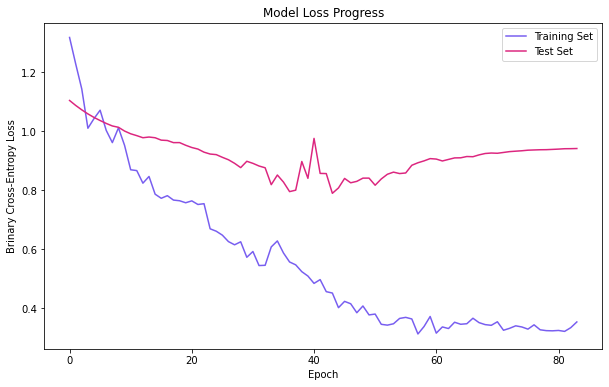

In [9]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

hist = model.fit(train, validation_data=test, batch_size=40, epochs=1000, callbacks=[
    ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_delta=1e-2, mode='min', verbose=1),
    EarlyStopping(monitor='val_loss', patience=40, min_delta=1e-5, restore_best_weights=True, verbose=1)
])

fig = plt.figure(figsize=(10,6))
plt.plot(hist.history['loss'], color='#785ef0')
plt.plot(hist.history['val_loss'], color='#dc267f')
plt.title('Model Loss Progress')
plt.ylabel('Brinary Cross-Entropy Loss')
plt.xlabel('Epoch')
plt.legend(['Training Set', 'Test Set'], loc='upper right')
plt.show()

In [10]:
model.save('./model.hdf5')

In [8]:
from tensorflow.keras.models import load_model

model = load_model('./model.hdf5')

In [9]:
import numpy as np

a = np.array([193,192,172,193,190,171,195,192,175,187,185,172,187,164,148,117,69,67,214,184,150,196,172,146,204,179,149,202,189,154,205,192,174,205,191,165,203,196,178,201,199,186,202,199,182,203,195,172,203,190,158,200,185,146,200,181,139,198,172,121,198,171,114,193,168,110,193,162,108,192,160,109,192,162,112,188,163,109,186,155,99,184,155,89,185,147,85,190,144,69,89,55,28,126,119,65,168,161,115,113,109,106,14,14,14,15,15,13,15,15,15,127,140,156,38,38,38,16,16,14,14,14,12,12,12,10,11,11,9,11,11,9,11,11,11,13,13,13,12,12,12,13,13,11,15,15,15,9,9,9,8,8,8,8,8,8,9,9,9,9,9,9,8,8,8,9,9,9,9,9,9,8,8,8,8,8,8,10,10,10,9,9,9,10,10,10,10,10,10,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,10,10,10,10,10,10,10,10,10,9,9,9,10,10,10,8,8,8,9,9,9,8,8,8,10,10,10,8,8,8,9,9,9,8,8,8,8,8,8,10,10,10,9,9,9,11,11,11,11,11,11,12,12,12,10,10,10,9,9,9,11,11,11,10,10,10,11,11,11,11,11,11,10,10,10,10,10,10,9,9,9,9,9,9,10,10,10,12,12,12,10,10,10,12,12,12,9,9,9,11,11,11,10,10,10,12,12,12,11,11,11,12,12,12,11,11,11,12,12,12,11,11,11,11,11,11,12,12,12,11,11,11,12,12,12,12,12,12,12,12,12,11,11,11,13,13,13,11,11,11,12,12,12,13,13,13,13,11,12,15,11,12,14,12,13,14,12,13,13,11,12,14,14,14,13,13,13,12,12,12,11,11,11,13,13,13,10,10,10,11,11,11,11,11,11,12,12,12,12,12,12,12,12,12,11,11,11,12,12,12,12,12,12,10,10,10,11,11,11,10,10,12,10,10,12,10,10,12,9,9,11,10,10,12,10,10,12,10,10,12,9,9,9,9,9,9,9,9,9,10,10,10,10,10,10,8,8,8,9,9,9,8,8,8,9,9,9,9,9,9,8,8,8,9,9,9,10,10,10,8,8,8,8,8,8,9,9,9,8,8,8,8,8,8,8,8,8,8,8,8,9,9,9,8,8,8,10,8,9,8,6,7,11,9,10,8,6,7,9,7,8,8,6,7,8,6,7,9,7,8,7,7,9,8,8,8,9,9,11,9,9,9,9,9,9,10,10,12,167,169,168,166,169,160,161,166,159,166,169,162,166,167,161,164,167,160,165,166,158,165,166,160,165,166,160,164,165,159,162,165,158,160,163,156,161,162,156,163,164,158,157,159,156,155,157,152,196,194,179,193,194,176,194,196,182,187,192,185,189,186,179,188,180,167,163,135,122,209,180,140,201,182,152,198,175,134,205,185,152,200,181,148,203,187,154,202,194,171,203,195,174,203,190,155,204,186,148,203,180,138,202,174,127,197,169,106,196,161,95,198,155,76,194,156,75,198,159,94,194,156,85,192,155,85,192,148,77,188,140,78,185,137,71,184,114,42,131,113,103,191,192,176,191,191,191,100,101,95,14,14,12,13,13,11,5,7,2,85,78,85,182,184,181,13,13,11,9,9,7,13,13,13,11,11,11,12,12,10,11,11,9,11,11,9,12,12,10,13,13,13,11,11,11,8,8,8,8,8,8,9,9,9,7,7,7,7,7,7,10,10,10,9,9,9,8,8,8,9,9,9,8,8,8,11,9,10,10,8,9,10,8,9,11,11,11,7,7,7,9,9,9,10,10,10,10,10,10,10,10,10,9,9,9,10,10,10,10,10,10,9,9,9,9,9,9,10,10,10,9,9,9,10,10,10,10,10,10,10,10,10,10,10,10,11,11,11,10,10,10,9,9,9,10,10,10,10,10,10,11,11,11,9,9,9,10,10,10,10,10,10,12,12,12,9,9,9,12,12,12,11,11,11,10,10,10,10,10,10,10,10,10,10,10,10,11,11,11,9,9,9,10,10,10,9,9,9,10,10,10,10,10,10,11,11,11,11,11,11,10,10,10,10,10,10,10,10,10,12,12,12,9,9,9,12,12,12,12,12,12,10,10,10,13,13,13,10,10,10,12,12,12,11,11,11,13,13,13,11,11,11,12,12,12,12,12,12,13,13,13,12,12,12,12,12,12,11,11,11,11,11,11,15,13,14,14,12,13,13,11,12,14,12,13,12,10,11,11,11,11,12,12,12,12,12,12,11,11,11,13,11,12,13,13,13,10,10,10,11,11,11,10,10,10,11,11,11,9,9,9,10,10,10,9,9,9,11,11,11,10,10,10,10,10,10,10,10,10,10,10,10,9,9,9,9,9,9,10,10,10,10,10,10,9,9,9,9,9,9,10,10,10,9,9,9,9,9,9,9,9,9,9,9,9,8,8,8,9,7,8,9,7,8,9,7,8,8,8,8,8,8,8,10,8,9,9,7,8,10,8,9,8,8,8,9,7,8,11,7,8,8,6,7,7,5,6,9,7,8,9,7,8,8,6,7,9,7,8,9,7,8,7,7,7,9,7,8,10,8,9,10,10,12,8,8,8,9,9,9,165,167,166,167,168,160,165,168,161,167,170,163,166,167,161,164,167,160,164,165,159,167,168,162,165,166,158,164,165,159,163,166,159,161,164,157,162,163,157,161,162,156,159,160,154,155,156,151,197,196,178,196,199,182,196,198,184,193,196,185,195,195,187,190,193,184,187,186,182,176,166,164,154,112,87,197,172,139,207,180,153,206,180,155,183,151,102,202,188,151,203,184,151,201,183,143,201,177,131,205,174,127,202,170,113,202,164,102,198,155,86,196,147,71,192,143,64,191,145,60,193,139,65,194,137,58,190,128,51,185,124,43,177,116,49,68,20,10,65,31,20,86,71,40,164,179,160,100,102,99,12,12,10,15,15,13,158,162,173,151,149,188,123,129,145,12,10,11,12,12,10,13,13,13,11,11,11,12,12,12,12,12,10,12,12,10,13,13,11,11,11,11,15,13,14,9,9,9,7,7,7,9,9,9,9,9,9,9,9,9,9,9,9,8,8,8,10,10,10,9,9,9,11,9,10,8,6,7,11,9,10,10,8,9,9,9,9,9,9,9,12,12,12,10,10,10,10,10,10,9,9,9,10,10,12,11,11,13,9,9,9,10,10,10,10,10,10,10,10,10,11,11,11,10,10,10,10,10,10,11,11,11,10,10,10,10,10,10,10,10,10,11,11,11,10,10,10,11,11,11,11,11,11,10,10,10,10,10,10,10,10,10,10,10,12,11,11,11,12,12,12,11,11,11,10,10,10,10,10,10,10,10,10,11,11,11,10,10,10,10,10,10,11,11,11,12,12,12,10,10,10,11,11,11,11,11,11,10,10,10,10,10,10,11,11,11,13,13,13,11,11,11,13,13,13,10,10,10,12,12,12,13,13,13,11,11,11,11,9,10,10,10,10,13,13,13,13,13,13,14,14,14,13,13,13,12,12,12,12,12,12,11,11,11,12,12,12,11,11,11,12,12,12,14,12,13,11,9,10,13,11,12,12,10,11,13,11,12,11,9,10,12,12,12,11,11,11,10,10,10,10,10,10,12,12,12,11,11,11,10,10,10,10,10,10,10,10,10,11,11,11,9,9,9,11,11,11,9,9,9,10,10,10,9,9,9,11,11,11,10,10,10,10,10,10,9,9,9,10,10,10,10,10,10,9,9,9,9,9,9,11,11,11,8,8,8,9,9,9,9,9,9,8,8,8,8,6,7,10,8,9,9,7,8,10,8,9,10,8,9,9,7,8,10,8,9,8,6,7,7,5,6,9,7,8,9,7,8,8,6,7,8,6,7,8,6,7,8,6,7,9,7,8,9,7,8,9,9,9,10,8,9,9,7,8,9,7,10,11,9,10,10,10,12,9,9,11,9,9,9,175,175,173,166,169,162,167,170,163,165,168,161,165,168,161,165,168,161,165,166,160,165,166,160,165,166,160,164,165,159,162,165,158,163,164,159,161,162,156,160,161,155,157,158,153,156,157,152,194,198,181,199,201,187,197,199,186,198,200,187,198,199,191,195,196,190,195,196,188,193,196,187,193,190,183,191,181,169,144,84,56,200,162,79,205,172,127,211,169,111,205,168,113,199,155,92,196,150,75,190,135,78,195,130,76,188,135,59,184,124,52,188,125,45,191,120,32,186,114,28,188,107,36,180,93,14,175,91,19,152,63,33,69,17,4,77,30,20,113,70,53,147,126,131,126,130,141,120,134,147,15,16,11,12,13,8,189,198,197,180,195,202,21,20,26,12,13,8,13,13,11,13,13,11,13,13,13,13,13,11,13,13,13,10,10,10,14,14,12,14,14,12,14,14,12,9,9,9,8,8,8,10,10,10,8,8,8,9,9,9,9,9,9,9,9,9,8,8,8,11,11,11,11,9,10,9,7,8,11,9,10,11,9,10,13,9,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,11,11,11,10,10,10,12,12,12,11,11,11,11,11,11,11,11,11,11,11,11,12,12,12,10,10,10,11,11,11,11,11,11,11,11,11,11,11,11,10,10,10,10,10,10,12,12,12,10,10,10,11,11,11,10,10,10,9,9,11,12,12,12,12,12,12,11,11,11,11,11,11,12,12,12,10,10,10,12,12,12,11,11,11,11,11,11,11,11,11,9,9,9,11,11,11,11,11,11,12,12,12,11,11,11,10,10,10,12,12,12,10,10,10,11,11,11,11,11,11,13,13,13,14,14,14,13,13,13,12,12,12,12,12,12,10,10,10,11,11,11,12,12,12,13,13,13,12,12,12,12,12,12,11,11,11,11,11,11,12,12,12,12,12,12,12,12,12,14,12,13,13,11,12,12,10,11,15,11,12,15,11,12,13,13,13,11,11,11,10,10,10,12,12,12,11,11,11,13,13,13,10,10,10,11,11,11,10,10,10,11,11,11,11,11,11,12,12,12,10,10,10,10,10,10,10,10,10,11,11,11,9,9,9,9,9,9,9,9,9,11,11,11,9,9,9,9,9,9,10,10,10,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,7,7,7,12,8,9,8,8,8,9,7,8,8,6,7,9,7,8,9,7,8,9,7,8,9,7,8,9,7,8,8,6,7,8,6,7,10,8,9,11,7,8,9,5,6,8,8,8,7,7,7,7,5,6,9,7,8,8,6,7,12,8,9,13,9,10,10,8,9,9,7,10,14,9,13,164,168,169,166,169,162,168,169,161,167,168,162,165,168,159,166,168,163,166,169,162,166,167,161,165,166,158,166,167,161,164,165,157,162,163,157,161,162,156,159,160,154,159,160,154,158,159,154,204,204,192,201,199,186,198,201,190,199,202,191,197,200,191,199,202,193,197,200,191,197,200,193,197,198,192,194,197,186,192,193,185,197,190,180,165,135,127,120,50,0,154,61,2,165,56,26,155,46,5,149,47,7,151,60,13,160,63,21,153,59,7,157,63,12,152,56,16,151,52,10,152,48,11,133,29,4,73,17,2,43,14,10,46,17,3,79,31,21,133,88,59,157,142,137,173,172,168,181,181,179,13,13,11,14,14,12,147,148,152,201,202,204,192,193,187,14,14,12,13,13,11,13,13,11,12,12,10,13,13,13,11,11,11,14,14,14,14,14,14,13,13,13,19,17,18,9,9,9,7,7,5,10,10,10,9,9,9,10,10,10,14,14,14,9,9,9,9,9,9,13,13,13,12,12,12,12,11,9,12,10,11,15,13,14,13,11,12,14,12,13,12,12,12,10,10,10,11,11,11,10,10,10,11,11,11,11,11,11,11,11,11,12,12,12,11,11,11,12,12,12,13,13,13,10,10,10,12,12,12,12,12,12,12,12,12,11,11,11,11,11,11,11,11,11,13,13,13,9,9,9,10,10,10,11,11,11,10,10,10,11,11,11,11,11,11,12,12,12,13,13,13,11,11,11,13,13,13,12,10,11,11,11,11,12,10,11,12,12,12,10,10,10,10,10,10,12,12,12,11,11,11,13,13,13,11,11,11,13,13,13,13,13,13,13,13,13,12,12,12,11,11,11,11,11,11,12,12,12,13,13,13,12,12,12,13,13,13,14,12,13,11,11,11,12,12,12,12,12,12,13,13,13,13,13,13,14,14,14,12,12,12,10,10,10,12,12,12,12,12,12,13,13,13,13,11,12,12,10,11,12,10,11,13,11,12,12,10,11,12,12,12,12,12,12,11,11,11,11,11,11,11,9,10,11,9,10,12,10,11,12,10,11,13,11,12,10,10,10,10,10,10,12,12,12,9,9,9,11,9,10,11,9,10,11,9,10,11,9,10,10,10,10,10,10,10,11,11,11,10,10,10,10,10,10,9,9,9,9,9,9,9,7,8,9,9,9,8,8,8,9,9,9,8,8,8,8,8,8,8,8,8,7,7,7,8,8,8,6,6,6,10,8,9,8,6,7,9,7,8,9,7,8,9,7,8,9,7,8,9,7,8,8,8,8,7,7,7,8,8,8,8,8,8,6,6,6,7,7,7,8,8,8,8,6,7,10,8,9,10,8,9,10,8,9,10,8,11,9,9,11,164,164,166,166,169,160,168,169,161,167,168,160,166,169,162,165,168,161,165,168,161,165,168,161,167,168,162,164,166,161,164,165,159,162,163,158,161,162,156,161,162,156,160,161,156,159,159,151,103,44,38,214,194,167,200,202,189,200,204,190,198,201,194,200,203,194,196,202,192,198,201,192,198,201,192,200,202,189,200,202,189,197,195,180,197,190,172,189,176,144,190,155,125,170,110,73,60,18,4,69,14,10,52,14,13,66,12,12,65,14,9,54,13,9,52,17,15,43,12,7,35,11,7,41,12,14,37,12,8,42,14,10,50,17,12,70,32,19,128,91,81,158,150,148,173,173,171,183,184,188,18,18,16,13,13,11,29,29,29,27,22,16,4,13,20,14,14,14,13,13,11,10,10,8,14,14,14,13,13,11,12,12,12,13,13,11,13,13,13,13,13,13,15,14,12,10,10,10,8,8,8,9,9,9,8,18,20,15,27,53,14,23,40,8,12,21,20,20,32,28,18,26,17,16,21,14,16,13,8,12,11,14,16,11,13,11,16,16,16,16,12,12,14,13,14,18,14,15,17,15,15,15,16,14,15,13,11,12,14,15,10,15,13,14,15,13,18,14,14,14,16,16,16,12,12,10,16,16,16,14,14,14,13,13,13,13,13,13,12,12,14,15,15,15,15,15,15,13,13,13,13,13,13,12,12,12,14,14,14,16,16,16,12,12,12,15,15,15,13,13,13,13,13,13,11,11,11,14,12,13,15,13,14,12,12,12,13,13,13,11,11,11,11,11,11,12,12,12,12,12,12,11,11,11,12,12,12,12,12,12,11,11,11,12,12,12,11,11,11,11,11,11,12,12,12,11,11,11,12,12,12,12,12,12,14,14,14,12,12,12,12,12,12,13,13,13,13,13,13,13,13,13,14,14,14,12,12,12,13,13,13,13,13,13,12,12,12,13,13,13,15,13,16,14,12,13,14,12,13,14,12,13,11,11,11,11,11,11,13,13,13,12,12,12,11,11,11,11,11,11,11,11,11,12,12,12,12,12,12,10,10,10,14,12,13,10,10,10,11,11,11,11,11,11,11,9,12,12,10,13,11,9,10,10,8,9,10,8,9,10,10,10,9,9,9,9,9,9,8,8,8,10,10,10,9,9,9,9,9,9,10,8,9,7,7,7,10,10,10,9,9,9,10,10,10,8,8,8,8,8,8,8,8,8,7,7,7,8,8,8,8,8,8,10,8,9,10,8,9,8,6,7,9,7,8,7,7,7,10,8,9,7,7,7,8,8,8,7,7,7,7,7,7,7,7,7,8,8,8,7,7,7,9,7,8,9,7,8,10,8,9,9,7,8,10,8,9,11,11,11,171,166,170,166,171,164,164,169,162,167,170,161,166,169,158,165,168,161,165,168,161,164,165,159,165,165,157,165,166,158,163,164,159,162,163,158,162,163,157,163,160,153,164,161,154,155,157,152,147,83,81,195,157,156,163,135,124,201,202,196,198,203,199,198,205,197,199,205,195,203,205,194,202,204,193,199,201,188,199,201,187,200,198,185,201,196,175,197,190,162,196,180,146,193,170,128,191,154,109,176,127,68,132,75,45,27,10,16,24,13,11,23,9,8,26,11,8,30,12,8,31,13,11,30,9,8,43,15,11,42,14,10,50,17,12,74,37,18,133,100,93,160,155,152,174,175,177,181,185,186,17,16,14,16,16,14,14,14,12,95,89,101,95,96,101,13,13,11,14,14,12,14,14,12,13,13,13,12,12,12,11,11,9,14,14,14,13,13,13,13,13,13,13,13,11,8,8,8,8,8,8,10,10,10,63,79,96,207,211,212,208,214,214,210,212,211,204,210,208,206,210,211,210,216,214,200,214,215,208,222,225,196,216,227,174,204,216,143,185,201,123,163,189,121,156,196,109,153,200,77,125,175,70,117,169,63,99,159,42,84,136,30,73,115,12,57,90,0,30,51,0,23,34,11,18,38,6,14,27,5,10,32,12,15,22,12,17,20,12,16,25,14,19,13,18,14,11,19,17,22,10,12,9,15,15,13,16,17,12,12,14,13,16,14,15,11,15,16,11,12,14,16,16,18,16,16,18,14,14,12,13,15,14,14,14,14,18,13,17,16,14,17,14,12,13,12,12,12,11,12,16,14,14,14,13,13,15,14,14,16,13,13,13,13,15,12,14,14,14,13,15,14,15,15,17,13,13,13,14,14,14,13,13,13,14,14,14,10,10,10,14,14,14,15,15,15,15,15,15,16,16,16,14,14,14,15,15,15,12,12,12,14,14,14,14,14,14,12,12,12,13,13,11,14,14,12,12,12,10,14,14,14,13,13,15,13,13,13,14,14,14,11,11,11,13,13,13,13,13,13,11,11,13,12,12,12,15,11,12,13,13,13,11,11,11,11,11,11,10,10,10,11,11,11,12,12,12,10,8,9,12,10,11,10,8,9,10,10,10,10,10,10,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,8,8,8,10,8,9,10,8,9,11,9,10,9,9,9,9,9,9,8,8,8,7,7,7,9,9,9,8,8,8,8,8,8,7,7,7,7,7,7,7,7,7,11,7,8,10,8,9,8,6,7,10,6,7,10,8,9,9,9,9,8,8,8,9,9,9,6,6,6,8,8,8,8,8,8,8,6,7,11,9,10,9,7,8,10,8,9,11,9,10,11,11,11,54,40,31,109,82,52,165,127,80,182,147,83,176,162,123,156,170,119,170,172,123,164,164,126,163,165,154,153,167,168,150,161,163,154,164,166,161,159,162,154,160,156,167,158,161,159,155,156,183,159,147,180,139,137,185,167,147,200,182,144,198,181,99,201,205,191,202,204,191,204,206,195,202,204,191,201,203,190,200,202,188,198,199,183,202,201,181,201,195,173,202,190,164,196,180,146,200,175,135,197,171,120,196,169,114,190,145,80,85,55,65,21,11,10,26,12,11,31,13,11,31,13,11,33,15,11,37,13,9,49,18,13,50,15,9,74,39,20,144,104,102,163,164,169,174,177,182,174,177,182,16,16,14,15,15,13,19,20,15,98,104,104,134,143,138,16,16,16,13,13,11,13,13,11,13,13,11,14,14,12,14,14,14,14,14,12,14,14,14,11,11,11,14,14,14,7,7,7,8,8,8,11,11,11,79,91,105,206,210,211,204,210,208,206,212,210,206,212,210,207,211,210,206,212,210,206,212,210,206,210,211,206,212,208,206,211,207,209,210,212,206,210,211,206,211,207,205,210,206,206,208,205,206,210,209,205,209,208,205,209,208,203,208,202,203,209,205,202,207,201,204,208,207,206,206,208,203,209,205,203,204,206,203,211,213,199,212,205,198,208,209,198,213,216,192,209,217,197,221,233,184,209,229,181,200,217,144,186,210,129,172,215,106,153,207,93,144,199,69,125,178,71,114,159,66,101,141,54,88,123,49,74,105,34,53,85,15,32,49,18,25,35,13,23,25,11,19,22,13,14,19,11,14,19,13,17,16,16,16,16,12,10,11,17,18,12,21,17,18,23,18,22,19,17,22,15,13,14,16,17,19,17,17,17,15,15,17,18,16,17,15,15,17,16,18,17,12,14,13,14,16,15,17,17,17,15,15,15,15,15,15,15,15,15,13,13,11,11,11,9,16,16,14,15,15,15,15,15,13,15,15,13,14,14,14,14,14,14,12,12,12,16,14,15,14,14,14,14,14,14,13,13,13,13,13,11,11,11,11,11,11,11,12,12,12,13,13,13,10,10,10,13,13,13,11,9,10,12,10,11,14,12,13,12,10,11,10,10,10,10,10,10,10,10,10,10,10,10,11,11,11,9,9,9,10,10,10,12,10,11,9,9,9,11,9,10,11,9,10,10,8,9,10,8,9,10,8,9,10,8,9,10,8,9,8,8,8,7,7,7,9,9,9,6,6,6,8,8,8,8,8,8,8,8,8,10,8,9,9,7,8,9,7,8,10,8,9,7,7,7,7,7,7,8,8,8,8,8,8,8,6,7,8,6,7,9,7,8,10,8,9,11,9,10,9,7,8,11,9,10,10,10,10,6,10,11,10,10,10,11,11,11,12,11,16,17,12,18,12,11,9,12,10,11,14,12,13,14,8,8,11,10,8,11,12,7,12,11,9,5,9,8,11,9,10,16,12,27,175,151,151,190,191,193,200,192,94,205,195,134,198,140,30,109,27,29,208,150,102,203,205,194,205,205,197,202,204,191,203,203,191,204,205,191,202,203,187,203,196,170,202,191,163,201,188,154,197,181,147,197,179,143,195,173,134,197,167,117,198,162,100,199,175,129,26,0,27,27,11,11,30,12,10,32,14,10,40,15,10,51,20,15,51,18,11,88,46,34,144,114,102,167,167,169,175,180,183,176,184,186,14,16,13,15,15,13,119,117,141,96,104,125,157,161,173,15,15,13,14,14,12,13,13,11,12,12,10,13,13,11,12,12,10,12,12,12,12,12,12,11,11,11,16,16,14,9,9,9,10,10,10,8,8,8,73,81,84,209,211,210,206,210,209,206,212,210,206,212,210,207,211,210,207,211,210,207,213,211,208,212,211,207,211,210,208,212,211,206,210,209,207,211,210,207,211,210,207,212,208,207,212,208,206,211,207,205,210,206,205,209,208,205,209,208,206,210,209,204,208,207,205,210,206,204,209,205,205,210,206,204,209,205,204,209,205,203,207,206,203,208,204,207,209,206,204,209,205,206,208,205,202,207,203,207,209,206,203,208,204,202,206,205,204,206,205,206,206,206,205,207,206,204,206,205,201,205,204,201,206,202,199,205,205,197,201,202,200,202,201,200,205,201,204,204,204,200,204,203,200,201,203,200,202,197,201,203,202,199,203,202,202,204,199,201,203,200,196,206,208,187,202,209,173,196,204,157,185,198,148,176,197,122,151,191,110,144,181,89,133,172,79,122,165,86,121,176,55,96,140,44,91,133,47,71,99,26,57,103,26,47,92,22,17,23,16,28,40,6,14,27,4,14,24,9,18,15,15,20,16,23,18,22,18,16,17,18,16,17,13,12,10,11,14,7,16,16,16,12,17,13,8,10,7,13,15,12,18,14,15,14,12,15,16,15,13,11,11,11,15,13,14,14,13,11,12,12,14,14,10,11,15,13,14,14,12,13,13,13,13,12,12,12,6,10,9,12,12,12,11,11,11,10,10,10,10,10,10,14,12,13,11,11,11,12,12,12,10,8,9,12,10,11,10,8,9,11,9,10,10,8,9,10,10,10,9,9,9,9,9,9,9,9,7,8,8,8,9,9,11,9,9,9,7,7,7,8,8,8,10,8,9,9,7,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,6,7,10,8,9,10,8,9,10,8,9,11,9,10,9,7,8,11,9,10,10,10,10,9,9,9,10,10,10,10,10,10,11,9,10,10,9,7,11,9,10,11,9,10,11,9,10,11,9,10,11,9,10,13,9,10,13,9,10,12,8,9,12,8,9,169,130,63,199,198,176,198,179,25,193,197,103,204,154,31,124,64,54,161,87,76,140,55,34,202,166,72,206,203,186,208,207,202,203,205,191,203,204,186,200,196,171,201,191,163,201,187,158,200,184,150,199,180,147,200,178,141,197,172,131,196,163,108,194,159,101,188,154,93,168,147,128,25,10,3,32,15,8,40,16,14,52,21,16,51,22,14,101,65,53,165,137,136,173,173,183,175,182,190,175,182,188,16,17,19,14,14,14,19,20,15,169,167,181,144,153,162,20,19,17,12,12,10,11,11,9,14,15,10,14,14,12,13,13,13,11,11,9,13,13,11,13,13,13,19,15,14,8,8,8,9,9,9,12,12,12,63,67,68,203,212,211,206,212,210,206,212,210,208,214,212,208,212,211,208,212,211,208,212,211,208,212,211,208,212,211,208,212,211,208,212,211,208,212,211,207,211,210,207,211,210,207,212,208,207,212,208,207,212,208,207,212,208,207,212,208,207,212,208,206,211,207,206,211,207,206,211,207,206,211,207,205,210,206,205,210,206,205,210,206,205,210,206,207,209,206,207,209,206,207,209,206,204,209,205,206,208,205,204,209,205,204,209,205,204,209,205,204,209,205,207,209,206,203,208,204,202,206,205,202,206,207,205,207,204,205,207,204,204,206,205,203,205,202,203,205,202,201,203,200,202,204,201,204,206,203,202,204,201,202,204,201,202,204,201,197,203,199,198,203,199,198,202,201,196,200,199,197,201,200,195,199,198,197,201,200,200,202,197,197,202,198,197,199,196,193,199,197,195,200,196,194,199,195,197,202,198,197,199,196,194,196,193,193,195,190,195,195,193,193,195,194,192,194,191,192,197,193,188,192,191,186,195,194,184,194,195,189,197,200,192,200,203,196,207,211,179,194,197,171,198,217,135,180,209,115,158,193,120,152,191,95,136,180,81,126,165,105,134,152,118,134,151,80,99,106,72,83,87,47,72,77,50,69,85,12,31,37,8,17,22,6,20,21,4,6,1,12,12,14,20,20,20,20,15,12,12,11,7,18,15,10,13,13,11,13,11,12,10,10,8,12,10,11,11,9,10,11,11,11,13,11,16,11,11,9,11,9,12,8,6,9,10,10,12,11,10,16,10,10,12,8,9,11,9,9,11,10,8,9,10,8,13,8,10,9,8,8,6,9,9,11,9,9,7,8,8,8,8,8,8,8,8,10,9,7,8,10,8,11,9,7,8,10,8,9,12,8,9,10,8,9,10,8,9,9,9,9,9,9,9,8,8,8,8,8,10,10,8,9,14,10,9,9,7,8,10,8,9,9,7,8,10,8,9,11,9,10,12,8,9,9,7,8,9,7,8,11,7,8,204,188,74,195,171,75,199,168,15,208,199,96,206,148,38,176,143,138,191,164,153,207,185,99,185,126,8,170,101,23,113,35,12,219,192,139,206,203,186,204,197,171,205,191,162,203,186,158,201,184,154,198,178,141,198,179,139,204,177,124,194,167,110,193,157,99,192,154,91,189,156,103,191,145,96,40,25,0,43,15,11,46,23,17,48,20,17,105,80,75,148,143,149,171,175,186,175,182,190,184,189,195,16,16,14,17,19,16,23,19,20,178,183,189,120,119,159,12,14,13,13,13,11,15,15,13,14,14,12,15,15,15,15,15,13,12,12,10,13,13,15,15,15,13,16,16,16,7,7,7,10,10,10,13,13,13,52,57,51,207,213,213,207,211,210,208,212,211,208,212,211,208,212,211,208,212,211,208,212,211,207,211,210,208,212,211,208,212,211,208,212,211,208,212,211,208,212,211,208,212,211,208,212,211,208,212,211,207,211,210,207,211,210,207,211,210,207,211,210,206,210,209,207,211,210,207,211,210,206,210,209,206,211,207,206,210,209,206,211,207,206,210,209,206,210,209,206,210,209,206,211,207,205,210,206,205,210,206,205,210,206,206,211,207,205,210,206,204,209,205,204,209,205,206,208,205,206,208,207,205,207,204,204,206,203,205,207,204,206,208,205,205,207,204,205,207,204,203,205,202,203,205,202,204,206,203,203,205,202,203,205,202,202,204,201,202,204,201,203,205,202,200,205,201,200,204,203,199,204,200,200,205,201,198,203,199,198,203,199,197,203,199,198,203,199,198,203,199,196,200,199,196,200,199,195,199,198,195,200,196,196,201,197,195,199,198,196,198,195,194,199,195,193,198,194,192,197,191,193,198,194,193,198,194,193,198,194,191,196,192,190,195,191,190,194,193,190,194,193,189,195,191,189,194,188,186,195,192,187,193,191,188,192,191,187,192,186,190,192,189,188,190,187,189,191,188,187,189,186,188,190,187,186,188,183,188,189,183,191,190,185,189,188,184,180,189,184,181,186,180,182,187,180,185,187,182,181,186,182,187,187,175,181,181,169,177,186,183,179,188,183,189,191,186,183,198,191,187,193,193,170,190,188,160,174,183,143,166,174,107,141,166,107,130,161,95,114,156,70,101,145,60,88,135,52,84,125,47,66,96,32,46,72,16,30,43,16,29,37,10,11,16,8,17,26,2,12,21,14,11,18,9,9,9,8,8,10,9,9,11,10,8,9,9,7,8,8,8,8,9,7,8,14,10,9,10,9,7,9,9,7,9,9,7,12,8,7,12,10,11,13,12,8,9,8,4,14,10,9,12,8,9,13,9,8,10,10,8,12,8,7,13,9,10,10,6,5,12,8,9,187,163,53,192,166,30,201,154,20,204,186,84,205,142,63,200,181,185,203,192,74,205,189,76,208,182,46,192,148,25,153,53,17,118,40,20,194,170,124,206,192,166,202,188,159,202,185,159,202,186,161,203,182,153,197,174,132,196,168,121,196,166,112,187,147,78,188,150,85,184,153,99,189,155,110,182,148,103,161,145,130,36,13,7,52,24,23,129,103,104,164,162,173,174,181,189,178,182,191,184,188,197,15,15,15,18,18,16,27,23,24,178,180,175,134,139,142,17,19,14,12,12,10,10,10,8,14,14,12,11,11,9,14,14,12,11,11,11,12,12,12,14,14,14,15,17,16,10,10,10,10,10,10,12,12,12,51,59,61,208,212,213,206,212,212,209,213,212,208,212,211,208,212,211,208,212,211,208,212,211,208,212,211,208,212,211,208,212,211,208,212,211,207,211,210,208,212,211,208,212,211,208,212,211,208,212,211,208,212,211,207,211,210,207,211,210,208,212,211,207,211,210,207,211,210,207,211,210,207,211,210,207,211,210,206,210,209,206,210,209,206,211,207,206,211,207,206,211,207,205,210,206,206,211,207,205,210,206,206,211,207,205,210,206,204,209,205,204,209,205,205,210,206,204,209,205,204,209,205,206,208,205,206,208,207,206,208,205,206,208,207,204,206,203,205,207,204,205,207,206,203,205,204,202,206,205,204,206,205,203,205,204,203,205,204,203,205,204,204,206,203,202,204,203,202,203,205,201,203,202,199,203,202,198,203,199,199,203,202,199,204,200,198,203,199,198,203,199,198,203,199,198,203,199,196,200,199,196,201,197,197,202,198,195,200,196,195,200,196,194,199,195,193,199,195,194,199,195,193,198,194,193,198,194,194,199,195,191,196,192,192,197,193,191,196,190,190,195,189,192,194,189,190,195,189,191,196,189,189,194,188,188,193,189,189,194,188,188,193,189,188,193,187,185,192,185,185,190,184,187,192,186,188,190,185,188,190,185,188,190,185,187,189,184,186,189,182,187,189,184,186,188,183,186,189,182,185,188,181,181,186,179,185,188,181,184,187,180,184,187,180,181,186,179,180,185,178,183,186,179,181,184,177,180,183,174,180,182,177,181,184,175,180,183,174,180,183,174,178,183,177,180,181,175,181,184,175,180,182,177,180,180,172,180,183,174,179,182,171,178,178,176,178,181,174,175,178,171,77,73,90,9,8,13,8,8,10,14,14,16,8,8,10,10,10,10,8,8,8,11,9,12,129,40,20,103,25,15,61,46,23,16,17,9,20,1,0,144,127,73,129,82,10,121,60,16,60,14,16,57,18,23,151,70,27,126,134,85,103,74,44,37,14,6,19,7,7,25,12,6,187,149,14,209,176,79,191,143,15,146,108,23,205,167,32,209,194,165,202,185,9,181,147,60,205,192,51,158,83,16,184,111,92,174,98,66,162,73,41,208,168,117,209,202,184,205,190,169,199,185,150,198,180,140,197,172,131,197,172,118,196,166,112,194,160,99,187,145,84,197,161,125,190,160,122,183,148,93,182,151,104,182,155,112,73,49,45,137,124,134,173,177,188,181,186,192,180,187,195,190,196,208,19,21,20,18,18,18,20,19,14,194,204,203,170,174,175,14,14,12,14,14,12,12,12,10,13,13,11,13,14,9,14,14,12,14,14,12,13,13,13,13,13,13,15,13,14,10,10,10,10,10,10,15,13,14,47,52,56,206,215,212,207,213,213,208,214,212,209,213,212,209,213,214,209,213,212,207,213,211,208,212,211,207,213,211,208,212,211,209,213,212,208,212,211,208,212,211,208,212,211,208,212,211,208,212,211,208,212,211,208,212,211,209,213,212,208,212,211,208,212,211,207,211,210,208,212,211,207,211,210,207,211,210,207,211,210,207,211,210,208,213,209,207,212,208,207,212,208,207,212,206,206,211,207,206,211,207,206,211,207,206,211,207,205,210,206,205,210,206,205,210,204,205,210,206,205,210,206,205,210,204,208,208,206,205,207,204,207,209,206,206,208,205,206,208,207,205,207,204,205,207,204,205,207,206,204,206,205,204,206,205,204,206,205,205,207,206,204,206,203,203,205,202,203,205,204,202,204,203,203,205,202,200,204,203,200,205,201,199,204,200,198,203,199,199,204,200,197,201,200,198,203,199,198,203,199,199,204,200,199,201,198,196,201,197,195,200,196,196,201,197,194,199,195,195,200,196,194,199,195,193,197,196,193,198,194,193,198,192,193,198,192,194,196,191,192,197,191,192,197,191,193,198,192,190,195,189,190,195,189,192,194,189,189,194,188,189,194,188,189,194,188,191,193,188,189,194,188,188,193,187,189,191,186,188,190,185,188,190,185,188,190,185,188,190,185,188,190,185,187,190,183,184,191,183,183,188,181,186,189,182,185,188,181,185,188,181,185,188,181,184,187,180,180,186,176,183,186,179,183,186,179,182,185,178,182,185,176,180,186,176,179,185,175,181,184,175,179,185,173,179,185,173,180,183,174,180,183,174,180,183,174,180,183,174,179,182,175,179,182,173,178,181,174,178,181,170,102,109,119,9,11,10,7,7,9,9,9,11,10,10,10,9,9,9,9,9,9,9,9,9,118,27,16,112,21,13,47,14,5,17,10,4,44,15,1,144,127,71,110,60,7,112,50,11,38,10,7,55,8,14,163,76,23,160,149,85,110,43,14,79,31,9,29,13,13,56,28,25,177,187,188,163,162,157,186,127,31,104,18,0,208,189,61,200,184,125,208,166,18,194,171,117,202,193,26,151,81,21,206,166,140,188,147,115,183,122,93,177,95,56,158,75,41,222,199,165,210,198,184,198,183,152,198,170,131,195,169,120,194,167,112,195,170,114,191,156,90,188,153,113,194,165,121,186,134,76,188,143,76,192,158,110,180,134,74,137,105,92,179,179,187,183,190,198,183,190,200,193,200,210,20,22,17,19,19,17,141,144,149,181,185,171,195,194,189,13,13,13,15,15,13,15,15,13,14,14,12,13,13,13,13,13,13,12,12,12,13,13,13,13,13,13,17,17,17,10,10,10,10,10,10,13,13,13,50,48,59,205,214,211,208,214,214,209,215,215,208,214,214,208,213,216,208,214,214,208,214,212,207,213,211,208,214,212,207,213,211,209,213,212,207,213,211,208,212,211,209,213,212,208,212,211,209,213,212,209,213,212,208,212,211,208,212,211,208,212,211,208,212,211,208,212,211,208,212,211,206,210,209,208,212,211,207,211,210,207,211,210,208,212,211,207,211,210,207,211,210,207,211,210,207,212,208,207,211,210,207,212,208,206,211,207,206,210,209,206,210,209,206,211,207,206,211,207,207,211,210,205,210,206,205,210,206,205,210,206,207,209,206,206,208,205,206,208,205,207,209,208,205,207,206,206,208,207,205,207,206,207,209,208,205,207,206,206,208,203,206,208,205,204,206,203,204,206,203,201,205,204,201,205,204,200,204,203,201,206,202,201,205,204,199,204,200,201,206,202,199,204,200,198,203,199,196,201,197,197,202,198,197,202,198,195,201,197,198,203,199,195,200,196,195,200,196,194,199,195,194,199,195,194,199,195,194,199,195,193,198,194,193,198,194,192,197,191,192,197,191,192,197,191,196,198,193,194,196,191,190,195,189,191,196,190,193,195,190,191,196,190,192,194,189,191,193,188,190,192,187,190,192,187,189,191,186,190,192,187,190,193,186,189,192,185,188,191,184,187,190,183,187,190,183,187,189,184,184,189,183,186,188,183,185,188,181,185,188,181,185,188,181,184,187,180,182,187,181,185,188,181,184,187,180,182,185,178,182,185,178,182,185,178,182,185,176,181,184,175,182,185,176,182,185,176,180,183,174,181,184,175,180,183,174,180,183,174,179,182,173,178,181,172,177,180,171,175,178,167,101,102,122,9,11,10,7,7,9,10,10,12,8,8,10,10,10,12,8,9,11,11,7,8,154,33,14,123,22,10,57,11,11,44,18,3,31,0,0,131,115,20,118,68,18,92,42,7,119,68,13,162,155,64,168,130,85,172,138,101,103,28,5,79,19,8,12,3,4,33,15,11,200,200,192,190,195,173,184,181,114,160,122,135,203,177,82,201,188,92,203,159,10,211,194,140,202,185,17,188,147,127,211,184,137,194,144,94,214,188,155,217,185,134,177,99,61,172,89,49,134,59,18,215,203,179,203,190,172,196,180,157,198,182,159,198,178,143,193,164,120,192,155,100,189,156,103,177,119,43,185,132,66,189,142,88,193,144,86,162,106,71,182,184,196,187,191,200,185,193,196,192,196,205,20,20,20,17,17,15,43,45,44,163,169,195,166,184,162,14,13,11,15,15,15,13,13,11,11,11,11,15,15,13,12,12,10,14,14,12,12,12,12,16,16,16,13,13,11,11,11,11,11,11,11,13,13,13,38,36,47,209,215,213,207,213,213,208,214,214,208,214,214,209,215,213,208,214,214,207,213,211,209,215,215,207,213,211,208,214,212,209,213,212,209,213,212,209,213,212,209,213,212,209,213,212,209,213,212,208,212,211,208,212,211,209,213,212,208,212,211,209,213,212,209,213,212,208,212,211,209,213,212,208,212,211,208,212,211,208,212,211,207,211,210,207,211,210,209,213,212,207,211,210,207,212,208,207,211,210,207,211,210,208,212,211,207,211,210,207,211,210,206,210,209,206,210,209,206,211,207,206,210,209,206,211,207,206,211,207,205,210,206,204,209,205,205,210,206,207,209,208,206,208,207,207,209,208,207,209,208,206,208,207,204,206,205,206,208,205,205,207,204,205,207,204,203,208,204,202,206,205,202,207,203,201,205,204,201,205,204,201,205,204,200,205,201,200,205,201,202,207,203,198,203,199,198,203,199,199,204,200,199,204,200,199,204,200,196,201,197,195,200,196,196,201,197,196,201,197,195,200,196,194,199,195,196,201,197,194,199,195,194,199,193,193,198,194,194,199,193,192,197,191,192,197,191,191,196,190,191,196,190,193,195,190,192,194,189,192,194,189,191,193,188,190,192,187,190,192,187,190,192,187,190,192,187,189,191,186,190,193,186,189,191,186,188,190,185,188,191,184,189,191,186,185,190,183,186,188,183,186,188,183,185,187,182,185,187,182,182,187,180,184,187,180,185,188,181,183,186,179,183,186,179,183,186,179,182,185,178,181,184,177,182,185,176,181,184,175,182,185,176,181,184,175,181,184,175,181,184,175,180,183,174,180,183,174,181,184,175,179,182,173,177,180,171,180,181,173,115,112,123,9,9,7,7,7,7,10,8,11,8,8,8,10,10,10,9,9,9,11,10,8,161,101,29,171,76,18,170,53,20,106,24,12,65,8,0,140,122,58,82,33,0,80,36,0,157,116,10,125,151,44,156,62,24,161,125,75,106,35,5,75,19,4,15,5,6,19,8,6,201,203,200,200,200,176,206,188,64,196,190,34,190,171,102,199,183,87,204,149,7,184,151,116,203,186,68,198,177,160,208,199,104,214,191,33,210,193,137,213,191,92,185,105,68,184,113,83,167,78,44,136,48,38,184,106,58,204,200,173,197,188,173,193,181,159,195,179,146,191,165,128,196,158,111,180,127,75,192,134,68,188,132,71,182,126,65,169,109,73,183,186,195,186,190,201,190,195,201,194,200,212,18,20,17,17,17,15,4,4,2,105,94,90,127,125,112,16,16,16,14,14,14,12,12,12,15,15,15,14,14,14,15,15,15,16,16,14,13,13,13,14,14,14,14,14,14,10,10,10,11,11,11,12,12,14,40,34,44,207,213,213,208,214,214,209,214,217,209,215,213,209,215,215,209,215,215,209,215,213,209,215,213,208,214,214,208,214,212,208,214,212,208,214,212,208,214,212,208,214,212,209,213,212,209,213,212,209,213,212,208,212,211,209,213,212,210,214,213,209,213,212,209,213,212,209,213,212,209,213,212,208,212,211,209,213,212,208,212,211,207,211,210,208,212,211,208,212,211,207,211,210,207,211,210,207,211,210,207,211,210,207,211,210,207,211,210,207,211,210,207,211,210,207,211,210,207,211,210,204,209,205,206,210,209,207,212,208,205,209,208,205,210,206,206,210,209,205,209,208,207,209,208,207,209,208,207,209,208,207,209,208,205,207,206,206,208,207,206,208,205,206,208,205,204,209,205,202,207,203,201,206,202,201,206,202,201,206,202,202,207,203,201,206,202,201,206,202,200,205,201,200,205,201,200,205,201,198,203,199,198,203,199,198,203,199,199,204,200,197,202,198,197,202,198,195,200,196,195,200,196,195,200,194,194,199,195,194,199,195,194,198,197,193,198,192,192,197,191,193,198,192,194,199,193,192,197,191,191,196,190,194,196,191,193,195,190,191,196,190,192,194,189,191,193,188,192,194,189,191,193,188,190,192,187,190,192,187,189,191,186,189,192,185,188,190,185,188,190,185,187,190,183,185,190,183,184,189,182,186,189,182,186,189,182,186,189,182,185,188,181,184,187,180,183,186,179,180,185,178,183,186,179,183,186,179,182,185,178,182,185,178,181,184,177,179,182,175,182,185,178,182,185,176,181,184,175,180,183,174,181,184,177,180,183,174,180,183,174,180,183,174,179,182,173,179,180,175,88,90,105,8,8,8,8,8,8,9,9,9,8,8,8,9,9,9,9,9,9,15,9,13,169,154,131,168,84,22,173,47,22,163,31,16,73,10,0,134,109,45,64,35,1,44,24,0,157,116,11,77,46,15,156,36,10,151,105,45,111,36,7,99,29,17,14,6,4,21,9,9,198,204,202,200,199,181,202,181,64,198,166,66,201,181,60,208,196,96,196,150,13,128,55,12,203,191,89,180,153,123,201,192,73,212,159,29,181,150,132,197,176,131,207,158,125,193,118,86,191,100,71,169,63,49,132,45,35,107,25,3,154,67,48,192,176,142,194,184,157,193,183,156,189,167,130,185,142,90,195,139,80,186,127,69,183,120,53,160,89,45,181,188,194,188,191,198,190,193,200,200,205,209,19,19,17,17,17,15,41,47,45,28,30,16,28,29,21,14,14,14,15,15,17,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,12,14,14,12,17,17,15,10,10,10,10,10,10,12,12,12,29,30,35,209,215,213,208,214,214,209,215,215,209,215,215,208,214,212,209,215,213,209,215,215,209,215,213,208,214,214,209,215,213,209,215,213,209,215,213,208,214,212,208,214,212,209,215,213,209,213,212,208,214,212,209,213,212,209,213,212,208,212,211,208,212,211,209,213,212,209,213,212,209,213,212,209,213,212,208,212,211,210,214,213,208,212,211,208,212,211,210,214,213,208,212,211,207,211,210,208,212,211,208,212,211,208,212,211,208,212,211,208,212,211,207,211,210,207,211,210,207,211,210,207,212,208,206,210,209,207,211,210,207,211,210,206,210,209,206,210,209,205,210,206,205,209,208,207,209,208,207,209,208,205,209,208,205,209,208,205,209,208,207,209,208,206,208,205,206,208,205,203,208,204,203,208,204,202,207,203,201,206,202,202,207,203,201,206,202,201,206,202,201,206,202,199,204,200,199,204,200,199,204,200,199,204,200,198,203,199,199,204,200,198,203,199,197,202,198,197,202,196,196,201,195,196,201,195,196,201,195,197,199,194,194,199,195,193,198,192,195,200,194,193,198,192,193,198,192,193,198,192,192,197,191,190,197,190,192,197,191,192,197,191,190,195,189,191,193,188,192,194,189,192,194,189,190,192,187,189,191,186,190,192,187,190,192,187,189,192,185,189,192,185,189,191,186,187,190,183,187,190,183,187,190,183,186,189,182,185,188,181,186,189,182,184,187,180,184,187,180,185,188,181,183,186,179,183,186,179,182,185,176,181,184,177,181,184,177,181,184,177,181,184,177,181,184,177,181,184,175,181,184,175,181,184,175,180,183,174,180,183,174,180,183,174,179,182,173,178,180,175,139,130,135,7,7,5,7,7,7,8,8,8,9,9,9,9,9,9,9,9,9,10,8,9,181,111,49,171,54,21,166,37,16,155,27,14,86,24,1,148,118,68,65,43,4,158,125,18,134,89,4,154,144,81,154,38,15,170,110,38,108,37,9,98,24,11,19,7,7,17,9,7,199,205,201,199,205,205,202,204,199,203,203,195,200,202,189,201,192,185,169,109,11,108,36,12,217,191,114,166,127,58,209,202,130,199,166,125,207,185,174,187,149,126,199,166,161,165,84,67,187,117,109,199,137,112,182,112,100,160,66,64,157,35,20,108,30,18,176,141,109,191,180,158,195,180,149,194,170,124,193,145,97,191,129,70,181,116,50,160,94,72,185,188,195,187,192,198,195,198,205,191,200,205,22,22,22,17,17,15,16,14,15,19,18,24,28,21,28,15,15,17,14,14,14,14,14,12,14,14,14,14,14,14,13,13,13,13,13,13,13,13,13,14,14,14,15,15,13,10,10,10,11,11,11,11,11,11,37,29,40,207,213,209,209,215,215,209,215,215,210,216,216,210,216,216,209,215,215,210,216,214,209,215,213,209,215,213,209,215,213,210,216,214,209,215,213,209,215,213,209,215,213,208,214,212,211,215,214,209,213,212,210,214,213,208,212,211,209,213,212,210,214,213,210,214,213,209,213,212,209,213,212,209,213,212,209,213,212,209,213,212,209,213,212,209,213,212,209,213,212,208,212,211,209,213,212,209,213,212,207,211,210,208,212,211,209,213,212,208,212,211,208,212,211,207,211,210,209,213,212,207,211,210,206,210,209,207,211,210,208,212,211,206,210,209,206,210,209,208,212,211,206,210,209,208,210,209,207,209,208,207,209,208,206,208,207,208,210,209,207,209,208,206,208,207,204,209,205,203,208,204,203,208,204,204,209,205,203,208,204,204,209,205,202,207,203,202,207,203,201,206,202,201,206,202,200,205,201,201,206,202,200,205,201,200,205,201,199,204,200,198,203,199,198,203,197,197,202,196,197,202,196,195,200,194,195,200,194,195,200,194,195,200,196,195,200,194,193,198,192,193,198,192,193,198,192,193,198,192,193,198,192,193,198,192,191,196,190,191,196,190,191,196,190,191,196,190,192,194,189,192,194,189,192,194,189,190,192,187,191,193,188,189,191,186,189,191,186,189,191,186,190,192,187,187,190,183,188,191,184,187,190,183,186,189,182,185,188,181,183,186,179,185,188,181,185,188,181,185,188,181,181,186,179,183,186,179,182,185,178,182,185,178,182,185,176,181,184,175,181,184,177,181,184,177,180,183,174,181,184,177,180,183,174,180,183,174,180,183,174,179,182,173,179,182,175,179,180,172,115,114,120,9,9,11,8,8,8,9,9,9,9,9,9,9,9,9,9,9,9,13,8,12,166,48,20,163,37,13,154,27,10,137,23,10,98,35,0,144,115,57,77,39,3,109,72,17,141,98,4,98,98,34,149,34,11,159,92,22,116,40,6,87,24,9,14,3,7,17,5,5,196,202,198,197,203,199,200,206,202,200,206,202,201,204,197,200,201,193,197,195,110,183,178,96,86,72,61,198,180,70,205,184,95,193,152,120,201,191,192,200,194,196,161,91,57,183,96,77,162,63,58,189,78,67,139,30,7,191,94,75,162,38,30,156,46,31,126,41,18,181,131,96,193,175,151,199,184,161,198,175,141,192,150,98,181,118,49,153,98,93,182,189,197,188,193,199,195,204,211,188,197,204,20,20,18,19,19,17,20,14,14,134,140,126,191,200,197,11,11,9,15,15,15,15,15,15,13,13,13,13,13,13,14,14,14,14,14,14,12,12,10,12,12,10,15,15,13,9,9,9,9,9,9,12,14,13,30,24,24,207,216,215,209,215,215,209,215,215,210,216,216,209,215,215,210,216,216,210,216,216,209,215,215,210,216,216,209,215,215,209,215,215,211,217,217,210,216,216,209,215,213,209,215,213,210,214,213,210,214,215,210,214,213,209,213,214,211,215,214,210,214,213,210,214,213,211,213,212,210,214,213,210,214,213,209,213,212,208,212,211,210,214,213,209,213,212,210,214,213,208,212,211,208,212,211,208,212,211,210,214,213,207,211,210,209,213,212,209,213,212,208,212,211,208,212,211,207,211,210,208,212,211,207,211,210,207,211,210,207,211,210,207,211,210,207,211,210,206,210,209,207,211,210,206,210,209,206,210,209,207,211,210,206,210,209,206,210,209,206,210,209,206,210,209,206,211,207,204,209,205,204,209,205,204,209,205,204,209,205,205,210,206,202,207,203,204,209,205,203,208,204,202,207,203,201,206,202,200,205,201,199,204,200,199,204,200,200,205,201,199,204,200,198,203,199,198,203,199,198,203,199,197,202,195,197,202,195,197,202,196,196,201,195,195,200,194,194,199,193,195,200,194,194,199,193,195,200,194,193,198,192,194,199,193,193,198,192,190,195,189,191,196,190,191,196,190,191,196,190,192,194,189,191,193,188,191,193,188,192,194,189,192,195,188,190,192,187,190,192,187,189,192,185,189,192,185,187,190,183,187,190,183,186,189,182,186,189,182,186,189,182,185,188,181,184,187,180,184,187,180,181,186,179,184,187,180,183,186,179,182,185,176,182,185,178,182,185,178,182,185,178,181,184,175,181,184,175,181,184,175,180,183,176,181,184,175,180,183,174,179,182,175,179,180,174,179,180,174,108,107,113,8,10,7,9,9,9,10,8,9,9,9,9,8,8,8,9,9,9,13,9,10,171,33,20,158,31,12,142,24,12,121,22,14,110,60,10,156,125,79,97,56,12,63,27,0,154,127,10,137,72,8,144,34,9,153,82,18,124,44,7,94,22,10,16,7,8,13,8,5,200,206,204,199,205,201,199,205,201,200,206,202,202,207,203,201,204,197,207,193,84,214,195,100,168,150,26,189,171,63,215,196,75,193,140,98,204,195,188,203,199,198,219,153,131,175,55,31,171,53,43,193,100,85,139,30,25,127,17,4,162,56,34,158,49,28,180,79,49,75,22,6,116,75,45,190,182,159,195,183,161,196,176,141,192,151,105,183,158,162,186,193,201,188,197,204,194,205,209,189,194,198,18,18,16,17,17,15,10,11,5,111,97,114,91,89,90,18,14,15,14,14,12,15,15,15,14,14,14,14,14,14,13,13,13,13,13,13,13,13,13,14,14,14,17,17,17,11,11,11,11,11,11,13,13,13,24,22,23,206,215,214,209,215,215,210,216,216,209,215,215,209,215,215,210,216,216,209,215,215,210,216,216,210,216,216,210,216,216,209,215,215,209,215,215,208,214,214,210,216,216,209,215,215,209,215,215,209,215,215,210,214,215,208,214,214,209,215,215,210,214,213,210,214,213,210,214,213,209,213,212,210,214,213,210,214,213,208,214,212,210,214,213,209,213,212,209,213,212,209,213,212,208,212,211,210,214,213,209,213,212,209,213,212,209,213,212,208,212,211,208,212,211,209,213,212,208,212,211,207,211,210,208,212,211,209,213,212,208,212,211,207,211,210,207,211,210,206,210,209,207,211,210,206,210,209,207,211,210,206,210,209,205,209,208,207,211,210,206,210,209,205,209,208,206,210,209,204,208,207,204,208,207,205,210,206,206,208,205,203,208,204,203,208,204,203,208,204,202,206,205,202,207,203,201,206,202,199,204,200,200,205,201,200,205,201,200,205,201,199,204,200,200,205,201,199,204,200,198,203,199,196,201,197,196,201,195,197,202,196,195,200,194,195,200,194,196,201,195,194,199,193,194,199,193,195,200,194,193,198,192,193,198,192,193,198,192,194,199,193,193,198,192,191,196,190,192,197,191,193,195,190,190,195,189,191,193,188,189,194,188,191,193,188,191,193,188,189,191,186,187,192,186,188,190,185,188,191,184,189,192,185,187,190,183,184,189,182,187,190,183,184,187,180,185,188,181,184,187,180,182,187,180,183,186,179,183,186,177,183,186,177,182,185,176,181,184,175,182,185,176,183,186,179,182,185,176,180,183,174,181,184,175,180,183,174,180,183,176,178,181,172,181,184,175,181,182,174,87,94,112,8,8,8,9,7,8,9,9,9,10,8,9,8,8,8,10,10,10,8,6,7,163,25,14,152,26,12,133,23,10,102,18,15,79,22,0,142,119,52,98,58,9,52,19,0,153,104,9,109,55,9,140,39,17,145,70,12,123,45,5,88,21,2,17,8,9,16,8,6,203,209,207,202,208,204,201,206,202,201,206,202,203,208,202,202,208,206,195,203,156,201,196,154,200,198,173,180,178,179,165,138,117,180,134,74,205,192,148,214,199,196,196,123,88,178,70,42,191,102,78,192,122,94,171,82,62,163,83,74,149,41,39,161,49,29,163,61,36,76,28,6,95,39,12,189,179,167,195,186,167,193,186,160,194,176,138,186,186,184,189,197,200,191,202,208,193,207,208,177,164,158,20,20,18,20,19,17,14,14,12,157,158,153,141,151,163,198,203,197,13,15,14,16,16,16,15,15,15,14,14,14,13,13,13,15,15,15,13,13,13,14,14,14,14,14,14,10,10,10,10,10,10,13,13,13,23,23,25,208,217,216,209,215,215,210,216,216,210,216,216,210,216,216,211,217,217,210,216,216,211,217,217,210,216,216,210,216,216,211,217,217,210,216,216,209,215,215,210,216,216,210,216,216,211,217,217,209,215,215,210,216,216,208,217,216,209,215,213,210,214,215,211,215,214,209,215,215,210,214,213,210,214,213,210,214,213,210,214,213,211,215,214,210,214,213,211,215,214,210,214,213,210,214,213,209,213,212,208,212,211,209,213,212,209,213,212,209,213,212,210,214,213,209,213,212,209,213,212,209,213,212,209,213,212,207,211,210,208,212,211,207,211,210,207,211,210,207,211,210,209,213,212,207,211,210,208,212,211,207,211,210,206,210,209,205,209,208,207,211,210,207,211,210,209,211,210,205,209,208,206,210,209,204,208,207,204,209,205,204,209,205,203,208,204,204,209,205,205,210,206,203,208,204,203,208,204,200,205,201,200,205,201,199,204,200,202,207,203,200,205,201,200,205,201,199,204,200,198,203,199,198,203,199,198,203,197,197,202,196,196,201,195,196,201,195,195,200,194,195,200,194,194,199,193,193,198,192,194,199,193,194,199,193,193,198,192,192,197,191,192,197,191,191,196,190,191,196,190,194,196,191,189,194,188,189,194,188,189,194,188,191,193,188,190,192,187,189,191,186,191,193,188,192,194,189,189,191,186,189,192,185,185,190,183,183,188,181,184,189,182,186,189,182,187,190,183,185,188,181,183,186,179,183,186,179,182,185,176,184,187,178,183,186,177,182,185,176,182,185,176,180,183,174,181,184,177,181,184,177,181,184,177,181,184,175,180,183,174,180,183,176,179,182,175,178,181,172,103,102,110,10,9,7,9,7,8,11,9,10,10,8,9,9,9,9,9,7,8,9,7,8,150,27,12,149,25,13,132,26,13,94,17,7,89,39,6,147,127,56,94,59,4,94,55,0,156,118,9,104,56,10,111,27,16,145,64,9,130,56,11,103,31,7,19,8,6,18,8,7,203,209,207,203,209,207,203,209,207,203,207,206,201,207,203,200,206,202,201,207,203,201,206,202,201,204,197,201,204,195,190,190,180,172,165,149,211,194,122,175,131,82,191,132,66,199,100,67,168,52,37,177,86,65,181,97,71,191,113,93,190,102,65,149,37,17,154,53,41,146,107,100,132,87,66,192,173,159,191,183,162,188,181,161,142,119,101,190,188,193,186,196,198,188,203,210,192,205,211,142,115,94,23,19,18,16,16,14,16,16,14,108,113,119,91,92,94,22,24,23,15,15,15,14,14,14,14,14,14,15,15,15,13,13,13,15,15,15,15,15,15,14,14,12,14,14,14,11,11,11,10,10,10,13,13,15,19,15,16,207,216,215,209,215,215,210,216,216,210,216,216,210,216,216,210,216,216,210,216,216,210,216,216,210,216,216,210,216,216,211,217,217,210,216,216,209,215,215,210,216,216,210,216,216,210,216,216,210,216,216,210,216,216,210,216,216,209,215,215,209,215,213,211,215,216,210,214,215,211,215,216,211,215,214,209,215,213,210,214,213,211,215,214,210,214,213,210,214,213,210,214,213,210,214,213,209,213,212,210,214,213,210,214,213,208,212,211,209,213,212,209,213,212,207,211,210,209,213,212,209,213,212,209,213,212,208,212,211,208,212,211,208,212,211,209,213,212,209,213,212,208,212,211,207,211,210,207,211,210,207,211,210,207,211,210,206,210,209,206,210,209,207,211,210,207,211,210,206,210,209,207,211,210,206,210,209,204,209,205,205,210,206,205,210,206,205,210,206,203,208,204,204,209,205,203,208,204,202,207,203,201,206,202,201,206,202,200,205,201,200,205,201,200,205,201,200,205,201,199,204,200,199,203,202,199,204,198,198,203,197,199,204,198,196,201,195,195,200,194,195,200,194,197,202,196,195,200,194,195,200,194,194,199,193,194,199,193,192,197,191,192,197,191,193,198,192,192,197,191,192,197,191,192,194,189,192,194,189,191,193,188,192,193,188,189,191,186,190,192,187,190,192,187,189,191,186,189,192,185,188,191,184,185,190,183,185,190,183,185,190,183,188,191,184,186,189,182,186,189,182,181,186,179,183,186,179,184,185,177,182,185,176,183,186,177,182,185,176,182,185,176,181,184,175,181,184,175,182,185,176,181,184,175,182,185,176,181,184,175,181,184,177,179,182,173,178,181,174,118,114,129,12,12,12,10,8,9,11,9,10,9,7,8,9,9,9,9,9,9,7,7,9,175,114,86,148,33,14,134,23,14,97,17,10,91,40,9,142,122,35,98,58,5,157,102,12,142,97,2,85,50,10,21,8,0,157,86,38,124,49,10,102,30,5,21,10,14,18,8,7,202,208,206,203,209,207,203,209,207,201,210,205,203,209,207,201,207,203,203,208,204,201,207,203,203,208,204,201,206,200,197,200,191,191,188,179,174,156,142,208,199,132,214,194,107,152,36,11,171,52,30,145,32,16,140,22,8,166,68,43,196,104,81,156,38,26,154,80,93,182,156,142,179,160,143,181,168,152,194,179,150,195,189,163,175,170,167,187,192,198,189,196,202,193,204,208,196,201,205,91,49,24,21,17,18,13,13,13,16,16,8,176,182,172,156,156,164,15,15,15,16,16,16,15,15,15,15,15,15,15,15,15,13,13,13,14,14,14,14,14,14,16,16,14,18,18,18,10,10,10,11,11,11,14,14,14,14,14,14,208,213,216,209,215,215,210,216,216,212,218,218,210,216,216,210,216,216,210,216,216,210,216,216,210,216,216,210,216,216,210,216,216,210,216,216,210,216,216,210,216,216,210,216,216,210,216,216,210,216,216,211,216,219,210,216,216,210,216,216,210,216,216,210,216,216,210,216,216,209,215,215,210,216,216,211,215,216,211,215,214,210,214,215,210,214,215,210,214,213,209,213,212,210,214,213,210,214,213,209,213,212,210,214,213,209,213,212,210,214,213,210,214,213,210,214,213,209,213,212,209,213,212,209,213,212,209,213,212,209,213,212,208,212,211,208,212,211,208,212,211,208,212,211,208,212,211,208,212,211,207,211,210,207,211,210,207,211,210,208,212,211,207,211,210,205,209,208,206,210,209,207,211,210,205,209,208,206,210,209,205,210,206,204,208,207,204,209,205,204,209,205,205,210,206,205,210,206,203,208,204,201,206,202,201,206,202,201,206,202,201,206,202,200,205,201,201,206,202,202,207,203,198,203,197,198,203,199,198,203,197,198,203,197,197,202,196,196,201,195,196,201,195,196,201,195,195,200,194,195,200,194,195,200,194,195,200,194,196,201,195,193,198,192,193,198,192,195,197,192,191,196,190,191,196,190,191,196,190,194,196,191,193,195,190,192,194,189,189,191,186,190,192,187,189,191,186,188,190,185,189,192,185,185,190,183,185,190,183,184,189,182,185,188,181,186,189,182,186,189,182,185,188,181,185,188,181,182,185,176,182,185,178,181,184,173,183,184,176,181,184,175,180,183,174,181,184,175,181,184,175,182,185,176,181,184,175,181,184,175,180,183,176,179,182,173,179,182,175,122,122,134,14,10,9,8,6,7,11,9,10,10,8,9,8,8,8,9,9,9,12,8,7,160,60,32,148,27,19,139,26,20,95,22,15,91,48,14,157,135,86,116,68,4,85,49,23,131,92,0,86,54,16,157,143,116,157,120,65,134,55,14,108,32,6,14,8,8,22,10,10,204,209,205,203,209,207,204,210,208,208,213,209,207,211,210,205,210,206,197,206,201,204,209,205,200,205,201,204,209,205,204,209,203,197,200,191,189,189,181,180,172,159,213,210,155,190,126,91,185,91,53,177,59,32,173,62,42,156,36,20,201,105,81,153,72,53,194,166,155,166,149,132,170,158,136,182,167,144,134,99,69,80,53,44,164,172,159,184,192,195,184,193,198,198,203,206,192,193,187,126,35,24,19,15,14,17,17,17,24,18,20,167,176,183,69,75,75,17,17,19,16,16,16,15,15,15,15,15,15,16,16,16,14,14,12,13,13,11,13,13,13,16,16,16,16,16,16,10,10,12,10,10,10,14,14,14,18,12,24,208,217,216,209,218,217,210,216,216,210,216,216,210,216,216,211,217,217,211,217,217,210,216,216,211,217,217,210,216,216,211,217,217,210,216,216,211,217,217,210,216,216,210,216,216,210,216,216,210,216,216,211,217,217,211,217,217,210,216,216,210,216,216,210,216,216,210,216,216,211,215,214,211,215,216,211,215,214,212,216,217,211,215,216,211,215,214,212,216,215,210,214,213,210,214,213,210,214,213,210,214,213,210,214,213,210,214,213,210,214,213,210,214,213,211,215,214,209,213,212,209,213,212,210,214,213,209,213,212,209,213,212,209,213,212,208,212,211,209,213,212,208,212,211,208,212,211,208,212,211,208,212,211,208,212,211,207,211,210,208,212,211,207,211,210,207,211,210,207,211,210,206,210,209,207,211,210,207,211,210,204,209,205,203,208,204,205,209,208,205,210,206,207,212,208,206,211,207,203,208,204,204,209,205,201,206,202,203,208,204,201,206,202,201,206,202,201,206,202,200,205,201,199,204,200,199,204,198,200,205,199,198,203,197,198,203,197,198,203,197,197,202,196,196,201,195,199,201,196,193,198,192,195,200,194,196,201,195,194,199,193,193,198,192,193,198,192,193,198,192,193,198,192,193,198,192,192,197,191,191,196,190,193,195,190,191,193,188,191,193,188,192,194,189,192,194,189,190,193,186,186,191,184,188,191,184,187,190,183,185,190,183,184,189,182,184,189,182,185,188,181,185,188,181,183,186,179,183,186,179,182,184,179,181,184,175,182,185,176,181,184,175,183,186,177,180,183,174,181,184,175,180,183,174,182,185,176,181,184,175,182,185,176,181,182,176,181,182,174,111,115,127,9,9,9,8,8,8,12,8,9,10,10,10,9,9,9,9,9,9,14,10,9,127,27,11,129,22,14,94,21,15,31,9,11,56,30,5,160,143,87,116,78,7,144,114,44,138,96,12,39,29,2,156,124,85,166,141,87,139,59,8,106,34,10,25,9,9,17,9,7,200,206,196,203,209,207,204,210,208,207,212,208,206,211,207,206,211,207,204,208,207,203,208,204,203,208,204,203,208,202,207,209,204,204,206,201,201,204,195,184,184,176,185,173,151,180,136,91,187,114,82,187,107,82,170,75,53,171,59,45,162,96,108,182,160,145,170,146,110,189,173,156,179,162,144,184,168,143,145,94,41,123,102,101,178,179,181,184,191,197,184,195,199,197,205,208,180,163,143,121,28,21,18,14,13,18,17,15,81,92,96,13,29,19,129,139,149,13,17,18,14,14,12,15,15,15,17,17,17,13,13,13,15,15,15,14,14,14,16,16,16,15,15,15,17,17,17,10,10,10,12,12,12,15,15,15,16,16,18,211,215,214,207,216,215,210,216,216,211,217,217,211,217,217,211,217,217,210,216,216,211,217,217,211,217,217,211,217,217,211,217,217,211,217,217,212,218,218,209,215,215,210,216,216,211,217,217,211,217,217,211,217,215,210,216,216,210,216,216,210,216,216,210,216,216,211,217,217,208,217,216,211,217,217,211,215,218,211,215,216,211,215,216,211,215,214,212,216,215,210,214,215,212,216,215,210,214,213,210,214,213,210,214,213,208,214,212,210,214,213,210,214,213,212,214,213,211,215,214,209,215,213,210,214,213,209,215,213,210,214,213,210,214,213,209,213,212,209,213,212,208,212,211,209,213,212,207,211,210,209,213,212,208,212,211,208,212,211,208,212,211,208,212,211,208,212,211,207,211,210,207,211,210,207,211,210,206,210,209,206,210,209,206,210,209,206,210,209,205,210,206,205,210,206,205,210,206,204,209,205,204,209,205,204,209,205,201,206,202,202,207,203,201,206,202,201,206,202,201,206,202,200,205,201,199,204,198,199,204,198,198,202,201,198,203,197,198,203,197,196,201,195,197,202,196,197,202,196,196,201,195,195,200,194,194,199,193,197,199,194,194,199,193,194,199,193,194,199,193,194,199,193,192,197,191,191,196,190,191,196,190,192,194,189,192,194,191,191,193,188,191,193,188,191,194,187,189,192,185,188,190,185,190,191,185,185,190,183,184,189,182,184,189,182,186,189,182,186,189,182,185,188,181,184,187,180,184,187,180,182,185,178,182,185,176,182,185,178,181,182,176,181,184,177,180,183,176,180,183,174,183,186,177,181,184,175,181,184,175,181,184,175,182,183,175,177,180,171,115,113,126,9,9,9,9,7,8,10,8,9,10,10,10,11,9,10,8,8,8,10,9,7,73,11,12,58,10,6,30,10,9,16,8,6,47,23,0,156,142,79,105,68,0,174,141,28,102,69,0,22,19,4,140,100,31,166,137,79,138,56,9,105,31,4,27,7,6,18,8,6,197,157,104,205,207,194,203,208,204,206,211,207,206,211,207,207,212,208,206,212,208,205,212,205,204,206,201,204,206,201,205,207,202,206,209,202,203,208,201,202,206,192,199,198,193,196,189,173,192,184,161,193,181,159,194,179,158,178,148,112,197,180,137,166,131,111,179,149,121,185,167,143,191,167,139,188,165,123,173,131,71,154,130,143,183,182,188,186,191,195,187,198,200,194,205,211,110,65,44,131,32,27,17,16,14,18,17,15,18,12,16,60,59,39,84,86,73,15,20,23,16,16,16,16,16,14,14,14,12,15,15,15,14,14,14,14,14,14,14,16,13,15,17,14,15,15,15,11,11,11,12,12,12,14,14,14,14,14,14,209,217,219,210,216,216,211,217,217,210,216,216,211,217,217,212,218,218,212,218,218,212,218,218,211,217,217,211,217,217,211,217,217,210,216,216,211,217,217,211,217,217,211,217,217,211,217,217,210,216,216,210,216,216,210,216,216,211,217,217,211,217,217,210,216,216,211,217,217,211,217,217,211,217,217,212,216,215,212,216,215,211,215,214,212,216,215,211,215,214,209,213,212,210,214,213,211,215,214,210,214,213,210,214,213,210,214,213,211,215,214,211,215,214,210,214,213,209,215,213,210,214,213,211,215,214,210,214,213,210,214,213,208,212,211,210,214,215,209,213,212,208,214,212,209,213,212,209,213,212,209,213,212,208,212,211,208,212,211,203,207,206,208,212,211,208,212,211,207,211,210,207,211,210,207,211,210,206,210,209,207,212,208,206,211,207,206,211,207,206,211,205,205,210,206,205,210,206,205,210,206,203,208,204,204,209,205,203,208,204,204,209,205,202,207,203,202,207,203,201,206,202,200,205,201,200,205,199,200,205,199,198,203,197,199,204,200,198,203,197,200,205,199,197,202,196,197,202,196,197,202,196,197,202,196,197,202,196,194,199,193,195,200,194,193,198,192,193,200,193,192,197,191,192,197,191,192,197,191,191,196,190,191,196,190,191,196,190,190,195,189,191,193,188,189,192,185,188,191,184,189,192,185,186,191,184,186,191,184,185,190,183,186,189,182,184,189,182,185,188,181,186,189,182,184,187,180,184,187,180,183,186,179,181,184,177,181,184,177,182,185,176,178,184,174,181,184,177,182,184,179,182,185,176,180,183,174,179,182,173,181,181,173,180,183,176,179,182,173,133,125,136,10,8,9,8,8,8,6,8,7,9,9,9,10,8,9,9,9,9,10,8,11,100,16,14,57,11,11,23,9,9,15,9,9,60,51,8,157,144,89,120,87,10,162,125,8,105,68,16,51,64,20,158,127,107,154,113,33,134,58,9,99,34,4,19,8,4,17,7,6,201,153,103,209,157,110,205,207,202,205,210,204,204,211,204,207,212,206,206,211,205,210,213,206,205,208,199,206,209,202,206,209,202,204,207,198,202,205,196,202,204,193,204,202,190,198,196,181,192,180,164,182,160,139,147,121,98,186,161,139,176,152,124,186,161,131,187,163,135,191,168,136,192,165,120,180,140,91,156,99,43,164,152,154,184,185,189,190,191,196,199,209,211,198,205,198,120,33,14,164,43,35,21,17,18,17,16,14,22,16,16,62,73,59,81,88,96,16,20,19,17,17,17,13,15,12,13,13,11,14,14,12,15,15,15,15,15,15,15,15,13,12,12,10,14,16,15,10,10,10,12,12,12,14,14,14,16,17,21,210,216,214,211,216,219,211,217,217,212,218,218,212,218,218,211,217,217,211,217,217,211,217,217,211,217,217,212,218,218,212,218,218,211,217,217,212,218,218,211,217,217,211,217,217,211,217,217,211,217,217,211,217,217,211,217,217,210,216,216,211,217,217,211,217,217,210,216,216,211,217,217,211,217,217,211,215,216,209,215,213,212,216,215,211,215,214,212,216,215,212,216,217,211,215,214,211,215,214,211,215,214,211,215,214,210,214,213,210,214,215,212,214,213,210,214,213,209,215,213,210,214,213,210,214,213,210,214,213,210,214,213,209,213,212,211,215,214,211,215,216,210,214,213,209,213,214,209,213,212,209,213,212,209,213,212,209,213,212,208,212,211,209,213,212,208,212,211,207,211,210,208,212,211,207,211,210,207,212,208,206,211,207,207,212,208,206,211,207,205,209,208,207,212,208,205,210,206,206,211,207,204,209,205,205,210,206,205,210,206,203,208,204,203,208,204,202,207,203,201,206,202,201,206,202,201,206,202,200,205,201,199,204,198,199,204,198,198,203,197,198,203,197,198,203,197,197,202,196,197,202,196,197,202,196,195,200,194,195,200,194,194,199,193,195,200,194,193,198,192,194,199,193,194,199,193,192,197,191,192,197,191,192,197,191,194,196,193,191,193,188,191,194,187,192,195,188,191,194,187,189,192,185,186,191,184,189,192,185,185,190,183,184,189,182,185,190,183,186,189,182,185,188,181,185,188,181,184,187,180,184,187,180,181,184,177,182,185,178,182,185,176,182,185,178,182,185,176,182,185,178,182,185,176,180,183,174,182,185,176,182,183,177,181,182,174,181,182,176,116,119,126,9,9,7,8,8,8,9,9,9,8,8,8,8,8,8,9,9,9,9,7,10,153,24,26,86,15,19,37,11,10,18,9,12,56,47,8,161,140,77,136,101,7,146,109,2,102,72,8,120,88,63,164,116,76,154,110,39,125,48,4,106,36,8,23,13,11,19,9,8,197,181,147,196,160,124,154,104,69,205,208,197,208,210,205,207,212,206,208,211,204,210,211,206,207,210,203,206,209,198,207,208,200,206,206,196,206,204,191,205,203,190,204,200,188,198,191,175,198,192,178,194,187,167,190,172,152,191,174,154,193,171,148,190,169,142,190,169,124,183,149,75,189,147,86,184,133,52,131,70,26,171,161,162,181,184,189,189,193,196,201,206,212,201,197,168,182,55,49,164,41,34,17,13,12,17,16,14,22,21,19,127,132,125,75,62,69,15,16,18,16,16,18,15,15,15,15,15,13,14,14,14,15,15,15,13,15,12,15,15,15,15,15,13,15,15,13,11,11,11,11,11,11,13,13,15,10,11,16,210,216,214,208,217,216,211,217,217,209,218,217,212,218,218,212,218,218,211,217,217,211,217,217,212,218,218,212,218,218,211,217,217,212,218,218,212,218,218,211,217,217,212,218,218,211,217,217,211,217,217,211,217,217,211,217,217,211,217,217,211,217,217,212,218,218,211,217,217,211,217,217,212,216,217,210,216,216,211,215,216,211,215,216,211,215,214,214,216,213,209,215,211,211,215,216,209,215,211,209,213,212,209,214,210,213,215,212,213,215,210,212,212,210,213,215,214,211,216,212,205,213,215,210,214,213,210,214,213,209,215,213,210,214,213,210,214,213,211,215,214,208,214,212,209,215,215,209,213,214,209,213,214,209,213,212,209,213,212,210,214,213,208,212,211,208,212,211,209,213,212,208,212,211,209,213,212,207,211,210,207,212,208,208,212,211,207,212,208,206,211,205,207,212,208,206,211,207,205,210,206,205,210,206,205,210,206,203,208,204,204,209,205,203,208,204,202,207,203,201,206,202,200,205,201,201,206,202,200,205,201,199,204,198,200,205,199,200,205,199,199,204,198,198,203,197,198,203,197,198,203,197,198,203,197,197,202,196,195,200,194,196,201,195,195,200,194,195,200,194,196,201,195,194,199,193,193,198,192,194,196,191,194,196,191,192,197,190,192,197,190,192,194,189,192,195,188,191,194,187,190,193,186,189,192,185,185,190,183,187,192,185,189,194,187,184,189,182,183,188,181,186,189,182,184,187,180,184,187,180,184,187,180,183,186,179,183,186,179,182,185,178,182,185,178,181,184,177,182,185,178,182,185,176,181,184,175,180,183,176,181,184,177,181,182,174,182,185,176,126,123,140,11,10,8,8,8,8,9,9,9,10,10,10,9,9,9,10,10,10,9,7,10,145,35,18,128,32,18,47,18,14,142,146,145,60,46,0,155,136,80,136,104,17,164,130,7,122,85,7,33,4,0,145,92,52,161,136,78,129,46,2,99,32,6,18,14,11,17,9,7,204,189,166,202,186,161,194,184,148,151,84,39,208,206,191,208,210,199,210,211,203,209,211,200,209,211,200,209,209,197,209,207,192,208,205,190,206,203,184,208,201,181,206,198,175,203,189,160,200,190,163,202,185,159,195,180,141,200,174,137,202,179,145,200,170,132,194,150,77,194,129,63,191,128,61,185,112,31,115,68,40,172,164,162,184,185,190,187,198,202,201,205,206,166,110,95,176,45,33,156,53,57,20,14,14,16,15,13,22,18,17,186,194,181,120,123,130,17,18,20,16,16,14,13,13,13,14,14,14,15,15,15,14,16,13,13,15,12,13,13,13,14,14,14,15,15,15,11,11,11,12,12,12,15,15,15,9,9,9,211,215,214,208,217,216,211,217,217,210,219,218,210,219,218,211,220,219,212,218,218,212,218,218,211,217,217,213,219,219,212,218,218,212,218,218,212,218,218,211,217,217,212,218,218,212,218,218,211,217,217,211,217,217,211,217,217,210,216,216,211,217,217,211,217,217,212,218,218,210,216,216,212,216,219,210,216,214,210,216,214,214,214,202,209,204,164,199,171,97,194,159,69,196,141,40,199,143,46,196,137,33,197,132,40,194,134,46,194,134,36,193,140,46,209,154,54,213,192,135,211,212,206,213,215,210,211,213,210,210,215,211,210,214,213,208,214,212,209,215,213,209,215,213,209,215,213,207,216,211,210,214,213,209,213,212,209,213,212,208,212,211,209,213,212,209,213,212,208,212,211,208,212,211,208,212,211,207,212,206,207,212,208,207,211,210,207,212,208,207,212,208,207,212,208,206,211,207,206,211,207,206,211,207,205,210,206,204,209,205,203,208,204,204,209,205,203,208,204,201,206,202,202,207,203,202,207,203,202,207,203,200,205,201,201,206,200,200,205,199,199,204,198,199,204,198,198,203,197,198,203,197,196,201,195,198,203,197,197,202,196,196,201,195,196,201,195,195,200,194,195,200,194,194,199,193,195,197,192,192,197,191,194,197,190,194,197,190,191,198,191,191,196,189,192,195,188,191,194,187,190,193,186,189,192,185,189,192,185,185,190,183,186,191,184,184,189,182,184,189,182,183,188,181,185,188,181,186,189,182,184,187,178,183,186,179,183,186,179,181,186,179,182,185,178,182,185,178,181,184,177,181,184,175,182,185,176,181,184,177,182,185,178,181,184,175,176,181,175,116,118,130,9,7,8,7,7,7,9,9,9,9,9,9,8,8,8,8,8,8,12,7,11,152,62,26,146,45,15,62,47,26,72,60,60,109,105,102,159,140,84,146,117,37,144,101,7,156,121,17,61,34,15,154,110,47,173,123,62,127,43,5,95,23,9,13,7,7,25,10,7,207,196,176,203,195,174,202,196,182,194,182,160,163,129,101,209,204,185,210,208,195,209,209,197,209,210,196,211,209,194,209,206,187,209,204,183,207,202,180,209,201,178,209,199,172,205,191,162,207,189,149,201,180,135,200,176,128,198,163,99,187,139,73,191,135,40,190,120,48,190,117,48,188,110,35,160,69,24,156,111,106,174,163,167,184,187,192,198,206,208,205,206,211,111,22,24,173,43,43,145,100,133,16,14,15,19,19,19,61,61,69,185,188,193,167,172,176,10,14,13,16,16,16,14,14,14,16,16,16,12,14,11,13,13,13,14,14,12,15,15,15,14,14,14,15,17,16,10,10,10,11,11,11,14,14,16,10,8,9,211,217,215,209,218,217,213,219,219,212,218,218,212,218,218,211,220,219,212,218,218,213,219,219,212,218,218,211,217,217,212,218,218,211,217,217,212,218,218,212,218,218,212,218,218,212,218,218,212,218,218,211,217,217,212,218,218,211,217,217,212,218,218,211,217,217,212,218,218,212,218,218,212,216,217,202,209,201,197,179,107,193,160,63,195,152,56,199,147,45,196,143,39,199,142,37,198,136,25,199,132,18,199,127,17,201,114,17,203,110,17,202,99,18,203,93,18,196,92,5,193,83,30,175,82,23,178,131,53,211,207,159,212,214,211,210,214,213,209,215,213,209,213,212,210,214,213,209,215,213,208,214,212,209,215,213,210,214,213,209,213,212,209,213,212,209,213,212,208,212,211,208,212,211,208,212,211,208,213,209,209,214,210,208,212,211,208,213,209,208,212,211,207,212,208,206,211,207,206,211,207,207,212,208,207,212,208,205,210,206,205,210,206,204,209,205,204,209,205,203,208,204,202,207,203,203,208,204,204,209,203,202,207,201,201,206,200,200,205,199,200,205,199,201,206,200,199,204,198,198,203,197,199,204,198,198,203,197,198,203,197,195,200,194,196,201,195,195,200,194,195,200,194,195,200,194,195,200,194,193,198,192,193,198,192,192,197,191,191,196,190,191,196,189,191,196,189,193,196,189,191,194,187,190,193,186,188,191,184,189,192,185,186,191,184,185,190,183,185,190,183,185,190,183,186,189,182,183,189,179,184,187,178,184,187,178,184,187,180,184,187,180,183,186,179,184,187,180,183,186,179,182,185,178,182,185,178,181,184,177,182,184,179,182,185,178,179,182,173,128,125,146,8,8,10,8,8,8,9,9,9,9,9,9,8,8,8,8,8,8,9,7,10,150,49,17,137,39,14,115,96,66,158,151,135,164,158,134,151,130,77,156,128,62,65,29,13,74,20,10,67,12,0,175,112,81,157,124,57,127,45,5,101,29,5,18,9,10,28,13,10,206,203,188,203,196,178,203,198,179,204,198,174,197,180,150,191,156,136,217,184,143,210,206,179,210,209,189,210,207,188,211,206,185,209,203,179,213,202,180,211,197,170,206,192,157,208,186,149,201,177,131,205,170,115,201,163,100,199,148,85,192,125,55,189,116,47,185,106,39,184,98,37,174,80,26,153,86,69,160,134,135,186,175,183,186,189,198,197,205,207,202,192,190,149,37,33,156,64,85,146,145,153,17,15,16,18,18,18,19,20,15,76,74,85,33,34,39,18,20,15,15,15,15,16,16,14,14,14,14,13,15,12,14,14,14,15,15,15,14,14,14,16,16,16,17,19,18,12,12,14,10,10,10,12,12,12,12,10,11,209,218,215,211,217,217,210,219,218,212,218,218,212,218,218,210,219,218,210,219,218,210,219,218,211,220,219,211,221,220,211,220,219,211,220,219,212,218,218,212,218,218,213,219,219,211,217,217,212,218,218,212,218,218,213,219,219,213,219,219,211,217,217,212,216,215,210,216,216,214,215,210,210,200,165,200,166,94,198,158,60,196,157,66,198,153,58,198,148,49,199,148,43,197,143,37,201,135,23,201,129,19,201,124,16,202,111,18,201,103,12,202,100,15,200,93,13,200,90,15,196,83,15,194,78,17,194,78,17,195,80,25,168,78,28,212,175,104,208,214,200,213,215,214,210,215,211,210,214,213,209,215,213,209,215,213,206,215,212,209,213,212,209,213,212,209,213,212,211,215,214,209,213,212,209,213,212,208,213,209,209,213,212,208,213,209,207,212,208,208,213,209,207,212,208,207,212,208,206,211,207,206,211,207,204,209,205,205,210,206,205,210,206,205,210,206,205,210,206,203,208,204,203,208,204,204,209,205,204,209,205,203,208,201,203,208,202,201,206,200,201,206,200,200,205,199,199,204,198,199,204,198,197,202,196,198,203,197,199,204,198,197,202,196,197,202,196,197,202,196,196,201,195,195,200,194,194,199,193,194,199,193,193,198,194,195,197,192,197,199,194,195,198,191,191,196,189,190,195,188,192,195,188,190,193,186,190,193,186,189,192,185,191,194,187,188,191,184,188,191,184,185,190,183,185,188,181,185,188,181,184,187,180,185,188,181,184,187,178,183,186,177,184,187,180,183,186,179,183,186,179,182,185,178,181,184,177,182,185,176,182,185,178,180,183,174,183,184,178,125,133,144,9,10,12,8,8,8,9,9,9,9,9,9,8,8,8,9,9,9,10,9,7,42,22,11,39,15,5,24,17,0,158,154,129,162,156,130,157,144,100,156,131,73,127,107,70,80,28,15,64,15,11,121,32,10,149,94,37,116,40,6,101,26,3,18,8,9,41,13,9,206,206,194,205,203,188,206,200,184,204,197,177,201,189,167,203,176,131,161,102,26,193,125,54,213,195,157,211,194,168,211,198,166,212,193,160,210,192,156,212,190,153,209,187,150,206,180,129,205,169,111,206,164,103,198,147,84,200,138,77,198,130,59,189,109,46,186,98,35,177,77,25,143,76,60,157,118,113,169,153,154,179,180,184,184,195,201,200,208,211,169,131,120,155,52,47,117,101,127,153,155,167,21,20,18,20,20,20,22,10,14,146,135,139,167,159,148,12,14,11,14,14,14,14,14,12,14,14,14,15,17,14,13,13,13,15,15,15,14,14,14,15,17,16,18,20,19,11,11,11,11,11,11,13,13,13,10,9,7,208,219,215,209,217,219,210,219,218,210,219,218,212,218,218,210,219,218,211,220,219,213,219,219,213,219,219,211,220,219,210,219,218,212,218,218,211,220,219,213,217,218,213,219,219,212,218,218,212,218,218,212,218,218,211,217,217,211,217,217,211,217,217,214,214,212,207,205,180,196,187,156,189,180,125,196,170,96,197,161,73,197,162,81,199,159,71,197,153,62,200,154,59,200,146,46,197,138,32,200,133,19,200,122,14,200,111,9,200,103,9,204,99,15,204,97,15,201,91,14,197,83,13,199,84,17,194,78,17,193,74,14,189,73,20,184,68,15,186,82,17,202,149,79,216,215,197,208,213,209,209,213,214,208,214,212,210,214,213,210,214,213,210,214,213,209,213,212,209,213,212,209,213,212,208,212,211,208,213,209,208,213,209,208,213,209,207,212,208,208,213,209,208,213,209,207,212,208,207,212,208,207,212,208,207,212,208,206,211,207,206,211,207,205,210,206,205,210,206,204,209,205,204,209,205,203,208,202,203,208,202,202,207,201,203,208,202,202,207,201,201,206,200,200,205,199,200,205,199,200,205,199,200,205,199,200,205,199,197,202,196,197,202,196,197,202,196,197,202,196,196,201,195,196,201,195,194,199,193,194,199,192,196,201,194,194,199,192,196,199,192,192,197,190,194,197,190,192,195,188,191,194,187,191,194,187,192,195,188,191,194,187,188,191,184,187,190,183,187,190,183,186,189,182,187,188,182,185,188,179,185,188,181,184,187,176,185,188,179,183,186,179,183,186,179,183,186,179,183,186,179,182,185,178,182,185,178,181,184,177,183,186,179,181,184,177,180,183,176,134,141,157,8,9,11,7,7,7,8,8,8,8,8,8,10,8,9,9,9,9,12,11,9,39,14,7,32,18,7,163,155,132,172,165,155,169,166,147,174,167,147,166,146,111,169,145,107,142,110,85,113,58,25,74,22,8,161,111,52,127,47,10,94,25,7,16,7,8,33,14,10,206,209,200,206,206,194,206,203,188,206,199,179,206,195,173,204,187,157,197,164,109,193,125,62,112,21,2,189,110,54,215,171,110,209,171,108,208,172,112,209,173,115,207,168,111,208,168,109,204,155,89,200,141,83,198,137,57,191,118,49,189,112,44,182,96,37,172,67,19,130,51,38,135,93,81,159,130,132,169,167,170,178,181,190,194,203,210,200,208,211,136,65,83,124,63,81,123,136,154,139,153,162,20,20,18,21,20,18,15,17,16,76,73,82,44,41,48,19,19,17,16,18,15,15,15,13,15,15,15,15,15,15,13,15,12,14,16,13,15,15,17,14,16,15,14,16,13,8,10,9,12,12,12,14,14,14,19,18,14,212,218,218,211,219,221,211,220,219,212,221,220,210,219,218,210,219,218,210,219,218,212,218,218,211,220,219,211,220,219,210,219,218,211,220,219,211,220,219,213,219,219,212,218,218,212,218,218,212,218,218,212,218,218,212,218,218,212,218,218,209,213,212,198,202,177,202,201,171,201,199,174,197,194,161,195,183,131,198,172,97,199,166,87,198,163,82,196,159,78,196,158,75,200,154,68,201,149,48,203,142,36,202,131,23,204,121,17,203,113,16,202,101,9,202,93,10,201,91,14,200,84,11,197,79,13,195,77,13,194,74,14,192,71,14,188,64,12,184,64,14,179,67,17,177,73,20,176,138,63,220,216,204,205,214,213,209,213,212,210,214,213,209,213,212,209,213,212,208,212,211,209,213,212,209,213,212,208,212,211,210,215,211,209,213,212,208,212,211,208,213,209,208,213,209,207,212,208,207,212,208,207,212,208,207,212,208,206,211,207,206,211,207,205,210,206,204,209,205,205,210,206,204,209,205,205,210,206,203,208,202,203,208,202,203,208,202,202,207,201,202,207,201,202,207,201,201,206,200,200,205,199,201,206,200,199,204,198,200,205,199,198,203,197,196,201,195,197,202,196,198,203,197,197,202,196,196,201,195,195,200,193,195,200,194,195,200,194,194,197,190,193,196,189,191,196,189,194,197,190,193,196,189,192,195,188,191,194,187,189,192,185,188,191,184,189,192,185,187,190,183,185,190,183,186,189,182,187,190,183,186,189,182,186,189,180,185,188,181,185,188,181,183,186,179,183,186,179,183,186,179,182,185,178,182,185,178,183,186,179,182,185,178,181,184,177,180,182,177,126,132,146,10,9,7,9,7,8,7,7,7,9,9,9,9,7,8,10,10,10,14,10,11,64,21,12,55,23,8,67,60,32,171,165,149,172,167,148,166,166,142,121,113,111,26,12,9,19,9,0,59,31,17,36,10,9,124,95,19,141,76,20,117,37,12,12,6,6,19,12,6,207,209,198,205,207,196,205,207,193,206,203,184,206,199,173,209,192,166,203,177,142,202,160,112,196,114,66,152,41,12,98,11,2,104,28,14,203,99,38,209,127,53,195,125,56,183,125,43,186,115,27,190,104,45,192,102,49,207,117,65,171,77,16,82,22,11,95,40,33,113,66,48,133,104,100,158,143,146,170,169,174,182,184,196,199,207,210,205,193,203,211,164,172,87,100,119,124,146,161,138,158,169,23,19,16,21,20,18,17,18,10,128,118,117,47,73,72,17,17,17,18,18,16,16,16,14,14,14,12,14,14,14,14,16,13,15,15,15,15,13,14,16,18,15,15,17,16,10,10,10,12,12,12,16,16,16,14,16,13,209,219,220,210,219,218,210,219,218,211,220,219,210,219,218,211,220,219,211,219,221,211,220,219,213,219,219,210,219,218,210,219,218,211,220,219,211,220,219,211,220,219,212,218,218,212,218,218,212,218,218,212,218,218,212,217,220,212,218,218,205,206,198,202,204,181,204,206,182,204,206,185,206,208,185,202,199,168,202,191,163,193,175,125,197,164,87,197,163,91,201,165,91,198,159,80,200,153,71,203,150,57,200,139,32,204,130,17,203,121,12,205,111,15,201,95,11,202,89,11,199,80,12,197,77,14,205,89,16,198,75,16,196,77,17,188,64,13,187,65,18,184,62,15,185,67,21,177,62,17,173,64,21,184,129,64,211,212,204,209,214,210,210,214,213,210,214,213,210,214,213,209,213,212,209,213,212,208,213,209,209,214,210,208,213,209,208,213,209,208,213,209,209,214,210,207,212,208,208,213,209,208,213,209,207,212,208,206,211,207,206,211,207,206,211,207,206,211,207,205,210,206,204,209,203,203,208,204,203,208,204,203,208,202,205,210,204,203,208,202,203,208,202,202,207,201,201,206,200,202,207,201,200,205,199,199,204,198,200,205,199,200,205,199,198,203,197,199,204,198,199,204,198,196,201,194,196,201,195,195,200,193,195,200,194,194,199,193,193,198,191,193,198,191,196,199,192,195,198,191,192,195,188,192,195,188,192,195,188,190,193,186,190,193,186,191,194,187,190,193,186,188,191,184,187,190,183,186,189,182,184,187,180,185,188,181,184,187,180,185,188,181,184,187,180,183,188,181,181,186,179,181,184,175,182,185,178,180,183,176,182,185,178,182,185,178,182,185,178,148,150,163,10,10,8,9,7,8,11,9,10,8,8,8,10,8,9,9,9,9,11,10,8,76,30,17,65,24,6,153,147,113,170,168,155,170,165,144,161,157,132,141,133,120,9,7,8,14,9,6,53,20,13,45,18,11,19,1,0,30,10,0,13,4,5,15,7,4,30,10,9,214,213,209,206,207,199,207,209,198,205,203,188,206,198,175,207,191,166,205,185,152,203,174,134,204,159,118,192,124,59,170,62,16,128,25,18,27,12,5,23,9,6,32,4,3,60,12,0,43,4,0,53,11,12,44,11,6,33,14,8,49,15,6,56,17,12,81,35,20,106,64,52,144,117,122,158,151,158,169,174,180,188,195,203,206,207,212,225,147,161,186,143,162,116,127,147,117,138,159,126,148,161,22,21,17,17,19,16,19,20,15,45,43,44,77,72,76,15,16,11,15,15,13,15,15,13,16,16,14,13,15,14,14,14,16,16,16,16,13,15,12,16,18,15,15,17,16,10,12,11,12,12,12,16,16,16,6,15,12,211,219,221,210,219,218,212,221,220,210,219,218,211,220,219,211,220,219,214,220,220,213,219,219,214,220,220,213,219,219,210,219,218,210,219,218,212,221,220,212,218,218,214,220,220,211,220,219,213,219,219,213,219,219,212,218,218,212,218,218,211,216,210,201,201,177,202,205,178,206,204,179,204,204,176,209,209,181,204,197,155,199,187,137,202,172,110,200,167,100,199,164,96,200,163,93,200,161,86,204,162,86,204,153,72,203,140,27,204,128,16,206,117,15,204,103,11,204,92,16,203,87,10,202,86,13,203,84,14,201,84,13,188,61,6,193,66,11,193,72,15,186,60,12,182,59,15,183,62,15,182,63,20,176,65,22,168,72,34,218,207,177,208,214,210,209,213,212,209,213,212,209,214,210,208,214,212,210,215,211,210,214,213,209,214,210,208,213,209,209,214,210,208,213,209,208,213,209,208,213,209,208,213,209,207,212,208,207,212,208,206,211,207,207,212,208,206,211,207,205,210,206,206,210,209,206,211,207,205,210,206,204,209,205,204,209,205,202,207,201,204,209,203,203,208,202,203,208,202,202,207,201,201,206,200,201,206,200,201,206,200,200,205,199,200,205,199,199,204,197,198,203,196,197,202,195,197,202,195,196,201,195,196,201,195,196,201,195,193,198,191,193,198,191,195,196,191,195,197,192,192,195,188,192,197,190,193,196,189,192,195,188,191,194,187,191,194,187,190,193,186,189,192,185,187,190,183,187,190,183,188,191,184,185,188,181,187,190,183,186,188,183,185,188,181,182,187,180,183,186,179,185,186,180,182,185,176,184,187,180,183,186,179,183,186,179,183,185,182,147,148,166,11,7,8,9,7,8,9,9,9,9,9,9,9,8,6,9,9,9,13,9,8,66,29,19,70,22,8,148,130,90,166,161,140,168,162,140,161,153,130,132,114,100,11,5,5,12,8,7,20,10,8,26,13,7,12,6,10,12,6,6,13,5,3,15,6,9,21,11,10,109,23,0,215,210,207,207,208,200,208,206,193,210,202,181,206,194,172,207,187,163,205,177,138,202,166,116,202,152,99,201,137,75,185,99,46,142,42,16,38,17,12,20,11,16,24,14,12,24,13,9,29,14,11,34,16,12,34,13,10,43,15,12,63,22,16,96,49,39,131,91,92,150,135,140,160,159,167,174,182,193,203,209,209,195,197,194,176,67,98,84,30,56,133,151,165,147,166,183,140,160,171,18,17,15,14,16,13,17,17,15,107,120,128,177,178,196,15,19,18,17,17,15,14,14,12,15,15,13,16,16,14,14,14,12,14,14,14,15,15,15,14,16,13,18,20,19,10,12,11,12,12,12,15,17,16,15,14,10,209,217,219,210,218,220,210,219,218,211,220,219,211,220,219,211,220,219,211,220,219,211,220,219,211,220,219,210,219,218,211,220,219,210,219,218,211,220,219,214,220,220,212,218,218,211,219,221,212,218,218,213,219,219,213,219,219,211,217,217,211,218,211,202,201,179,203,203,175,197,200,169,198,195,162,204,199,169,204,194,158,199,180,122,201,177,117,199,172,115,204,171,116,201,165,105,201,163,101,201,163,98,200,157,78,203,148,55,199,133,21,205,120,14,205,108,14,206,95,13,199,86,6,204,88,11,202,81,11,201,84,15,200,81,15,192,69,10,191,64,13,194,71,12,185,59,8,182,61,14,180,59,14,177,60,14,176,60,17,168,63,15,195,146,79,212,213,199,206,212,208,208,210,205,207,208,203,205,207,202,205,210,206,208,210,207,207,212,208,208,214,210,209,214,210,208,213,209,208,213,209,209,214,210,207,212,208,207,212,208,207,212,208,207,212,208,206,211,207,205,210,206,206,211,207,205,210,206,204,209,205,205,210,206,204,209,203,203,208,204,204,209,202,204,209,203,202,207,201,202,207,201,201,206,200,201,206,200,200,205,199,200,205,199,200,205,199,199,204,198,199,204,198,199,204,198,199,204,198,197,202,196,196,201,195,195,200,193,195,200,193,194,199,192,196,199,192,193,198,191,192,197,191,190,195,188,190,195,189,191,194,187,188,191,184,190,193,186,190,193,186,188,191,184,189,192,185,188,191,184,188,191,184,186,189,182,186,189,180,186,189,182,184,187,180,185,188,181,185,188,181,184,187,178,184,187,178,183,186,179,183,186,179,181,184,177,180,183,176,138,145,165,8,7,5,9,7,8,11,9,10,11,9,10,10,9,7,11,7,8,11,10,8,45,17,6,79,30,13,100,78,39,166,155,133,165,153,131,168,159,140,112,87,82,20,14,14,7,6,4,8,7,5,14,12,13,16,10,10,11,5,5,12,6,6,13,7,7,15,7,4,171,62,29,178,86,65,205,210,203,208,210,205,206,204,191,204,191,172,206,185,158,202,172,136,199,165,128,203,162,118,201,151,114,199,139,89,190,113,61,207,122,76,42,27,24,20,10,8,23,12,8,28,13,10,29,14,9,30,12,8,48,20,16,70,27,19,97,58,41,137,108,113,153,147,159,160,166,180,184,192,203,203,207,208,187,155,158,172,107,129,112,98,125,131,148,165,139,158,172,139,163,175,18,20,19,16,18,15,17,17,15,187,199,197,95,98,107,10,18,20,16,16,14,16,16,14,15,15,13,15,15,13,15,15,13,13,13,11,14,14,14,16,16,14,16,18,15,14,14,14,11,11,11,12,14,13,25,23,24,213,219,219,210,218,220,212,221,220,211,220,219,211,220,219,211,220,219,210,219,218,211,220,219,213,219,219,211,220,219,212,221,220,211,220,219,211,220,219,211,220,219,211,220,219,213,218,221,213,218,221,213,219,219,212,218,218,212,218,218,213,218,212,210,189,158,203,182,139,199,182,136,194,179,124,203,189,152,201,193,154,198,182,123,202,177,119,201,172,115,197,168,110,198,166,109,200,164,104,200,164,102,202,162,92,203,152,61,202,138,32,205,127,17,206,109,12,206,101,10,204,95,10,206,88,14,200,78,11,201,75,14,195,66,9,195,66,11,194,67,14,193,63,13,191,64,13,186,60,10,182,59,15,180,60,10,180,58,19,179,63,22,174,62,22,179,105,60,210,203,195,204,201,192,199,195,184,200,196,185,202,197,191,204,205,197,207,210,203,209,212,205,209,214,210,209,214,210,208,213,209,208,213,209,207,212,208,207,212,208,207,212,208,207,212,208,206,211,207,208,213,209,206,211,207,206,211,207,205,210,206,205,210,206,204,209,205,205,210,204,204,209,203,203,208,202,203,208,202,202,207,201,202,207,201,201,206,200,200,205,199,201,206,200,200,205,199,200,205,199,199,204,198,198,203,197,198,203,197,201,203,198,197,202,196,195,200,193,196,201,194,195,200,193,196,199,192,196,199,192,195,198,191,192,197,190,191,196,189,190,193,186,191,194,187,190,193,186,191,194,187,190,193,186,188,191,184,188,190,185,188,191,184,186,189,182,186,189,180,183,186,179,186,189,180,183,189,179,186,189,182,185,188,181,183,186,177,183,186,179,184,186,181,181,184,177,178,185,178,141,147,159,9,9,9,8,6,7,9,7,8,10,8,9,10,9,7,10,9,7,10,9,7,39,22,12,90,31,13,65,28,2,163,140,108,148,133,102,157,142,111,84,60,50,93,64,30,80,57,15,18,9,2,4,3,0,114,99,96,11,7,6,11,7,6,13,7,7,21,11,10,199,138,133,188,86,82,120,43,23,207,213,211,209,210,205,206,200,184,204,191,175,205,178,148,204,175,145,206,180,153,205,174,145,204,171,140,207,155,116,193,126,74,207,155,115,185,165,177,27,13,10,31,13,9,29,14,9,40,15,10,53,20,15,78,33,26,107,77,75,144,124,123,156,156,164,170,171,193,200,207,215,204,199,195,195,124,164,195,142,152,122,129,157,144,158,169,142,160,174,123,150,161,22,24,19,20,22,19,16,17,19,136,149,158,192,202,201,18,20,6,13,18,14,15,15,13,14,16,13,14,14,12,14,14,12,15,17,12,16,16,16,15,17,14,16,16,14,14,14,14,11,11,11,14,14,14,22,20,23,210,219,218,210,218,220,211,220,219,211,220,219,211,220,219,211,220,219,211,220,219,211,220,219,211,220,219,209,219,218,210,220,219,210,219,218,214,220,220,213,219,219,211,220,217,213,218,221,212,218,218,213,219,219,213,218,221,211,217,217,207,175,136,145,44,24,148,39,19,153,39,26,144,42,20,145,108,79,194,193,149,196,183,139,195,176,118,198,173,115,199,170,112,198,166,107,201,167,106,202,166,106,203,165,102,202,157,76,202,145,54,203,138,20,207,127,16,208,114,14,210,101,16,206,91,11,204,83,12,198,73,9,200,69,12,192,60,11,191,61,9,180,40,13,180,46,11,177,42,12,173,38,17,164,33,5,166,42,14,156,36,9,161,53,15,174,51,18,158,65,24,198,181,163,186,183,166,187,181,159,190,181,166,192,185,175,196,193,186,200,201,193,206,209,202,207,212,206,208,213,209,208,213,209,210,215,211,209,214,210,207,212,208,207,212,208,207,212,208,206,211,207,206,211,207,206,211,207,206,211,207,205,210,206,206,211,207,204,209,205,204,209,203,204,209,203,204,209,203,202,207,201,203,208,202,203,208,202,201,206,200,201,206,200,200,205,199,201,206,200,200,205,199,199,204,198,198,205,197,198,203,196,198,203,197,196,201,194,196,201,194,196,201,194,191,198,190,194,199,192,192,197,190,193,198,191,191,196,189,192,195,188,191,194,187,192,195,188,191,194,187,189,192,185,189,192,185,188,191,182,189,192,185,184,189,182,186,189,180,187,190,181,187,190,183,187,190,181,185,188,179,182,185,176,184,187,178,183,186,177,182,185,176,182,185,178,181,184,177,143,156,174,11,9,10,7,7,7,9,7,8,10,8,9,10,9,7,10,9,7,12,8,7,30,17,11,99,40,10,79,33,10,58,34,6,53,22,1,115,91,53,54,21,2,87,64,20,77,54,2,134,91,13,138,99,8,69,40,22,11,7,6,12,6,6,18,9,10,28,12,12,199,163,149,189,129,118,192,85,53,152,48,35,211,214,203,207,209,206,205,202,185,206,199,181,204,193,173,202,186,161,198,186,162,200,183,165,202,181,160,201,172,142,186,153,112,170,99,45,87,39,3,32,14,12,36,17,13,42,17,12,59,26,21,80,46,37,117,93,91,151,140,146,158,160,173,176,193,200,204,207,212,199,114,91,184,51,46,128,48,73,126,147,166,147,165,179,151,171,180,150,173,179,16,14,15,18,20,19,9,13,12,161,175,178,129,149,156,12,20,23,14,16,13,14,14,12,15,15,13,14,16,13,15,15,15,14,14,14,13,15,14,14,14,14,17,17,17,10,12,11,12,12,12,17,17,17,17,19,16,209,220,216,210,218,220,211,220,219,211,220,219,211,220,219,210,219,218,210,219,218,210,219,218,213,219,219,210,219,218,211,219,221,212,220,222,212,221,220,212,221,220,211,220,219,211,219,221,212,218,218,212,218,218,208,217,222,201,167,140,160,51,28,151,34,16,149,33,16,149,33,16,144,32,12,208,182,145,204,199,169,201,193,154,199,184,141,198,177,124,200,174,115,199,167,108,198,168,108,201,169,108,199,161,98,201,157,86,202,154,72,201,146,45,202,139,26,207,123,9,206,112,12,202,93,8,203,87,10,200,75,11,205,77,12,200,64,12,182,49,4,188,50,11,185,52,11,184,58,10,184,59,11,186,60,12,180,59,12,177,55,14,178,59,16,174,57,14,168,50,14,157,59,20,184,139,118,175,153,140,172,153,137,180,164,151,186,172,163,196,188,177,204,201,194,209,209,201,206,211,205,208,213,207,208,213,209,208,213,209,208,213,209,207,212,208,207,212,208,207,212,208,208,213,209,206,211,207,206,211,207,205,210,206,205,210,206,204,209,205,204,209,203,204,209,203,204,209,203,206,211,205,203,208,202,202,207,201,202,207,201,201,206,200,200,205,199,200,205,199,198,203,197,199,204,198,200,205,199,199,204,198,198,203,197,197,202,196,195,200,193,195,200,193,193,198,191,197,200,193,195,200,193,194,199,192,192,197,190,191,196,189,194,197,190,190,193,186,190,193,186,189,192,185,190,193,186,189,192,183,189,192,185,190,191,183,188,191,182,186,189,182,185,188,181,185,188,179,181,186,179,185,187,182,183,186,179,183,186,179,184,187,180,183,186,177,183,185,180,159,158,176,9,11,10,9,7,8,10,8,9,9,7,8,10,8,9,9,7,8,10,9,7,17,13,10,0,0,0,4,3,1,15,10,4,19,11,8,13,9,6,41,13,10,144,99,66,120,75,44,31,14,7,24,11,5,35,23,23,10,6,7,9,7,8,17,11,11,30,15,12,188,161,132,211,188,121,210,140,81,176,55,36,123,35,33,203,177,152,204,210,200,205,201,192,205,203,190,203,200,185,202,190,166,196,184,162,191,180,161,200,189,167,193,184,167,199,166,133,193,132,78,48,11,3,43,17,16,53,24,18,68,38,36,94,62,67,124,111,118,150,152,164,163,179,194,201,205,214,206,188,166,182,51,43,188,67,59,140,106,131,151,163,177,153,171,185,158,178,189,162,181,188,7,8,10,15,17,16,18,23,17,103,133,133,183,206,196,7,9,4,15,15,15,15,17,14,16,16,14,15,15,15,15,15,15,15,15,15,14,16,13,15,15,15,17,17,17,12,12,12,12,12,12,13,15,14,19,17,18,212,218,218,210,218,220,211,220,219,211,220,219,211,220,219,211,220,219,210,219,218,213,219,219,213,219,219,212,221,220,209,217,219,211,219,221,211,220,219,213,219,219,211,220,219,214,220,220,211,219,221,215,219,220,219,206,197,160,60,42,159,38,21,152,32,15,148,30,16,145,29,14,142,29,13,131,31,3,203,193,165,204,200,165,199,185,146,200,183,139,197,175,118,199,170,112,202,170,109,204,170,107,202,164,101,202,162,92,201,157,84,201,152,73,203,144,40,209,136,18,211,125,14,209,109,11,217,117,21,194,72,0,197,60,8,198,62,12,192,63,8,191,61,11,191,64,11,191,60,12,188,60,11,189,64,10,182,60,13,182,60,11,174,55,12,172,53,13,167,50,14,164,52,14,153,50,18,163,118,85,162,129,120,168,140,127,166,150,137,179,162,152,183,179,168,192,193,185,205,206,198,208,210,205,206,212,208,208,213,209,208,213,209,207,212,208,207,212,208,206,211,207,206,211,207,206,211,207,205,210,206,205,210,204,205,210,206,207,212,208,205,210,206,205,210,204,203,208,202,203,208,202,202,207,201,201,206,200,202,207,201,202,207,201,201,206,199,200,205,199,201,206,200,200,205,199,199,204,198,198,203,197,198,203,197,197,202,196,197,202,195,196,201,194,196,201,194,198,201,194,193,198,191,194,199,192,192,197,190,193,196,189,190,195,188,189,194,187,191,194,187,191,194,187,191,194,187,189,192,185,189,192,183,187,190,181,185,188,181,187,190,183,185,188,181,184,187,178,184,187,180,182,187,180,184,187,180,185,188,181,183,186,179,182,185,178,182,185,178,150,155,177,9,8,13,10,8,9,9,7,8,10,8,9,10,8,9,8,6,7,10,9,7,9,8,6,10,9,7,12,8,7,8,7,5,11,10,8,12,8,7,10,9,7,12,8,7,9,8,6,12,8,7,10,9,7,10,9,7,8,6,7,9,7,8,9,7,8,9,7,8,210,206,168,210,197,101,210,186,26,175,83,46,171,51,27,145,39,26,175,101,92,210,213,206,207,205,193,205,208,197,206,203,196,199,201,188,200,202,189,200,201,187,200,198,185,191,173,151,154,105,73,193,141,84,61,8,0,59,34,30,79,54,49,111,94,112,132,139,145,163,172,191,190,197,207,202,211,218,140,50,26,180,46,47,175,58,51,154,164,176,160,173,189,155,177,188,162,180,192,159,182,188,7,11,12,18,18,18,18,20,17,193,202,199,185,198,191,17,17,19,19,17,18,12,17,13,17,15,16,15,15,15,15,15,15,14,14,14,15,15,15,16,16,16,17,17,17,11,13,12,11,13,12,12,14,13,20,14,16,210,220,219,211,220,219,211,220,219,211,220,219,211,220,219,211,220,219,211,220,219,214,220,220,212,221,220,210,219,218,212,220,222,212,220,222,211,220,219,213,219,219,212,218,218,214,220,218,212,220,222,214,217,222,193,118,77,171,45,21,162,37,17,155,32,16,148,31,14,144,28,15,142,28,15,144,31,15,202,122,71,201,198,165,196,192,157,200,199,168,203,197,165,194,185,152,195,177,115,198,168,98,200,166,94,202,164,93,202,162,92,204,156,71,207,153,57,211,143,32,207,134,13,201,103,4,204,88,5,202,85,6,201,78,9,200,77,10,201,75,14,199,71,10,192,60,11,189,56,11,187,56,10,186,58,11,189,53,13,182,53,13,179,52,11,183,62,19,177,56,13,169,52,16,161,44,9,150,45,16,165,96,65,152,118,106,152,123,115,168,135,130,175,155,148,187,173,162,198,189,182,204,205,197,208,210,205,210,212,207,207,212,208,208,213,209,208,213,209,207,212,208,207,212,208,208,213,209,206,211,207,207,212,208,206,211,207,205,210,204,205,210,206,204,209,205,204,209,203,204,209,203,203,208,202,204,209,203,203,208,202,202,207,201,203,208,202,202,207,201,201,206,200,199,204,198,200,205,198,200,205,199,199,204,198,199,204,198,198,203,196,196,201,194,196,201,194,193,198,191,194,199,192,196,199,192,193,198,191,192,197,190,191,196,189,190,195,188,193,196,189,189,192,185,188,193,186,190,193,184,188,191,182,188,190,185,185,191,181,188,191,184,188,191,184,186,189,182,185,188,181,183,186,179,185,188,181,184,187,180,185,188,181,184,187,178,177,184,177,146,156,166,13,9,8,10,8,9,9,9,9,9,9,9,11,9,10,10,8,9,10,8,9,9,9,7,10,8,9,11,9,10,9,8,6,8,6,7,9,8,4,10,9,7,10,9,7,9,7,8,8,6,7,9,7,8,9,7,8,9,7,8,11,9,10,10,8,9,10,8,9,210,206,161,210,198,114,208,180,37,190,104,81,205,114,85,172,58,30,117,19,8,89,22,5,223,199,155,204,202,187,204,201,192,201,202,188,201,199,184,203,201,188,197,195,180,196,185,166,186,180,156,175,134,102,181,140,94,68,35,28,92,66,75,130,124,136,155,160,181,175,187,201,199,203,214,210,183,172,191,55,39,182,51,57,141,91,116,158,164,176,156,173,190,163,183,194,158,182,192,163,183,192,21,23,22,17,19,16,17,19,18,13,23,14,22,23,28,24,24,26,19,18,23,127,127,125,177,173,162,15,14,12,16,16,16,14,14,14,16,16,16,17,17,17,14,16,15,10,12,11,12,12,12,16,16,16,15,13,14,210,218,221,211,220,219,211,220,219,212,221,220,211,220,219,211,220,219,211,220,219,211,220,219,212,221,220,213,222,221,211,220,219,211,220,219,212,221,220,214,220,220,214,220,220,212,220,222,212,220,222,214,219,215,160,65,35,177,45,22,164,38,13,160,33,16,151,30,13,147,29,15,144,28,15,145,32,16,133,34,13,199,197,172,201,196,167,198,195,164,204,200,171,202,198,173,201,194,166,200,180,129,203,171,96,203,166,95,202,163,88,205,160,75,204,155,61,202,145,30,207,131,9,208,115,9,214,118,16,208,103,12,207,90,10,202,84,8,199,76,7,197,68,11,192,62,10,190,60,8,187,56,10,188,52,10,181,49,8,184,57,14,180,58,11,179,57,10,173,50,8,174,52,11,166,50,9,163,45,15,145,40,18,151,89,66,143,104,97,153,121,109,163,131,118,174,149,142,182,172,163,188,184,173,199,200,192,201,209,198,208,210,205,206,212,208,207,212,208,208,213,209,208,213,209,207,212,208,206,211,207,207,212,208,207,212,208,205,210,206,205,210,206,205,210,206,204,209,203,205,210,204,203,208,202,203,208,202,203,208,202,202,207,201,202,207,201,201,206,202,201,206,199,200,205,198,200,205,198,199,204,197,200,205,198,199,204,197,197,202,195,198,203,196,196,201,195,196,201,194,195,200,193,194,199,192,195,198,191,195,198,191,195,198,191,192,195,188,192,195,188,192,195,188,187,192,185,188,191,184,189,192,183,189,192,183,190,193,184,189,192,185,189,192,185,188,189,181,186,189,182,185,188,181,183,186,179,184,187,180,184,187,180,183,188,181,180,185,178,155,164,179,12,8,9,9,7,8,10,9,7,12,10,11,9,7,8,9,9,7,10,8,9,9,7,8,9,7,8,10,8,9,10,8,9,10,8,9,9,7,8,11,10,8,10,9,7,9,8,6,9,7,8,10,8,9,10,8,9,9,7,8,9,9,9,8,8,8,9,7,8,199,177,76,210,197,127,199,157,37,190,134,117,186,112,87,180,89,42,188,143,114,215,190,35,207,166,14,170,141,125,199,189,162,194,193,171,198,196,183,199,197,182,196,193,178,196,195,175,194,195,177,198,188,161,167,129,80,147,116,98,101,72,90,142,139,160,169,178,195,193,201,212,204,206,201,175,64,45,180,55,51,167,50,66,142,156,167,160,172,186,159,176,186,155,175,186,155,178,186,153,181,185,20,18,19,14,18,17,13,15,14,172,159,176,171,180,179,6,10,9,16,18,15,156,176,165,157,205,155,19,18,16,16,16,16,14,14,14,18,18,18,16,16,16,17,17,17,10,12,11,12,12,12,15,15,15,18,18,18,211,221,220,212,221,220,212,221,220,211,220,219,211,220,219,211,220,219,212,221,220,213,219,219,213,219,219,210,219,218,212,221,220,212,221,220,214,220,220,214,220,220,214,220,220,215,220,223,212,221,220,214,208,196,186,58,31,185,45,20,167,39,14,161,34,15,152,31,14,148,31,14,153,30,14,155,36,16,144,29,10,193,152,86,209,191,153,202,204,181,207,203,178,202,205,176,203,203,177,197,191,159,194,181,128,201,171,98,202,161,81,208,157,64,208,162,64,210,159,50,208,151,38,207,134,14,209,127,17,205,117,9,208,104,13,207,92,9,200,82,6,197,66,10,194,63,7,192,56,14,181,49,8,189,57,9,182,55,10,180,53,8,181,56,10,180,58,9,180,55,11,179,56,15,175,53,14,170,54,15,165,46,16,142,42,18,138,80,58,135,98,90,151,114,106,155,127,114,169,145,135,177,163,152,189,180,171,198,198,190,207,210,201,207,210,203,207,213,209,208,213,209,206,212,208,205,210,206,207,212,208,206,211,207,206,211,207,206,211,207,205,210,206,205,210,206,205,210,206,204,209,203,204,209,203,201,206,200,204,209,203,202,207,201,202,207,201,202,207,201,202,207,200,200,205,198,200,205,198,200,205,198,200,205,198,202,204,199,198,203,197,198,203,196,196,201,195,197,202,195,198,201,194,196,201,194,196,199,192,194,197,190,194,197,190,192,195,188,192,195,188,192,195,188,191,194,187,191,194,187,191,194,187,188,191,182,189,192,183,188,191,184,187,190,183,184,187,180,186,189,182,184,187,180,186,189,182,184,187,180,184,187,180,185,188,179,183,186,177,138,146,169,12,11,9,10,8,9,10,8,9,10,8,9,10,8,9,9,7,8,11,9,10,7,2,6,7,5,8,10,10,8,13,9,6,13,9,6,9,9,9,7,6,14,14,8,8,12,8,9,12,7,11,9,9,7,7,8,12,14,10,11,9,9,11,11,7,8,11,10,6,176,148,83,208,198,111,170,109,55,196,157,150,194,170,124,209,199,104,211,194,89,214,168,20,147,49,2,86,12,11,209,177,136,194,171,140,199,192,166,198,196,181,196,193,174,194,191,172,200,195,173,198,184,157,188,162,129,152,125,80,131,95,97,160,156,171,183,198,203,203,209,209,156,80,57,167,48,24,206,72,63,113,72,106,150,157,177,155,173,185,160,178,190,158,182,194,160,183,189,156,180,184,11,15,14,20,22,19,21,21,21,84,54,80,65,59,59,22,21,19,14,15,9,95,108,91,127,150,120,20,19,15,18,18,16,16,16,16,17,17,17,15,15,15,16,17,19,12,12,12,12,12,12,14,14,14,16,15,13,209,221,217,212,220,222,212,221,220,211,220,219,212,221,220,213,222,221,212,221,218,212,221,220,211,220,219,207,215,217,207,217,218,212,220,222,213,222,221,211,220,219,214,220,220,211,220,219,210,220,219,219,197,173,193,58,28,188,48,21,174,38,14,167,35,13,162,31,13,162,32,14,164,38,16,159,38,17,144,28,13,138,28,11,142,30,16,127,34,3,208,176,125,199,210,178,204,202,179,206,205,185,205,204,174,200,184,132,199,172,101,203,162,56,204,159,42,206,161,76,203,158,57,204,152,40,209,139,17,207,132,15,212,119,14,207,103,12,204,92,8,204,79,13,194,74,11,192,60,9,185,55,5,192,57,10,190,55,10,185,56,14,180,54,13,183,60,16,182,61,14,177,54,10,175,54,11,170,51,8,165,47,7,164,46,10,137,36,8,143,78,50,133,96,80,144,108,96,155,125,113,164,136,125,171,158,140,184,177,169,195,192,185,203,205,194,208,209,203,210,212,207,208,213,207,207,212,208,207,212,208,207,212,208,207,212,208,208,213,209,205,210,204,203,208,204,204,209,203,204,209,203,204,209,203,204,209,203,203,208,202,204,209,203,202,207,201,203,208,202,201,206,200,200,205,198,199,204,198,200,205,198,199,204,198,202,205,198,199,204,197,198,203,196,198,203,197,196,201,195,196,201,194,198,201,194,196,199,192,194,197,190,193,196,189,194,197,190,193,196,189,194,197,190,193,196,189,191,194,187,190,193,186,189,192,183,188,191,182,189,192,185,185,188,181,188,191,182,188,189,181,186,189,182,187,190,183,187,190,183,185,188,181,185,188,181,183,186,179,150,157,173,8,8,8,9,7,8,12,8,9,10,8,9,7,7,7,8,8,8,13,9,8,154,148,124,152,132,97,126,95,51,91,45,9,56,16,4,47,16,11,153,129,59,122,124,119,106,87,57,49,35,24,81,42,27,134,131,116,154,147,131,141,139,117,123,99,55,99,66,15,168,128,69,203,196,106,179,132,142,183,122,104,214,202,94,212,188,20,203,170,3,140,52,2,133,43,29,127,26,18,90,15,0,187,160,133,195,186,169,162,153,134,195,192,173,198,193,174,198,193,174,206,191,168,201,183,159,197,177,150,158,137,106,184,184,192,201,209,211,201,185,172,113,39,38,178,44,43,162,43,49,127,133,157,148,164,179,152,174,185,157,179,192,167,186,193,164,187,193,171,192,197,19,18,23,22,24,23,21,19,20,169,165,166,41,68,51,21,21,23,19,18,16,169,181,177,92,100,103,21,19,20,17,17,15,14,16,15,16,16,16,14,16,15,14,16,15,12,12,12,11,11,11,13,13,13,17,17,15,211,221,220,211,219,221,212,221,220,212,220,222,212,220,222,211,219,222,212,220,222,212,220,222,212,221,220,213,221,223,212,221,220,212,221,220,212,221,220,212,221,220,214,220,220,211,219,221,212,221,220,216,180,158,198,76,37,193,53,18,185,41,15,164,33,15,165,35,17,162,33,12,156,29,10,146,28,14,141,25,10,142,29,13,141,30,13,145,32,14,168,97,31,208,204,169,207,209,185,207,207,181,202,202,178,196,195,167,200,182,120,203,162,46,207,163,54,211,169,85,210,170,101,205,161,64,207,151,38,210,144,24,205,128,12,204,111,8,207,97,10,202,79,9,200,72,7,191,61,9,192,62,12,190,58,9,188,57,11,184,56,9,178,51,8,176,49,6,181,59,12,181,61,11,182,61,14,176,57,15,174,55,13,171,53,15,167,48,14,146,43,11,135,75,47,127,91,75,141,104,94,148,116,101,157,131,117,172,155,135,184,174,164,198,194,185,205,205,197,207,208,202,210,211,206,207,212,208,207,212,208,206,211,207,206,211,207,206,211,207,206,211,207,206,211,207,205,210,204,205,210,204,205,210,204,204,209,203,203,208,202,202,207,201,202,207,201,201,206,200,201,206,200,202,207,201,202,207,201,201,206,200,201,206,200,200,205,198,200,205,199,197,202,195,197,202,196,197,202,195,199,202,195,198,201,194,197,200,193,196,199,192,193,198,191,195,198,191,195,198,191,192,195,188,188,191,184,189,192,185,190,193,184,188,191,184,190,193,184,189,192,183,188,191,184,190,191,185,188,189,183,187,190,183,185,188,179,186,189,182,183,186,179,185,188,179,183,188,181,159,165,179,10,10,10,10,8,9,9,7,8,8,8,8,9,9,9,9,9,9,12,10,11,116,116,80,149,141,120,141,125,89,137,101,49,91,48,14,64,21,12,122,61,15,172,145,100,140,131,126,99,70,54,52,25,16,158,133,103,147,148,130,147,146,126,147,130,100,135,105,35,179,138,24,206,193,112,189,178,182,194,173,182,207,183,77,142,57,26,171,65,39,171,53,26,171,50,21,154,37,17,137,30,10,139,47,26,195,179,156,189,182,166,166,159,133,197,192,173,197,191,177,202,200,187,200,196,185,204,197,169,175,167,146,204,204,212,203,202,197,76,30,33,110,21,15,160,44,44,130,89,107,134,153,169,156,170,183,159,183,193,162,185,191,163,186,192,168,189,194,172,191,197,13,17,20,20,19,17,18,17,15,201,201,201,80,78,101,15,14,10,19,21,10,65,66,61,63,80,64,20,22,19,15,17,14,15,17,16,15,15,15,14,16,15,17,17,17,12,12,12,12,12,12,14,14,14,22,18,17,210,219,218,211,219,221,212,221,220,212,220,222,212,220,222,213,221,223,213,221,223,212,220,222,212,220,222,212,220,222,211,219,221,212,220,222,212,221,220,212,221,220,214,220,220,211,219,221,212,221,220,216,183,164,197,69,32,192,53,20,171,39,17,170,35,16,160,33,14,156,31,13,149,27,12,149,29,13,144,26,12,144,28,13,143,27,12,148,31,14,149,31,19,143,51,10,212,203,170,208,204,177,212,208,181,203,205,182,203,192,164,203,177,90,200,157,26,201,179,103,202,182,119,197,170,99,203,158,65,203,157,62,212,143,14,214,119,9,209,99,10,208,93,13,198,73,7,195,66,9,196,65,9,190,55,7,186,53,8,186,53,12,182,53,11,184,59,13,184,59,13,182,64,16,182,57,13,176,53,11,173,51,10,166,48,10,162,43,9,164,46,10,152,43,12,144,59,28,133,89,76,141,101,92,148,114,102,160,130,122,173,149,137,180,169,163,189,185,176,203,200,191,209,210,204,205,210,206,207,212,208,207,212,208,207,212,208,207,212,208,206,211,207,206,211,207,206,211,207,205,210,204,204,209,203,202,207,201,201,206,200,203,208,202,203,208,202,202,209,202,203,208,202,202,207,201,202,207,201,202,207,200,201,206,200,198,203,196,198,203,196,197,202,195,199,202,195,199,202,195,199,202,195,199,202,195,195,200,193,197,200,193,196,199,190,193,196,189,193,196,189,192,195,188,190,193,186,191,194,187,191,194,187,192,195,188,189,192,185,188,191,182,190,191,183,189,190,184,188,189,181,185,188,179,185,188,181,186,189,182,185,188,181,183,186,177,183,186,177,154,157,172,10,8,9,8,8,8,12,8,9,8,8,8,8,8,8,8,8,8,11,10,8,44,22,9,146,138,115,147,141,125,148,139,108,137,105,58,98,48,15,55,18,12,126,80,20,158,137,82,87,77,75,82,57,37,66,19,12,142,103,62,152,146,130,152,147,126,140,119,90,183,123,24,207,193,104,200,175,178,203,200,209,196,152,139,194,136,124,206,151,182,188,129,131,193,102,83,154,38,23,154,33,22,156,44,20,139,49,23,175,154,127,193,187,173,190,183,165,181,175,151,193,190,159,195,180,141,165,165,141,200,199,197,205,205,197,77,49,48,33,14,10,138,34,23,132,34,21,103,112,127,137,156,170,148,171,179,161,181,190,162,186,190,171,188,196,175,190,195,182,195,201,23,22,17,17,17,15,19,18,14,81,97,112,156,160,169,18,19,24,15,17,14,134,136,135,145,141,142,16,18,17,17,17,15,16,16,16,14,14,14,17,17,17,16,16,16,13,13,13,12,12,12,15,15,15,18,20,17,213,219,219,212,220,222,213,222,221,213,221,223,212,220,222,212,220,222,213,221,223,213,221,223,212,220,222,213,222,221,212,220,222,212,220,222,212,221,220,212,221,220,214,220,220,212,221,220,210,218,220,215,183,168,203,75,40,204,57,23,170,33,17,169,34,12,157,32,14,153,27,13,154,32,17,153,30,15,148,28,11,146,30,13,144,28,13,146,30,13,149,32,15,154,35,15,158,50,24,215,186,170,208,209,193,202,207,185,198,198,174,201,190,124,199,174,46,212,181,88,214,196,132,212,186,135,203,175,102,207,159,83,199,135,27,208,134,21,206,114,13,204,99,8,195,75,0,203,71,7,201,66,10,197,65,14,188,53,8,190,58,10,187,59,10,185,59,9,181,54,11,177,57,7,178,56,9,179,63,12,173,55,9,177,56,9,168,52,11,167,49,13,162,45,12,153,44,14,141,52,30,124,90,78,134,97,87,139,107,92,154,124,112,172,144,133,178,170,159,193,189,180,204,205,197,209,210,204,206,212,210,208,213,209,207,212,208,206,211,207,204,209,205,206,211,207,205,210,206,205,210,206,205,210,204,205,210,206,204,209,203,204,209,203,204,209,205,204,209,203,201,208,200,201,206,200,201,206,202,201,206,200,201,206,200,200,205,201,199,204,197,201,204,197,196,203,195,201,204,197,199,201,196,200,201,193,198,199,193,195,198,191,194,199,192,195,198,191,194,197,190,193,196,189,192,195,188,190,195,188,192,195,188,190,193,184,191,194,185,189,192,183,187,190,181,189,190,184,188,189,181,186,189,180,187,189,184,186,189,180,187,190,181,185,188,179,182,188,178,174,169,191,10,8,9,9,7,8,10,8,9,7,9,8,9,9,9,9,9,9,11,10,8,22,16,4,55,27,14,142,136,122,147,142,120,152,133,100,129,91,46,91,41,6,75,23,2,139,95,8,160,139,110,61,28,9,42,13,5,95,28,19,132,106,83,152,146,124,147,142,113,149,84,26,208,198,113,188,145,110,214,199,196,187,113,100,183,83,57,195,123,98,167,74,59,141,26,21,163,39,31,158,32,18,163,42,33,148,41,25,178,135,119,197,191,177,200,194,180,189,184,165,126,103,72,165,149,126,188,193,199,205,209,208,108,51,31,76,30,15,66,17,11,181,64,55,88,30,26,183,189,203,189,199,208,198,207,216,192,210,214,189,208,214,196,207,213,189,207,211,188,209,210,25,29,30,19,20,15,16,16,14,167,171,174,188,208,215,28,23,27,16,18,17,18,20,15,16,30,30,18,18,16,16,16,16,15,15,13,16,16,16,16,16,16,17,17,17,13,13,13,11,11,11,14,14,14,19,18,16,212,220,222,212,220,222,212,220,222,212,220,222,213,221,223,213,221,223,213,222,221,213,222,221,213,221,223,213,221,223,213,222,221,212,220,222,212,221,220,212,221,220,213,222,221,211,219,221,212,220,222,226,199,182,198,77,48,175,34,15,170,37,18,162,32,14,153,31,16,155,29,15,162,33,12,159,32,15,153,30,14,151,31,15,144,28,13,141,25,10,143,25,11,150,30,14,143,32,12,131,29,14,192,157,129,210,205,183,206,205,174,208,202,170,212,185,104,209,173,95,209,186,132,202,185,139,203,186,114,203,170,99,205,155,56,203,142,15,212,130,18,217,113,14,211,92,8,202,79,9,203,75,10,199,68,12,188,58,8,188,55,10,187,57,7,184,52,13,182,55,12,185,52,11,176,49,6,183,57,9,180,60,10,171,52,10,170,51,11,169,49,12,164,43,14,155,42,10,143,39,14,126,39,19,121,77,64,129,93,81,145,109,97,150,122,108,166,147,131,181,169,157,193,189,178,203,203,195,205,208,201,208,213,207,207,212,206,207,212,208,207,212,208,206,211,207,207,212,208,206,211,207,208,213,207,205,210,204,204,209,203,204,209,203,203,208,202,202,207,203,201,206,200,202,207,201,202,207,201,205,207,202,203,208,201,201,206,199,200,205,198,198,203,197,198,203,196,201,203,198,195,200,193,194,200,190,195,200,193,197,200,191,196,199,192,194,197,190,195,198,191,195,198,191,193,196,189,192,195,188,191,194,185,189,192,185,186,192,182,189,192,183,188,191,184,188,191,182,188,191,182,189,190,184,186,189,182,187,190,183,185,188,181,185,188,179,185,187,182,166,175,190,8,9,11,8,8,8,10,8,9,11,9,10,8,8,8,10,10,10,9,9,7,116,100,75,39,22,14,39,17,0,145,141,130,145,140,111,148,132,98,129,93,33,94,41,10,73,18,0,151,109,35,133,119,108,72,48,22,57,20,10,83,23,0,152,131,114,145,139,115,189,178,172,203,189,140,195,141,45,208,189,173,175,91,63,196,63,32,182,65,48,163,57,35,190,99,88,154,45,42,166,58,46,135,27,14,142,40,35,154,81,62,185,176,159,196,191,172,188,173,116,153,140,134,182,186,189,198,207,214,191,115,128,176,56,66,161,38,43,164,46,44,132,33,36,177,136,150,211,209,184,211,214,185,219,219,191,219,218,188,217,218,202,217,220,211,205,216,202,196,216,207,15,21,17,15,17,12,18,5,12,75,69,37,99,76,68,16,21,17,11,21,12,173,184,188,87,82,88,18,18,18,16,16,16,15,15,15,16,16,16,15,15,15,15,15,15,10,10,10,12,12,12,12,12,12,20,20,22,213,221,224,212,220,222,213,221,223,213,221,223,212,220,222,213,222,221,212,221,220,211,219,221,212,220,222,212,220,222,212,220,222,213,221,223,213,222,221,213,222,221,212,221,220,210,220,221,210,219,216,209,211,197,203,63,46,172,37,16,164,35,12,154,31,15,147,27,11,161,34,17,165,32,15,161,31,15,152,29,13,145,27,13,142,26,13,138,21,11,141,25,10,152,30,15,143,30,14,130,24,8,125,17,5,210,170,101,189,205,168,207,202,173,199,189,126,201,182,114,207,179,114,212,186,111,208,185,118,211,177,113,212,167,82,205,156,53,206,143,28,207,121,10,203,98,6,203,99,10,197,79,7,203,66,11,195,66,11,196,61,13,194,62,13,184,52,11,184,58,10,183,61,14,173,45,6,172,46,6,171,45,5,174,56,10,172,53,11,170,51,11,167,51,12,162,45,10,157,46,16,151,42,12,127,34,16,115,73,51,127,91,79,136,102,93,148,119,111,157,136,119,176,163,157,192,185,177,203,203,195,210,210,202,210,212,209,208,213,209,208,213,209,207,212,208,205,211,207,204,209,203,205,210,206,203,208,202,204,210,206,204,209,203,204,209,205,204,209,203,203,208,202,205,210,204,203,208,202,203,208,202,202,207,201,199,206,199,200,205,199,198,203,196,201,204,197,199,201,196,197,202,195,197,202,195,197,202,195,198,201,194,198,201,194,197,200,193,194,197,190,191,193,188,191,194,187,189,194,187,191,194,185,191,194,187,188,193,186,191,194,185,190,193,184,190,193,184,189,192,183,187,188,180,187,190,181,185,188,179,184,187,180,184,187,180,179,184,177,168,171,180,10,9,7,8,6,7,10,8,9,9,9,9,8,8,8,7,7,7,10,9,7,96,81,48,115,118,99,33,11,0,53,31,8,135,135,111,152,146,120,157,127,89,130,89,35,86,37,5,130,81,25,156,118,33,119,124,117,58,28,16,56,11,8,150,95,62,129,103,76,192,185,169,195,174,109,201,178,38,205,192,121,214,184,194,212,119,101,175,49,25,205,119,104,182,104,82,176,88,74,167,85,87,159,58,64,156,48,36,134,51,33,156,111,80,187,161,126,111,75,77,173,178,181,201,205,214,127,130,139,195,142,168,201,74,89,221,113,147,188,57,73,168,96,107,61,33,47,52,77,120,56,92,128,109,136,163,114,146,185,94,136,176,87,129,171,68,128,165,78,130,170,21,17,14,18,19,21,19,20,22,187,189,186,190,197,205,12,14,13,14,18,21,165,170,174,148,150,139,18,18,16,17,17,17,14,14,14,17,17,17,16,16,16,17,17,19,11,11,11,12,12,12,14,14,14,18,17,15,210,220,221,210,220,221,212,221,220,214,223,222,213,221,223,214,222,224,213,221,223,214,222,225,213,221,223,213,222,221,211,220,219,213,222,221,211,219,221,214,223,222,212,221,220,212,221,220,212,222,223,220,219,225,197,82,53,176,46,20,155,27,14,134,23,4,130,22,9,162,32,14,169,37,14,161,34,15,155,29,14,141,28,12,137,26,9,139,27,13,149,29,13,145,24,13,135,25,12,132,26,12,130,27,10,129,29,13,229,195,149,215,203,165,211,202,161,213,199,154,214,186,146,205,182,114,205,181,121,195,174,111,203,174,96,203,169,79,209,146,33,212,132,11,220,110,11,212,96,11,209,87,10,205,73,9,196,72,10,188,61,10,189,60,5,171,48,4,184,52,13,180,50,12,185,53,12,180,51,11,179,56,14,177,54,12,175,51,13,172,49,8,165,47,7,166,48,10,161,43,13,147,36,7,143,34,13,120,35,14,120,73,53,126,89,81,136,102,93,146,118,105,161,143,129,181,168,159,194,191,176,202,205,194,204,211,204,208,210,207,204,211,204,207,209,206,206,211,207,206,211,207,205,210,204,205,210,204,206,211,205,205,210,206,205,210,203,206,211,205,204,209,203,201,206,200,201,206,200,202,207,201,201,206,200,204,205,200,203,206,199,199,204,197,201,206,202,200,205,199,199,204,197,198,203,196,196,203,195,196,201,194,193,200,192,194,197,188,193,196,187,192,195,186,193,196,189,193,196,189,194,197,190,195,198,189,191,194,185,189,195,185,189,192,183,189,192,183,189,191,180,188,189,183,186,189,180,187,190,181,187,188,180,185,188,179,183,185,180,169,176,184,11,10,8,9,7,8,10,8,9,10,8,9,8,8,8,9,9,7,9,9,9,97,90,62,126,102,74,130,114,80,26,13,5,132,116,91,154,145,128,156,150,126,148,121,76,123,73,22,87,33,7,149,92,21,150,133,105,94,78,81,54,28,14,76,22,12,96,53,11,196,193,184,188,179,162,197,140,49,213,190,97,210,199,177,212,150,129,194,107,88,171,63,35,192,105,85,197,115,93,181,95,72,175,61,50,139,35,22,159,86,53,176,151,118,166,140,113,178,176,181,198,209,213,175,192,200,179,198,204,178,191,207,197,181,192,158,112,159,189,183,195,169,190,195,169,188,192,176,190,201,181,194,203,182,199,207,186,196,205,173,193,202,178,196,206,174,198,210,173,196,204,19,22,27,18,20,19,17,19,18,57,52,56,17,12,18,13,17,20,18,20,19,33,34,39,40,48,61,21,19,22,17,17,17,16,16,16,16,16,16,17,17,17,17,17,17,12,12,12,13,13,13,11,11,11,15,13,16,217,225,227,212,222,223,213,221,223,213,221,223,213,221,223,212,220,222,212,220,222,212,220,222,213,221,223,213,221,223,213,221,223,213,221,223,215,223,225,214,223,222,213,222,221,212,222,221,212,217,220,212,221,202,200,143,2,207,121,8,174,41,6,135,29,15,129,22,12,166,33,14,171,36,15,155,29,7,142,22,8,138,24,11,139,23,10,148,28,11,154,32,17,137,27,14,134,28,15,138,28,13,132,26,13,129,25,14,120,17,2,133,94,19,199,203,168,190,191,133,206,194,134,213,199,136,210,184,109,215,169,83,218,169,100,213,174,99,205,150,34,198,139,19,196,123,5,207,112,6,207,97,8,199,86,10,209,76,19,198,60,13,195,59,11,192,53,10,187,54,9,188,52,10,180,48,10,181,52,12,178,56,9,171,48,7,172,46,5,172,49,7,171,45,7,163,45,9,168,51,15,160,43,10,154,41,11,149,38,11,125,32,14,121,74,48,127,89,76,132,99,92,148,119,105,165,141,131,176,164,152,193,187,173,201,204,193,207,209,204,209,211,208,206,212,208,206,213,206,210,212,207,207,212,206,206,211,207,205,211,209,206,211,205,204,209,205,202,207,201,204,209,203,202,209,202,201,208,201,205,210,204,203,208,202,203,208,201,204,206,201,204,207,200,203,206,199,202,204,199,199,204,197,197,202,195,196,201,194,194,199,192,194,199,192,193,198,191,193,198,191,196,199,192,194,197,188,194,197,188,196,199,190,193,196,189,192,195,188,191,194,185,189,192,185,188,191,184,188,191,184,185,192,184,189,192,183,187,190,181,188,191,182,187,190,181,187,190,181,163,167,178,10,9,7,8,6,7,9,7,8,10,8,9,9,9,9,9,9,9,10,10,8,153,153,127,110,99,77,144,125,92,132,117,88,44,18,4,150,134,101,155,151,126,154,141,106,141,100,44,96,37,5,80,25,5,154,99,19,161,144,98,80,40,30,45,16,10,73,25,2,206,202,191,202,193,184,201,178,124,188,147,68,191,156,88,207,177,153,168,74,46,189,80,59,168,51,34,148,31,24,181,79,54,179,94,73,149,59,33,163,100,57,181,141,103,185,186,188,199,208,213,175,191,206,168,192,206,154,182,193,154,187,196,159,186,197,167,184,194,169,189,200,177,194,204,171,193,206,176,195,202,174,196,207,170,194,204,173,195,206,176,196,205,175,200,207,175,198,206,176,201,208,29,34,38,20,21,23,21,19,20,51,40,46,201,200,195,19,18,14,16,20,21,175,180,186,67,58,79,15,19,20,16,16,16,17,17,17,17,17,17,16,16,16,19,17,18,11,13,12,12,12,12,15,15,15,18,16,19,212,220,222,213,221,223,213,221,223,213,221,223,213,221,223,214,222,224,213,221,223,214,222,224,215,224,223,214,222,224,213,222,221,211,219,221,212,220,222,212,220,222,213,222,221,214,219,222,212,220,223,215,218,171,218,148,11,215,131,9,201,104,7,176,72,7,164,66,3,149,36,0,188,80,5,186,67,11,143,27,12,135,25,12,147,29,17,152,30,15,138,24,11,115,18,11,129,21,11,136,26,11,132,26,12,121,25,13,110,22,12,190,145,106,211,192,160,213,193,133,209,195,133,209,193,159,209,186,155,194,175,107,203,170,91,204,172,87,198,163,69,207,152,33,210,140,16,218,128,16,218,112,11,221,98,18,209,71,7,209,63,12,196,60,12,192,57,9,186,62,10,183,57,9,177,55,4,182,57,13,180,51,9,176,48,9,177,54,10,175,52,10,184,61,19,171,48,15,164,46,10,163,43,9,156,41,8,150,39,12,146,34,12,120,29,11,117,75,53,122,86,74,138,101,93,148,120,106,161,145,132,183,170,152,201,195,183,204,205,197,209,212,205,208,214,210,204,214,206,206,211,207,205,210,206,204,210,206,205,210,204,203,209,205,203,209,205,204,209,203,204,209,203,202,209,202,205,210,206,203,210,203,204,209,203,205,207,202,203,206,199,203,206,199,200,205,198,200,202,199,198,203,197,200,203,196,198,203,196,199,202,195,199,202,195,198,201,194,198,201,194,197,200,193,194,197,188,193,196,189,192,195,188,191,194,185,189,190,184,190,193,186,190,193,186,189,192,185,190,193,184,189,192,183,189,192,183,190,193,182,188,191,182,187,190,181,187,188,180,165,174,179,10,8,9,9,7,8,10,8,9,10,8,9,10,8,9,9,9,9,10,10,10,135,105,45,161,140,121,127,109,85,124,110,81,97,85,73,26,8,0,152,154,141,86,67,27,129,110,54,140,90,31,103,48,7,130,64,4,171,115,40,143,113,89,64,27,17,72,36,12,204,200,188,203,199,187,199,191,180,203,191,167,214,202,102,198,139,79,201,146,141,191,94,78,181,76,45,188,97,66,164,54,41,169,89,66,168,100,63,184,135,102,166,147,140,201,207,207,176,196,207,172,194,207,173,195,206,180,200,209,174,198,210,168,195,206,176,196,207,179,196,204,179,196,206,178,194,207,178,196,206,178,197,204,179,199,206,178,201,207,181,200,207,179,202,210,180,203,209,180,203,211,32,26,30,18,18,20,17,19,18,103,104,132,134,142,165,18,22,25,10,19,16,197,192,171,183,186,165,15,16,18,19,18,16,16,16,16,17,17,17,15,15,15,16,16,16,12,12,12,12,12,12,14,14,16,22,17,21,210,220,219,214,222,224,213,221,224,213,221,224,213,221,223,212,220,222,213,221,223,213,221,223,212,220,222,213,221,223,213,222,221,213,222,221,212,222,223,214,222,224,212,222,221,210,219,226,212,217,220,181,172,31,209,153,8,207,145,6,206,118,8,205,106,3,204,112,9,224,141,13,216,127,9,192,87,21,136,26,11,135,27,14,142,26,9,140,24,11,113,16,7,114,17,8,139,27,15,144,28,15,134,28,15,123,22,12,102,19,11,187,155,117,198,192,178,204,203,173,188,200,138,191,203,155,192,195,152,198,184,111,217,165,79,214,167,63,216,164,63,220,154,58,214,141,20,215,135,20,209,126,8,205,108,4,187,73,1,196,74,9,196,65,9,191,61,9,192,62,10,201,65,13,187,56,12,189,51,12,182,54,9,180,50,12,174,48,8,177,51,11,173,54,11,168,50,10,163,42,11,168,48,13,158,40,10,156,41,12,149,38,9,139,34,12,122,31,13,128,78,55,129,90,75,135,101,90,150,120,112,161,147,134,181,169,155,191,192,178,200,208,195,204,209,203,201,212,204,206,211,205,205,211,207,205,211,209,208,210,209,207,209,204,205,212,205,204,209,202,207,209,204,206,208,203,204,209,203,202,209,202,202,207,201,199,206,199,201,206,200,201,206,200,201,206,200,200,205,198,200,206,196,200,205,198,198,203,196,197,202,196,197,202,195,196,201,194,195,198,191,190,195,189,191,196,189,192,195,188,192,194,189,189,194,187,193,196,189,192,195,186,189,195,185,189,194,187,191,194,187,187,193,183,188,191,182,188,191,182,186,189,182,186,189,178,184,187,176,172,181,190,9,9,11,7,7,7,13,9,10,10,8,9,11,9,10,12,7,11,10,10,8,154,136,98,110,94,35,149,140,101,68,68,32,122,102,77,48,30,20,51,21,11,155,140,119,166,147,114,158,124,60,131,82,24,99,41,4,157,87,15,138,94,21,101,62,19,165,140,109,212,208,197,210,201,192,203,192,173,205,190,167,201,176,118,196,148,64,155,83,22,195,109,58,209,112,78,193,96,61,181,100,70,187,137,100,179,135,106,170,117,85,159,173,182,181,198,208,172,196,206,171,195,207,171,195,205,168,195,206,169,196,207,170,194,206,166,193,204,170,194,206,171,195,207,180,200,207,177,197,206,178,198,207,178,198,207,177,202,209,178,202,212,181,204,210,179,203,213,180,202,213,28,32,31,18,18,18,14,16,15,157,174,181,113,139,136,17,23,23,23,21,24,180,194,177,153,165,155,19,19,17,16,16,14,17,17,17,16,16,16,16,16,16,16,16,16,11,13,12,13,13,13,15,15,17,17,17,19,211,219,221,212,220,222,213,221,223,212,220,222,213,222,221,214,222,224,214,222,224,215,224,223,213,221,223,213,222,221,213,222,221,212,221,220,210,220,221,212,221,220,215,221,221,214,218,217,213,218,221,228,188,57,226,166,10,220,151,4,208,128,5,200,116,0,211,148,7,208,154,6,210,132,4,182,73,8,137,23,10,140,28,14,145,29,14,133,22,11,124,20,9,127,19,7,148,28,14,132,22,9,130,24,11,106,19,9,82,13,5,88,30,6,100,27,10,224,204,167,214,208,174,212,201,171,206,200,164,198,187,142,210,177,108,198,156,34,205,162,57,208,156,44,210,151,33,208,141,9,211,133,9,215,109,7,213,82,4,214,77,9,204,64,11,198,69,11,194,62,11,185,57,10,190,55,8,181,52,10,173,43,5,177,50,9,175,49,8,176,53,11,181,54,11,178,57,14,175,53,14,173,45,8,168,44,10,169,51,21,148,37,8,144,34,11,139,29,12,117,24,7,117,72,53,120,82,71,138,101,91,147,118,104,159,140,124,178,172,158,198,196,183,206,209,198,210,211,205,208,214,210,210,212,209,206,211,205,206,211,205,205,210,204,207,209,206,202,209,202,202,207,201,203,208,202,204,207,198,203,208,202,203,210,203,203,208,202,204,209,202,205,208,199,201,206,199,201,207,197,202,205,198,201,204,195,199,202,195,194,199,192,191,196,189,196,198,193,194,199,193,195,198,191,192,198,188,193,198,191,196,201,194,194,197,188,189,195,185,191,197,187,192,194,189,188,191,184,187,190,181,187,190,183,190,193,184,188,191,182,185,191,181,184,190,180,181,188,180,175,179,191,8,8,8,9,7,8,10,8,9,11,9,10,11,9,10,12,8,9,13,9,8,155,145,109,161,144,116,136,103,52,145,131,69,122,105,88,136,115,88,33,19,6,132,98,63,160,154,132,162,151,123,154,122,71,116,71,16,70,22,0,78,27,8,156,128,91,151,138,104,210,203,193,212,204,191,208,198,171,205,184,155,204,175,133,201,164,112,194,142,93,198,145,91,185,149,115,184,146,110,195,154,124,204,164,136,184,141,98,162,131,113,185,199,212,177,201,211,177,199,210,176,199,207,170,194,206,164,191,202,172,196,208,171,195,207,168,195,204,166,194,205,170,194,204,173,197,207,176,198,209,173,197,207,179,202,210,179,201,212,178,201,209,179,203,213,180,204,214,181,203,214,30,36,34,18,18,18,18,20,19,130,152,163,216,211,215,19,26,32,19,21,20,54,36,26,73,64,55,22,20,21,16,16,14,17,17,17,15,15,15,15,15,15,15,15,15,12,12,12,11,11,11,13,13,13,14,13,18,215,221,221,214,222,224,213,221,223,213,221,223,212,220,222,213,221,223,215,220,223,213,221,223,212,220,222,213,222,221,213,221,223,213,221,223,214,222,224,216,222,222,216,221,224,217,220,225,207,221,222,199,190,51,212,171,4,212,157,2,214,144,7,210,139,7,224,160,9,226,154,8,221,140,7,202,102,16,130,22,10,132,24,11,128,20,8,137,25,13,126,22,9,141,29,15,149,33,18,132,24,11,124,23,11,90,15,10,78,18,10,100,20,11,122,21,9,107,21,8,199,198,170,184,195,163,196,206,169,186,190,139,199,180,103,205,161,52,214,157,28,222,155,50,215,151,51,213,151,40,217,144,24,210,117,11,201,96,4,202,92,5,197,74,5,184,64,4,188,64,12,189,59,9,189,54,7,181,47,10,185,48,12,179,46,11,182,57,13,172,46,6,179,52,7,173,50,8,173,49,11,170,48,9,163,43,8,153,36,3,148,37,8,144,34,11,141,35,13,133,32,12,114,35,18,115,71,58,128,84,71,136,103,88,153,121,106,165,149,134,188,174,161,193,195,182,204,207,198,204,213,208,201,212,206,203,210,203,206,211,207,202,209,202,205,210,204,208,210,205,205,210,204,204,209,203,204,209,203,205,210,206,204,209,203,205,208,201,201,209,198,201,207,197,199,206,198,197,204,196,198,204,194,199,202,195,196,201,194,197,202,195,199,202,195,198,200,195,196,201,195,194,199,192,195,200,196,192,199,191,191,197,187,190,196,184,190,196,186,185,193,182,189,195,185,187,193,183,189,192,183,188,191,184,190,193,184,188,191,182,189,191,186,187,193,183,187,190,181,173,180,190,8,8,8,9,9,9,10,8,9,10,8,9,11,9,10,11,9,10,12,11,9,107,84,50,155,148,122,162,144,122,147,116,72,143,115,52,159,156,139,115,90,59,41,23,13,64,31,0,156,147,128,155,139,105,128,102,41,102,50,11,107,79,32,172,147,116,112,70,22,210,199,179,210,197,179,207,196,176,205,190,159,208,176,135,205,171,126,202,161,117,195,144,99,204,166,119,201,166,126,193,150,115,178,140,95,163,144,150,184,200,213,178,202,212,179,201,212,179,201,212,182,204,217,176,200,212,177,204,215,170,196,210,171,198,209,173,197,209,172,199,208,172,196,208,171,195,207,173,195,206,174,196,207,174,198,208,178,201,209,181,204,212,182,206,216,183,208,215,187,207,218,33,41,43,17,17,15,18,16,17,53,52,57,164,173,178,25,25,23,20,20,18,139,155,144,87,72,67,19,19,19,17,17,15,15,15,13,14,14,14,15,15,15,16,16,16,10,10,10,10,10,10,14,14,14,9,15,15,212,221,218,212,221,220,213,222,221,214,222,225,214,222,225,214,222,224,214,222,224,215,224,223,213,223,224,214,223,222,214,223,222,212,221,220,212,221,220,211,221,220,212,221,220,219,218,224,219,219,221,222,209,139,228,179,14,221,176,11,214,159,7,207,158,2,210,168,6,208,166,4,212,147,1,209,121,13,139,21,7,130,23,13,129,21,11,148,26,13,149,27,14,149,33,10,135,25,10,129,23,9,100,18,6,86,15,9,105,16,10,126,24,9,125,24,12,129,27,13,129,27,12,227,206,159,214,204,177,210,199,177,197,199,152,195,180,121,193,169,109,194,162,85,184,148,50,207,158,30,206,150,14,213,132,15,217,121,11,219,106,14,227,101,17,208,69,12,202,60,10,194,57,11,185,54,8,187,52,7,176,51,5,178,53,7,176,53,11,171,48,7,179,52,11,178,51,10,176,53,11,172,50,11,166,48,12,161,44,11,160,43,10,147,35,11,143,32,12,143,35,9,128,25,10,114,39,20,117,71,58,122,82,73,130,96,85,143,114,98,167,149,135,180,174,160,199,196,181,206,205,201,206,211,205,210,211,205,209,211,208,209,214,210,207,212,206,208,209,204,205,210,204,204,209,205,202,207,200,202,207,200,203,208,202,203,208,201,201,206,200,201,206,199,201,206,199,200,205,199,205,206,198,201,206,199,201,204,195,198,203,196,198,203,196,195,200,193,196,199,192,192,197,190,193,196,189,191,196,192,190,195,188,191,196,190,188,195,187,188,195,187,189,194,187,191,197,187,190,196,186,191,192,184,190,191,183,190,191,183,187,190,181,186,189,180,186,189,182,170,172,185,10,10,10,9,7,8,10,8,9,10,8,9,11,9,10,9,7,8,11,10,8,55,24,19,52,26,3,163,155,132,157,146,124,150,119,88,158,131,62,109,93,60,127,112,89,46,21,16,64,22,0,157,137,110,160,126,101,136,100,50,171,156,127,122,83,28,83,46,20,211,196,175,207,194,175,210,197,178,212,190,167,209,186,155,204,179,146,202,167,125,204,167,123,196,162,116,197,158,117,190,152,131,180,164,174,188,202,213,183,203,214,180,202,213,182,205,213,183,205,216,180,202,213,176,198,211,173,197,211,170,197,208,175,199,209,169,196,207,175,197,208,175,197,208,177,199,210,177,199,210,178,200,211,181,201,212,180,202,213,181,203,214,176,203,214,178,205,214,183,203,210,34,43,40,19,21,18,18,18,16,174,182,184,166,178,174,6,12,0,17,17,17,169,193,193,128,129,157,20,18,19,17,17,15,16,16,14,17,17,17,15,15,15,17,17,15,12,12,12,11,11,11,15,15,15,10,14,15,214,223,222,214,222,224,213,221,223,214,222,224,213,221,223,213,222,221,212,220,222,212,221,220,211,220,219,215,221,219,211,221,220,214,223,222,215,220,223,217,223,223,218,224,224,214,224,226,212,220,222,210,222,222,200,177,1,218,180,9,215,167,3,223,165,4,226,172,10,220,164,7,227,159,9,221,133,8,175,61,1,130,24,10,132,20,8,143,27,10,152,25,6,150,31,11,137,24,8,127,21,8,103,16,6,109,16,9,127,23,10,140,26,15,136,26,11,134,27,11,128,25,6,110,20,2,201,208,174,187,207,148,196,200,141,195,191,120,197,179,81,218,171,39,217,157,25,216,151,49,221,153,46,216,134,25,216,121,13,215,111,10,205,95,8,196,84,10,190,70,9,192,56,8,186,56,6,181,50,6,187,55,6,189,53,11,182,51,7,176,42,5,181,52,12,178,44,9,180,53,10,171,49,10,173,51,14,164,44,10,162,43,11,156,43,9,143,33,10,136,31,9,140,29,12,116,26,8,112,54,34,110,70,58,124,82,68,131,97,85,152,124,113,175,157,145,195,185,173,203,203,193,209,210,204,211,213,210,207,213,209,207,212,206,205,210,203,205,212,205,205,210,204,202,209,202,203,208,202,205,208,199,203,208,201,204,207,200,205,208,201,202,207,200,202,207,200,202,209,202,200,207,199,199,207,196,197,204,196,197,205,194,199,202,193,195,200,193,197,200,193,194,199,192,194,197,190,191,196,190,194,197,190,192,197,190,191,196,190,191,196,189,189,197,186,191,197,187,190,193,184,191,194,187,188,194,184,189,192,183,188,191,182,183,189,177,184,187,176,174,177,196,9,9,9,9,7,8,10,8,9,10,8,9,10,8,9,10,8,9,11,10,8,151,117,133,71,22,25,45,7,4,166,151,108,165,157,134,147,123,61,146,143,90,128,114,88,127,113,78,55,22,15,62,22,13,158,119,88,179,155,129,133,98,56,93,52,22,76,40,18,199,184,187,202,184,170,203,186,166,208,188,161,214,190,162,211,181,155,208,181,138,208,167,135,196,161,131,182,166,166,191,202,208,183,200,210,181,203,214,181,203,216,180,202,213,181,203,214,180,202,213,180,202,213,178,200,211,176,200,210,178,200,211,179,201,212,181,201,212,181,199,209,180,198,208,178,198,207,177,197,208,175,199,209,181,203,214,178,205,214,182,207,214,183,208,215,178,205,212,183,207,217,38,50,38,21,21,19,20,20,18,83,91,70,118,123,103,19,20,22,19,19,19,155,167,157,103,172,115,19,18,16,19,19,17,14,14,14,16,16,16,16,16,16,14,16,13,14,14,14,13,13,13,14,14,14,13,17,16,212,222,223,211,219,221,213,224,220,215,224,223,213,221,223,213,223,224,216,225,224,214,222,224,215,223,225,213,222,221,214,223,222,212,221,220,215,220,224,212,220,223,215,221,219,215,221,221,214,220,218,216,222,208,238,215,173,243,194,27,227,173,11,217,173,6,220,172,10,198,154,0,210,159,4,208,152,5,194,100,4,121,18,11,150,29,10,161,30,12,167,31,15,151,30,11,147,30,13,125,18,10,110,19,8,124,21,4,136,26,11,139,28,11,137,27,10,138,26,12,132,24,11,134,28,15,201,165,133,214,202,154,217,205,167,209,200,161,210,194,135,226,181,100,208,151,44,205,161,36,207,154,50,206,147,29,206,131,14,208,122,13,212,109,14,210,87,10,199,75,5,202,62,11,202,61,15,196,58,11,192,56,8,187,54,11,189,58,14,188,50,11,179,52,9,176,49,8,178,49,9,162,43,3,166,47,7,166,46,9,164,51,11,163,49,13,153,37,10,150,35,16,135,33,11,128,26,12,108,26,12,116,61,40,110,72,61,122,82,70,138,102,86,158,131,114,175,163,151,184,185,187,195,202,194,205,211,201,202,211,206,199,210,204,202,211,206,208,210,205,204,212,197,205,210,206,206,213,205,206,211,204,203,210,202,208,209,204,202,207,200,205,206,200,200,207,199,203,205,200,199,206,199,200,203,196,196,202,192,192,202,193,196,201,195,198,201,190,196,202,192,195,202,194,197,198,190,197,200,191,195,201,191,197,200,193,192,197,190,194,197,190,189,194,187,191,194,187,189,195,183,186,191,184,188,191,182,188,191,182,187,190,181,187,190,181,189,191,186,168,177,184,10,11,6,9,7,8,10,8,9,10,8,9,10,8,9,10,8,9,11,10,8,46,12,11,92,48,35,72,17,13,50,15,13,108,73,35,167,155,129,157,111,33,160,156,111,151,139,123,146,116,82,55,22,13,96,31,11,168,141,120,106,66,13,77,41,15,63,31,16,163,192,208,168,190,203,178,198,207,175,200,207,181,200,206,184,197,205,186,196,205,187,199,213,184,198,211,181,199,211,179,198,212,181,201,212,182,204,215,182,205,213,181,203,214,181,204,212,181,203,214,180,202,213,178,202,212,179,201,212,178,201,209,180,202,213,180,202,213,181,203,214,186,204,216,178,202,212,184,204,213,184,207,213,183,205,216,185,208,216,184,207,215,180,207,216,181,206,213,184,207,213,48,51,44,20,22,19,12,16,15,193,189,203,189,193,202,34,39,33,18,20,17,32,33,37,117,129,107,18,18,18,16,16,14,14,14,12,15,15,15,15,15,15,16,16,14,11,11,11,13,13,13,17,17,17,15,14,19,218,226,228,217,222,228,214,222,224,212,222,223,212,222,223,212,222,221,211,221,222,212,220,222,213,222,221,214,224,225,213,222,221,217,222,225,214,222,224,216,221,225,216,222,222,214,222,224,212,220,223,207,221,221,213,222,219,188,180,79,222,182,7,224,176,4,230,176,14,228,130,21,231,167,15,222,156,10,208,129,8,156,38,10,152,30,5,158,34,9,163,32,12,154,28,13,138,27,8,129,18,7,139,25,14,151,31,17,148,29,7,148,24,14,151,27,17,140,27,11,139,28,11,136,26,11,114,22,19,191,207,170,202,211,158,194,207,154,200,201,143,205,192,113,211,165,43,217,156,49,219,155,45,220,150,26,218,134,22,219,127,14,207,96,4,205,94,12,204,83,10,188,57,0,198,61,7,190,58,7,185,55,5,185,61,7,186,61,13,179,57,8,178,49,9,177,43,5,182,54,9,174,46,7,171,47,9,170,48,11,169,49,14,167,45,8,159,38,9,144,35,12,138,32,10,132,25,7,126,26,10,94,16,6,111,53,41,106,63,47,121,81,69,135,103,90,157,127,117,177,160,143,191,184,168,206,204,191,208,210,205,210,213,206,207,214,207,207,212,206,207,212,208,205,210,206,208,211,204,204,209,202,206,211,204,203,209,199,199,204,197,204,206,201,202,204,199,200,205,201,199,204,198,198,205,197,197,204,196,198,203,196,199,204,197,195,205,196,197,203,191,197,203,193,199,202,191,194,199,192,193,196,187,192,195,186,193,196,189,191,194,187,187,190,183,187,192,185,191,194,187,190,195,188,192,195,186,191,194,185,188,194,184,191,193,182,189,191,186,180,189,198,10,8,9,9,7,8,10,8,9,9,7,8,10,8,9,9,7,8,11,10,8,58,29,13,58,14,13,93,30,21,74,17,10,80,24,9,63,16,9,179,144,116,154,109,54,115,79,53,161,144,126,136,117,84,66,28,17,63,5,0,88,42,16,70,27,18,39,15,11,165,193,206,174,193,209,178,196,210,174,196,209,179,198,212,177,196,210,181,198,208,179,199,208,180,198,212,179,198,212,180,199,213,180,200,211,180,202,213,181,203,214,181,203,214,180,202,215,179,201,212,181,203,214,180,202,213,182,202,213,180,202,213,178,200,211,178,200,211,175,199,209,180,200,211,178,202,212,181,203,214,179,206,213,179,206,213,184,207,215,183,208,215,185,208,214,183,208,215,182,207,212,49,54,50,19,21,18,17,18,20,19,22,31,15,14,19,14,18,19,19,14,18,136,155,162,46,47,52,18,18,16,17,17,15,19,19,17,16,16,16,16,16,16,16,16,14,10,10,10,11,11,11,14,14,14,18,18,20,208,218,220,212,220,223,212,222,221,213,221,223,213,221,223,215,223,225,216,225,224,217,223,223,214,223,222,217,223,223,214,222,224,214,219,223,214,219,222,210,219,224,211,221,222,215,221,221,213,222,219,221,224,217,221,223,212,222,222,214,225,166,72,212,177,31,222,178,7,174,78,0,213,169,8,208,164,6,203,146,3,178,52,14,171,40,12,170,35,13,166,35,15,158,31,12,143,25,11,153,27,13,156,29,12,150,27,11,144,26,12,144,46,1,142,40,2,131,21,6,138,27,8,139,28,9,132,32,8,214,193,146,217,211,163,218,209,166,219,204,171,219,209,174,215,185,125,209,160,58,212,158,60,205,161,70,207,146,21,200,121,3,204,118,7,200,92,2,201,90,9,200,75,9,204,71,12,206,72,17,196,60,12,197,55,9,194,59,11,187,49,10,184,44,8,183,35,7,183,50,7,180,53,10,169,45,7,165,47,7,165,47,9,160,39,8,153,45,7,144,36,8,141,32,9,135,29,7,130,27,12,120,24,10,95,21,8,105,57,43,114,71,62,130,90,78,147,109,98,162,140,119,185,170,163,199,195,184,202,208,198,208,213,207,202,212,204,204,210,208,203,209,205,200,206,202,201,209,198,205,207,202,202,209,201,200,207,199,205,208,201,201,208,200,205,208,201,204,206,201,205,206,200,201,208,201,200,206,202,199,204,197,196,203,195,195,202,194,194,201,193,192,197,190,195,198,187,194,200,190,191,197,187,192,198,188,190,195,188,193,196,187,197,198,192,194,196,191,194,195,189,189,196,188,190,195,188,187,192,185,190,193,184,186,192,182,181,190,187,182,187,190,9,9,11,8,8,8,9,7,8,10,8,9,10,8,9,9,9,9,11,10,8,146,124,100,58,30,19,67,17,16,86,9,25,128,69,89,100,31,26,65,15,8,137,87,54,158,115,73,156,146,118,145,128,98,136,111,70,59,14,7,60,12,8,58,14,13,40,8,9,165,191,206,168,194,208,171,195,209,174,196,211,179,198,212,180,199,213,176,198,211,181,200,214,179,198,212,178,200,213,180,199,213,181,200,214,181,203,214,182,202,213,181,201,212,180,202,213,180,202,213,179,201,212,182,202,213,181,203,214,183,203,214,182,204,215,180,199,213,178,203,210,176,203,212,179,202,210,178,202,212,178,202,212,178,203,210,183,206,214,181,205,215,185,208,216,183,207,217,187,205,217,59,71,57,15,21,17,20,20,20,137,145,130,22,31,26,47,48,40,19,18,24,36,51,80,99,85,136,22,21,19,16,16,14,17,17,15,15,15,13,15,15,15,15,15,15,16,15,13,11,11,11,16,16,16,17,17,19,220,228,230,212,222,221,214,223,222,213,222,221,211,221,222,213,222,221,212,221,220,213,222,221,216,222,222,216,221,224,213,223,224,215,223,225,215,224,223,217,225,227,216,225,224,213,222,221,212,220,222,208,220,220,210,222,210,211,218,211,178,122,89,224,174,25,230,178,7,208,96,20,231,177,15,233,166,8,222,162,12,180,48,9,173,40,9,164,39,7,153,31,6,150,25,7,132,21,4,156,29,14,164,33,15,173,35,6,222,133,13,215,116,12,202,78,16,133,25,12,145,27,13,141,28,12,133,31,9,127,24,9,109,28,0,207,218,148,196,211,172,198,212,163,188,181,103,207,158,37,210,157,41,217,151,28,217,136,19,219,127,14,221,120,14,223,112,20,225,96,15,210,73,18,201,76,8,197,69,6,183,64,4,184,65,9,179,62,6,181,53,6,181,50,6,178,50,5,181,54,9,186,55,9,179,47,9,176,49,8,176,41,9,178,48,14,177,47,13,159,40,10,144,35,12,147,35,15,143,34,14,133,26,10,111,22,14,95,27,14,104,58,43,108,69,52,121,91,79,135,114,95,151,136,115,170,168,153,187,196,175,199,210,194,202,212,204,207,214,207,206,211,205,206,213,206,210,212,209,210,211,205,208,213,207,207,210,203,207,210,203,206,209,200,206,209,202,200,208,197,200,207,199,202,205,198,198,204,194,194,201,193,196,201,194,195,200,193,196,203,195,196,202,192,196,201,194,197,200,191,197,203,193,194,202,189,196,201,194,196,199,190,197,198,190,194,195,187,193,196,187,193,196,187,191,194,187,187,193,183,188,190,185,183,189,179,182,186,171,171,184,202,10,8,9,10,8,9,9,7,8,10,8,9,11,9,10,10,8,9,12,11,9,169,157,119,168,159,140,135,126,117,44,14,2,78,13,17,170,125,86,97,31,7,77,15,4,84,25,7,151,103,31,158,144,105,142,126,103,141,107,62,66,16,9,108,32,19,121,33,23,174,190,213,169,195,209,173,195,210,175,198,214,173,199,214,172,199,210,179,196,214,179,201,214,180,200,211,184,200,213,182,198,211,183,201,213,179,201,212,186,205,212,184,203,210,181,203,216,181,203,216,180,205,212,180,202,217,184,204,215,183,205,216,180,202,215,177,201,211,180,202,215,181,200,207,181,205,209,183,202,218,184,206,217,187,206,220,186,206,215,185,204,218,184,206,217,182,206,218,184,209,216,46,57,59,16,18,15,19,21,20,61,51,49,159,132,139,23,22,28,20,19,24,98,92,96,115,110,91,22,22,22,17,17,15,15,15,13,16,16,16,16,16,16,16,16,14,15,15,13,13,13,13,15,15,15,12,13,15,213,221,223,211,224,217,212,222,221,212,222,221,213,222,219,214,225,221,218,223,226,215,223,225,216,224,227,217,222,226,214,224,225,212,220,222,216,222,222,210,222,222,208,221,214,214,220,218,214,221,213,212,221,218,219,219,221,221,220,226,226,219,227,222,189,86,217,180,14,199,105,17,215,177,17,208,169,6,207,161,4,183,50,9,179,34,11,182,43,12,161,30,8,159,32,13,158,26,14,174,33,16,169,35,8,216,132,10,208,132,8,201,109,6,165,53,5,129,19,6,139,26,8,140,27,11,133,27,11,131,25,11,123,21,7,120,20,0,225,203,154,214,209,177,214,199,160,215,180,122,220,166,68,214,148,52,213,140,22,209,136,16,207,127,14,210,123,10,203,109,13,193,82,1,202,80,5,196,71,3,197,71,10,194,62,11,189,50,9,205,65,12,194,59,12,186,50,8,192,55,11,192,55,11,177,45,7,191,59,18,179,47,9,179,45,8,165,41,5,151,31,5,144,36,8,144,32,12,133,26,8,129,26,11,116,24,9,94,17,7,96,43,25,102,60,46,115,75,63,111,78,61,145,116,102,170,147,131,187,176,157,204,201,192,210,210,198,205,211,209,206,211,207,207,212,205,208,212,211,205,210,204,205,211,207,202,211,206,199,211,199,202,209,201,200,207,199,196,206,195,201,206,200,201,204,195,200,204,190,203,205,200,198,201,192,203,202,197,200,203,196,196,203,195,197,204,197,195,202,194,196,201,194,195,203,188,192,198,188,194,197,186,195,198,187,193,196,187,192,195,186,193,194,188,189,192,185,190,191,185,186,192,182,189,190,182,186,189,178,187,190,199,10,8,9,9,7,8,8,8,8,10,8,9,11,9,10,10,8,9,11,11,9,165,125,55,169,148,91,154,148,126,152,157,137,59,24,20,77,16,14,98,37,9,152,97,102,91,27,15,80,20,9,160,111,44,156,129,110,182,164,144,181,140,112,171,57,44,92,9,1,41,8,0,56,18,0,68,24,0,69,27,3,71,33,12,82,47,9,88,48,20,99,63,37,101,67,39,105,90,47,118,96,55,130,113,67,146,128,90,171,154,108,176,175,119,198,186,148,199,195,148,203,203,169,211,207,182,210,214,187,209,214,194,205,216,202,196,212,201,197,212,209,195,213,213,196,216,205,182,215,204,178,210,186,178,209,194,183,209,198,182,205,197,191,211,202,192,211,207,193,207,207,55,66,49,18,18,18,17,19,14,210,206,207,34,25,28,33,31,34,16,18,17,135,159,146,147,199,197,19,17,18,15,17,14,14,14,14,15,15,15,16,16,16,16,16,14,13,13,15,12,12,12,15,15,15,17,15,18,219,229,230,217,220,227,214,223,222,213,222,217,212,222,223,213,222,221,212,222,221,212,220,223,211,222,218,214,223,222,216,225,224,215,224,223,217,223,221,214,224,216,215,223,225,218,223,226,216,220,223,211,223,221,209,220,222,210,219,224,200,219,215,172,170,25,207,172,6,207,120,27,227,169,23,222,169,3,229,158,8,200,54,13,192,38,14,188,36,13,165,32,13,158,27,9,154,34,8,168,38,12,199,116,10,197,136,7,195,120,1,190,83,13,127,25,11,134,22,10,139,25,12,141,28,10,144,27,10,134,20,9,141,32,12,136,30,8,128,20,0,203,203,169,194,203,176,186,191,150,181,180,126,198,174,86,193,144,13,203,143,19,206,138,13,213,132,17,212,122,10,216,100,15,216,93,13,221,91,16,212,77,12,213,73,12,214,71,15,203,61,11,193,52,7,196,58,11,184,53,9,177,43,5,174,53,8,169,47,6,170,53,9,170,64,12,171,63,16,159,47,7,153,49,14,135,29,7,137,27,12,130,26,13,118,24,12,115,22,14,101,18,10,100,57,41,109,69,59,128,85,69,132,100,85,158,124,113,184,160,158,204,190,187,207,203,200,209,209,211,205,209,208,200,210,202,203,207,206,205,209,208,199,210,202,199,209,200,197,207,198,198,210,198,201,209,196,198,208,199,208,208,198,204,207,200,200,207,199,204,207,200,205,206,200,203,206,199,202,203,195,198,203,196,196,202,192,196,201,195,192,197,190,192,197,190,189,196,188,187,195,180,194,198,184,190,196,186,191,194,185,194,196,185,193,196,187,189,194,187,193,194,186,191,194,187,191,192,184,188,193,197,10,8,9,10,8,9,9,9,9,10,8,9,10,8,9,10,8,9,10,10,10,152,107,48,150,106,9,162,132,46,166,155,110,162,168,134,103,91,103,88,17,13,103,28,0,186,156,148,130,44,29,83,24,20,183,165,155,146,106,68,119,29,13,86,17,10,43,8,4,17,18,13,16,16,14,16,17,12,14,16,11,19,18,14,20,19,15,21,18,13,16,15,13,19,18,14,18,18,16,22,18,15,22,18,15,17,16,12,19,18,16,17,17,15,19,21,18,19,20,15,21,21,19,18,18,16,23,22,20,17,19,18,18,19,21,18,19,21,19,19,17,21,21,21,20,20,18,21,21,21,21,21,19,20,20,18,20,20,20,18,20,17,19,20,24,18,22,21,17,19,18,22,22,22,18,18,18,17,17,17,18,16,17,19,17,18,16,16,16,15,17,16,16,16,18,13,17,20,16,14,15,16,16,14,16,16,14,16,16,16,17,17,17,15,15,15,15,15,15,12,12,12,15,15,15,19,17,22,211,220,219,212,221,216,213,223,225,216,222,222,217,223,223,214,222,225,221,226,230,214,224,226,214,224,223,213,223,222,213,223,225,209,219,220,212,222,214,212,221,218,209,222,213,209,221,211,215,220,216,213,222,219,214,223,222,213,221,223,218,221,228,221,213,190,212,190,17,204,144,32,208,136,50,204,173,3,202,153,0,182,56,5,177,39,10,178,43,11,170,29,10,166,29,11,187,35,12,204,71,10,222,129,10,217,128,10,198,109,7,160,55,7,113,17,3,117,24,7,126,20,7,125,23,8,126,22,9,132,25,9,129,26,9,136,25,8,123,23,8,120,17,0,223,198,158,222,206,183,215,201,172,222,192,154,222,161,34,217,150,33,212,148,38,215,148,31,211,143,18,197,116,1,204,105,2,206,115,8,191,104,1,198,89,6,193,76,7,193,71,6,195,66,11,192,54,5,193,58,10,194,57,13,192,55,9,191,56,11,185,48,4,181,53,8,180,53,12,177,47,9,166,39,4,170,43,10,155,37,10,134,28,12,124,23,13,106,19,9,97,20,12,77,19,8,94,54,42,112,68,57,118,80,67,134,102,89,147,129,117,167,159,138,190,189,171,193,207,182,205,209,194,205,210,203,206,211,205,208,211,204,205,210,206,204,209,203,205,212,204,208,209,203,206,211,204,204,211,203,207,210,203,205,208,199,200,207,199,199,205,195,198,204,194,200,203,194,196,202,192,194,201,193,197,200,193,193,198,192,193,199,189,193,195,192,193,198,191,196,199,190,194,200,190,195,198,191,195,198,189,192,198,186,191,196,189,191,197,187,190,196,184,189,192,181,187,190,181,189,192,201,11,6,10,8,6,7,9,7,8,10,8,9,9,7,8,9,7,8,11,11,11,166,161,121,169,155,118,151,115,65,168,113,20,176,158,120,166,161,142,133,125,122,71,13,10,93,29,20,144,115,97,173,171,156,181,149,111,70,18,4,125,44,17,101,25,9,33,8,3,16,16,14,15,15,13,15,15,13,14,16,13,17,16,14,18,17,15,18,14,13,17,16,14,17,16,14,18,17,15,18,17,13,17,16,14,17,16,14,16,15,13,16,16,14,17,17,15,13,13,11,16,16,14,17,16,14,16,16,14,16,16,16,17,17,15,18,18,16,19,18,16,17,17,15,17,17,15,17,17,17,17,17,17,17,17,17,18,18,16,18,18,16,18,18,16,16,16,16,15,17,16,17,17,17,16,16,16,16,16,16,16,16,16,16,16,14,17,17,17,16,16,16,16,16,16,15,15,15,15,15,15,16,16,14,15,15,15,14,14,14,16,16,16,15,15,15,13,13,13,11,11,11,15,15,15,14,14,16,218,229,223,214,221,229,217,222,225,215,219,228,211,218,224,209,218,223,213,218,221,212,221,220,218,220,217,211,222,216,214,225,217,213,224,220,214,222,224,219,223,222,215,223,225,209,222,228,212,222,224,212,222,224,214,219,222,210,219,224,200,216,213,205,221,210,223,193,45,214,179,15,199,84,19,227,175,11,230,162,12,200,55,8,198,38,14,195,45,21,170,30,7,168,27,10,178,38,2,202,137,7,200,131,4,198,126,2,197,127,6,165,81,9,112,16,4,121,20,10,124,22,10,117,19,8,125,22,13,146,28,18,142,25,15,130,24,11,117,21,9,108,20,10,168,84,58,203,204,188,195,213,197,196,198,174,204,175,69,202,163,42,191,157,24,194,145,4,199,157,19,212,154,11,214,136,8,220,143,13,218,116,8,222,96,19,213,75,10,210,76,15,207,63,10,212,70,22,202,55,11,196,58,9,188,53,6,185,51,14,180,48,7,178,51,8,173,52,5,170,52,6,168,51,7,157,44,4,158,50,11,155,47,11,136,31,9,107,19,9,93,19,8,84,17,11,84,27,18,103,61,49,107,71,57,122,88,76,144,109,89,171,147,133,186,168,154,200,197,180,212,208,199,215,212,205,210,211,205,210,211,206,206,211,205,208,210,207,203,209,207,199,209,200,202,209,202,201,208,201,200,207,199,199,204,197,198,204,194,196,206,197,200,205,198,196,204,193,202,204,191,200,201,193,199,202,193,204,201,196,202,203,195,202,201,199,199,198,194,197,200,193,193,198,191,196,199,192,190,195,188,191,196,189,190,197,189,189,194,187,191,194,185,186,189,178,181,192,178,184,191,197,9,9,11,9,7,8,9,7,8,11,9,10,10,8,9,12,8,7,10,10,8,172,172,136,173,168,149,177,165,141,167,136,90,167,122,31,172,158,121,162,159,140,155,133,109,133,104,90,165,169,154,168,157,135,87,30,3,114,32,18,180,134,119,84,24,14,179,160,143,15,15,13,16,17,12,16,15,11,18,17,13,16,15,13,18,17,15,16,15,13,18,17,15,18,17,15,18,17,15,18,17,13,16,15,13,17,16,14,17,16,14,15,15,13,17,17,15,16,16,14,16,16,14,14,14,12,17,16,14,19,18,16,17,17,15,16,16,14,17,17,15,15,15,13,16,16,14,16,16,16,17,17,17,17,17,17,16,16,16,23,23,23,16,16,16,16,16,16,15,15,15,16,16,14,15,15,13,16,17,12,16,16,14,16,16,14,16,16,16,15,15,15,15,15,15,15,15,15,16,16,18,15,15,15,15,15,15,16,16,16,16,16,16,17,17,19,13,13,13,12,12,12,14,14,14,19,17,20,210,225,222,220,221,215,218,224,220,212,224,224,218,223,226,219,224,228,216,223,229,216,220,232,213,224,226,212,221,228,211,221,222,207,222,217,205,221,218,209,222,215,206,221,214,213,219,215,214,220,216,215,221,221,217,221,220,217,220,225,220,219,227,226,222,237,236,205,122,227,192,62,179,94,1,206,184,21,204,170,1,168,54,0,176,39,5,182,39,7,173,34,11,169,33,9,219,124,6,232,145,12,222,128,5,221,127,11,226,138,15,218,129,9,219,128,39,147,42,20,120,24,12,113,20,5,131,25,11,135,24,7,127,23,14,104,15,7,106,19,9,108,20,10,109,21,9,142,54,6,213,203,178,216,207,176,219,191,141,219,159,45,221,176,93,231,188,94,219,165,75,224,171,93,217,163,54,225,151,38,209,126,8,204,111,15,198,92,8,198,86,12,195,74,4,190,77,9,186,63,4,179,51,4,183,55,8,175,48,3,177,52,4,172,45,4,180,52,7,172,46,8,183,49,11,177,54,12,176,43,8,173,46,11,161,41,6,165,45,11,107,14,9,77,13,11,74,16,13,96,49,41,110,66,55,113,74,65,134,91,74,143,115,101,159,146,138,178,178,166,191,198,191,199,209,200,200,211,205,204,212,201,199,209,200,203,209,197,197,211,198,201,208,201,202,209,202,199,209,200,200,206,202,202,208,198,200,207,199,204,207,200,203,205,200,205,207,194,199,205,193,200,205,198,200,203,194,200,203,196,196,201,195,195,201,189,197,198,190,191,198,190,193,196,189,192,194,189,188,195,187,188,193,187,190,195,188,190,193,186,188,195,188,190,194,180,197,192,186,184,198,209,9,9,9,9,7,8,8,8,8,10,8,9,10,8,9,9,9,9,10,10,8,101,98,55,160,156,118,162,165,146,160,166,138,172,144,105,163,116,38,165,143,106,149,130,98,174,173,153,166,155,136,96,46,13,61,8,0,157,48,27,109,27,6,169,148,127,177,152,122,20,17,12,19,15,12,13,12,8,21,16,12,21,17,16,18,17,13,20,17,12,17,18,13,19,18,14,19,18,14,18,17,13,18,17,13,17,16,12,19,18,14,20,19,17,16,16,14,17,17,15,21,20,18,18,17,13,16,15,13,17,16,14,18,17,15,17,16,14,17,17,15,18,17,15,18,18,16,16,16,16,16,16,16,18,17,15,15,15,15,16,16,16,16,16,16,15,15,15,15,15,13,16,16,14,17,17,15,16,16,14,16,16,14,16,16,14,16,16,16,16,16,16,16,16,16,15,15,15,16,16,16,15,17,16,17,17,17,16,16,16,14,14,14,16,16,16,13,13,11,12,12,12,13,13,13,15,14,19,219,227,230,213,222,229,209,223,232,213,220,226,213,221,224,209,221,219,209,220,214,212,223,219,215,221,217,213,223,214,214,220,218,217,223,223,220,221,223,220,224,223,217,222,225,221,221,229,214,221,231,217,222,228,211,222,226,211,221,222,209,220,222,205,220,217,207,218,186,210,180,4,200,132,0,227,178,14,234,171,6,203,64,7,197,41,19,197,38,17,183,36,18,167,31,0,220,154,14,210,148,9,208,135,4,204,132,4,196,136,4,199,131,6,193,117,5,130,23,7,113,21,6,123,21,6,145,28,11,140,24,11,114,20,12,104,20,10,113,22,11,115,21,13,119,23,11,105,21,8,237,196,168,212,212,204,209,211,197,204,193,111,208,178,88,202,183,81,196,176,79,197,180,90,207,176,57,203,149,13,208,127,12,198,109,7,200,88,6,196,86,1,207,83,13,199,69,9,198,63,8,195,52,10,200,55,10,195,60,12,191,54,12,180,47,6,187,51,9,182,48,11,183,45,6,179,58,11,168,41,6,170,48,11,165,42,9,162,47,14,143,42,10,103,21,9,37,8,4,76,16,14,93,46,36,100,60,50,113,76,60,130,98,85,139,124,105,166,150,137,181,179,157,198,202,178,203,210,194,207,211,197,206,208,194,207,209,204,203,208,201,204,211,204,208,210,207,206,211,205,203,210,203,205,210,204,203,208,201,199,206,198,201,206,202,204,207,200,201,206,199,197,205,194,196,202,188,194,203,186,196,199,188,196,199,188,190,198,185,195,198,189,194,195,189,194,197,190,192,195,186,189,195,185,192,194,189,193,195,190,190,197,190,192,192,190,192,190,191,185,198,204,10,9,7,8,6,7,9,7,8,9,7,8,8,8,8,9,9,9,9,9,7,71,25,12,64,18,0,99,75,13,157,164,94,164,165,125,157,123,75,127,101,24,166,168,147,161,164,137,141,94,64,44,9,3,157,59,34,143,36,18,157,115,90,178,150,100,179,132,90,187,165,43,192,161,44,198,159,58,191,162,60,185,162,59,185,165,68,179,169,80,166,156,67,152,145,67,136,137,57,152,148,74,146,143,76,139,135,62,143,145,82,119,132,76,117,121,71,109,121,99,68,64,35,50,33,15,37,27,2,41,23,3,37,24,6,19,10,5,28,27,7,18,16,4,17,12,8,32,24,11,17,12,9,15,14,10,20,19,14,12,12,10,18,16,21,17,15,16,17,17,15,16,16,14,16,16,16,16,16,14,14,16,13,17,16,12,12,16,17,15,15,15,15,15,15,16,16,16,13,13,13,15,17,16,13,13,13,16,16,16,16,16,18,16,16,16,13,13,11,12,12,12,14,14,14,17,15,16,209,225,222,209,222,213,216,222,218,214,223,218,217,223,223,216,227,223,213,225,223,215,223,226,219,223,226,219,222,229,219,222,227,213,222,229,212,223,217,209,219,218,211,221,213,212,223,217,208,220,216,209,222,213,212,221,216,213,224,216,220,223,214,223,221,209,227,223,212,241,193,59,240,173,33,226,170,25,220,170,9,186,86,9,177,41,3,171,34,0,165,34,6,208,144,10,194,150,2,200,150,3,210,142,5,215,135,10,215,135,10,221,137,15,185,59,0,128,22,9,131,23,11,151,31,15,135,23,12,118,19,11,111,17,9,94,10,7,117,19,6,109,18,7,112,19,11,85,17,4,81,17,5,199,201,152,161,183,134,196,203,134,179,170,51,202,184,60,201,181,56,210,178,67,216,181,51,223,166,17,223,138,19,229,131,20,226,113,19,223,108,19,218,88,12,213,71,8,211,65,13,200,51,8,193,55,6,192,59,14,188,55,10,182,55,10,174,52,5,174,53,8,169,52,6,172,55,9,166,43,1,165,46,3,163,45,9,153,41,4,157,40,5,150,41,11,119,32,15,58,13,8,80,33,17,97,57,47,114,73,55,121,86,66,133,107,93,158,131,114,179,160,143,200,188,174,209,207,192,211,211,199,211,212,206,208,213,209,210,209,205,206,211,205,209,210,205,202,206,205,202,208,206,204,209,203,200,206,196,196,205,200,194,204,195,194,204,195,197,202,196,192,203,189,193,201,188,196,202,192,194,202,191,198,200,189,195,200,193,196,202,192,196,199,188,196,199,192,196,199,190,195,198,189,194,197,188,196,198,193,192,194,189,189,194,188,191,193,192,192,197,201,8,8,10,7,7,7,9,9,9,8,8,8,9,9,7,9,9,9,9,11,10,128,64,36,127,50,30,122,41,22,114,52,31,84,22,0,117,59,22,176,171,150,172,167,148,177,166,147,61,22,5,109,32,26,159,53,27,165,122,105,178,143,111,164,99,17,186,152,107,188,139,11,197,142,16,195,145,12,200,150,19,202,147,28,191,141,18,188,138,13,182,132,21,177,128,23,176,127,22,184,136,26,184,136,28,184,143,37,193,157,61,202,170,85,205,171,84,200,172,88,196,181,116,144,101,5,180,124,13,171,105,9,167,90,10,169,92,14,129,60,0,179,108,26,190,125,25,137,69,8,95,32,0,142,71,15,133,69,33,85,38,10,64,49,44,160,134,159,26,19,13,18,19,14,14,14,12,17,17,15,14,14,12,14,14,16,60,72,60,16,16,16,15,15,15,16,16,16,15,17,16,13,17,16,14,16,15,16,16,14,16,16,16,15,15,15,13,12,10,11,11,11,13,13,13,14,12,15,221,230,237,207,222,225,212,223,227,204,224,225,211,223,221,211,222,214,210,221,213,203,221,207,205,221,210,210,224,207,219,219,217,214,223,218,217,223,223,219,224,228,215,222,228,222,222,232,215,225,227,217,221,230,209,223,226,207,220,226,203,223,222,198,213,206,184,161,91,194,132,29,194,126,3,209,137,0,228,173,10,226,126,15,193,36,19,210,54,29,195,65,0,229,154,9,233,167,19,222,156,8,215,150,4,205,147,4,205,146,6,197,127,5,111,13,2,123,21,6,130,25,6,137,31,9,117,21,7,113,19,9,91,12,5,97,14,8,117,18,12,129,22,12,118,21,12,93,19,8,88,18,8,67,18,3,223,196,167,213,212,194,211,196,155,209,193,160,202,188,143,209,196,151,213,179,92,209,171,47,201,155,18,200,141,21,197,129,2,196,114,4,204,96,6,199,88,6,184,58,0,193,64,7,187,62,4,190,60,8,188,56,8,184,57,6,187,59,10,179,51,6,181,48,5,184,56,11,202,76,26,174,46,7,178,51,10,174,47,12,170,44,6,161,40,9,160,42,15,143,32,12,94,28,16,87,41,26,95,55,43,111,68,59,128,87,81,140,112,98,155,137,127,176,171,168,193,192,188,199,211,201,196,212,201,203,210,203,193,209,198,199,209,200,198,208,199,199,204,197,201,206,199,199,205,193,194,206,192,199,206,198,202,205,194,203,204,198,199,206,199,199,204,198,205,201,198,197,205,194,201,204,197,198,203,196,202,201,197,198,201,192,199,198,193,196,199,190,194,198,184,193,196,187,192,195,184,190,195,188,191,193,180,189,192,181,183,196,179,195,199,202,12,8,9,6,6,6,8,8,8,10,10,10,8,8,6,6,6,6,8,10,9,91,25,13,119,31,19,144,63,33,158,84,57,123,75,55,184,170,161,168,166,141,158,132,107,70,34,8,27,0,0,128,42,19,171,170,150,177,145,84,159,103,10,163,147,98,107,48,14,204,187,131,213,192,127,188,142,5,191,141,8,200,145,16,196,147,9,198,148,17,181,132,11,177,127,14,172,130,18,175,136,17,190,140,27,191,149,41,197,157,59,203,169,72,210,173,85,210,175,73,211,176,110,213,180,87,216,183,102,181,118,21,153,81,0,181,106,12,159,88,6,159,93,5,132,63,0,175,120,20,176,134,16,155,126,30,114,62,15,82,38,9,192,207,184,73,68,65,118,113,91,16,17,12,16,16,14,16,16,14,16,16,16,19,20,15,93,94,76,15,15,15,17,17,17,14,14,14,16,16,16,16,18,17,14,16,15,14,14,14,15,15,15,15,17,16,16,14,15,11,11,11,14,14,14,16,18,17,220,225,228,209,225,215,211,223,221,215,229,216,222,229,221,225,224,229,220,226,224,216,223,229,215,223,226,212,223,229,213,222,229,210,219,224,206,219,227,209,220,222,199,219,220,199,220,213,209,221,217,214,220,218,209,222,213,212,223,206,218,226,213,208,174,137,218,150,75,219,110,25,203,87,25,182,74,0,195,150,0,213,147,11,193,54,21,182,48,13,193,149,0,202,163,6,203,171,8,201,165,5,209,162,8,213,161,13,208,151,8,202,89,19,135,22,6,145,25,11,152,29,13,147,23,13,129,20,13,115,16,10,110,15,9,114,17,10,136,19,9,129,23,10,115,21,9,91,14,4,57,10,3,32,9,3,94,60,15,203,206,177,179,197,149,186,198,134,184,184,94,193,193,121,204,180,82,208,178,30,216,169,29,206,145,16,216,143,12,211,126,10,214,105,14,217,94,14,217,84,13,214,79,14,211,65,13,200,63,9,189,51,4,201,64,18,191,52,9,186,58,9,182,56,8,187,54,9,179,52,9,178,51,8,178,50,11,173,50,9,166,44,5,164,47,11,159,46,14,145,34,14,125,28,9,98,28,18,86,44,30,97,55,43,110,72,61,117,84,69,132,113,106,149,140,121,175,175,149,183,200,181,201,210,191,201,212,196,203,211,200,201,212,198,208,210,199,206,209,198,210,210,202,207,210,203,209,210,202,207,208,200,207,208,202,207,207,199,202,204,199,203,205,202,198,203,197,201,204,197,196,201,197,198,200,199,192,199,191,193,201,190,190,198,185,188,196,185,190,196,186,186,196,187,191,197,183,192,196,182,193,193,181,191,193,180,190,195,173,195,199,208,8,10,9,8,8,8,8,8,8,9,9,9,9,9,9,9,9,9,10,10,8,185,154,149,147,117,127,95,23,11,125,49,25,188,165,147,172,160,144,166,153,137,95,50,19,28,9,2,102,29,10,178,159,119,170,148,88,162,111,20,168,125,57,173,158,129,103,32,12,217,119,32,228,191,103,220,189,107,192,150,30,199,150,22,199,149,16,200,147,15,195,146,15,199,151,17,187,142,25,182,140,22,187,143,18,185,144,38,194,160,63,201,170,80,204,170,80,202,174,88,206,177,101,210,177,96,205,176,80,177,137,39,179,108,16,170,96,9,168,89,7,181,112,9,171,101,5,173,108,14,162,92,4,177,100,18,192,128,38,176,114,31,163,159,134,151,166,143,51,33,0,19,20,15,18,18,16,17,13,10,95,95,93,22,16,18,20,22,8,14,15,17,16,16,16,15,15,15,15,15,15,16,16,16,15,15,15,15,15,13,16,16,16,15,17,16,15,15,15,12,12,12,14,14,14,15,15,15,221,229,231,205,218,226,206,220,223,207,223,223,208,220,216,210,222,212,209,222,212,210,219,214,213,219,217,213,224,220,219,221,216,218,224,222,222,221,226,224,224,226,218,222,231,215,224,231,216,220,229,215,226,230,211,223,239,206,225,221,191,177,151,182,162,102,186,135,20,183,104,9,185,80,15,184,53,5,220,167,9,232,168,9,200,57,15,193,34,13,231,166,12,239,169,11,231,173,11,230,170,10,229,164,10,219,152,9,214,147,14,146,25,14,137,23,10,141,28,10,137,28,8,126,21,2,115,19,7,120,17,8,113,17,5,128,21,5,131,23,11,132,21,10,114,15,7,85,16,8,44,9,5,32,8,6,52,12,2,186,108,62,226,202,174,218,195,161,217,185,128,219,192,137,225,185,123,224,177,95,219,174,81,217,164,58,214,152,31,210,142,19,212,126,13,202,109,4,205,100,9,194,84,5,191,81,2,186,68,4,188,64,4,185,60,6,179,55,4,174,47,4,178,51,6,171,46,0,177,50,5,170,52,4,169,43,2,174,52,5,172,49,7,173,51,10,165,46,6,155,35,8,146,34,10,136,29,11,105,29,16,96,50,35,108,62,47,123,73,62,149,98,93,155,119,105,182,156,139,198,182,182,209,202,196,208,210,209,211,210,206,210,210,210,210,212,207,205,212,205,203,208,202,202,209,201,201,208,201,196,206,198,199,207,196,193,203,194,198,204,194,196,202,190,200,202,197,187,201,188,191,201,190,193,199,195,193,201,190,191,198,191,192,200,189,192,199,191,193,198,191,198,199,193,195,198,189,190,197,189,196,196,188,193,195,190,193,193,191,196,204,207,9,7,12,7,7,7,9,9,9,9,9,9,9,9,9,9,9,7,10,10,8,166,134,31,170,160,132,162,154,143,124,97,68,174,160,123,167,152,121,112,67,28,40,12,8,68,18,9,108,84,46,177,152,96,168,118,23,139,79,25,174,167,138,153,89,88,116,28,16,214,91,24,186,73,7,227,205,86,221,203,137,190,148,14,196,149,15,199,150,11,195,147,13,196,147,16,195,152,14,186,145,19,188,144,11,201,154,48,202,166,72,208,172,98,205,167,92,205,177,94,207,178,98,206,180,96,201,179,106,206,177,109,167,97,0,180,115,11,179,118,11,153,76,0,144,78,0,174,103,11,180,117,11,182,118,21,130,46,0,149,79,9,156,151,111,213,200,158,86,61,28,25,22,17,17,17,15,21,16,13,85,68,78,41,37,54,22,21,26,15,16,18,16,16,14,16,16,14,16,16,16,15,17,16,14,14,14,15,15,15,16,16,14,16,16,16,14,16,13,11,11,11,14,14,14,16,16,16,211,224,215,215,224,203,217,222,215,217,221,220,217,222,225,224,224,222,219,225,225,225,223,234,221,224,231,217,224,234,215,224,231,208,221,229,205,222,229,209,223,224,205,222,216,211,223,221,203,219,216,199,220,201,207,218,201,208,199,156,196,159,79,213,147,37,211,124,27,212,111,23,203,70,13,201,45,7,226,140,21,226,171,17,187,83,12,178,39,16,216,167,10,194,160,0,200,179,10,193,172,3,198,166,3,207,157,8,192,129,0,129,24,5,139,21,7,148,28,11,145,25,8,145,21,11,140,24,7,151,23,10,143,22,11,149,29,15,151,23,12,152,21,13,124,20,11,58,13,6,40,9,6,45,10,6,87,19,8,89,21,0,214,184,156,207,209,186,183,183,133,192,196,135,198,197,115,200,191,112,197,185,75,196,173,57,197,158,31,197,143,11,203,139,6,199,136,7,197,103,5,206,96,7,200,83,3,196,63,4,190,64,3,191,60,6,186,54,6,190,53,7,187,56,12,192,57,12,187,56,10,180,57,13,181,54,13,182,57,11,178,52,11,175,51,13,176,52,14,175,41,14,162,38,10,145,30,11,136,26,9,102,33,18,104,52,39,104,68,56,121,81,69,142,100,104,165,136,130,181,165,175,186,186,184,199,205,203,203,212,207,199,212,205,204,209,203,195,211,200,198,210,196,201,208,201,196,207,190,197,208,191,197,205,190,192,206,191,195,203,192,198,204,192,196,202,198,196,202,188,197,203,191,197,203,193,200,202,189,194,199,193,197,203,193,196,201,194,197,202,196,196,201,194,191,198,191,197,200,189,194,196,191,190,196,192,195,195,195,196,204,207,10,8,11,7,7,7,7,7,7,11,11,11,9,9,9,9,9,7,9,9,7,149,102,30,164,140,42,151,133,69,179,159,124,153,128,62,96,60,24,72,35,19,20,5,0,116,39,9,184,155,115,182,124,38,147,72,14,178,167,145,177,165,143,129,49,22,93,16,10,202,60,20,188,61,6,209,147,28,215,201,113,215,210,172,190,157,50,200,147,17,199,147,12,196,147,18,192,150,14,193,149,16,194,146,18,190,152,45,202,167,75,204,170,83,203,175,92,205,176,98,208,180,104,207,179,95,204,173,83,206,174,89,210,188,112,173,111,12,178,108,12,169,91,3,176,113,8,169,92,14,173,107,10,176,107,16,178,106,6,167,112,9,199,196,177,207,208,176,148,150,77,27,24,17,18,18,16,15,17,14,106,116,118,177,193,183,132,142,118,17,19,16,16,16,16,14,14,14,16,16,16,14,16,13,15,17,14,15,15,15,17,17,15,17,17,15,14,14,12,12,12,12,12,12,12,15,15,15,217,227,229,217,218,236,211,220,239,212,222,223,212,221,220,206,219,212,208,219,211,205,222,216,208,220,216,209,221,209,207,223,212,211,224,217,216,222,218,215,221,217,222,224,221,223,224,228,222,223,227,227,221,233,215,191,187,200,159,129,204,158,109,195,141,53,188,115,34,193,124,49,184,84,7,171,37,0,152,31,0,199,172,7,189,132,3,161,42,10,216,174,4,217,184,6,221,197,11,224,181,7,238,171,12,228,158,11,198,73,9,162,30,18,156,33,15,162,30,17,151,25,13,142,21,12,154,24,10,148,16,4,145,25,8,142,33,12,137,26,9,125,25,9,91,15,2,50,9,7,55,10,3,86,16,8,101,19,8,100,21,8,73,18,0,205,204,160,190,185,93,206,201,119,210,196,99,207,190,85,218,198,83,214,182,61,223,178,59,222,162,16,216,148,15,222,140,13,223,126,13,219,100,8,215,84,4,218,92,15,209,75,10,199,64,6,203,63,10,203,56,12,203,58,13,192,55,11,188,57,9,178,57,4,181,56,8,179,52,9,184,57,12,170,46,10,172,50,9,169,45,11,156,42,6,153,35,8,135,30,11,120,27,12,94,38,21,92,48,35,112,65,57,113,84,70,135,108,97,150,144,128,165,167,146,184,199,178,190,208,186,198,212,199,197,209,197,202,210,195,201,212,196,199,210,196,203,209,195,201,208,200,205,209,195,203,206,195,203,206,197,201,207,193,204,205,199,205,205,195,199,204,197,201,203,198,202,203,197,202,201,196,200,200,192,197,198,193,197,200,193,197,198,192,194,200,190,193,198,192,192,195,184,189,194,188,185,192,184,195,202,210,8,8,10,8,8,8,6,6,6,9,9,9,9,9,9,9,9,9,10,10,8,170,152,54,134,104,42,170,163,109,162,162,124,132,100,49,172,130,88,39,17,4,115,43,19,186,165,138,181,141,54,165,91,16,178,161,118,178,168,158,119,77,55,110,24,9,83,12,10,188,51,15,186,76,13,211,204,149,222,207,152,219,200,105,223,200,97,226,182,85,202,147,21,200,147,15,195,145,22,199,145,23,198,149,28,202,171,63,207,181,97,204,173,93,201,175,98,203,180,100,204,176,103,203,177,92,204,177,96,202,176,89,197,175,92,129,56,0,174,101,7,174,104,16,156,81,0,151,76,8,144,65,0,170,103,14,174,114,18,148,69,0,105,68,16,103,51,14,115,69,17,30,27,20,18,19,14,15,17,14,81,83,95,211,207,221,75,93,81,16,18,17,18,18,16,15,15,13,14,16,13,15,17,14,15,15,13,16,16,14,15,15,15,15,15,13,15,15,15,10,10,10,14,14,14,16,15,11,211,226,223,219,222,215,227,221,225,220,226,224,223,223,231,219,226,232,214,225,229,215,224,233,215,222,232,218,222,231,210,220,230,207,221,232,211,223,219,203,222,220,201,223,210,207,218,214,207,220,203,195,192,121,189,161,77,188,152,58,204,145,25,214,127,12,209,131,31,216,147,54,223,119,68,234,76,49,195,49,10,241,188,22,241,181,31,187,53,15,221,189,18,231,219,81,213,212,46,197,173,3,206,167,0,190,153,3,125,18,0,136,27,6,148,31,11,148,31,13,134,18,5,136,19,9,159,26,17,152,21,9,167,25,15,148,27,10,135,25,10,119,22,13,83,12,8,66,11,6,100,20,11,121,25,11,121,22,16,117,20,11,108,21,11,157,106,61,218,206,190,218,202,185,215,200,169,216,194,145,211,192,132,214,198,139,207,185,112,204,176,67,199,156,28,200,145,18,201,132,11,194,117,1,196,104,5,189,91,4,193,74,6,190,71,5,187,69,3,183,63,3,185,61,7,186,55,7,180,54,6,167,45,0,172,50,3,178,58,8,172,49,7,177,54,10,171,48,7,169,47,8,169,49,14,159,38,11,150,31,7,132,25,9,110,27,11,99,40,24,106,56,45,116,70,54,136,91,84,156,126,116,180,154,137,195,181,172,207,198,191,210,209,204,209,211,208,209,211,210,209,210,205,206,211,204,208,209,211,206,209,202,202,208,204,204,206,201,205,206,200,200,205,198,198,205,198,194,204,193,190,200,189,195,200,193,194,200,186,194,201,193,197,200,191,195,198,191,192,198,188,192,197,190,194,197,190,193,196,187,192,195,184,189,192,181,187,193,179,198,202,203,8,8,8,8,8,8,8,8,8,8,8,8,9,9,9,10,8,9,10,10,8,157,119,54,144,125,92,164,163,141,166,147,107,92,48,21,35,13,2,81,26,3,186,170,145,180,143,88,158,106,31,167,125,65,172,169,150,170,164,140,101,42,10,100,17,9,69,14,9,177,61,18,197,195,118,208,206,106,208,207,101,209,201,56,214,197,21,217,188,6,197,151,14,191,136,10,192,142,21,189,135,9,200,150,35,207,170,55,209,182,79,210,178,78,213,188,98,204,176,92,209,174,92,207,174,93,206,175,92,210,173,103,206,169,81,198,173,109,118,53,0,126,64,3,163,96,18,169,98,18,148,80,0,157,84,5,125,60,0,119,58,4,70,31,0,85,40,9,70,34,8,36,29,21,15,17,12,15,15,13,19,15,12,204,231,198,50,45,42,14,19,15,15,20,16,16,18,15,16,16,14,15,15,15,14,16,13,15,15,13,16,16,16,16,16,14,15,17,14,12,12,12,14,14,14,18,14,13,219,230,226,209,220,224,209,217,230,208,223,220,201,218,225,207,221,221,196,223,216,200,221,204,209,225,212,210,226,213,214,224,215,215,225,217,221,228,221,220,226,212,221,227,215,228,223,217,228,218,217,231,197,159,228,184,135,214,166,102,204,154,57,196,125,11,176,120,23,193,140,74,182,128,56,177,53,0,177,57,5,191,139,4,189,173,0,186,108,0,204,189,8,220,206,19,239,210,30,219,176,9,232,169,14,228,145,17,159,29,15,154,29,11,157,32,14,155,27,14,154,23,13,154,22,10,178,30,20,165,23,11,166,31,12,139,23,6,128,22,6,101,16,9,81,12,5,84,14,4,121,19,5,119,21,8,114,24,8,108,20,6,103,19,9,100,23,0,188,197,152,188,205,160,191,209,161,191,198,129,187,183,92,193,184,91,193,180,84,197,169,59,200,167,24,205,156,15,208,144,11,213,133,12,213,116,11,209,104,13,208,88,10,210,83,15,201,71,11,201,73,10,198,69,11,200,58,8,193,55,9,196,58,12,195,60,12,191,61,11,185,52,9,185,58,13,184,51,10,187,55,16,176,48,11,161,43,7,160,42,15,151,34,16,137,30,10,111,27,14,100,48,27,110,63,55,126,82,71,137,98,93,147,127,116,182,157,161,192,188,187,205,204,210,205,208,201,204,211,204,200,205,208,200,208,197,199,205,203,200,207,199,194,208,195,193,207,192,194,206,194,197,202,195,195,203,190,196,204,193,193,201,190,188,202,189,197,203,193,193,201,188,196,202,192,193,201,186,194,200,188,194,200,186,197,199,188,197,197,189,196,198,195,194,197,188,193,195,184,196,210,211,12,11,9,8,8,8,8,8,8,8,8,8,9,9,9,9,9,9,11,10,8,71,42,26,184,171,152,172,164,143,103,61,23,52,15,7,26,9,1,116,85,64,177,148,106,164,122,38,127,82,15,179,151,104,166,160,138,112,101,69,113,37,14,91,16,10,53,24,10,219,213,215,197,199,92,219,198,73,219,197,50,212,188,30,217,179,18,220,171,17,206,142,9,178,121,6,180,125,9,184,133,16,194,150,27,204,171,64,205,179,86,207,182,90,210,182,96,208,184,74,207,180,77,208,179,83,204,175,81,208,176,91,205,167,86,194,148,60,207,160,78,116,53,8,123,65,15,128,68,14,179,117,16,113,51,0,120,50,12,105,53,13,87,46,14,138,110,107,69,33,9,32,25,19,15,14,12,16,18,15,58,61,70,84,103,117,114,138,138,17,16,14,17,19,16,14,16,15,15,15,13,15,15,15,14,16,15,15,15,13,16,16,14,15,15,13,14,14,14,11,11,11,13,13,11,12,14,13,206,225,219,221,220,225,222,222,230,222,222,234,217,223,237,220,227,235,216,222,236,213,223,232,211,224,232,210,225,222,208,224,224,205,224,222,204,224,225,202,221,215,205,222,216,193,221,199,197,211,178,188,185,106,198,178,79,200,164,26,213,148,22,212,129,11,218,141,23,221,158,65,213,132,49,217,101,24,212,63,20,201,48,6,228,170,24,226,160,20,222,183,18,215,188,11,210,176,7,209,165,4,208,165,7,204,144,12,131,19,0,143,35,5,142,31,11,129,23,7,130,24,10,147,28,8,156,34,9,156,30,6,148,26,11,135,24,7,119,22,5,94,15,10,98,15,7,132,26,12,128,25,10,136,22,11,141,20,11,146,29,20,125,23,11,124,27,18,241,196,157,218,168,115,223,207,184,222,203,187,213,190,156,214,180,116,215,180,114,215,168,80,216,164,65,208,161,47,214,147,17,212,142,18,211,130,13,214,117,12,204,104,10,203,94,11,199,86,10,198,75,6,192,75,4,188,68,7,188,65,6,180,60,7,181,61,8,177,62,5,173,60,4,175,52,8,174,56,10,171,50,5,170,53,7,168,51,7,153,43,8,147,36,7,136,34,11,122,25,8,105,25,14,103,55,43,107,67,57,121,84,68,135,102,85,153,136,110,169,167,144,192,196,172,201,208,190,197,207,196,204,209,202,198,208,199,202,208,198,203,208,202,202,208,198,203,206,197,199,206,198,199,205,195,204,206,195,204,205,199,202,204,203,201,206,202,200,203,196,199,204,198,196,201,195,198,201,192,201,202,194,192,199,191,198,200,195,194,200,190,193,196,187,193,196,187,194,197,190,207,207,209,10,10,12,8,8,8,8,8,8,9,9,9,9,9,9,8,8,8,12,10,11,35,19,0,173,168,139,97,66,22,53,24,6,22,13,8,119,69,46,181,162,129,175,136,67,133,72,5,76,36,0,180,165,146,170,155,134,62,15,0,110,28,14,59,13,0,164,146,122,208,212,197,206,217,203,221,209,25,236,197,16,222,177,14,218,164,4,220,162,18,199,124,13,173,101,3,179,114,12,187,125,16,195,153,35,207,171,75,208,177,87,212,180,103,208,180,94,210,180,94,211,179,102,210,181,87,203,176,87,200,167,86,181,147,58,170,134,46,162,119,14,169,140,48,128,104,44,93,38,7,106,43,10,100,34,18,163,97,23,150,83,28,78,36,12,79,38,10,58,28,4,34,25,16,15,17,16,16,16,14,16,20,23,227,223,212,58,70,70,13,15,10,16,16,14,14,14,12,16,16,14,16,16,16,14,16,13,15,15,15,15,17,14,16,16,16,16,14,15,11,11,11,12,12,12,16,16,18,202,221,225,198,217,223,198,223,219,213,221,223,207,221,221,206,222,222,204,220,217,203,218,211,205,222,203,206,222,194,208,222,205,214,221,205,215,221,219,216,222,220,223,222,220,223,225,224,232,216,203,221,200,179,218,194,166,214,177,106,213,152,36,205,142,26,203,149,53,198,155,84,196,146,57,192,132,46,194,119,34,186,108,18,192,140,18,188,163,1,188,165,0,200,185,8,205,171,1,214,166,2,210,161,4,213,142,8,149,33,0,152,31,14,153,30,14,143,21,10,136,19,9,167,31,15,171,30,11,171,31,16,161,22,15,149,26,11,122,19,10,94,15,8,121,24,15,134,24,11,138,26,15,136,24,12,135,24,13,141,30,13,134,31,12,133,25,12,123,28,6,113,25,15,205,209,184,195,210,181,195,201,155,197,179,113,203,181,106,181,155,62,193,161,42,195,156,27,198,153,24,194,142,7,203,140,11,199,126,8,197,106,0,190,100,3,192,85,3,192,92,7,185,79,1,188,74,4,187,72,7,181,62,2,182,66,7,185,71,9,189,66,9,183,57,6,177,52,4,176,54,7,170,45,1,168,46,5,167,43,9,159,42,7,145,28,10,133,26,6,120,23,7,97,41,24,109,63,50,116,77,62,134,93,75,152,116,102,170,154,137,189,178,158,209,201,188,207,208,202,207,208,203,205,210,203,205,210,203,209,208,204,202,209,202,204,209,205,203,208,202,202,205,196,205,206,200,203,205,202,201,206,202,204,204,202,197,203,203,195,202,194,196,201,195,199,202,195,194,201,193,191,201,190,192,199,191,192,197,190,190,198,183,190,196,184,188,196,181,200,206,204,10,10,12,7,7,7,8,8,8,9,9,9,9,9,9,9,9,9,11,10,8,173,161,123,162,142,109,71,41,15,31,12,6,88,32,17,148,113,91,182,144,73,173,115,31,106,36,11,182,161,114,164,149,126,169,134,114,119,36,18,100,22,12,173,142,124,189,157,136,200,208,171,209,209,181,211,215,201,220,205,146,208,156,8,193,128,2,195,119,7,189,116,11,169,105,5,153,87,3,174,123,6,202,155,47,201,166,50,202,170,59,206,181,78,207,182,82,207,182,89,210,183,80,207,181,88,205,180,87,203,171,62,196,155,49,189,144,15,184,123,6,176,123,9,187,142,38,130,78,21,109,51,13,88,43,2,111,59,20,83,38,15,55,31,3,157,137,146,56,19,3,45,32,26,18,18,18,17,17,15,58,54,68,66,68,55,109,128,132,17,23,11,16,16,14,16,17,12,16,16,14,15,15,15,15,17,14,15,15,13,16,16,14,18,18,16,16,17,12,12,12,12,13,13,13,15,15,15,198,224,221,216,227,213,219,225,215,218,223,226,224,223,228,221,222,224,220,225,228,223,223,231,226,225,230,218,218,230,217,222,228,216,221,227,213,220,228,214,218,229,214,221,229,201,216,223,193,209,198,186,204,178,179,195,158,176,188,126,189,168,61,191,158,43,188,155,40,191,156,52,202,160,48,201,143,20,201,138,25,210,127,35,208,114,24,223,167,12,232,185,7,236,185,14,232,165,6,237,161,13,237,157,8,231,136,6,211,100,18,165,31,19,137,18,12,123,20,11,119,22,6,171,34,16,159,32,15,153,27,3,131,24,8,119,24,6,89,20,5,106,18,8,112,22,6,113,23,9,118,26,5,106,24,2,149,63,4,170,96,21,137,33,8,117,30,10,110,23,13,114,21,16,114,39,0,193,214,157,192,194,85,196,183,71,193,180,68,199,181,73,201,163,26,208,159,39,210,157,29,210,155,28,217,147,23,212,139,9,215,127,17,216,117,13,208,100,9,212,93,9,210,88,11,204,75,10,207,78,10,207,72,16,198,67,11,196,60,12,194,63,9,198,62,14,196,61,13,190,59,15,189,56,15,190,59,13,183,46,12,170,39,9,158,39,9,144,28,11,137,30,10,109,25,12,101,47,34,110,63,47,132,84,74,137,103,91,159,133,119,191,164,173,205,192,202,209,204,208,208,205,216,206,206,204,208,207,205,206,206,204,202,207,203,204,205,200,201,206,202,202,202,200,194,205,197,195,205,196,196,204,193,190,202,192,192,202,194,194,201,193,191,202,194,189,200,186,187,198,184,191,198,180,186,197,181,185,200,181,186,196,185,187,197,186,186,198,186,203,200,207,14,9,15,8,8,8,8,8,8,9,9,9,9,9,9,8,8,8,12,11,7,169,162,116,83,49,3,43,14,8,54,24,12,118,48,36,177,154,136,170,128,54,125,64,10,75,36,0,185,163,150,196,173,165,73,26,0,110,29,8,88,12,0,168,156,140,165,115,52,218,217,212,220,216,217,216,204,142,216,182,46,208,138,25,208,123,15,189,100,8,185,97,8,172,75,4,157,80,8,172,119,17,197,163,55,205,170,76,206,177,83,206,178,95,210,180,90,206,181,91,207,178,86,206,181,88,207,173,86,190,156,48,185,144,16,181,134,2,180,129,14,178,130,6,166,117,0,151,115,21,81,37,0,96,39,10,104,43,15,85,39,13,171,175,161,52,24,21,182,176,160,30,25,22,18,17,13,16,15,13,5,6,11,137,130,148,13,26,35,18,20,19,17,19,16,15,17,14,14,16,13,15,17,16,15,15,15,16,16,16,16,16,14,15,15,15,15,17,14,12,12,12,14,14,14,18,17,15,202,220,224,203,223,212,199,223,209,200,225,204,199,223,201,204,221,202,199,221,200,206,220,207,208,220,208,209,223,206,203,216,199,214,220,210,218,219,213,219,218,213,221,221,219,223,223,225,219,210,195,219,210,203,223,207,184,225,204,201,217,178,113,215,172,104,204,164,76,212,163,94,202,161,69,192,148,57,191,154,76,181,145,59,179,124,23,178,123,22,187,169,7,194,176,4,199,153,5,197,158,5,189,147,0,200,150,1,183,109,0,106,21,1,107,21,8,90,16,5,119,16,1,165,30,9,164,27,9,161,26,7,144,24,8,129,22,6,112,14,3,134,17,8,138,21,12,143,20,2,209,98,16,225,128,11,226,117,14,218,98,19,139,18,9,140,28,14,129,21,11,121,23,10,116,24,11,214,194,183,214,195,163,216,180,118,212,183,125,212,187,146,211,177,116,210,168,58,212,157,65,214,158,47,211,160,35,209,146,15,208,140,13,205,123,13,199,117,8,200,106,6,202,98,9,194,84,7,191,79,6,191,79,6,187,74,8,190,65,9,183,75,10,177,67,6,179,62,6,175,57,9,175,53,6,174,56,8,166,53,9,156,44,6,152,44,8,129,32,0,134,28,12,119,23,7,100,31,15,99,52,36,106,60,44,110,80,52,132,105,86,159,141,119,171,175,142,187,202,173,197,209,189,197,209,195,195,209,186,196,208,188,196,204,189,198,206,193,195,206,189,198,205,197,198,203,197,195,202,194,199,201,196,197,203,191,198,200,195,197,200,193,199,200,195,195,200,194,196,198,193,194,199,195,197,200,193,193,200,192,196,197,192,196,198,193,199,198,196,203,213,205,12,10,13,8,8,8,8,8,8,8,8,8,9,9,9,8,8,8,12,8,7,85,69,33,63,30,11,40,10,2,130,64,40,123,94,80,180,131,54,159,103,26,111,45,13,188,160,123,167,166,138,167,147,123,45,16,0,109,70,52,152,156,139,186,140,62,165,112,32,195,214,148,199,212,130,206,212,142,212,198,75,219,148,17,192,101,8,177,94,2,172,80,7,151,60,7,134,64,4,180,129,24,201,161,40,201,172,68,206,173,58,213,174,81,204,180,80,210,183,78,209,178,88,213,175,102,206,160,65,194,146,36,182,130,8,184,129,10,180,128,9,184,124,8,178,121,6,184,143,17,169,138,30,93,42,0,108,46,7,70,29,11,148,137,141,146,132,123,53,61,40,19,15,14,19,18,16,11,16,12,84,113,111,71,80,85,16,29,37,16,18,17,15,17,14,13,15,12,14,16,15,13,15,14,13,15,14,15,15,13,17,17,15,14,14,14,15,15,13,11,11,11,14,14,14,15,15,13,209,217,219,225,232,216,227,224,217,218,224,220,227,226,222,220,225,221,224,226,223,220,224,233,222,222,230,221,219,233,214,224,234,214,221,227,213,223,225,213,223,225,208,217,222,198,210,222,176,186,160,175,196,177,170,199,169,179,195,166,161,174,102,170,168,81,181,167,42,183,160,44,189,158,49,189,158,49,194,160,50,196,153,38,194,142,33,198,126,16,202,110,25,208,119,15,186,51,3,241,152,34,243,175,14,236,162,13,230,139,6,190,58,17,90,13,3,67,13,9,145,22,14,172,29,11,166,22,11,163,25,14,166,39,6,179,61,13,174,66,17,175,63,13,194,91,12,201,118,0,210,127,5,200,124,4,187,89,2,162,68,6,106,14,1,109,22,2,119,21,8,115,19,7,197,158,140,162,195,164,185,207,168,172,193,124,177,179,106,171,179,102,185,173,89,189,167,56,196,160,38,190,153,38,193,155,31,191,152,15,194,141,9,195,136,6,198,120,9,198,113,7,199,106,10,197,99,8,193,93,8,184,83,5,182,75,7,182,69,3,180,64,3,188,69,9,189,75,12,181,59,8,178,56,9,176,54,7,175,50,6,170,51,9,158,44,8,151,41,8,139,33,9,138,31,15,113,25,15,98,41,24,96,53,34,111,69,55,133,92,74,154,125,109,169,163,139,185,188,161,199,204,180,202,210,199,208,208,200,203,209,199,202,210,197,202,207,200,207,207,199,204,206,195,208,205,196,205,204,199,202,203,197,197,203,193,203,204,196,203,202,198,206,202,199,199,201,196,206,202,201,203,199,200,200,201,196,195,200,194,197,196,201,193,195,194,195,194,189,202,207,201,13,12,10,8,8,8,7,7,7,9,9,9,9,7,8,10,10,10,11,7,6,96,69,40,49,19,11,108,42,28,88,8,0,176,148,111,171,116,26,109,47,6,54,12,0,170,166,128,171,167,142,78,54,8,179,166,150,166,152,117,173,144,84,150,104,16,130,87,18,212,218,208,209,216,182,182,193,127,190,194,71,211,172,5,213,139,24,181,86,4,163,64,5,137,33,8,124,65,5,175,123,13,188,149,44,196,163,48,200,173,60,202,173,69,201,178,66,204,177,70,209,177,58,201,168,37,189,145,22,186,147,16,190,132,9,181,129,10,185,124,8,179,122,7,180,125,7,202,147,29,165,113,3,170,134,38,104,44,10,122,57,25,63,32,27,200,218,196,59,40,34,19,20,14,18,18,16,13,17,16,204,203,199,207,207,197,196,199,180,19,21,16,14,16,13,14,16,15,13,15,14,15,17,16,14,14,14,16,16,16,16,16,14,16,16,14,17,19,18,10,12,11,13,15,14,13,17,16,200,221,226,193,221,207,199,223,210,197,222,201,198,221,205,206,220,197,206,221,200,208,220,198,208,222,199,211,223,211,214,220,208,220,221,213,225,223,211,224,220,217,222,221,217,235,226,227,224,208,185,227,203,177,219,210,195,224,204,193,220,191,173,217,182,152,219,171,133,215,164,101,204,165,88,203,159,98,201,159,85,195,149,74,186,137,43,191,123,38,176,96,7,187,105,21,188,122,38,168,104,17,189,164,9,194,164,4,196,156,6,182,105,7,91,7,0,46,9,3,131,32,11,156,47,17,155,61,0,202,122,9,209,135,12,204,132,6,207,133,8,205,125,2,208,128,5,213,127,4,212,126,7,209,111,12,191,71,8,150,36,10,122,21,9,149,29,15,143,22,11,129,23,10,127,19,6,233,206,135,229,206,164,227,208,168,229,193,117,232,203,146,221,181,119,209,169,81,215,164,55,218,160,50,217,157,45,211,156,30,221,151,29,215,143,19,219,134,17,220,123,16,214,110,13,217,107,12,215,92,12,212,89,12,214,83,13,209,75,10,208,74,13,197,68,13,203,72,16,207,70,18,192,55,13,191,52,11,189,58,12,182,53,13,179,52,11,169,46,12,154,38,11,147,38,8,135,29,13,104,24,17,98,46,32,107,59,45,127,81,68,151,107,98,173,143,135,189,175,174,202,196,198,205,209,210,207,212,208,210,210,208,203,208,204,201,211,202,205,207,202,199,205,201,201,206,199,200,205,198,198,205,197,195,205,196,196,203,196,197,200,191,196,199,190,194,202,191,194,200,190,193,199,187,194,202,191,188,199,185,193,194,186,186,197,183,187,198,184,200,204,205,12,12,10,8,8,8,8,8,8,10,10,10,10,8,9,12,8,9,11,10,8,17,12,9,89,27,12,99,27,15,181,165,129,167,113,23,136,77,9,78,34,9,173,162,130,171,166,144,131,125,101,179,166,147,179,154,98,175,132,63,168,125,46,154,96,30,95,35,9,213,216,135,223,213,118,227,205,96,225,196,30,227,155,19,209,123,12,182,90,7,165,65,13,103,26,8,157,95,22,180,137,22,196,147,27,203,167,73,206,172,75,210,170,85,214,179,79,226,206,109,223,213,126,224,210,145,220,193,146,178,138,43,187,133,11,181,125,6,177,121,8,176,123,7,188,132,13,174,132,14,165,124,18,166,133,54,176,145,36,59,21,0,170,199,181,148,164,153,170,195,173,15,15,13,18,18,16,15,17,14,20,17,24,33,27,37,18,20,19,17,19,16,16,18,17,15,17,16,15,17,16,14,16,15,13,15,14,15,15,15,15,17,14,13,15,12,15,17,16,12,12,12,11,11,11,11,16,10,208,219,221,228,227,225,226,224,227,219,225,223,223,227,230,225,226,230,234,226,241,222,226,229,223,221,224,220,225,231,218,226,237,216,223,231,214,228,237,215,224,241,211,223,235,205,222,240,202,228,215,187,200,172,193,211,195,181,198,179,177,193,156,159,176,108,187,180,99,155,145,24,158,153,33,178,158,46,181,151,51,179,147,28,184,127,12,185,107,6,193,98,8,190,96,9,201,117,27,203,129,14,235,177,8,227,162,10,228,156,8,221,125,13,194,55,22,58,9,2,182,36,21,191,60,12,233,134,15,234,129,10,230,130,9,229,128,10,226,116,5,227,133,10,224,131,10,234,137,20,221,109,9,213,83,7,187,57,5,114,20,12,125,21,12,137,30,14,142,24,10,135,25,12,140,23,14,115,25,7,237,179,131,223,215,202,220,204,187,219,212,186,216,191,151,209,176,121,208,172,88,205,171,74,213,168,73,206,159,41,210,159,32,210,149,22,201,140,11,208,136,12,208,120,10,207,114,9,205,109,9,199,95,8,197,87,8,191,80,7,196,78,14,193,73,10,186,70,8,187,71,10,175,62,6,176,55,8,180,58,7,172,55,9,170,51,9,156,44,4,159,45,8,144,36,8,143,37,13,116,31,11,93,29,17,97,48,31,106,63,47,115,84,66,142,114,100,165,157,144,182,186,169,188,200,198,192,209,201,199,209,198,197,208,200,201,209,198,201,207,195,194,208,193,196,206,195,194,205,191,192,203,189,188,202,187,189,202,184,189,202,185,189,201,189,193,201,186,195,198,187,190,197,189,193,199,185,190,198,185,191,194,183,189,196,188,184,196,182,200,202,199,12,13,8,8,8,8,8,8,8,8,8,8,9,9,9,9,9,9,10,9,7,12,3,0,143,98,69,67,16,0,170,138,113,157,94,25,110,44,12,56,21,0,175,166,147,175,165,155,181,169,153,176,144,97,184,134,47,161,103,30,126,63,9,103,42,11,48,16,4,208,210,137,213,207,123,213,203,80,209,198,54,213,157,10,197,121,7,185,88,9,157,51,12,90,18,3,156,98,16,176,124,23,194,149,54,196,164,61,200,164,68,208,187,34,220,203,27,229,200,21,215,198,31,218,205,90,218,214,89,221,215,75,219,211,84,216,191,39,170,108,0,173,124,6,182,136,15,183,135,9,187,149,51,172,140,55,174,137,46,171,141,51,96,54,66,63,23,57,55,11,28,18,17,13,19,18,16,20,19,15,159,174,151,7,12,5,14,16,15,16,18,17,15,16,18,12,14,13,16,16,16,15,17,14,15,17,14,16,16,14,13,15,12,15,15,15,15,17,16,12,12,12,11,11,11,16,18,15,206,216,217,201,219,233,191,213,228,203,220,230,196,221,226,196,218,216,197,217,215,202,218,215,193,219,208,198,222,206,197,222,201,197,225,202,201,225,199,206,224,210,204,225,208,209,227,203,204,227,197,209,205,134,212,215,158,212,213,171,211,223,161,217,217,155,226,198,115,218,185,90,221,177,76,216,166,69,207,158,53,214,148,54,216,124,23,219,105,17,221,111,24,206,74,7,209,104,20,213,121,34,211,151,0,222,143,0,225,148,8,211,125,4,211,90,7,167,43,9,185,47,8,220,135,8,207,129,1,208,126,1,210,130,7,207,132,3,202,128,3,207,140,8,205,137,10,193,117,0,191,100,9,170,71,12,124,41,1,97,19,6,113,23,7,117,27,13,118,28,10,119,23,9,113,23,7,106,20,5,109,21,7,191,194,149,195,205,170,179,195,132,179,179,109,178,171,93,185,162,56,179,163,67,190,157,54,187,155,20,185,156,28,191,154,22,185,135,10,191,141,10,196,127,6,189,119,5,192,115,9,195,102,6,199,100,9,188,85,6,178,79,11,187,76,7,181,72,7,185,73,10,172,70,4,171,62,6,170,58,8,171,57,5,168,53,8,168,56,8,164,48,5,145,40,9,143,35,7,139,33,11,103,26,10,88,32,19,96,50,34,103,66,50,129,102,81,151,134,114,175,169,147,186,198,178,181,207,178,196,209,189,198,209,193,197,209,195,193,211,189,198,208,181,195,206,190,196,207,191,194,206,194,189,205,192,193,204,190,192,204,192,196,203,195,191,204,186,190,202,190,196,204,191,194,202,189,197,199,188,193,201,186,197,199,186,197,198,182,197,204,196,10,10,12,8,8,8,7,7,7,8,8,8,10,10,10,10,8,9,13,12,10,165,139,88,155,118,64,68,33,3,174,113,33,108,50,12,81,26,6,179,171,134,174,170,158,181,168,150,188,143,101,177,130,52,163,103,33,113,51,10,95,35,9,57,17,8,18,10,7,230,198,98,233,198,55,232,210,90,239,205,80,241,189,54,217,122,30,174,68,10,143,44,11,100,40,6,158,98,12,176,129,39,194,153,63,188,159,79,220,188,65,232,221,114,227,206,65,213,191,56,216,213,134,215,220,117,200,186,53,204,196,72,204,195,92,224,218,132,207,216,99,201,220,131,164,187,105,177,139,14,181,151,53,157,131,54,165,128,37,153,120,25,76,57,15,31,15,0,25,14,10,23,15,12,19,18,16,17,19,16,10,12,1,16,17,19,47,29,17,17,19,18,15,17,16,14,16,15,15,17,16,16,16,16,13,15,14,16,18,13,14,16,13,15,15,13,16,18,15,10,10,10,11,13,12,14,15,17,204,212,223,232,221,229,226,225,231,224,225,229,225,223,234,228,225,244,229,228,242,223,227,239,222,224,239,228,220,245,227,225,246,219,222,239,218,224,236,219,226,236,211,224,233,207,224,234,208,224,237,215,226,209,211,215,156,212,221,220,197,220,200,187,223,187,195,209,148,185,186,110,177,177,81,179,165,74,183,157,46,175,149,36,172,125,11,179,115,5,180,109,5,170,90,0,181,111,16,174,122,2,202,172,0,207,152,0,208,146,1,206,133,3,185,92,0,190,75,10,208,147,4,208,148,0,217,151,5,211,142,0,219,144,3,218,134,0,220,137,7,223,136,7,221,127,4,214,104,5,205,76,8,181,32,10,159,25,13,160,17,9,160,24,12,155,16,11,138,19,11,128,21,13,139,21,17,122,21,11,122,21,9,111,21,5,223,206,176,223,191,142,224,189,133,216,177,100,214,175,80,218,169,90,219,166,73,216,162,56,215,157,49,217,154,49,221,152,35,218,145,24,218,138,17,220,126,13,216,117,16,212,108,9,215,104,12,212,91,10,206,79,10,208,79,14,206,72,11,206,67,8,204,64,13,205,59,16,200,59,14,186,59,16,184,52,13,185,53,14,182,53,11,182,49,16,174,42,17,150,31,9,153,27,13,104,22,11,96,38,27,104,53,36,127,82,63,156,124,112,181,151,139,205,177,173,215,197,197,208,204,205,205,207,204,208,208,208,208,210,207,203,207,206,205,206,210,206,206,206,206,205,203,202,203,207,205,207,206,200,204,203,201,202,207,201,202,197,202,203,197,199,201,200,200,200,198,201,202,197,198,200,197,195,200,196,196,198,197,208,208,208,9,11,10,9,7,8,7,7,7,9,9,9,9,9,9,10,8,9,10,10,8,146,119,62,130,96,25,68,23,2,120,75,18,57,18,11,43,17,3,182,170,146,176,158,108,183,145,80,172,111,28,101,48,6,92,37,7,76,22,12,49,15,3,5,3,4,66,70,81,201,132,3,216,177,14,218,175,11,211,159,11,211,158,3,203,121,12,171,68,7,102,32,4,135,77,11,171,109,24,174,137,20,194,157,53,213,167,53,226,190,14,236,208,37,227,192,36,229,204,111,230,210,121,249,223,128,248,215,86,235,201,52,234,201,44,214,175,18,233,194,39,231,194,62,229,200,70,214,172,52,213,165,41,173,129,32,179,140,47,170,126,35,172,128,41,205,169,137,71,27,18,58,34,30,18,18,16,18,18,16,212,206,206,207,197,198,212,209,194,16,18,15,16,18,15,15,17,14,14,16,15,15,15,15,15,17,16,16,16,14,13,13,13,17,19,16,15,17,14,11,11,11,13,13,13,12,13,15,192,213,208,185,209,219,188,217,221,191,212,213,202,222,223,187,216,214,197,227,225,193,214,217,193,222,217,199,220,215,189,217,203,200,221,212,203,221,205,201,222,207,197,222,201,198,221,191,198,226,201,198,210,162,201,194,78,206,195,77,197,207,146,205,208,151,212,191,98,205,185,98,215,188,57,208,170,89,207,167,44,210,152,42,214,149,49,207,118,14,219,111,20,220,110,23,218,109,24,220,122,31,244,174,25,253,171,25,228,138,2,245,134,26,246,127,35,214,108,7,255,187,40,249,173,25,252,172,23,254,176,24,249,173,26,238,157,22,252,167,40,253,163,39,230,127,9,204,69,1,168,23,4,158,20,10,157,23,11,159,27,12,165,25,8,160,27,10,146,26,9,127,23,10,113,15,4,115,18,9,114,20,10,108,21,12,188,148,99,225,212,196,232,211,192,225,200,178,209,174,132,213,175,113,207,167,106,211,159,73,206,160,62,215,153,50,207,151,28,214,150,27,203,144,18,205,135,14,209,124,15,204,114,17,203,108,14,201,102,11,204,89,9,189,69,8,196,70,9,189,63,5,182,56,5,188,61,6,189,53,11,178,52,11,176,51,7,181,56,10,173,50,8,179,58,15,173,52,9,150,36,8,143,31,9,130,22,9,91,29,16,92,40,26,103,64,49,124,92,77,154,127,118,179,162,155,199,191,189,205,206,210,206,206,208,202,206,207,203,207,206,200,205,201,199,206,198,202,204,203,200,204,203,199,204,198,197,203,199,199,201,196,197,201,202,195,201,201,200,200,200,190,201,197,193,199,195,191,200,195,195,198,191,194,196,191,185,194,191,198,202,201,11,11,9,9,7,8,8,8,8,8,8,8,8,8,8,9,7,8,10,9,7,136,96,35,60,21,3,37,13,3,20,9,7,36,12,0,85,72,56,169,151,79,162,109,13,156,100,5,91,29,4,88,30,6,66,18,6,46,11,5,28,5,0,163,167,140,116,77,34,205,169,9,214,185,45,215,186,20,206,160,3,204,148,9,207,160,6,168,74,13,109,41,2,145,89,6,163,114,20,183,142,24,189,151,26,211,192,12,216,187,7,211,191,8,213,206,118,208,213,84,176,130,9,164,104,8,177,98,16,165,70,2,156,86,16,199,155,33,185,104,13,191,130,13,191,145,6,189,157,20,173,127,6,173,131,21,170,133,16,159,123,13,189,139,44,157,114,33,174,129,28,38,18,11,17,17,15,16,16,16,23,18,15,16,17,12,29,39,28,17,19,16,14,16,13,14,16,13,15,17,16,15,17,16,16,16,16,15,17,14,17,17,15,15,15,13,18,18,18,12,12,12,11,11,11,15,15,15,195,213,215,234,222,236,229,229,239,225,222,229,226,223,234,221,225,234,225,228,237,224,223,239,221,222,244,221,222,244,225,227,249,225,223,247,217,222,243,216,226,253,213,226,244,211,227,244,210,227,244,213,227,236,200,210,201,197,203,165,188,202,189,179,194,175,193,203,168,161,176,109,166,160,74,152,145,65,182,162,50,156,144,36,169,143,48,174,141,34,182,135,21,173,105,4,179,105,6,177,105,5,185,141,6,176,158,0,189,153,0,192,123,4,176,98,0,184,147,4,189,162,0,190,161,0,198,167,0,196,174,1,203,175,6,192,156,0,196,157,4,197,146,3,195,94,2,151,33,5,155,36,14,147,27,10,158,38,22,158,37,16,153,34,14,146,29,9,140,28,6,126,25,5,110,20,6,85,12,5,102,15,8,108,20,8,180,131,72,196,200,113,184,188,75,187,185,72,189,180,59,192,169,37,185,158,29,184,158,9,186,148,13,199,158,34,194,153,29,195,149,12,198,147,6,193,139,7,197,135,12,198,121,5,193,115,7,201,107,11,193,100,4,190,84,6,189,76,8,187,73,10,188,69,9,179,63,4,185,63,12,165,48,2,174,58,7,167,48,5,169,54,7,166,54,6,156,44,6,150,39,12,138,29,6,128,29,6,92,25,9,91,34,23,93,47,31,113,76,60,122,108,71,157,141,116,172,176,141,188,201,174,193,206,186,195,207,187,194,206,192,196,204,189,193,205,185,194,205,189,199,202,191,196,203,187,191,204,187,194,202,191,191,199,186,197,200,193,193,201,188,185,198,188,187,199,187,190,196,184,189,197,184,191,196,189,185,198,181,196,199,192,12,12,12,7,7,7,8,7,5,9,9,9,10,9,7,10,8,9,12,8,7,72,35,19,40,15,10,21,10,8,12,15,6,164,143,98,120,67,36,161,122,57,148,90,27,83,31,10,70,24,9,55,19,7,46,10,0,180,153,98,173,138,54,174,164,154,104,55,25,234,211,97,231,192,55,232,179,23,225,164,21,217,135,25,161,64,13,140,57,15,144,88,11,161,105,20,181,136,33,198,144,35,232,204,32,235,202,35,233,200,25,235,198,32,197,132,2,179,83,23,174,86,12,162,66,15,152,40,16,191,97,25,223,153,94,234,159,104,181,74,22,215,127,37,214,136,36,197,156,38,138,79,0,161,90,12,168,118,29,174,113,32,151,100,21,159,108,27,150,107,29,34,12,1,18,16,17,19,18,16,209,228,235,205,231,232,28,27,23,17,19,16,15,17,14,19,19,17,15,15,15,15,15,13,13,15,14,15,17,16,15,17,16,15,17,14,16,18,17,11,9,10,12,12,12,14,14,14,201,210,219,189,219,219,194,224,224,197,221,207,198,223,219,196,219,213,198,223,202,186,217,201,182,217,195,177,215,192,181,212,197,186,220,195,179,214,182,185,213,198,194,215,198,197,224,207,188,212,196,192,218,191,181,211,175,179,166,51,167,185,125,179,185,125,176,181,89,177,172,42,184,158,35,187,157,23,185,154,12,198,148,35,197,150,6,195,144,27,207,132,21,205,106,5,209,92,13,210,95,14,208,109,15,238,174,15,236,167,12,232,131,17,227,109,9,239,178,10,237,176,8,250,178,18,238,176,13,243,185,15,240,170,12,245,163,15,242,153,10,245,146,17,179,31,5,182,31,22,187,36,27,181,32,25,181,34,26,192,44,34,191,39,28,184,40,31,174,40,29,153,27,13,148,25,17,100,20,13,103,18,13,123,22,12,133,30,11,247,198,140,222,197,141,222,194,120,225,188,108,218,173,78,213,173,85,208,169,66,213,164,62,214,163,35,219,161,62,211,153,43,216,146,24,216,144,18,216,138,14,214,125,19,214,118,8,212,108,11,210,99,7,214,83,11,207,75,8,205,59,7,204,63,9,199,60,3,183,56,5,190,55,10,185,54,8,182,56,8,188,60,11,181,55,7,171,48,7,168,36,13,157,33,5,151,26,4,125,23,11,90,26,14,97,41,28,105,58,40,130,84,68,156,121,101,181,160,143,192,185,157,203,200,181,205,203,188,195,207,193,205,207,194,201,202,186,199,202,193,203,204,199,196,206,195,205,201,192,202,200,188,201,198,193,198,201,194,200,201,196,197,200,189,194,201,193,197,198,193,197,199,196,197,196,191,202,193,186,194,199,195,9,9,11,7,7,7,5,7,6,10,10,10,10,9,7,10,8,11,11,10,8,41,22,18,24,10,9,29,9,11,184,155,123,163,134,54,101,39,18,69,17,4,106,49,32,82,34,14,59,25,16,48,16,3,107,81,67,177,143,98,178,126,53,179,169,160,100,44,19,215,196,42,216,187,21,215,172,16,215,145,5,202,129,8,141,47,9,106,48,11,154,91,12,164,114,15,174,133,45,200,176,14,221,208,14,214,196,24,209,195,11,227,213,29,208,192,17,218,188,28,89,17,0,97,19,9,143,31,11,196,92,29,200,124,66,200,131,88,154,36,6,214,147,40,200,126,13,156,58,9,139,77,18,134,64,4,135,90,5,144,95,16,130,81,5,133,85,9,126,79,9,128,97,43,16,16,16,17,17,15,32,16,16,33,13,14,187,202,195,16,18,15,16,18,15,16,16,14,15,17,16,14,16,13,15,17,16,16,16,16,15,15,15,15,17,16,20,20,18,10,10,10,13,13,13,12,14,13,192,207,210,227,230,211,237,231,215,226,226,226,233,230,223,234,229,223,237,231,217,234,232,220,229,228,224,243,229,226,234,224,222,231,226,223,231,225,227,228,228,230,229,225,224,232,225,233,231,224,231,233,222,230,230,222,245,236,210,187,232,191,137,238,219,212,229,211,207,227,202,179,220,178,118,224,176,100,217,164,98,221,165,104,218,154,82,210,146,72,216,142,55,214,115,48,190,80,3,203,91,25,208,105,28,209,160,0,223,168,6,203,118,0,215,120,0,202,157,6,205,156,0,203,156,2,202,160,48,212,173,44,199,148,0,194,132,0,192,124,0,192,67,0,165,30,9,166,36,10,170,31,8,174,33,13,172,37,7,169,34,12,161,30,10,153,31,10,152,29,11,138,27,10,131,19,5,99,17,6,76,13,4,124,21,12,132,20,8,123,25,0,199,183,157,215,197,177,205,183,133,212,181,125,220,176,115,210,176,105,205,168,100,208,161,57,214,165,71,206,157,52,214,152,33,207,146,27,206,140,17,208,133,13,211,120,13,214,112,12,208,103,11,209,86,9,210,83,14,209,66,8,200,65,9,203,69,8,200,55,10,198,52,11,193,58,13,194,55,12,183,50,7,182,49,8,176,50,9,177,42,13,171,36,15,149,32,12,148,24,12,121,23,12,89,29,19,97,48,34,121,73,59,147,110,100,174,150,140,193,181,165,206,196,195,216,201,204,220,208,210,206,206,204,207,206,204,206,206,206,210,206,205,204,209,205,206,205,201,202,207,203,201,203,198,204,205,200,203,203,201,204,203,201,202,202,200,199,202,195,200,199,194,198,197,192,200,196,197,200,200,192,11,11,9,7,7,7,9,7,8,11,9,10,13,9,8,10,8,9,10,8,9,33,18,15,20,10,8,174,147,117,175,137,74,117,59,9,157,95,72,51,11,11,18,9,4,26,0,0,180,151,137,56,23,8,187,170,152,172,144,96,180,108,10,186,169,162,100,42,18,229,203,106,223,183,69,215,164,13,219,154,12,184,81,10,126,42,4,141,82,14,157,99,13,178,128,41,190,147,16,219,186,19,218,192,37,207,143,19,172,98,33,202,176,19,191,164,11,189,150,9,190,163,14,107,41,0,186,66,16,193,71,8,191,61,27,172,46,24,223,108,85,152,32,16,175,59,44,156,38,24,210,190,127,199,209,172,203,214,180,133,121,61,133,79,9,118,75,7,123,75,13,112,82,30,17,16,12,19,18,16,21,15,19,14,18,19,17,22,18,16,18,17,15,17,14,15,17,14,15,17,16,14,16,15,16,18,17,15,15,15,16,16,16,15,17,16,18,19,21,11,11,11,12,12,12,13,15,14,187,207,208,190,221,215,185,222,215,178,218,210,191,220,216,193,221,209,192,226,210,200,222,210,190,221,203,191,222,204,185,221,207,192,221,199,187,219,198,189,217,194,187,218,187,192,220,195,195,220,189,195,220,189,190,214,192,184,219,187,178,188,115,175,208,129,180,209,143,183,193,104,177,175,28,173,164,23,191,171,50,181,162,24,182,149,18,187,149,4,177,133,2,188,137,10,192,112,15,187,101,2,192,106,7,203,143,0,215,178,10,204,155,0,208,148,0,215,177,6,206,176,0,218,189,7,213,206,10,216,193,2,220,175,10,220,165,10,213,148,6,164,36,11,168,33,14,160,32,7,165,35,11,175,37,9,163,39,13,153,24,3,146,27,5,150,31,11,140,29,10,140,24,9,117,19,8,89,19,9,65,10,5,88,21,5,106,20,3,165,134,87,175,196,69,180,191,69,179,193,72,182,189,57,188,181,47,180,162,24,181,167,45,183,159,9,191,162,24,178,157,12,192,152,29,186,145,3,190,143,11,195,137,11,194,134,10,185,115,2,187,108,3,192,104,6,178,83,0,174,82,5,178,85,6,176,62,0,182,66,5,176,62,0,167,55,5,174,60,10,163,48,3,167,57,6,160,50,1,158,53,8,151,42,3,145,40,8,136,41,9,113,23,5,82,22,11,85,33,20,87,50,34,126,85,67,145,123,108,164,166,145,181,192,176,186,205,199,190,210,198,194,207,200,192,207,200,192,205,198,192,205,196,193,206,196,193,204,198,200,207,199,192,204,194,189,205,192,195,202,195,190,202,192,195,202,194,194,202,191,188,202,189,193,198,191,191,200,197,200,202,197,11,7,8,9,7,8,8,6,7,10,8,9,11,9,10,11,9,10,11,10,8,29,15,12,19,7,7,170,136,90,160,102,36,60,10,0,89,16,9,31,5,6,22,10,10,175,147,108,172,160,134,63,28,9,181,165,152,178,140,78,139,89,0,173,167,153,93,38,15,226,175,8,210,139,0,212,145,5,201,130,0,168,88,27,130,56,9,137,84,16,162,112,15,184,141,36,217,167,6,224,169,7,221,166,3,217,166,11,203,114,20,214,171,15,188,141,1,204,153,8,208,170,10,208,156,19,191,72,14,201,79,16,177,47,21,164,32,17,131,24,16,139,26,20,129,27,22,135,36,13,181,142,67,195,188,84,211,194,102,211,177,28,205,148,41,124,74,11,152,95,39,46,21,14,21,17,16,18,18,18,25,19,19,193,196,189,37,30,24,17,19,16,16,18,15,14,16,15,14,16,15,13,17,16,14,16,15,15,15,15,16,16,16,15,17,16,18,20,19,10,11,13,13,13,13,9,13,12,193,202,207,228,225,218,224,224,216,236,227,220,228,227,225,232,227,224,230,226,217,233,225,223,232,226,226,230,229,224,233,225,223,235,223,223,235,220,227,239,227,227,236,228,226,246,223,231,236,228,225,230,226,225,241,224,232,241,227,227,235,226,227,248,222,199,227,218,203,238,213,191,229,193,145,238,192,130,238,182,99,231,173,99,230,164,50,229,161,54,232,159,64,227,151,75,229,147,61,220,127,48,244,121,52,243,122,43,251,190,21,243,173,16,255,174,21,248,185,20,253,191,18,248,194,24,246,196,21,252,191,22,252,182,24,250,170,23,255,155,35,225,61,50,195,31,20,190,44,29,217,66,49,187,29,26,211,59,48,211,63,49,173,31,21,181,47,38,169,32,26,159,26,17,144,19,13,100,17,9,63,10,4,121,25,13,142,29,11,235,204,158,229,207,150,229,206,152,228,203,137,223,205,131,230,202,116,219,184,90,223,178,83,219,179,65,213,172,48,210,161,22,213,155,32,209,159,26,211,152,22,209,143,20,212,140,16,210,134,14,211,125,14,206,108,11,200,99,9,201,92,10,199,89,12,191,63,2,197,85,11,190,70,9,188,60,13,180,56,2,180,58,11,175,58,5,172,57,10,160,47,5,159,51,4,154,39,8,152,45,11,137,36,16,103,27,13,76,24,13,91,44,26,103,68,48,126,101,79,147,144,103,167,177,150,183,199,170,187,205,181,193,203,192,198,206,193,191,206,185,190,205,186,190,203,194,192,203,186,189,201,187,195,200,193,189,202,192,190,201,187,194,200,188,186,200,183,185,199,182,193,198,192,185,198,180,182,199,180,188,198,187,10,10,12,9,7,8,8,8,8,9,7,8,11,9,10,10,8,9,10,8,9,18,8,6,88,87,33,162,128,39,107,43,7,63,15,3,77,14,7,36,11,7,14,12,0,166,149,93,132,89,47,59,25,13,166,162,124,174,136,87,154,88,4,177,160,152,85,40,1,213,170,12,213,164,8,210,138,10,164,76,0,118,43,2,129,70,2,142,91,8,151,109,7,204,164,5,201,154,2,193,130,0,201,154,14,205,184,77,197,124,0,210,163,11,216,171,30,199,162,9,172,130,0,190,167,1,129,51,0,157,38,16,106,21,16,63,13,12,65,16,9,90,15,9,104,21,13,116,25,14,185,197,97,169,184,57,168,147,4,179,161,15,155,137,1,101,46,0,38,18,9,33,9,0,18,17,15,16,16,14,13,12,10,136,169,142,149,154,148,15,17,14,15,17,14,15,17,16,14,14,14,13,15,14,16,16,16,15,17,16,16,18,17,16,18,17,17,17,17,11,11,11,13,13,13,12,16,15,189,199,198,162,206,181,167,211,184,185,213,198,171,211,184,168,211,184,173,213,189,167,211,186,179,217,194,171,209,184,167,206,188,187,223,198,195,217,204,178,220,198,164,207,187,174,212,191,173,213,189,169,209,183,166,209,181,159,204,175,156,207,177,175,210,170,167,196,150,169,196,151,149,181,116,152,172,61,154,161,45,154,151,46,160,144,7,176,157,19,180,155,27,180,152,27,165,141,17,154,104,0,173,98,5,163,85,0,176,126,1,178,154,0,177,155,0,163,159,0,164,167,0,163,163,0,160,156,0,163,142,0,189,159,13,160,146,0,158,115,0,148,40,2,147,29,1,151,37,0,134,41,10,178,125,73,129,27,2,134,25,2,114,22,0,117,28,4,109,28,0,106,18,4,107,16,5,72,15,8,55,12,4,100,21,4,110,25,4,166,77,33,178,206,168,179,206,163,179,202,158,181,201,152,196,210,161,179,182,113,189,184,129,192,183,116,191,179,119,189,165,55,194,155,34,202,155,23,200,152,26,205,151,25,205,147,22,205,141,17,207,126,11,207,119,11,208,110,11,206,94,12,209,98,16,199,78,8,209,89,13,200,66,13,195,58,12,196,60,12,192,55,13,186,55,7,195,62,19,188,56,15,182,50,11,175,47,12,163,42,13,157,32,12,144,27,10,95,21,8,90,30,20,100,54,39,131,85,70,160,120,110,180,160,149,197,182,177,208,197,191,208,207,203,206,206,204,203,205,200,209,206,199,205,206,200,196,205,202,198,205,198,198,205,198,200,203,196,199,201,198,198,200,195,195,200,194,193,200,192,194,199,193,194,199,195,198,195,190,195,198,187,12,10,11,8,6,7,9,7,8,11,9,10,11,9,10,10,8,9,11,10,8,15,10,7,168,153,96,172,119,25,84,26,2,84,48,0,74,22,1,176,163,131,168,123,55,168,140,90,125,78,36,71,26,3,179,158,131,178,140,93,140,78,1,173,152,135,89,35,7,234,165,22,229,157,21,222,140,30,147,68,9,126,65,8,152,93,23,186,134,35,205,152,10,234,209,19,234,190,23,201,146,92,214,183,180,190,139,112,253,194,118,246,168,42,186,112,0,230,178,14,147,63,0,236,187,23,235,181,10,110,31,0,57,13,12,36,12,12,54,17,11,94,19,13,96,21,15,107,85,28,230,194,116,217,171,32,216,160,24,220,157,18,206,148,22,172,102,15,86,29,10,149,89,37,16,17,19,16,16,16,8,18,30,224,210,225,221,205,205,17,19,16,16,18,15,15,15,15,15,17,16,15,17,16,16,16,16,16,16,16,15,17,16,16,16,16,20,20,20,13,13,13,12,12,12,13,15,12,169,191,188,224,218,218,227,224,219,224,220,208,224,221,212,229,222,214,227,217,215,222,218,206,229,220,213,232,221,217,227,217,208,225,216,207,224,219,216,228,218,219,222,219,214,224,219,215,221,218,211,226,221,217,228,220,207,228,219,204,222,221,216,232,220,198,218,202,166,218,194,150,211,185,152,210,190,119,206,170,72,208,165,50,212,152,18,217,153,17,214,149,29,214,149,23,212,141,25,209,127,25,218,96,21,216,79,9,220,101,15,226,164,3,232,170,7,217,154,0,221,163,0,227,165,2,214,146,0,172,42,0,218,161,12,209,156,0,190,84,0,179,33,16,173,34,11,183,30,12,209,132,90,172,48,38,150,24,9,145,28,10,135,24,7,113,6,0,155,45,0,170,95,0,171,93,0,153,64,0,90,14,0,101,15,0,105,15,0,108,21,2,94,29,0,160,187,108,159,180,79,162,177,72,161,187,64,168,178,63,151,174,70,163,180,86,163,173,61,160,171,33,173,157,18,170,144,0,178,155,13,181,153,10,182,144,9,185,137,13,186,136,15,187,119,10,188,112,8,191,104,9,186,98,9,178,80,5,185,89,13,181,74,6,175,65,2,176,61,4,176,60,7,176,58,10,173,55,9,167,55,9,165,54,9,159,46,6,154,46,10,151,35,10,136,31,10,115,22,14,80,23,14,99,39,28,111,65,50,145,107,104,174,143,141,195,175,174,206,191,194,210,205,212,206,209,216,210,205,211,207,206,211,210,205,211,207,205,208,204,204,206,204,204,206,201,201,203,201,200,205,201,200,206,203,202,200,202,200,203,204,200,199,202,197,204,204,191,198,198,203,197,17,12,16,9,7,8,9,7,8,10,8,9,11,10,8,11,9,10,10,9,7,114,110,72,167,128,61,147,85,12,90,34,9,172,132,81,120,82,37,182,152,124,132,72,9,184,135,77,114,63,42,74,34,9,179,159,134,173,141,82,139,65,0,172,150,135,88,44,9,216,154,5,214,143,9,180,89,18,134,62,11,133,71,12,152,101,18,161,108,14,207,180,13,199,207,0,206,197,16,202,210,185,188,216,193,199,221,208,192,213,198,201,206,165,200,166,7,208,181,6,171,127,16,154,110,9,197,188,0,193,172,1,65,16,10,30,13,6,57,16,10,78,16,3,55,16,11,164,182,98,181,177,42,167,145,0,159,136,0,170,136,10,146,112,0,156,100,3,98,42,7,117,74,21,15,17,14,18,17,13,195,202,210,183,207,211,171,194,164,16,18,15,16,18,15,15,17,14,15,17,16,13,15,14,16,16,16,16,16,16,15,17,16,16,16,16,17,17,15,12,10,11,13,13,13,13,13,13,180,199,195,172,201,209,178,205,222,199,213,226,193,218,223,195,215,226,200,217,235,195,214,221,193,211,221,200,219,233,198,215,235,201,221,230,204,218,229,202,218,233,200,219,233,205,223,225,204,217,226,200,217,234,209,216,234,207,220,239,206,213,229,210,215,234,202,216,229,216,205,213,179,198,205,201,196,203,198,190,167,182,163,105,198,160,62,199,157,83,199,150,45,199,149,54,208,147,64,197,115,39,197,97,12,189,82,4,193,86,16,218,134,35,231,169,24,225,172,17,226,172,14,222,169,14,174,81,0,198,123,65,234,169,41,234,167,24,180,48,0,171,18,13,172,14,10,173,19,21,176,9,3,151,9,0,167,27,14,159,22,16,228,102,18,236,125,20,241,133,24,233,130,10,231,132,13,240,144,21,237,137,13,236,131,21,209,94,27,136,27,4,152,30,17,155,70,15,251,224,153,243,216,113,244,219,103,230,219,101,233,219,131,236,220,96,223,202,75,222,197,71,212,190,68,214,173,23,209,168,18,205,160,15,205,156,18,203,145,12,197,142,13,197,133,9,195,121,6,191,107,8,188,101,8,183,88,4,183,83,5,180,83,4,178,68,5,180,63,7,180,63,7,170,59,6,162,50,2,166,58,9,160,52,6,152,51,3,158,44,7,146,38,8,142,32,7,107,20,10,77,20,11,80,23,12,95,47,33,108,77,59,131,118,109,169,155,146,182,181,187,190,198,200,199,202,207,201,203,200,198,202,205,198,202,203,200,202,201,201,203,202,200,200,202,198,202,203,193,200,208,199,199,201,198,200,199,196,198,197,203,199,200,198,196,197,200,195,201,202,204,201,12,12,12,11,7,8,9,8,6,11,9,10,10,8,9,13,9,10,11,10,8,155,143,105,180,128,53,130,68,9,80,24,0,109,70,27,182,127,71,183,107,32,93,36,6,184,141,89,108,67,39,67,36,5,173,159,130,167,146,83,134,68,7,188,156,143,92,40,18,206,134,8,182,96,19,131,55,3,136,70,9,152,99,23,172,112,24,206,144,9,209,160,4,202,175,0,196,184,10,185,138,0,186,117,62,181,140,96,207,186,155,185,168,78,186,111,30,201,179,0,194,148,1,182,139,104,198,172,13,194,166,3,170,113,8,180,118,33,133,61,19,58,38,5,216,193,125,218,188,118,180,141,22,193,134,4,190,130,8,188,126,13,176,95,12,160,78,15,162,93,28,188,131,40,19,17,18,16,16,14,205,199,213,213,205,228,160,156,173,14,16,13,17,19,16,16,16,14,15,17,16,14,16,15,15,15,15,15,15,15,16,18,17,16,16,16,21,22,24,10,10,10,11,11,11,14,14,14,182,197,194,248,233,238,237,225,227,234,223,219,245,229,230,246,227,223,242,222,221,236,224,224,235,224,218,234,220,217,233,223,211,230,222,211,230,225,221,226,221,215,224,226,213,228,228,218,219,221,207,224,219,200,222,222,214,218,218,206,226,220,204,222,216,194,224,221,206,233,219,190,221,214,172,231,216,157,217,211,133,213,189,67,217,182,54,209,172,29,204,159,14,199,156,16,212,159,17,207,149,23,199,123,12,199,116,12,194,127,12,188,121,6,207,141,18,227,193,23,215,182,5,213,180,11,167,68,11,184,137,29,168,161,19,195,176,9,160,74,0,148,39,9,139,35,0,167,64,19,153,42,12,123,27,2,135,29,7,186,135,10,177,139,4,187,143,12,182,142,8,183,144,7,187,152,9,184,146,9,185,138,8,181,130,5,185,122,7,163,87,0,111,27,1,112,27,6,162,143,101,189,212,184,192,198,172,181,191,138,190,197,145,202,209,193,203,194,163,194,188,156,209,190,148,199,162,71,209,167,93,213,166,84,220,161,65,210,145,29,218,140,29,216,129,14,217,120,13,217,106,14,216,100,13,218,95,17,209,86,9,207,75,9,214,71,11,201,65,17,206,68,21,195,63,14,199,58,15,192,54,17,193,57,17,180,51,9,173,43,9,169,42,10,157,32,10,146,28,14,108,20,10,71,18,12,81,32,18,97,63,38,132,97,69,155,133,112,177,166,146,188,194,160,196,201,179,192,204,184,191,203,189,190,205,186,190,203,183,191,202,188,194,201,185,189,202,182,192,203,187,187,199,185,193,202,183,192,198,184,191,199,186,190,199,182,187,202,181,186,197,180,15,13,14,9,7,8,9,8,6,11,9,10,10,8,9,10,8,9,14,10,9,145,110,54,164,116,32,101,44,14,98,66,27,84,49,21,167,120,66,156,90,29,83,27,10,176,148,65,116,78,42,62,25,7,170,164,138,171,140,83,160,88,12,176,157,153,93,54,21,215,125,10,166,80,7,144,85,15,156,92,21,165,112,46,205,151,3,229,153,5,209,145,0,226,176,19,223,199,1,227,184,7,218,168,7,145,60,13,151,67,41,104,33,13,103,52,25,171,141,29,211,176,14,205,187,137,204,217,164,205,191,4,199,162,0,172,125,21,103,51,12,185,173,13,190,176,7,189,154,8,190,145,4,188,142,5,169,116,0,158,107,0,142,78,7,139,58,3,155,109,34,154,124,12,22,17,13,18,18,16,31,16,19,28,17,13,15,20,14,16,18,15,15,17,14,15,17,14,16,18,15,15,15,15,16,16,16,15,15,15,16,18,17,17,17,17,20,20,18,11,11,11,13,13,13,14,16,15,175,191,188,206,230,234,194,222,235,191,218,227,202,220,230,199,218,235,195,216,233,195,215,226,210,226,243,208,226,248,204,225,242,202,218,243,212,228,253,212,228,251,216,230,255,218,230,255,218,228,255,216,228,254,221,231,255,217,224,252,220,224,251,222,224,249,224,224,252,239,221,243,225,221,238,233,222,226,223,208,215,223,199,187,224,187,142,223,174,115,224,170,100,221,163,90,221,156,76,223,141,41,230,151,69,220,128,45,227,129,30,221,120,30,229,128,56,215,123,14,239,171,12,234,163,9,233,121,19,200,43,34,202,135,21,231,163,2,216,93,0,191,50,33,199,46,38,240,160,137,190,50,27,158,25,16,228,145,15,224,147,15,218,146,8,213,141,5,220,149,7,216,146,7,208,142,4,210,136,3,202,134,7,204,128,6,188,107,0,179,100,5,134,51,9,112,27,4,102,25,0,165,194,128,168,206,123,155,192,78,155,187,52,157,202,101,154,193,102,151,181,91,166,189,107,162,172,49,168,164,67,174,165,72,183,158,55,189,146,16,185,139,15,193,133,9,190,120,6,199,109,10,198,101,7,205,101,12,197,83,11,197,83,10,192,73,3,194,68,7,186,59,6,191,61,9,196,64,16,191,50,7,190,50,15,183,47,9,175,45,7,170,37,6,156,34,9,153,33,17,140,21,13,75,16,8,78,23,16,93,50,34,128,85,76,163,120,112,177,158,142,200,184,167,209,199,190,209,207,195,207,207,197,205,207,194,203,204,198,205,207,194,200,207,191,201,204,195,197,203,191,195,203,190,195,202,184,190,200,189,196,199,192,184,203,174,190,202,180,192,197,191,15,14,12,8,6,7,8,6,7,13,9,10,11,9,10,11,9,10,14,10,9,112,79,36,137,77,15,68,21,5,108,75,32,67,32,4,164,116,54,157,96,29,79,21,10,170,133,55,114,70,43,43,15,0,165,162,147,168,139,69,150,84,8,170,151,119,77,37,11,183,101,15,153,100,20,149,92,11,150,99,10,171,120,3,225,153,7,196,88,0,198,154,3,196,172,0,171,104,34,194,202,93,196,187,0,143,78,0,172,107,23,148,90,53,142,91,36,130,88,4,200,193,0,211,217,189,184,209,190,188,195,117,206,198,133,193,213,40,196,192,20,206,196,19,206,195,17,202,168,16,197,161,41,199,168,42,211,185,62,185,119,9,159,80,14,135,54,11,147,98,42,132,112,43,16,18,17,16,16,14,24,15,10,83,63,74,9,22,15,17,17,15,16,18,15,15,17,14,15,17,14,14,16,15,14,16,15,15,15,15,15,17,16,14,16,15,20,20,20,13,11,12,12,12,12,15,14,12,163,187,187,244,232,246,238,225,235,234,220,233,238,227,233,231,221,229,227,222,226,230,224,226,231,221,220,227,224,219,228,218,208,228,219,210,223,221,199,227,221,205,223,214,195,216,213,194,207,206,176,206,202,177,203,203,175,195,198,169,197,203,169,193,194,160,190,198,157,190,202,154,180,197,153,183,189,103,180,186,148,173,175,74,169,161,24,160,152,7,154,144,0,154,144,21,165,138,5,163,135,0,165,138,5,152,119,0,172,121,2,165,101,3,184,131,25,159,124,6,153,120,7,156,112,3,157,78,0,138,52,0,146,78,0,183,175,12,169,147,9,141,38,5,144,41,8,156,100,65,135,36,3,208,147,28,210,163,29,208,159,21,216,164,27,223,169,43,231,178,50,241,178,49,242,172,48,231,154,40,225,133,20,224,118,14,235,121,33,226,110,33,155,45,8,137,25,13,156,37,17,159,68,41,238,214,202,241,213,200,238,208,170,240,208,170,232,202,148,229,199,135,222,191,111,211,172,67,211,170,52,211,168,53,209,161,23,214,150,14,203,138,12,207,132,12,207,124,6,201,116,7,201,112,10,201,96,4,194,92,7,184,71,5,190,79,6,185,78,8,179,66,6,170,66,3,170,59,3,164,42,1,169,55,5,164,52,4,163,52,7,151,37,0,140,33,1,147,47,13,129,26,9,98,20,10,65,18,11,74,30,19,94,61,44,133,97,81,159,142,134,182,170,170,199,199,199,199,208,215,198,208,210,200,206,206,202,203,207,204,206,205,203,207,208,204,205,200,205,205,203,200,201,205,204,202,205,200,204,205,202,201,206,198,199,201,198,196,201,201,209,196,13,11,12,8,6,7,8,8,8,11,10,8,11,9,10,11,9,10,13,9,8,113,62,35,97,36,8,65,22,6,79,51,14,88,44,19,163,115,31,128,69,11,74,23,6,169,135,72,106,62,35,56,25,7,170,163,147,167,140,93,157,92,12,176,149,138,87,42,13,142,63,4,163,97,21,150,88,15,173,117,30,216,158,22,235,143,16,205,101,12,210,126,14,229,208,39,189,119,6,174,66,17,229,188,18,226,151,22,219,118,40,206,110,34,175,97,35,123,41,4,211,193,19,194,160,11,196,125,47,216,150,76,196,115,24,163,86,8,206,185,0,207,172,0,209,166,0,193,159,0,203,168,4,201,155,0,197,130,0,177,105,0,194,140,18,134,67,0,155,118,12,161,121,33,19,18,14,18,17,15,20,19,17,86,80,48,58,69,75,15,17,14,16,18,15,16,16,16,15,17,14,15,17,16,14,16,15,14,16,15,15,17,16,15,16,18,18,18,20,11,13,12,10,12,11,15,14,12,171,186,193,209,237,248,198,232,243,202,241,248,208,241,248,210,246,255,210,248,255,218,247,255,213,234,251,216,234,255,224,243,255,223,238,255,230,233,252,221,226,247,225,227,249,227,228,248,229,224,254,230,224,255,233,228,255,234,230,254,238,224,249,240,227,247,235,225,249,233,223,247,238,224,249,241,218,228,229,209,210,231,199,184,220,186,158,215,180,148,217,167,96,203,149,41,217,141,40,213,136,20,208,135,17,207,129,5,204,107,12,213,109,8,212,119,14,195,106,2,203,119,5,190,91,0,177,77,0,197,89,0,159,29,0,188,153,0,177,129,0,139,29,6,169,118,37,141,42,11,117,15,0,172,161,0,175,145,0,175,153,0,184,164,3,175,162,4,174,160,2,180,160,9,176,149,6,181,141,7,182,133,5,186,123,8,179,103,2,159,95,5,127,37,11,118,26,13,135,35,11,139,37,15,229,206,175,220,222,221,219,219,221,217,217,207,213,210,203,225,208,200,223,209,208,221,197,183,223,179,134,226,171,114,226,162,64,223,149,48,216,145,29,220,135,16,222,131,14,216,132,20,218,117,11,222,101,10,213,93,7,210,77,8,204,83,10,200,79,8,195,66,8,193,64,7,183,52,6,185,58,5,175,50,6,176,51,5,165,46,3,169,53,12,148,39,0,146,43,10,130,32,7,121,24,5,62,13,9,70,26,17,86,49,33,103,67,51,129,106,75,157,153,128,180,185,163,188,206,190,185,211,198,194,205,197,191,207,197,193,205,201,196,206,207,189,205,202,196,204,206,197,205,207,198,201,206,198,202,203,199,200,202,201,201,199,199,197,202,201,203,200,11,9,10,9,7,8,7,7,5,9,8,6,10,9,7,10,8,9,10,9,7,104,59,40,77,27,16,64,22,10,160,129,111,74,34,6,166,114,41,136,74,17,62,19,2,174,137,83,101,58,39,43,14,0,165,160,141,172,144,105,161,94,13,171,153,133,86,42,13,153,86,18,148,80,7,168,106,21,199,143,22,225,156,13,211,121,22,200,111,15,181,83,8,205,147,21,203,170,5,133,62,0,181,171,50,192,179,3,155,94,0,134,52,12,149,77,18,151,69,4,110,46,1,173,117,0,38,12,0,43,13,5,85,21,0,183,156,39,176,196,159,186,203,159,183,203,88,192,200,78,203,197,103,197,170,57,193,153,3,192,131,14,190,115,21,126,57,0,107,20,0,180,111,36,19,20,15,17,17,15,25,22,17,27,16,10,22,20,23,15,17,16,16,18,15,15,17,14,15,17,14,15,17,16,14,16,15,15,17,16,16,18,17,16,18,17,17,19,18,10,12,11,14,14,14,14,16,13,150,176,175,224,232,219,220,228,203,215,229,202,216,225,196,206,225,193,203,220,188,185,212,171,183,216,173,183,214,170,178,211,168,172,207,167,175,210,170,171,205,170,182,221,192,168,210,186,177,219,197,160,203,186,159,212,192,156,210,187,149,203,190,150,204,190,158,204,201,156,204,206,138,204,202,158,207,201,159,199,190,179,193,166,174,196,175,175,201,202,176,172,134,183,163,113,187,155,78,195,147,62,204,151,73,206,141,59,211,128,52,215,125,49,221,140,71,213,125,36,213,120,27,221,112,45,215,80,25,215,82,15,218,74,22,255,187,34,247,162,18,169,32,16,233,157,107,213,93,79,239,149,24,253,171,25,243,176,20,243,174,17,238,173,21,235,181,19,226,170,15,226,166,18,222,156,16,220,152,17,213,141,15,190,121,4,190,115,6,167,93,2,104,28,2,116,26,10,126,31,11,125,28,9,114,29,6,92,41,0,153,185,146,138,188,139,143,188,149,161,189,151,155,183,124,163,170,103,171,167,96,183,173,112,198,167,102,206,163,84,200,154,56,207,148,28,211,135,13,209,125,11,214,123,16,214,111,16,217,98,14,213,87,11,216,88,15,213,86,17,210,74,14,208,56,15,200,54,13,196,59,13,192,61,17,187,59,10,184,56,17,179,46,11,179,57,18,167,39,14,155,36,14,132,27,6,96,20,7,60,19,15,78,38,28,93,56,37,125,97,76,154,136,100,174,169,148,180,194,159,187,204,185,189,206,187,188,204,191,189,203,186,189,203,186,189,202,192,177,193,182,189,202,185,185,198,189,189,199,191,186,197,193,186,196,198,186,196,197,191,197,187,10,8,9,9,7,8,8,6,7,10,8,9,10,9,7,10,8,9,9,8,6,53,25,14,62,22,10,49,16,7,172,148,122,66,25,19,181,127,55,123,62,15,53,14,0,175,141,77,75,34,12,49,20,2,173,166,156,172,154,116,168,106,23,175,153,130,82,40,16,155,95,25,169,116,23,202,155,37,213,172,18,212,125,18,182,97,4,148,51,0,115,36,5,104,28,0,174,160,0,176,137,36,186,171,150,169,152,21,200,176,4,142,96,10,101,43,23,207,211,222,218,218,208,210,152,16,109,40,24,60,21,12,116,50,15,228,195,98,228,222,198,227,226,162,248,218,128,231,201,69,241,201,54,236,186,37,242,180,35,234,171,32,199,138,22,209,153,76,187,145,33,192,142,55,16,22,12,18,18,18,23,19,16,135,134,112,178,177,157,18,18,16,15,17,14,16,18,15,14,16,13,15,17,16,14,16,15,15,15,15,12,12,12,15,17,16,16,16,14,10,12,11,13,13,13,13,11,14,141,164,170,154,201,195,167,207,207,164,205,201,195,225,227,184,219,223,196,225,233,198,228,240,211,230,247,208,230,251,213,227,253,212,226,252,226,227,255,225,229,254,227,231,255,224,224,248,230,230,254,233,230,247,245,231,254,239,231,242,242,225,243,255,233,251,255,241,255,255,234,243,255,244,246,255,243,239,255,236,232,255,233,194,252,223,191,238,217,172,251,220,140,242,220,144,234,205,67,218,183,65,204,157,17,221,161,27,202,149,21,208,154,28,189,135,11,182,131,6,181,117,7,176,109,5,168,98,2,174,97,0,177,95,9,155,146,0,160,142,0,148,48,14,131,144,75,155,123,84,158,137,0,150,141,0,148,141,0,153,146,0,164,151,10,173,158,31,165,124,0,178,119,0,205,142,13,208,138,14,203,119,3,220,118,20,211,90,11,197,81,8,128,14,4,155,23,19,160,26,17,153,24,16,152,24,13,159,25,16,141,19,8,140,24,0,200,172,125,238,223,158,233,215,141,226,211,116,214,201,87,204,188,67,204,180,44,201,170,43,198,159,22,196,154,10,196,147,8,188,138,5,189,129,7,190,123,8,184,97,4,177,85,2,172,85,4,182,87,7,178,80,7,179,75,10,176,66,5,176,63,5,174,63,8,158,50,3,170,53,10,172,56,13,166,49,14,157,39,11,150,32,5,142,27,8,127,24,15,54,15,8,70,25,18,88,45,29,121,83,70,167,122,115,192,164,161,208,181,186,212,197,202,217,200,206,210,206,205,207,204,199,203,204,198,206,202,199,204,201,196,202,202,194,199,198,193,197,199,188,190,200,192,191,199,184,188,198,171,188,195,187,10,9,5,10,8,9,9,7,8,10,9,7,10,9,7,10,9,7,10,9,7,37,13,9,46,16,6,42,13,7,155,144,112,39,21,1,156,115,35,123,65,18,53,13,4,172,136,86,81,43,20,52,24,11,174,165,150,173,157,124,167,109,33,171,155,121,85,48,22,172,112,22,191,127,19,230,169,16,216,142,0,164,52,0,179,86,7,174,103,23,156,89,21,159,83,33,212,162,11,217,177,2,225,217,181,214,207,152,221,198,22,228,201,22,204,150,14,130,63,10,126,92,0,211,169,5,175,138,23,149,139,68,153,136,28,211,199,61,193,213,150,182,216,103,188,209,78,190,199,48,191,198,32,196,188,18,207,186,35,191,156,28,176,151,111,168,137,70,171,142,62,191,181,122,16,21,15,19,19,17,13,15,14,156,178,193,117,136,143,11,15,16,17,19,16,16,16,14,16,18,15,15,17,16,15,17,14,15,15,15,15,17,16,15,17,16,20,22,21,12,12,12,11,11,11,13,13,13,125,154,160,226,235,216,225,229,205,224,223,201,216,223,190,211,222,190,208,225,191,202,224,186,204,226,188,196,217,187,188,224,189,179,219,185,175,226,196,178,224,195,166,223,191,165,223,198,172,221,200,177,221,208,181,222,208,178,220,208,172,210,211,170,209,218,175,209,220,186,213,230,183,214,234,198,217,234,184,211,240,190,207,215,190,193,198,192,190,203,211,197,186,201,188,180,214,181,148,205,166,123,212,149,78,216,136,25,228,146,47,221,138,32,220,130,50,213,116,22,213,115,24,213,106,12,216,107,22,218,97,14,210,94,11,229,171,10,228,168,8,210,111,20,187,140,34,154,75,0,208,184,16,208,186,13,205,202,25,196,203,27,185,199,24,179,183,26,195,174,19,176,154,6,177,149,13,171,144,11,169,130,1,182,112,1,182,101,10,157,74,6,108,18,0,136,25,6,139,23,6,146,26,9,143,26,9,143,27,10,145,21,9,148,27,8,193,120,87,223,202,197,217,200,183,230,203,192,231,203,179,229,202,172,227,193,132,229,180,101,227,170,79,218,164,30,219,156,17,212,140,12,212,127,8,210,117,11,201,108,5,199,95,6,193,81,7,195,94,12,188,82,7,179,69,8,180,70,7,175,66,7,166,56,3,164,63,9,171,54,8,161,45,6,155,48,4,138,35,3,145,35,8,132,26,4,122,22,6,83,15,12,54,15,10,74,27,20,94,50,39,133,96,86,163,141,130,189,170,176,203,193,201,201,198,207,208,204,205,205,202,213,207,202,208,207,203,204,206,200,204,206,200,202,201,203,200,207,202,199,206,203,198,199,200,192,199,202,185,202,204,193,14,8,10,8,7,5,9,7,8,11,10,8,9,8,6,10,9,7,10,9,7,35,14,11,31,11,4,38,15,9,132,123,92,63,37,20,157,111,26,103,45,5,50,9,5,160,140,79,73,36,17,50,20,10,163,160,145,171,156,137,160,110,49,171,149,138,87,45,20,191,129,10,223,163,13,223,151,5,221,162,0,188,108,11,172,89,19,117,42,10,106,45,0,87,20,3,131,37,9,193,159,0,180,134,0,206,215,184,193,214,157,180,173,31,204,190,6,188,146,0,179,131,7,225,223,40,200,154,33,194,168,93,188,130,48,217,235,193,227,245,223,230,236,198,237,226,172,246,229,147,239,221,121,247,201,80,246,189,84,219,169,82,228,175,121,215,166,97,204,161,127,223,193,167,18,17,15,18,18,18,18,16,30,103,75,71,177,182,162,129,115,102,13,19,15,16,18,15,15,15,13,14,16,15,14,16,15,14,16,15,14,16,15,15,17,16,17,19,18,12,12,12,14,14,14,16,16,16,139,155,172,178,227,206,187,225,210,191,231,222,196,231,233,205,245,254,204,243,252,214,254,255,221,249,255,225,251,255,227,243,255,226,240,255,228,227,255,230,224,255,236,229,255,247,227,255,242,227,255,247,228,250,249,224,245,235,219,232,238,220,236,233,219,216,238,219,215,225,215,206,227,210,193,205,193,153,201,191,164,178,174,67,176,174,89,167,162,62,166,152,17,157,143,0,156,137,0,154,136,0,155,129,0,152,129,0,154,143,1,156,132,0,154,143,0,157,120,3,163,131,20,164,124,11,162,113,10,166,100,3,180,98,0,233,205,72,230,209,82,236,168,57,170,64,2,223,172,55,244,212,63,247,209,64,243,208,88,241,201,90,238,188,77,243,161,16,249,159,19,241,147,11,245,142,13,239,135,10,236,122,10,224,104,7,215,88,11,162,34,0,151,20,10,154,26,13,148,28,11,144,26,12,142,24,12,133,24,4,124,18,2,116,24,1,94,18,0,172,208,144,163,213,140,171,213,141,178,210,143,183,209,161,188,219,142,195,202,132,189,183,95,200,178,95,209,178,72,203,155,45,213,149,43,207,125,15,217,114,19,208,100,12,214,90,18,204,86,12,218,86,20,214,73,19,200,65,17,201,73,12,194,55,12,199,59,10,191,53,14,182,45,11,183,46,12,182,48,11,170,43,11,160,34,12,141,25,10,124,20,11,48,13,9,62,21,15,84,37,29,105,66,48,143,112,94,148,152,117,168,191,163,179,202,176,185,207,184,190,204,191,191,205,190,194,204,193,195,205,194,186,207,198,196,206,205,194,202,191,200,200,200,201,200,205,198,195,202,202,204,193,11,7,8,9,7,8,7,7,7,11,10,8,10,8,9,10,9,7,9,8,6,30,16,15,30,13,6,31,0,0,98,65,46,117,79,43,164,123,44,99,40,8,39,9,7,163,145,97,53,25,14,56,38,18,165,160,139,161,161,135,152,129,79,161,143,103,70,46,20,201,152,14,228,187,59,221,174,20,226,198,37,214,160,26,161,79,57,116,48,9,105,45,17,127,61,37,167,78,38,223,162,9,226,150,13,160,93,15,207,194,176,219,209,199,222,206,144,214,147,33,221,160,7,224,202,41,226,179,3,187,113,0,174,102,0,213,185,86,202,204,128,210,203,61,206,196,19,212,191,12,209,188,9,208,178,6,187,167,10,183,177,63,182,185,70,194,199,133,193,203,133,194,217,145,22,17,11,20,20,18,18,21,12,74,84,111,33,24,29,13,12,10,15,17,16,15,17,14,15,15,15,16,18,17,14,16,15,14,16,15,15,17,16,16,16,16,20,20,20,11,11,11,13,13,13,15,13,14,125,144,151,224,213,211,215,210,189,213,207,193,205,209,185,202,210,185,204,213,182,191,217,180,191,220,176,180,220,170,179,217,180,185,222,181,179,223,196,182,223,193,184,224,198,172,222,210,182,234,222,181,232,227,190,232,230,185,233,237,187,232,239,202,231,245,213,229,255,220,230,255,220,224,251,230,224,255,230,227,255,229,218,232,226,220,224,230,210,201,214,188,151,224,181,147,222,176,99,203,153,64,215,153,52,206,140,30,210,136,11,209,131,21,194,125,4,188,126,3,188,123,3,179,124,6,184,108,0,176,89,0,173,96,0,179,121,0,203,186,18,176,163,5,175,137,2,197,194,39,193,201,53,191,207,74,166,214,92,186,193,100,141,58,0,203,174,38,206,174,39,217,171,32,217,163,29,217,141,21,228,136,23,229,110,26,201,80,10,146,22,12,185,40,33,187,37,36,173,26,19,161,27,18,154,26,15,147,30,12,146,26,9,140,24,11,139,23,10,202,116,31,187,204,124,190,193,102,185,189,76,179,190,72,168,186,38,178,181,30,174,170,17,175,158,24,180,154,8,179,152,13,185,143,9,187,127,3,191,119,11,191,109,10,196,98,11,192,86,8,193,82,9,185,71,8,192,65,10,189,66,7,189,64,10,190,62,15,187,54,11,185,56,14,192,56,18,182,47,15,182,47,15,172,33,13,156,31,11,139,21,7,63,9,5,54,19,13,84,31,23,109,55,42,134,97,87,152,130,106,175,172,155,188,194,166,181,201,166,190,202,182,191,203,183,182,200,176,189,207,185,188,207,188,185,202,186,187,203,192,191,200,195,185,202,194,181,202,197,200,202,189,15,11,10,9,7,8,8,7,5,10,9,7,10,9,7,10,8,9,9,8,6,10,9,7,10,9,7,14,10,9,15,11,8,14,8,8,11,7,4,12,8,7,10,9,5,11,6,3,12,8,5,10,5,2,12,9,4,12,11,7,14,10,7,8,8,8,14,8,8,226,163,8,240,173,30,227,163,11,225,188,12,224,172,11,158,111,21,64,20,11,48,10,0,174,176,153,192,203,173,165,173,70,189,132,0,125,66,0,130,85,17,169,173,114,166,171,165,190,189,132,203,181,20,196,173,8,204,207,28,211,222,40,207,158,27,228,205,173,229,225,188,243,223,173,249,211,110,248,208,85,245,189,80,239,188,81,237,183,121,240,196,107,230,185,120,232,201,136,236,202,128,219,191,117,15,20,14,19,19,17,5,16,12,69,67,52,150,193,163,15,16,18,15,17,16,15,17,14,15,17,16,15,17,16,14,16,15,15,15,15,15,15,15,16,16,16,16,16,14,11,11,11,11,13,12,14,12,13,119,144,148,205,232,251,224,235,255,234,240,255,235,241,255,238,238,255,238,238,255,232,229,248,238,231,247,249,229,240,249,229,240,249,230,236,251,236,233,247,229,217,236,228,215,227,227,201,220,227,196,212,228,192,201,217,181,182,206,158,173,203,153,172,201,153,162,200,149,167,209,169,148,208,174,153,219,191,144,212,197,156,214,199,143,213,187,145,204,186,175,200,179,174,191,185,197,196,152,204,183,140,212,176,114,221,172,113,222,164,90,226,161,93,233,156,84,235,152,74,232,136,62,240,139,59,242,118,54,243,120,43,243,123,37,246,127,33,235,165,7,237,173,13,233,178,13,214,173,5,201,170,0,195,175,0,182,92,3,148,39,8,142,40,0,173,149,0,186,164,1,170,145,0,162,140,0,162,128,0,154,105,0,167,89,0,146,65,9,127,20,2,146,32,4,147,28,4,148,26,13,147,25,10,138,24,11,141,25,8,141,25,8,142,24,10,154,28,16,145,24,16,237,208,190,241,214,193,234,209,145,227,206,143,227,201,116,223,199,93,209,178,59,211,173,26,212,163,22,202,154,7,202,146,10,194,136,11,189,122,7,180,96,0,184,99,8,184,94,5,178,81,2,172,65,0,170,62,0,170,59,3,175,57,7,165,53,5,165,53,5,173,55,7,177,54,10,175,47,8,176,49,14,163,40,9,153,33,9,146,23,8,111,17,7,42,17,10,65,22,16,104,46,42,133,85,75,168,124,123,186,165,148,199,199,175,204,203,183,202,209,193,198,205,187,194,205,189,189,203,186,192,203,187,191,205,190,185,204,185,182,199,181,181,195,182,185,199,184,182,187,180,8,10,7,9,7,8,8,7,5,11,10,8,11,10,8,10,9,7,10,8,9,10,9,7,10,9,7,9,8,6,11,10,8,10,8,9,11,9,10,10,9,7,10,9,7,10,9,7,9,8,6,10,9,7,12,8,7,10,8,9,10,8,9,8,6,7,9,7,8,209,142,10,219,168,13,210,211,180,192,188,52,194,182,10,191,211,176,173,134,39,150,93,12,177,131,33,217,189,167,211,221,220,192,184,75,159,107,0,159,99,39,201,209,232,226,231,255,233,225,248,238,228,216,246,193,38,236,226,53,240,226,42,246,220,101,255,220,162,244,211,132,244,211,80,251,195,36,235,182,27,237,177,31,205,161,26,206,179,50,193,169,21,196,191,63,195,190,99,177,179,80,163,150,38,21,20,15,19,19,17,22,13,18,123,156,113,19,14,21,18,20,19,18,20,19,18,20,19,15,17,16,15,17,16,14,16,15,16,18,17,16,16,16,16,16,16,21,21,21,11,13,12,12,14,13,13,15,14,124,138,141,251,243,241,242,228,227,230,222,209,220,218,195,209,218,187,198,213,172,193,208,165,192,212,177,187,210,180,169,206,171,159,203,176,146,200,174,134,194,166,142,201,181,154,198,185,172,214,210,187,224,230,197,231,242,206,234,248,213,235,255,226,236,255,219,236,255,227,233,255,234,229,255,245,230,251,255,238,255,255,239,253,255,230,234,249,229,220,250,225,194,245,217,196,230,194,108,230,184,63,222,174,46,188,158,24,183,145,8,178,135,7,169,126,0,162,123,0,173,132,4,159,121,0,159,109,0,166,102,2,169,107,6,185,107,9,175,90,0,171,156,37,173,165,31,193,174,36,197,166,39,195,152,22,180,38,2,168,18,0,170,22,0,253,183,33,237,168,15,250,170,21,255,165,19,255,159,28,235,129,17,216,85,13,157,32,14,159,27,14,174,33,13,168,33,12,148,26,11,129,19,6,122,25,6,118,27,9,107,29,6,107,22,1,115,25,7,108,26,5,110,27,19,170,147,79,160,194,160,184,209,170,197,212,189,201,211,185,200,194,160,213,175,104,213,175,102,218,165,53,221,151,27,224,137,22,225,127,18,221,112,9,225,100,16,224,97,26,217,85,11,203,67,7,199,66,9,200,65,10,194,57,15,187,57,7,184,52,11,165,47,1,174,58,9,164,42,1,158,44,7,153,38,7,149,39,6,119,24,6,107,20,10,55,11,8,44,15,9,79,35,32,106,64,42,140,107,88,163,144,130,180,182,194,197,199,211,200,203,210,203,206,215,204,203,211,205,203,208,211,201,209,209,199,207,209,200,205,205,196,201,207,197,195,203,196,190,196,195,190,14,13,11,9,7,8,9,7,8,12,11,9,10,9,7,10,9,7,9,7,8,10,9,7,9,8,6,10,9,7,8,6,7,10,8,9,12,10,11,9,8,6,10,9,7,10,9,7,9,8,6,10,9,7,9,7,8,10,8,9,11,9,10,9,7,8,8,8,8,198,105,10,219,140,9,222,189,172,216,189,76,216,175,0,214,133,0,202,93,0,189,85,20,227,156,128,212,166,80,218,212,200,233,236,183,229,174,20,141,48,0,191,184,164,223,238,207,221,235,218,210,224,165,218,204,36,203,194,63,187,209,101,191,213,139,198,206,95,198,197,89,200,184,47,196,168,32,197,153,30,191,149,31,185,149,97,196,164,107,188,174,125,197,172,150,201,181,146,210,166,105,215,169,94,21,22,16,19,18,16,197,197,205,23,24,28,220,203,221,17,19,16,17,19,18,15,17,16,15,17,16,15,17,16,16,18,17,12,16,15,16,16,16,17,17,17,19,19,17,11,11,11,12,14,13,12,14,13,125,134,139,177,204,215,168,202,213,184,205,224,206,214,235,212,218,242,229,226,247,234,222,246,242,223,245,246,226,238,240,227,237,236,228,226,244,235,228,245,238,218,246,235,213,237,235,197,231,238,196,218,233,190,215,237,199,193,231,192,181,229,187,167,221,172,170,224,201,171,225,199,170,217,201,172,211,208,160,204,207,171,200,214,132,188,205,166,187,204,172,188,211,172,181,180,184,166,156,189,165,137,221,161,107,226,167,123,213,148,80,226,146,61,223,131,30,218,140,29,213,137,15,215,128,21,208,110,19,214,121,16,210,113,18,189,84,3,185,78,6,172,91,0,218,204,33,203,207,25,185,195,19,179,178,12,175,84,29,158,56,5,152,51,5,181,162,31,179,156,24,184,149,21,198,139,11,201,127,14,195,102,6,189,69,6,137,8,0,182,31,20,185,27,23,179,25,23,162,20,10,151,23,12,146,17,11,136,20,5,139,27,13,132,21,10,130,22,10,132,29,14,125,30,10,117,32,12,195,212,131,164,211,119,165,202,123,172,196,121,167,190,99,178,172,74,176,156,57,185,148,31,188,148,27,191,133,7,199,126,8,208,109,8,204,94,5,202,81,10,200,77,7,207,71,11,200,72,9,198,62,10,200,69,15,192,53,12,190,54,16,187,59,14,186,59,18,178,52,11,176,50,12,164,36,7,161,43,13,150,34,9,124,28,12,72,19,11,37,13,9,62,23,16,80,44,28,113,78,56,140,125,106,157,168,128,172,189,171,179,198,192,188,197,202,190,195,201,196,196,204,197,200,209,203,200,207,200,199,207,202,201,209,208,197,205,207,196,200,209,199,200,12,11,6,8,6,7,9,7,8,12,10,11,10,9,7,10,8,11,10,9,7,10,9,7,10,8,9,8,9,11,11,9,10,11,9,12,11,9,10,11,10,6,12,8,9,12,7,11,13,7,11,11,6,10,14,8,10,12,6,8,9,11,10,9,7,12,7,9,6,197,96,6,213,129,30,174,111,44,200,148,90,210,197,101,208,198,5,211,158,0,198,123,0,191,207,160,189,213,177,202,224,188,197,222,190,200,216,29,210,166,5,112,27,7,225,218,190,223,237,202,166,135,52,212,216,192,225,231,217,218,219,149,228,216,142,236,216,143,235,184,75,234,177,46,233,162,44,224,154,40,156,89,8,216,171,112,187,161,100,188,160,74,200,164,80,181,152,50,187,163,39,174,164,51,20,20,18,18,18,16,63,48,29,63,63,39,51,50,28,17,19,16,17,19,18,13,17,16,14,16,15,16,18,17,15,17,16,16,16,16,16,16,16,17,17,17,18,18,18,12,12,12,12,14,13,13,15,12,116,129,135,225,209,209,236,216,227,218,204,191,211,204,186,202,201,171,197,205,168,194,205,173,191,216,176,171,213,163,169,216,170,175,223,183,179,223,198,175,221,208,169,229,219,194,240,238,198,246,248,204,241,251,210,238,255,214,229,250,232,232,255,233,229,255,241,224,255,240,224,252,242,225,244,244,227,237,237,218,224,228,203,196,218,202,189,203,188,149,188,182,96,175,184,105,169,181,71,155,174,56,157,161,51,166,165,21,146,156,7,161,153,10,165,146,18,158,142,20,180,154,35,169,134,30,174,115,23,184,104,15,202,109,39,199,83,24,200,76,14,212,81,37,191,52,23,209,67,47,233,87,48,226,81,52,231,64,56,211,37,34,181,23,0,210,156,0,218,158,0,219,156,0,199,137,0,193,133,1,169,80,0,145,65,6,122,22,0,116,22,0,110,15,0,113,24,0,111,30,3,118,26,5,118,25,10,105,18,8,104,19,12,118,24,16,119,18,8,127,23,14,140,23,14,130,23,13,144,26,16,239,166,123,227,208,191,223,204,174,211,182,112,218,176,76,212,157,31,213,157,21,208,144,8,202,135,3,206,125,7,200,114,3,198,99,8,184,89,0,195,88,6,189,86,9,181,77,6,177,69,7,172,68,5,175,65,16,174,60,8,176,62,10,174,51,7,167,51,8,171,49,12,170,42,15,169,45,11,157,36,7,159,38,11,101,24,8,32,14,10,60,22,19,79,40,23,111,67,54,145,108,90,169,152,108,187,183,172,189,193,166,194,202,179,189,201,181,189,203,188,181,198,179,189,202,185,183,200,184,189,200,186,185,203,187,181,201,192,191,204,195,22,11,15,8,8,8,7,7,5,9,9,7,10,9,7,9,8,6,9,8,6,13,9,8,12,9,2,61,68,61,84,101,93,67,89,66,62,87,58,89,104,71,91,94,67,85,79,45,57,37,2,37,15,0,89,60,16,42,23,9,152,161,72,112,110,36,162,194,183,213,161,13,123,43,0,103,24,7,152,74,25,191,202,108,223,210,176,209,217,178,209,173,13,200,155,2,217,199,187,226,217,236,221,213,226,236,220,205,223,184,27,204,124,13,176,77,18,150,61,29,169,123,27,228,209,104,225,218,137,204,198,40,219,195,33,212,193,11,213,183,9,207,169,8,197,164,23,171,132,11,146,89,10,204,186,114,167,160,92,167,176,95,173,158,115,184,161,109,195,171,133,191,181,132,22,22,22,17,19,18,14,15,19,20,10,1,96,69,74,19,19,19,17,19,18,15,17,16,16,16,16,16,18,15,15,17,16,14,16,15,15,17,16,15,17,16,21,21,19,10,10,10,13,13,13,15,15,17,117,129,129,179,219,218,198,225,236,208,225,245,222,228,250,213,216,231,230,228,252,232,229,250,236,227,246,242,220,241,249,232,238,238,222,223,234,220,209,222,220,198,216,218,194,202,217,188,189,218,174,189,220,176,179,219,169,183,220,176,165,215,180,160,214,198,140,213,194,154,215,208,164,216,212,187,227,239,198,221,239,222,225,242,216,227,255,231,224,255,226,221,243,221,212,229,224,212,200,221,203,165,227,195,148,223,177,100,217,167,72,214,155,59,207,145,22,198,135,4,194,140,8,181,130,3,176,134,14,167,102,0,167,92,0,154,70,0,167,84,8,162,81,8,162,54,15,159,49,16,144,32,12,147,31,16,196,54,30,195,43,22,194,43,14,222,155,23,235,161,26,239,163,16,233,150,10,239,135,12,214,89,9,175,47,10,158,23,1,168,24,13,151,29,8,132,22,7,112,15,0,122,23,0,118,21,2,104,20,7,98,18,9,63,10,2,82,15,6,107,19,7,108,22,7,115,25,11,125,25,10,175,104,72,214,209,213,216,202,199,217,196,177,225,183,141,225,168,99,226,161,67,219,148,56,223,136,21,219,125,11,216,115,7,217,104,12,210,94,9,204,88,5,197,84,8,191,76,9,177,60,4,175,71,6,176,56,4,164,54,5,158,50,1,161,55,3,165,59,7,153,56,5,154,49,2,157,51,12,158,49,16,156,38,8,120,29,11,48,10,7,50,17,12,77,30,20,112,60,47,146,103,95,169,138,136,204,174,172,212,197,192,211,198,189,208,201,191,200,200,192,202,200,188,187,201,178,185,199,172,176,198,177,177,202,173,172,202,176,189,197,184,13,8,14,9,7,8,9,7,8,11,10,8,10,9,7,10,9,7,8,8,6,26,12,11,80,31,27,174,160,151,170,167,152,172,129,86,187,160,133,151,116,74,146,106,47,139,88,35,124,84,48,68,21,1,72,25,7,142,116,32,159,117,15,139,99,11,178,179,165,232,168,19,215,140,13,173,92,23,207,151,77,212,184,39,218,204,141,213,175,51,199,180,13,197,185,5,202,182,0,155,86,0,115,32,0,167,124,11,196,197,80,210,158,10,118,48,0,129,42,9,202,171,106,239,222,168,241,229,191,244,220,158,245,206,115,247,193,84,253,188,84,243,172,64,219,151,42,221,166,83,182,143,64,211,169,111,171,130,42,197,182,117,187,164,52,164,151,13,165,151,18,151,154,3,19,18,23,17,18,13,13,28,33,47,71,85,7,20,36,13,15,12,16,18,17,15,17,16,15,17,16,14,16,15,15,17,16,16,16,16,15,17,16,15,17,16,20,20,20,13,15,14,11,11,11,15,13,14,113,123,132,202,210,173,189,202,159,175,204,158,173,204,163,163,208,179,166,221,190,163,222,194,168,223,204,176,221,216,190,221,224,202,226,238,219,241,255,225,240,255,237,234,255,238,227,255,242,229,249,245,224,239,249,222,237,246,225,230,239,224,219,238,226,210,220,225,195,189,206,154,184,203,139,175,201,153,163,202,147,156,209,167,141,223,185,157,224,181,158,234,196,158,217,211,189,221,218,198,226,239,216,224,227,214,210,207,216,197,180,234,181,129,233,147,96,232,149,57,227,140,45,214,125,19,222,127,37,213,107,19,203,97,13,203,93,16,182,67,2,189,98,9,163,56,0,139,30,0,122,31,0,104,24,0,118,12,0,141,28,0,136,25,0,195,176,58,221,198,66,224,193,51,237,173,40,233,154,49,212,90,23,192,67,39,190,40,26,218,59,51,173,30,22,168,25,17,183,52,42,167,35,23,159,27,22,143,31,19,122,24,13,89,16,9,76,12,3,100,20,9,111,19,6,115,19,5,117,19,8,102,12,0,140,95,14,181,200,154,199,216,174,205,203,155,214,192,135,219,187,112,210,166,69,205,148,33,220,133,20,215,124,15,222,109,17,221,102,18,222,99,22,215,93,18,215,83,19,212,84,21,201,71,11,196,64,15,184,55,13,184,56,11,174,60,8,176,67,11,154,47,1,154,49,1,156,44,6,143,47,5,132,40,3,130,30,6,111,34,26,67,20,13,63,20,11,81,35,20,120,82,69,145,113,100,196,169,186,210,193,203,219,202,212,220,206,206,206,205,200,207,206,202,203,205,194,200,204,190,199,203,186,190,202,182,187,203,175,187,199,175,12,12,10,8,8,8,9,8,6,10,9,7,10,9,7,10,9,7,12,11,9,27,16,12,174,172,150,167,165,150,159,159,133,174,121,51,180,151,109,153,112,66,154,113,69,77,23,10,115,73,31,110,66,19,71,32,1,178,133,6,139,92,0,168,176,153,176,181,157,216,180,6,228,159,4,168,79,0,199,158,53,201,183,59,180,185,3,194,127,0,150,81,16,92,20,0,149,107,0,203,187,29,183,139,14,146,64,0,175,114,8,230,229,163,211,142,11,220,141,74,212,146,49,242,197,112,251,205,127,243,192,101,241,191,44,234,184,27,235,185,26,218,163,21,181,153,20,186,156,60,152,141,52,177,183,93,164,169,101,143,151,42,166,169,90,168,177,98,179,179,117,190,196,124,20,18,23,19,18,16,13,18,14,98,81,64,204,204,214,16,18,15,16,18,15,16,16,14,14,14,14,14,16,15,14,16,15,15,17,16,15,15,15,14,16,15,17,19,18,11,11,11,14,14,14,14,12,13,100,117,135,190,226,224,193,228,234,210,242,254,221,242,255,223,241,255,236,232,255,236,233,250,248,231,250,255,231,254,252,237,244,236,225,229,224,217,201,209,208,178,198,198,164,185,200,157,181,203,167,169,203,169,151,198,154,143,203,165,158,213,184,166,213,195,179,227,227,205,242,252,212,241,255,223,243,255,225,237,255,237,235,255,248,232,255,255,236,255,247,226,245,247,228,214,229,211,187,224,205,162,208,188,75,180,172,27,163,150,9,169,143,7,151,136,0,148,119,0,151,116,0,152,120,1,151,124,9,152,124,14,155,88,0,162,75,4,169,65,4,194,105,39,197,91,41,179,43,17,187,44,26,180,34,34,169,37,15,206,40,44,228,47,54,246,146,24,235,167,16,231,167,8,207,149,5,189,109,0,179,87,4,139,49,0,148,43,11,119,24,0,117,23,0,117,25,2,128,32,7,130,27,10,121,24,8,118,21,12,113,23,9,102,14,10,70,11,3,87,16,10,131,20,13,126,22,11,136,29,19,137,25,14,137,21,8,222,194,120,208,192,115,215,199,88,187,160,19,184,155,0,177,149,4,186,149,0,175,137,2,187,134,4,183,113,0,182,108,7,190,99,8,190,94,8,195,88,10,190,77,11,185,72,6,175,47,2,190,62,15,189,63,15,194,58,16,187,62,14,183,57,9,193,56,10,175,40,8,182,44,15,181,58,14,153,40,6,127,25,0,106,18,6,60,15,12,82,30,19,92,59,40,109,92,62,143,139,101,169,189,164,168,208,184,183,210,203,187,203,200,191,207,207,193,203,212,199,201,214,208,197,211,204,198,210,205,195,206,209,196,206,8,9,3,8,6,7,9,7,8,10,8,9,10,9,7,9,9,7,11,7,6,15,10,7,150,162,126,156,163,121,138,154,117,148,108,36,135,105,51,110,72,27,128,85,50,42,18,4,26,12,3,44,7,0,169,115,15,157,113,14,99,35,8,199,180,173,175,122,46,203,200,167,180,160,11,212,149,10,182,92,14,147,56,3,230,196,62,225,165,7,217,125,22,43,12,9,67,25,3,180,145,27,254,218,36,202,113,27,209,175,88,234,242,121,233,215,27,212,149,43,156,105,0,198,204,98,188,195,100,191,193,84,194,165,48,188,135,29,170,102,29,162,122,52,168,147,94,192,155,111,218,173,142,143,78,20,188,127,37,178,109,14,200,145,45,229,203,119,237,208,90,231,208,105,23,19,18,19,18,14,53,52,48,85,65,74,64,58,58,15,17,14,17,19,16,16,16,14,15,17,14,16,18,15,16,16,16,15,17,16,15,17,16,15,17,16,18,20,19,14,14,14,13,13,13,12,16,17,86,112,126,255,254,226,244,250,214,220,243,201,199,229,193,186,228,188,182,229,197,179,223,198,161,208,188,160,201,203,140,183,192,147,184,200,205,212,232,209,211,234,228,222,248,239,219,248,239,221,243,240,228,232,251,242,243,250,238,222,255,255,226,247,245,197,237,254,200,210,240,190,189,233,184,176,229,177,175,223,184,155,207,184,143,191,191,122,183,178,107,176,181,153,181,194,150,168,172,174,176,189,217,197,199,219,186,181,227,190,163,236,185,138,239,175,101,224,150,35,221,141,30,205,124,15,213,145,34,205,152,36,171,119,17,173,109,12,179,98,15,152,99,6,153,106,18,161,98,21,162,70,23,153,49,14,162,38,13,202,53,23,202,46,21,231,116,25,201,130,0,221,132,0,236,138,3,229,105,5,218,83,15,164,11,0,156,9,0,165,25,10,148,31,13,137,32,11,121,30,11,120,30,14,88,23,1,87,18,2,79,21,1,82,16,4,55,12,4,53,10,2,111,17,5,116,20,8,126,19,9,128,21,11,126,19,11,124,20,7,236,200,186,236,196,137,232,179,99,223,171,61,231,176,50,227,159,26,218,150,15,209,142,12,206,126,13,201,116,10,197,113,15,187,99,9,180,99,7,184,86,11,178,88,10,174,73,5,173,63,10,169,64,7,174,56,8,178,53,9,173,50,6,184,57,12,178,48,12,180,43,9,181,40,13,152,32,8,180,54,16,141,37,12,75,20,13,76,28,24,96,56,46,122,90,75,154,133,102,167,185,135,170,208,161,175,203,180,180,202,189,178,192,177,179,199,188,172,192,190,185,194,203,185,191,203,195,194,210,205,198,205,8,8,6,10,8,9,9,7,8,10,8,9,10,9,7,10,9,7,11,10,8,50,47,28,166,169,138,156,156,128,155,162,131,110,71,14,69,35,7,92,54,33,57,24,9,42,13,9,106,70,38,149,101,3,78,17,0,98,30,17,194,163,158,172,119,41,162,95,24,219,215,230,223,208,187,220,189,10,223,167,10,159,59,9,116,36,3,205,155,42,216,189,10,181,120,3,56,23,18,99,69,59,206,176,20,203,232,103,215,199,28,191,143,9,194,222,111,196,216,59,192,185,69,222,208,135,214,190,102,217,171,59,216,151,49,214,150,44,223,163,75,221,173,97,218,168,73,217,175,77,201,159,51,192,152,38,188,173,70,184,165,44,190,190,42,189,184,56,195,212,100,179,172,100,19,18,13,18,18,16,30,23,17,206,195,211,21,20,25,15,17,14,16,18,15,16,18,15,14,14,14,14,16,13,15,17,14,16,16,16,15,17,16,13,15,14,17,19,18,12,12,12,13,13,13,14,14,14,89,113,127,188,225,218,184,230,228,182,230,234,202,229,246,212,223,242,228,226,250,234,223,253,236,227,246,234,220,233,241,221,232,231,215,215,219,214,193,205,209,182,196,209,179,188,210,171,184,221,169,188,225,181,172,221,192,165,215,190,155,226,210,165,213,215,191,230,239,209,231,254,224,231,255,227,227,253,238,224,249,237,225,249,240,224,237,234,215,208,226,210,195,214,207,179,203,209,145,197,200,119,187,204,98,171,213,88,162,200,77,175,198,82,159,175,66,175,166,71,166,157,56,181,144,53,184,134,45,190,123,42,202,126,40,205,112,45,205,98,28,205,88,32,212,95,41,210,104,46,202,90,44,186,58,19,161,31,0,172,29,13,171,37,0,166,58,0,186,172,3,178,166,4,183,168,7,177,122,4,169,89,10,176,63,31,162,46,19,162,33,10,174,39,18,186,63,32,136,15,6,143,26,17,125,22,15,110,16,8,105,20,13,90,15,9,55,11,8,49,10,5,100,16,6,118,20,9,122,22,7,119,18,6,118,17,5,97,22,3,102,31,1,184,199,114,184,194,95,192,188,101,203,183,97,203,168,84,207,155,35,208,147,22,208,131,13,211,122,16,214,100,11,217,91,15,213,89,17,203,68,10,211,78,19,203,74,16,196,66,16,185,60,12,182,67,10,179,59,9,170,56,4,156,51,3,166,55,10,153,50,5,154,53,7,153,54,13,150,46,11,134,33,11,121,27,15,68,23,18,98,45,39,122,77,70,167,132,128,195,165,175,204,188,199,213,198,195,208,198,189,205,200,197,197,201,184,195,198,187,185,200,179,187,199,185,178,197,177,180,191,177,13,12,10,9,7,8,11,7,8,12,10,11,11,9,10,11,9,10,11,10,8,46,36,26,175,166,151,166,157,138,164,156,143,93,68,46,63,20,1,94,62,23,75,32,16,138,124,36,164,117,11,153,103,6,96,26,16,173,182,177,168,146,107,146,90,13,144,83,16,222,202,129,191,104,25,193,122,16,203,193,10,207,151,12,176,93,35,106,41,3,198,172,36,184,147,5,213,203,193,226,218,215,241,226,219,226,201,134,239,202,95,246,222,116,250,227,134,234,219,68,236,218,54,227,207,30,217,197,10,218,184,15,208,170,23,191,164,23,178,166,90,177,171,83,173,166,94,175,163,87,179,153,94,212,181,152,217,181,167,209,173,141,209,177,128,243,205,166,212,149,52,187,147,59,22,18,15,19,18,14,145,160,157,174,189,182,148,176,164,13,18,14,16,16,14,15,15,15,15,17,14,16,16,16,15,17,14,14,16,15,16,16,16,15,17,16,22,22,20,12,12,12,13,13,13,13,13,11,84,109,114,247,243,232,222,227,205,206,225,195,193,218,186,185,218,173,180,209,187,155,204,183,135,196,181,152,209,202,188,221,228,206,223,243,221,228,254,225,229,255,228,229,251,236,223,240,255,237,248,255,239,237,248,234,223,235,227,206,209,220,190,197,217,166,188,216,167,183,220,169,148,202,168,135,200,168,135,206,188,165,214,210,187,221,232,205,226,247,223,230,255,225,230,252,228,219,238,244,227,233,255,223,197,251,229,190,244,215,155,238,208,110,222,195,54,209,171,28,177,151,15,168,146,9,163,124,7,168,128,14,159,121,20,144,112,12,146,121,28,169,94,29,171,80,7,194,113,70,206,112,86,197,84,42,191,63,28,182,33,13,184,18,4,194,25,6,255,192,33,255,191,34,248,180,29,204,113,6,187,93,23,147,50,7,151,53,18,152,70,5,163,123,10,160,115,0,171,103,4,159,62,11,91,17,6,100,16,14,65,12,4,66,16,7,48,10,7,43,13,5,113,15,14,130,23,15,131,20,9,124,23,11,121,20,10,121,18,9,107,14,6,179,180,102,172,181,30,172,174,37,178,174,67,170,163,33,166,153,23,172,140,3,193,139,15,204,130,15,195,106,20,199,90,7,199,83,10,202,77,11,206,82,22,208,72,12,208,67,21,193,50,10,202,66,14,184,57,4,185,58,7,178,53,7,167,45,4,164,55,12,159,57,8,164,67,14,147,59,13,123,42,13,115,33,9,77,17,7,84,32,21,106,62,53,151,109,113,188,154,152,209,186,194,211,192,211,212,198,211,211,198,205,209,199,207,213,199,198,197,202,195,195,201,175,186,198,158,173,196,170,15,14,10,9,7,8,7,7,7,10,10,10,10,9,7,12,8,9,14,10,9,46,38,27,168,157,138,172,156,141,189,163,148,156,120,68,150,109,79,117,88,58,59,21,8,103,56,10,145,87,11,100,51,11,161,179,153,178,169,152,151,115,41,143,80,11,131,72,12,181,67,15,151,36,15,163,47,8,211,145,25,227,152,0,216,153,0,220,183,92,115,39,3,187,140,32,211,191,4,171,131,0,67,13,1,151,121,48,185,214,150,187,214,169,207,223,186,219,221,172,224,205,149,227,197,127,239,188,109,231,171,59,228,163,69,238,181,136,233,188,129,230,185,120,221,183,98,202,175,60,206,177,37,194,179,60,193,190,97,189,198,135,181,215,155,164,160,53,176,158,50,180,166,91,22,16,16,23,19,16,25,18,12,14,14,24,21,18,27,16,18,15,16,18,15,16,18,13,16,18,15,17,19,16,16,16,14,16,16,14,15,17,16,14,16,15,17,19,18,10,12,11,13,13,13,9,11,10,86,107,112,209,226,246,216,228,252,221,226,245,236,224,248,243,223,248,238,227,231,236,225,223,232,226,212,216,215,185,202,214,174,191,212,179,177,216,189,170,224,192,163,227,193,173,220,212,177,211,220,188,219,237,205,225,252,217,221,246,230,225,249,236,221,240,249,222,241,248,222,233,241,224,217,231,227,200,213,211,173,196,215,160,187,215,157,162,213,157,152,221,177,161,225,201,180,231,224,183,219,215,191,211,210,182,211,215,204,205,210,210,190,183,216,182,134,224,174,111,224,167,111,217,146,58,217,132,26,198,132,10,198,121,17,172,103,0,167,116,0,156,98,0,150,84,0,154,109,18,160,120,35,156,92,20,155,65,3,174,67,21,197,49,19,199,50,20,232,186,47,235,163,19,228,149,2,220,92,5,214,74,39,205,57,45,167,40,0,205,134,0,200,128,4,182,112,0,175,118,1,167,110,3,155,98,9,72,9,4,44,11,6,52,13,8,34,9,5,35,10,6,109,16,9,132,21,12,139,22,15,128,24,11,128,24,13,128,20,10,138,21,12,217,189,126,214,190,100,203,184,63,195,179,55,191,183,46,188,171,27,187,155,10,192,143,12,182,135,5,177,120,5,176,98,0,187,91,4,188,80,5,194,83,10,190,71,5,189,59,9,196,60,18,205,69,19,203,69,18,204,74,22,188,59,17,204,82,33,179,52,11,183,65,15,179,64,17,170,68,20,128,37,8,125,37,9,101,22,9,74,24,17,90,47,39,108,77,57,152,129,123,174,176,171,192,198,212,200,199,205,206,200,200,211,202,207,214,199,204,212,199,208,204,199,193,206,197,190,203,202,184,12,12,12,8,6,7,9,7,10,10,8,9,9,8,6,11,9,10,13,12,10,30,22,9,157,152,130,167,159,136,157,134,54,156,129,84,156,125,105,76,48,11,65,35,11,177,106,26,96,35,16,132,109,101,182,188,186,170,138,115,146,85,18,129,68,11,121,42,9,204,100,13,185,87,0,185,99,0,181,122,64,195,188,45,199,163,0,203,149,0,192,205,123,120,48,0,110,47,0,220,228,67,185,125,3,222,194,120,231,230,199,240,225,194,242,219,169,250,214,138,239,181,95,232,172,50,239,170,43,215,152,10,196,167,37,190,171,51,183,168,23,181,170,46,188,179,78,169,183,60,194,209,126,197,209,133,220,229,210,222,223,207,217,179,108,207,174,97,207,161,84,222,173,114,18,19,11,22,18,15,19,18,14,104,79,75,182,189,195,18,18,18,15,17,14,14,16,15,17,17,19,14,16,13,14,16,13,16,16,16,16,16,16,16,18,15,23,24,26,10,10,10,10,12,11,15,15,15,76,101,106,223,212,208,212,206,192,198,191,171,181,201,176,172,203,169,171,208,165,167,214,182,181,220,202,200,237,230,205,243,254,219,251,255,231,241,255,236,234,255,245,230,255,250,225,247,243,225,237,233,218,213,201,200,172,189,191,151,179,188,143,158,191,148,158,211,167,158,215,180,177,218,200,177,233,222,203,252,255,212,249,255,222,243,255,229,235,255,243,228,255,251,227,253,239,217,238,226,198,177,209,184,118,175,170,70,168,159,58,154,156,33,148,156,17,144,156,8,128,155,12,141,151,39,155,153,52,182,145,56,183,137,59,204,149,84,223,151,100,229,133,82,234,132,66,221,122,63,224,130,79,219,109,48,199,85,12,197,83,21,179,54,8,180,43,9,176,141,0,165,146,0,168,148,0,173,108,8,147,59,0,133,36,2,214,173,45,222,181,55,241,168,48,237,158,39,239,144,28,233,128,18,228,116,16,220,114,13,153,35,0,51,12,3,32,8,4,35,10,5,93,13,2,119,23,9,125,23,9,118,17,5,116,18,5,109,19,3,111,20,9,75,45,0,209,228,196,211,220,189,218,216,191,213,187,152,218,170,130,218,159,55,218,146,34,215,139,25,216,128,18,212,100,14,203,97,11,201,87,14,186,78,4,181,75,0,171,72,4,167,63,2,172,66,4,159,48,5,161,55,3,172,67,10,163,61,12,169,52,9,175,60,15,176,60,11,184,66,16,182,59,18,167,37,19,152,32,15,94,25,18,94,47,40,122,75,65,137,110,83,161,162,144,161,185,153,160,198,159,183,204,171,170,204,187,167,209,197,182,208,197,185,204,202,196,203,209,201,199,204,11,11,3,8,6,7,8,6,7,11,9,10,10,8,9,12,8,9,11,11,9,34,27,9,147,153,115,145,150,96,115,94,15,126,107,39,132,121,57,142,124,74,139,90,49,80,25,0,76,30,7,200,174,185,184,189,182,172,110,63,169,80,22,132,53,12,100,25,2,194,173,118,169,133,19,190,123,16,196,96,18,216,202,199,228,216,226,230,201,65,234,164,15,228,156,10,228,132,28,201,145,22,226,155,15,225,161,35,227,195,46,220,209,65,202,200,37,200,193,43,195,186,33,190,171,32,180,153,46,181,160,95,182,165,111,202,176,141,209,178,150,223,185,162,240,199,171,236,196,137,231,196,106,242,204,103,251,223,122,212,176,78,175,133,33,163,126,35,156,122,23,171,147,61,21,16,20,19,18,16,15,20,16,77,73,44,16,29,38,14,18,19,16,20,21,44,45,63,6,10,19,15,17,14,18,20,17,15,17,14,16,16,14,14,16,13,18,20,17,10,12,11,12,12,12,13,11,14,78,93,88,166,194,207,186,211,231,210,221,241,232,226,254,236,228,253,239,231,246,251,235,235,255,245,226,245,239,207,221,236,205,193,228,186,168,220,174,178,217,190,151,198,180,144,193,190,147,190,196,186,204,224,222,217,249,237,228,255,244,225,254,240,225,244,255,242,243,255,245,228,253,247,213,228,236,195,205,231,184,173,221,163,172,217,178,154,201,167,131,192,176,118,189,185,144,187,203,175,191,206,223,216,234,225,209,220,244,219,223,237,210,199,251,214,159,243,206,92,234,203,84,217,183,49,213,167,43,174,137,5,165,133,10,159,133,12,141,125,11,146,111,9,161,111,22,159,95,21,168,108,71,161,68,25,186,63,22,201,73,34,224,95,63,189,21,21,250,153,38,254,184,34,253,171,35,218,130,30,156,51,4,156,98,0,197,168,14,175,155,6,177,152,0,166,128,0,160,122,0,171,110,0,188,108,0,195,101,1,198,90,0,156,59,17,37,7,7,38,13,8,108,14,12,142,27,20,140,30,17,129,25,12,124,24,9,125,25,10,125,24,14,162,156,60,161,191,117,151,175,91,138,164,89,148,158,87,162,143,64,175,134,44,180,127,23,197,128,24,211,129,19,214,100,11,215,95,16,209,92,12,213,93,15,210,83,12,204,80,8,198,68,16,187,71,10,177,66,13,173,70,11,175,67,5,160,61,6,163,52,7,160,54,4,160,56,5,179,67,17,166,51,6,159,35,10,159,38,7,113,33,10,103,44,38,128,79,73,152,108,105,196,161,155,204,201,166,212,221,192,193,206,178,179,204,182,182,202,175,178,199,184,168,199,191,162,194,191,161,179,183,11,16,10,10,8,9,6,6,6,9,9,9,11,9,10,10,9,5,12,11,9,20,17,0,165,160,131,195,199,166,148,126,87,98,83,2,136,97,38,165,124,18,153,116,10,132,78,16,83,32,15,186,183,176,178,146,108,164,91,20,150,71,14,127,39,12,145,87,49,195,185,72,214,162,86,201,143,103,220,165,83,116,44,19,104,22,0,132,41,10,183,104,22,185,105,8,228,214,27,216,178,7,215,206,17,179,120,2,190,141,23,195,197,121,192,195,92,203,185,83,222,178,77,217,164,84,230,179,148,226,193,160,225,190,132,226,190,116,234,199,115,228,203,121,228,198,108,206,195,53,202,188,65,203,190,58,200,165,61,144,126,16,145,103,43,163,140,70,151,130,73,173,142,86,21,18,13,19,19,17,16,18,13,89,62,35,38,20,18,15,17,14,20,20,20,29,33,18,16,11,18,17,20,11,17,19,16,15,15,13,15,17,14,15,17,14,17,19,16,10,10,10,13,13,13,14,14,14,68,82,82,251,223,235,240,226,223,224,220,208,208,220,198,198,224,187,186,217,175,186,222,186,168,213,193,157,215,201,189,223,224,202,225,241,226,228,253,230,229,255,230,226,250,241,223,237,243,217,226,236,222,209,221,221,193,208,220,184,187,217,163,177,217,165,172,216,179,150,209,191,152,215,204,175,213,216,199,226,245,223,227,255,232,225,255,229,217,241,247,224,242,251,220,225,240,224,207,231,227,198,210,215,135,185,217,120,170,207,93,170,209,128,131,184,116,148,176,92,144,172,98,168,161,109,174,142,81,181,126,62,209,135,70,215,125,62,214,118,42,216,129,48,202,107,15,210,142,41,194,134,20,184,110,21,166,99,8,167,106,15,163,106,17,151,84,3,166,68,7,183,154,16,185,130,11,174,66,1,200,105,21,218,152,32,228,154,23,240,164,16,245,167,13,243,157,10,233,153,14,220,143,11,208,135,7,197,121,7,188,106,6,174,99,5,153,76,0,126,68,2,116,56,4,108,27,8,128,26,11,130,30,14,135,28,12,132,26,12,133,27,13,145,42,9,217,204,186,225,195,167,220,192,142,219,192,135,208,173,79,204,167,61,189,146,6,187,141,4,183,131,9,177,120,3,183,112,8,187,98,6,190,99,8,190,94,10,193,85,11,190,75,8,189,69,9,191,70,13,195,70,14,194,67,12,191,67,15,188,48,13,180,47,6,174,51,7,180,66,14,167,63,10,151,49,9,138,42,4,117,37,10,87,35,14,113,67,51,143,104,97,180,147,142,201,178,194,206,202,219,204,198,212,214,204,215,212,201,207,207,196,200,208,199,194,195,195,185,187,190,179,19,9,17,9,7,8,7,7,7,10,9,7,11,10,8,11,10,8,12,11,9,22,14,3,185,182,165,152,131,86,147,107,69,162,123,80,167,127,66,144,92,8,129,80,4,130,82,8,39,12,1,181,183,162,173,133,82,149,86,15,129,57,19,101,49,10,177,180,161,209,216,123,203,183,22,121,51,0,160,132,33,112,36,0,108,35,0,166,97,20,179,112,5,190,174,79,207,194,159,213,210,115,217,202,101,251,191,33,231,188,109,255,217,107,232,194,61,233,183,22,221,183,12,209,185,37,212,192,71,198,185,89,181,183,110,169,178,111,172,180,120,194,188,172,199,181,169,219,197,174,219,192,173,209,165,92,208,146,71,181,118,41,176,108,61,212,152,79,182,135,45,180,136,39,22,13,16,19,19,17,12,18,6,51,56,78,37,55,79,18,20,17,15,17,14,132,106,135,20,9,17,19,20,15,16,18,17,16,16,14,15,17,14,16,16,14,21,21,21,11,11,11,13,13,13,12,14,11,61,71,83,171,201,203,210,223,239,218,235,253,220,231,253,227,228,246,248,235,245,255,238,248,253,240,232,225,223,210,207,219,183,190,212,174,176,209,178,144,193,164,144,199,178,174,208,210,198,222,234,215,233,255,224,227,255,242,232,255,255,240,255,255,237,255,251,234,240,234,232,210,207,221,170,196,212,163,184,214,164,130,193,149,114,191,155,158,212,199,183,219,231,201,232,250,226,236,255,231,232,255,255,237,253,255,237,232,255,234,215,253,230,214,227,210,154,214,196,52,163,168,4,151,147,12,150,141,14,135,122,16,128,119,2,140,108,8,168,122,36,189,130,72,200,118,52,217,138,82,226,151,112,213,116,37,209,90,22,201,100,18,206,119,48,182,101,18,173,67,9,194,153,11,166,121,0,169,130,3,142,123,0,157,141,0,165,143,0,169,147,9,185,151,15,221,169,32,233,162,20,239,158,17,233,145,9,242,137,18,224,122,14,219,111,21,193,93,5,183,93,5,153,86,0,108,27,0,117,24,9,123,27,11,130,28,13,131,25,9,129,27,12,123,23,8,211,145,119,208,201,208,218,200,196,218,185,154,218,168,109,223,174,98,221,164,57,214,157,24,217,161,25,210,135,15,202,122,9,190,110,11,185,102,8,185,97,7,184,89,7,180,79,7,166,64,0,183,70,12,185,72,12,186,64,13,196,72,21,184,34,7,187,47,11,191,49,11,191,63,14,179,53,12,173,50,9,159,48,5,126,35,4,102,31,11,104,59,40,138,93,74,118,111,85,164,165,159,189,204,201,195,203,214,203,201,215,212,196,207,210,200,211,214,197,203,216,197,203,205,202,193,13,15,10,6,6,6,8,8,6,11,9,10,9,8,6,11,10,8,13,12,10,53,30,14,151,146,90,159,132,85,131,111,40,131,71,11,192,149,68,174,118,23,155,103,17,136,86,17,184,183,155,167,153,114,176,142,68,146,86,14,97,38,4,164,166,129,179,165,154,186,116,0,216,162,30,211,187,183,215,191,177,210,164,164,215,147,50,203,111,26,193,116,10,221,196,42,216,203,47,213,223,126,204,219,116,192,221,69,186,204,66,199,204,76,210,196,73,218,195,101,208,177,131,212,187,156,223,192,161,223,190,145,239,206,173,230,198,147,223,202,139,220,206,118,213,189,89,213,201,93,197,186,42,174,159,32,163,131,46,145,120,40,165,127,65,173,136,81,172,128,89,182,131,104,24,15,16,16,18,15,18,15,10,133,114,118,156,152,143,15,20,14,18,19,23,58,64,62,149,178,146,13,18,12,14,16,15,15,17,14,16,18,15,15,17,14,15,17,12,11,11,11,12,12,12,11,15,14,42,66,70,231,227,200,215,227,191,203,229,194,186,225,194,177,223,194,175,218,209,181,213,212,183,210,229,201,212,232,224,216,241,239,221,245,244,223,238,237,227,228,238,230,219,214,224,189,211,229,181,182,220,183,174,226,186,175,229,205,169,210,206,176,214,225,189,209,233,200,210,235,231,216,247,245,223,246,244,222,234,241,227,218,231,228,197,221,229,180,204,227,171,182,221,177,165,224,178,167,226,196,175,216,208,157,197,189,180,202,200,182,198,215,206,193,202,227,182,159,231,186,157,223,168,103,216,165,38,205,170,54,186,146,12,175,136,5,162,138,6,161,136,20,155,116,13,153,128,26,166,129,59,165,112,44,182,78,13,195,82,22,208,103,71,218,119,77,201,88,18,238,148,10,234,156,6,227,143,9,221,170,19,211,183,20,199,180,13,196,192,20,181,189,18,189,196,31,189,162,11,196,152,4,195,145,12,208,138,17,213,119,6,221,107,18,210,88,11,211,89,12,191,84,6,161,61,9,132,26,13,143,32,15,143,32,15,134,34,18,130,22,9,118,27,9,107,16,8,176,202,157,175,192,160,185,183,145,192,166,131,205,170,104,211,165,103,216,163,69,208,135,17,215,125,13,211,124,9,204,117,12,204,116,16,200,100,14,190,95,11,183,92,9,171,73,2,171,77,3,170,73,4,168,73,5,185,72,14,177,50,9,178,51,10,184,59,11,187,63,9,186,60,12,191,57,19,173,46,11,162,53,14,144,42,19,114,61,43,132,89,70,137,125,103,156,165,134,164,191,174,179,202,194,174,195,198,180,197,191,192,197,203,203,196,204,207,193,206,208,197,203,8,14,2,8,8,8,8,6,7,10,8,9,11,10,8,10,9,7,11,10,8,22,13,4,156,137,77,127,90,46,149,130,54,175,139,43,166,116,19,172,121,55,172,114,38,106,53,3,202,177,173,171,126,71,170,102,37,184,162,121,179,181,132,177,170,150,150,120,92,225,169,20,212,166,18,223,193,159,209,119,66,239,167,108,195,128,0,202,137,0,188,172,74,187,209,145,211,226,159,207,236,172,228,250,201,230,238,178,238,230,166,240,209,118,236,190,94,239,184,94,228,185,133,201,158,115,187,168,89,196,180,131,193,186,118,184,188,137,187,192,112,186,212,111,215,231,159,189,171,105,179,156,89,196,166,102,202,156,96,193,130,85,202,148,102,204,149,110,195,145,94,215,145,73,17,18,13,16,18,15,21,14,22,139,162,80,155,186,155,18,20,17,14,19,15,37,70,49,184,199,192,16,17,12,15,17,14,15,17,16,15,17,16,15,17,14,20,20,20,11,11,11,13,13,13,16,14,15,51,60,69,213,244,238,203,243,243,211,255,255,227,244,255,233,229,253,234,227,243,234,221,238,230,221,222,206,196,184,187,186,164,177,198,165,171,213,173,183,223,186,186,227,213,197,255,254,216,255,255,229,242,255,242,229,255,241,225,254,237,222,243,236,217,219,202,188,177,190,187,156,169,189,140,183,215,174,179,221,181,179,229,202,196,243,235,207,255,255,222,245,255,232,231,255,244,220,255,235,220,249,232,209,229,195,178,158,185,167,103,173,173,103,169,180,101,156,198,98,164,202,81,161,189,66,190,206,115,198,205,153,217,185,126,222,166,92,211,149,76,226,136,83,216,134,60,212,130,47,203,116,19,181,106,15,170,79,0,166,81,0,146,72,0,153,91,4,151,84,3,202,196,56,230,223,91,234,212,77,242,202,71,250,201,45,234,191,27,221,166,12,222,171,28,214,163,12,211,147,0,222,159,0,190,128,0,175,118,0,182,123,0,174,103,0,164,92,0,176,98,10,159,94,4,129,63,3,117,23,11,142,32,17,151,33,23,141,27,14,147,26,15,137,25,14,140,22,12,161,78,38,190,174,123,170,161,24,167,154,48,174,152,32,180,161,31,167,149,1,177,142,16,181,142,15,184,134,23,191,125,11,195,118,12,206,113,17,207,95,19,204,92,19,209,85,13,204,83,13,198,74,14,187,67,7,184,68,9,159,37,0,163,49,0,167,57,4,163,67,6,154,68,7,156,66,4,155,53,13,179,63,20,162,50,12,115,63,49,161,106,99,172,129,123,192,164,161,197,176,171,186,181,162,190,194,167,188,196,173,183,201,179,177,200,180,167,205,192,192,227,205,13,16,9,8,8,8,9,7,8,9,8,6,10,8,9,10,8,9,13,12,10,12,3,0,118,95,64,138,108,38,143,108,6,96,50,0,106,39,0,66,18,6,64,28,14,170,193,187,196,153,137,177,116,23,156,84,10,175,158,140,189,157,136,165,132,125,127,92,50,191,194,1,189,184,2,193,118,7,134,61,0,158,64,0,185,110,25,216,181,53,233,217,192,238,226,212,239,234,196,243,230,162,241,223,111,235,210,55,219,191,22,211,186,21,197,180,28,185,181,92,190,194,157,171,174,127,167,152,83,192,170,95,213,192,149,221,193,172,229,204,181,244,217,190,211,152,96,208,160,62,216,167,65,191,144,52,184,158,61,163,136,33,152,128,58,153,130,52,103,49,11,63,47,22,16,16,16,15,17,14,24,24,22,125,124,138,199,189,213,19,21,18,14,19,15,113,131,133,14,11,6,17,16,22,16,18,15,15,17,16,15,17,16,14,16,15,16,18,15,10,10,10,12,12,12,15,17,16,44,50,62,248,238,229,239,234,215,211,229,203,180,214,180,176,213,182,161,200,179,157,202,197,178,211,220,203,220,230,233,230,255,238,233,255,235,225,233,252,238,238,248,236,222,220,234,198,190,214,178,168,206,169,170,205,183,152,198,187,161,206,203,195,211,224,221,227,249,237,231,255,239,231,254,250,234,245,255,238,232,241,235,209,215,231,195,189,222,179,172,205,160,148,199,159,141,199,185,150,198,198,162,199,207,226,223,250,239,225,250,242,225,241,255,228,222,244,227,209,241,213,129,225,192,87,195,174,45,171,161,14,152,141,0,148,128,5,150,125,23,153,124,32,158,110,34,179,120,42,183,111,37,223,144,88,225,124,66,226,113,43,208,88,27,198,87,14,206,110,24,215,177,16,191,178,2,180,172,0,168,160,0,153,160,3,149,163,16,157,178,75,197,187,72,218,181,31,247,190,39,251,180,36,239,168,18,231,150,9,232,144,19,218,120,13,207,109,10,195,102,9,177,93,7,148,73,8,102,16,1,125,23,9,116,18,5,122,19,4,127,20,10,134,24,11,131,23,10,123,20,1,196,171,140,223,204,164,229,204,148,237,200,112,215,176,57,201,165,27,196,154,18,190,146,15,184,135,15,171,120,1,182,120,11,182,114,5,186,94,7,190,96,9,188,77,4,202,84,18,190,75,8,204,78,17,210,79,25,195,53,17,190,62,15,189,74,17,181,77,16,177,79,16,172,67,10,143,56,2,148,52,4,149,54,6,107,49,12,141,87,77,164,122,110,190,159,164,209,179,191,216,200,203,214,201,193,213,205,192,195,202,186,189,200,184,180,204,178,175,197,174,15,16,10,8,6,7,6,6,6,11,10,8,10,8,9,10,8,9,12,11,9,5,3,4,158,114,53,156,106,21,119,63,4,83,27,4,88,29,21,64,26,13,146,173,138,174,181,163,167,119,37,159,98,18,176,149,130,172,145,116,164,137,116,126,91,63,90,60,34,169,194,126,165,194,104,196,203,97,186,148,13,189,131,55,224,169,43,249,220,150,250,232,196,242,227,186,231,225,131,216,217,77,207,200,24,214,202,54,209,187,39,206,204,121,197,201,164,204,204,178,197,192,186,222,210,210,232,220,222,224,203,174,224,188,104,249,216,149,253,219,156,208,176,63,183,153,55,175,155,40,160,139,48,152,133,54,147,116,62,155,125,73,171,142,100,105,48,5,58,33,13,161,136,105,19,14,20,15,17,14,34,27,19,83,49,40,60,36,26,16,20,19,17,18,20,26,32,22,64,86,39,14,20,20,16,18,15,14,16,15,14,16,15,15,17,16,18,22,21,12,12,12,12,12,12,13,15,14,38,44,58,155,199,176,139,201,188,178,212,214,204,225,242,220,229,248,232,226,252,242,227,246,248,230,246,246,232,229,220,225,201,202,217,184,193,219,174,163,207,174,139,199,174,172,212,203,201,223,238,220,228,249,224,228,253,238,226,248,255,235,249,252,234,234,227,225,210,209,220,180,191,216,159,169,210,166,145,204,174,141,197,186,185,223,226,215,228,244,227,226,255,234,223,255,255,233,254,255,234,246,243,228,221,227,231,204,205,215,155,177,212,122,163,201,126,115,178,131,126,177,121,147,165,105,165,150,117,209,174,146,211,162,121,211,147,75,230,157,63,226,147,54,209,158,49,200,133,19,184,133,14,166,128,3,157,120,5,153,113,16,159,93,9,173,97,19,167,86,13,195,128,11,214,169,26,232,181,28,238,185,19,251,197,27,254,211,45,254,213,37,232,205,26,215,165,18,196,172,10,195,171,9,184,161,5,188,153,9,183,140,0,182,110,2,197,110,7,197,99,10,193,87,9,160,70,7,109,18,7,141,22,14,128,21,13,123,22,10,129,21,11,125,21,8,119,17,3,124,25,4,103,34,0,163,185,111,153,179,118,165,186,143,189,198,171,190,155,73,206,158,82,206,160,72,204,138,28,210,138,26,209,132,26,199,122,14,206,118,20,191,98,5,186,95,6,182,89,10,179,88,8,181,87,13,178,84,14,168,63,5,177,61,12,174,60,6,189,68,11,197,76,23,188,67,14,193,74,16,183,65,15,176,57,14,124,62,25,120,83,54,145,110,88,154,152,113,134,163,133,153,182,164,182,200,202,193,202,211,200,204,216,208,199,216,210,194,207,233,206,211,13,12,8,8,8,6,7,7,5,9,9,7,10,8,9,11,9,10,14,13,11,3,4,0,169,158,139,151,117,20,152,80,38,98,31,23,188,142,142,206,195,191,195,186,179,186,148,109,160,101,25,116,60,0,159,151,104,150,129,100,126,103,62,74,53,26,48,20,7,231,146,64,208,150,15,207,205,95,189,195,69,208,176,3,188,160,0,167,197,143,180,206,171,205,218,174,214,218,168,223,222,165,227,208,116,228,195,80,243,200,129,247,217,167,230,205,139,212,203,138,204,200,129,191,197,149,165,198,145,163,200,133,176,203,171,198,197,153,204,173,126,200,157,112,211,167,130,215,164,117,234,183,130,228,175,131,213,170,92,181,137,36,184,126,52,65,30,11,90,79,51,131,149,111,20,15,22,16,18,17,180,194,197,157,152,174,182,181,213,16,20,19,16,16,14,197,192,189,145,156,140,12,19,11,15,17,14,16,16,14,15,17,14,15,17,16,16,18,15,9,11,10,12,12,12,14,14,14,36,40,49,254,232,245,230,230,220,207,209,196,190,205,172,167,201,176,156,205,176,176,212,200,199,228,226,213,239,253,227,237,255,241,237,255,253,235,251,250,235,238,228,220,207,202,209,178,186,203,167,161,201,174,164,202,181,172,212,201,204,234,236,216,239,255,225,237,255,239,229,253,255,232,248,248,225,231,229,222,204,198,203,163,187,200,157,151,195,158,150,200,163,163,205,191,191,229,232,208,240,253,220,235,255,238,229,255,250,232,255,250,227,237,242,228,193,208,205,138,182,180,95,156,168,32,126,151,34,126,154,43,152,153,51,153,139,40,182,150,91,205,161,88,212,146,72,215,129,52,231,150,71,224,143,70,219,141,43,191,113,12,173,108,8,159,103,8,159,93,5,158,98,12,164,166,20,181,170,16,203,186,42,224,207,115,233,214,122,251,218,105,239,163,51,205,57,31,255,189,30,235,173,12,219,163,8,200,146,0,190,146,0,182,133,2,176,115,0,181,115,5,179,100,5,161,77,5,106,19,9,111,23,13,125,22,13,129,25,12,128,25,10,126,22,11,121,18,9,125,20,1,160,68,0,172,137,0,167,175,10,158,186,99,168,200,137,173,199,138,185,169,120,185,168,86,205,159,84,210,154,77,204,141,36,207,130,26,213,129,31,205,107,16,199,101,14,195,92,11,185,83,7,170,84,1,172,81,8,172,74,9,164,66,3,173,76,8,175,78,10,169,63,3,186,67,9,191,65,14,190,66,12,193,61,13,158,58,30,149,96,80,158,116,104,158,147,117,164,181,149,173,192,173,155,196,182,175,201,198,186,201,204,193,201,204,200,197,216,209,191,213,9,11,6,8,6,7,7,5,6,10,8,9,10,9,7,9,9,9,12,11,9,0,8,0,153,157,133,165,127,44,111,74,22,113,68,45,192,180,194,195,183,185,201,186,183,182,123,47,143,66,12,201,188,154,157,129,90,108,85,53,90,55,15,50,20,12,20,6,6,199,188,132,193,196,175,198,192,160,196,179,133,223,202,183,204,186,140,223,211,189,231,215,164,238,219,99,230,214,67,228,206,35,221,199,28,210,198,62,200,209,126,184,192,143,183,193,159,189,196,180,211,202,195,220,209,203,234,209,205,235,217,203,221,193,143,210,173,103,192,150,40,210,190,78,188,173,70,181,171,86,176,160,85,162,157,89,158,129,95,171,139,100,84,25,9,52,20,7,153,134,117,137,120,92,17,15,16,18,18,16,84,91,84,155,154,168,137,142,148,13,17,16,13,15,14,157,192,186,141,163,151,15,20,16,16,18,15,15,17,14,16,16,16,14,16,15,18,20,19,10,12,11,11,13,12,14,16,15,43,48,42,165,196,201,187,210,226,213,217,244,236,220,246,236,223,241,239,228,234,239,238,218,226,237,207,205,232,191,185,224,193,186,219,202,149,195,193,174,202,213,205,216,238,228,215,245,236,222,245,238,218,229,244,238,226,235,234,212,210,227,195,181,228,186,169,224,182,168,210,198,167,200,209,174,201,220,207,211,236,236,220,249,237,212,234,240,224,227,247,236,216,234,235,201,204,229,189,180,226,180,177,228,188,169,212,205,139,187,187,160,192,205,194,189,195,225,206,228,242,215,224,241,208,173,229,202,113,223,194,77,212,199,61,187,168,38,164,153,12,160,139,22,159,139,26,155,128,39,167,127,65,177,122,79,196,106,46,214,111,44,213,115,52,216,122,58,207,109,38,192,102,13,192,121,17,222,207,28,187,197,12,179,199,50,184,192,45,163,156,24,205,130,21,198,58,23,207,143,0,227,164,9,236,163,9,237,157,10,226,148,11,227,144,12,205,129,9,200,126,11,190,115,8,159,104,4,119,36,6,101,13,9,111,19,6,119,21,10,122,18,9,128,19,12,144,33,16,217,116,12,220,129,12,226,149,15,221,176,13,219,199,38,212,216,131,204,218,131,181,203,92,174,172,69,180,152,53,165,141,55,176,138,40,186,133,31,192,118,19,201,118,22,202,109,16,209,97,15,208,93,13,198,91,11,196,90,14,173,80,3,179,89,11,173,92,9,170,87,11,166,74,7,176,71,13,182,72,9,186,73,15,190,70,18,183,76,22,160,103,92,178,131,115,179,157,133,184,185,171,196,212,184,174,208,171,174,201,182,173,196,190,177,193,192,177,195,197,178,181,188,20,20,10,10,8,9,6,5,3,9,7,8,10,8,9,9,9,7,14,13,11,8,4,1,158,157,127,136,130,96,95,68,41,140,135,116,183,178,182,190,179,185,190,155,117,156,88,5,153,85,20,182,160,145,154,119,100,110,73,46,70,32,11,39,12,5,34,13,10,226,216,188,230,202,165,217,190,173,225,209,209,223,211,189,216,198,162,211,193,119,208,194,72,211,206,53,211,209,70,224,212,92,226,206,111,226,206,133,220,212,166,232,211,184,227,208,194,231,208,192,225,207,161,214,196,148,209,200,161,178,160,84,167,135,26,160,147,19,173,146,33,176,165,101,189,176,134,203,163,110,216,171,138,198,152,116,208,159,129,179,106,73,57,19,8,43,27,2,134,117,73,133,124,115,16,19,12,15,17,16,19,19,19,0,20,8,15,21,17,19,15,14,23,19,20,61,54,36,158,166,143,16,17,21,15,17,14,15,17,14,16,16,14,15,17,16,17,19,18,11,13,12,13,15,14,14,14,16,25,39,39,219,218,236,225,211,211,207,199,178,195,204,183,198,217,187,189,217,192,186,222,208,196,241,238,217,242,249,221,227,249,230,221,248,230,223,241,231,217,216,207,195,181,195,201,173,182,213,171,187,216,184,182,221,200,196,238,236,210,234,248,221,230,249,235,225,252,230,222,243,232,220,230,210,196,183,196,201,171,193,211,169,181,218,167,178,221,194,188,235,225,195,240,245,216,233,253,224,224,252,231,220,252,239,215,239,231,210,215,207,194,175,191,194,125,177,200,118,180,214,138,186,228,154,165,222,179,177,217,164,196,201,169,210,178,137,213,155,105,209,149,51,215,139,35,205,127,35,170,121,19,174,132,10,165,117,9,167,109,9,157,114,9,164,117,25,177,120,41,199,124,56,184,83,25,223,100,40,232,167,25,215,164,9,220,163,0,223,143,2,161,34,0,176,43,8,171,102,0,194,173,4,196,168,7,197,168,15,195,165,15,197,143,7,210,141,24,207,117,5,212,115,10,209,105,8,197,95,10,173,59,0,149,43,4,119,25,0,97,13,0,169,84,0,184,117,0,197,127,6,192,137,8,210,167,36,217,177,45,210,157,19,194,86,14,215,140,85,208,172,158,212,170,130,209,163,88,182,141,51,171,128,23,184,136,12,178,127,8,180,133,15,181,119,8,182,117,17,185,110,16,185,89,11,196,94,18,200,90,15,202,93,28,203,77,18,201,88,18,200,87,17,175,62,4,169,68,0,176,86,8,158,75,9,162,78,8,142,104,67,164,139,109,181,157,147,197,177,179,209,192,208,220,191,209,210,193,203,202,193,194,192,200,179,188,197,176,169,197,156,16,11,5,9,7,8,8,6,7,10,8,9,10,8,9,10,8,9,13,12,10,15,6,7,171,154,146,154,137,111,119,121,81,169,171,150,168,189,150,175,153,106,148,115,38,116,64,4,183,178,146,162,139,107,132,94,58,79,36,17,53,19,10,53,13,4,130,92,89,217,201,114,191,206,139,175,197,150,171,202,160,172,201,169,187,214,171,207,215,168,233,215,169,246,218,155,254,209,128,242,192,95,238,185,91,227,183,74,216,182,75,190,174,35,191,184,94,175,192,137,178,206,168,178,203,164,161,134,87,196,155,127,186,143,90,209,151,75,219,159,60,211,154,83,209,165,64,196,163,94,169,132,26,145,116,24,158,138,77,65,32,0,53,21,8,138,125,109,121,100,83,155,136,129,20,19,15,15,17,16,20,20,12,143,131,107,119,138,108,16,18,17,7,3,4,34,23,66,10,12,11,16,16,14,17,19,16,16,16,14,16,16,16,15,15,15,18,20,19,13,13,13,12,12,12,14,16,15,25,39,40,174,215,207,194,223,227,222,231,248,241,243,255,241,232,253,246,234,246,238,231,221,221,228,212,184,202,176,172,199,167,167,206,185,161,209,197,194,220,221,224,232,243,235,238,255,238,229,248,243,226,234,237,228,219,217,225,204,175,199,163,164,203,172,166,208,186,167,210,201,195,215,226,227,238,255,237,232,255,244,233,250,246,232,232,240,228,214,225,230,206,181,199,151,159,197,160,158,206,182,162,205,196,180,213,220,224,235,255,234,235,255,245,233,245,243,227,214,245,218,188,235,227,165,171,193,121,165,174,59,145,159,64,137,146,79,130,147,53,167,139,53,192,148,57,205,152,110,232,172,144,215,153,70,212,136,50,212,130,46,199,109,20,179,102,4,173,107,10,149,85,0,138,61,0,132,26,0,137,16,0,168,68,0,211,118,13,168,29,0,157,31,7,181,27,15,216,95,6,235,172,13,220,168,4,213,163,4,203,160,6,183,141,0,176,123,0,187,123,0,195,124,8,194,112,0,203,111,8,205,104,14,209,100,9,220,101,15,215,106,11,217,121,8,219,125,9,206,122,6,198,121,3,194,130,4,187,139,5,180,130,0,188,118,5,168,91,11,198,136,75,211,190,159,213,179,151,213,171,110,211,168,90,210,160,73,202,150,30,196,140,19,186,130,19,170,114,5,157,88,0,174,96,8,174,92,8,177,95,9,192,92,7,197,89,17,211,97,27,201,90,11,198,76,13,197,77,14,197,93,20,181,79,5,171,88,10,128,90,51,146,128,92,157,147,122,165,167,162,201,205,216,220,207,227,204,197,205,214,195,199,210,198,198,204,200,188,186,201,182,14,17,10,10,8,9,7,7,7,10,8,9,9,7,8,11,9,10,12,11,9,11,2,5,169,162,144,164,142,129,187,173,160,185,187,140,174,170,132,148,90,8,130,59,11,174,152,102,170,170,146,130,96,48,90,40,15,51,18,13,48,18,10,54,22,10,52,14,1,177,198,183,167,195,180,194,215,196,206,216,205,221,217,192,228,219,180,228,220,135,249,211,100,242,195,77,219,181,54,204,180,48,199,173,27,193,174,46,181,163,63,183,167,79,190,181,102,207,191,158,227,189,142,219,152,81,203,147,60,216,158,110,200,155,96,185,148,78,164,118,43,180,152,69,167,135,48,155,141,68,162,138,76,167,136,92,182,142,116,58,27,9,68,33,29,126,112,99,109,91,79,204,183,136,18,18,20,17,17,15,18,18,18,110,136,109,157,185,160,20,18,19,16,20,19,53,66,46,185,191,177,12,18,16,16,18,15,14,16,13,15,17,16,15,17,16,17,19,18,11,13,12,12,12,12,15,13,16,21,37,34,255,241,255,253,236,254,244,229,232,216,224,201,200,213,185,177,200,172,154,197,178,170,205,199,201,226,230,217,233,250,231,232,250,250,232,246,247,237,238,233,228,222,203,214,184,194,214,179,158,196,171,151,196,176,194,218,220,202,228,242,225,233,255,238,226,246,254,235,241,254,235,237,218,226,205,202,207,183,174,204,166,146,196,161,147,200,182,187,221,223,213,230,248,227,229,252,237,228,255,254,233,248,255,242,241,225,220,199,195,208,165,180,200,147,125,171,122,146,184,137,146,190,163,193,221,224,219,219,219,228,216,220,237,203,175,244,188,127,224,174,77,211,162,44,176,141,11,157,140,6,147,127,2,134,132,49,146,130,45,153,112,48,198,129,72,201,112,54,206,113,54,201,79,28,179,30,10,158,22,10,154,27,10,150,25,3,166,40,15,93,15,5,132,21,1,167,46,3,191,156,12,208,170,27,222,173,32,227,170,17,235,166,21,236,156,15,235,149,12,223,145,8,219,148,6,203,141,2,192,135,0,182,122,0,184,124,2,189,124,6,193,122,4,192,111,0,209,126,8,213,124,6,217,131,8,218,136,8,218,127,8,212,114,7,207,95,9,133,21,7,164,96,23,150,150,54,159,157,54,165,160,60,170,153,81,184,152,75,197,150,72,206,139,32,209,133,31,214,125,33,210,105,14,199,101,12,191,102,10,181,98,6,177,98,6,165,93,7,164,94,7,179,97,13,184,88,12,201,104,25,202,96,21,202,88,25,178,113,95,164,133,112,171,150,129,169,171,132,176,185,154,143,180,149,169,200,182,180,203,195,187,201,202,193,200,208,205,203,216,11,14,5,9,7,8,8,6,7,9,7,8,10,8,9,11,9,10,12,11,9,4,4,4,160,164,140,157,163,137,184,186,173,195,184,178,171,104,36,163,83,24,152,101,58,199,176,168,159,121,100,77,36,8,46,15,12,41,16,11,39,12,3,61,32,16,87,31,8,254,219,161,240,219,172,235,207,160,206,195,44,202,183,27,202,174,39,190,159,30,182,165,21,202,180,58,221,195,118,225,196,138,221,184,129,224,177,105,231,178,108,223,177,92,215,178,74,211,177,43,199,157,23,176,135,17,203,168,48,187,163,57,169,146,76,201,176,145,184,145,114,180,129,98,226,176,125,206,160,109,191,150,86,170,124,62,133,103,33,53,24,8,64,62,24,84,83,52,145,155,121,179,190,156,17,15,20,19,18,16,23,17,5,172,146,145,45,49,0,15,19,20,18,20,15,122,147,115,14,15,0,15,20,16,15,17,14,15,17,14,15,17,14,17,17,17,17,17,15,13,13,13,13,13,13,16,15,13,26,41,44,181,223,203,199,234,230,212,249,255,230,242,255,239,231,252,243,226,244,225,223,228,208,210,196,191,199,174,177,204,185,168,212,177,192,227,223,209,237,248,225,242,255,227,229,242,243,229,246,235,226,243,216,210,194,188,197,170,177,195,171,182,209,190,173,214,196,195,226,229,221,243,255,227,232,253,242,229,249,242,225,241,228,214,213,197,198,180,185,193,168,154,199,160,168,208,182,191,222,217,207,244,252,218,234,255,239,231,255,250,224,249,244,222,235,215,206,209,189,172,103,175,182,79,153,189,115,153,200,122,177,210,179,189,212,184,207,202,173,215,178,136,231,175,114,224,160,99,218,158,72,205,136,17,175,128,20,154,120,0,167,123,12,164,129,13,154,120,23,168,108,22,175,78,10,167,29,1,163,25,14,167,25,21,158,27,19,147,20,13,179,27,12,196,51,20,184,48,8,183,119,0,174,166,0,181,168,0,197,174,19,210,188,40,230,192,57,234,185,31,240,173,15,237,169,18,233,161,13,224,151,10,213,136,6,207,136,4,192,129,0,193,140,0,172,120,0,186,132,0,191,132,4,206,143,12,218,142,20,218,134,18,215,119,7,223,106,13,182,53,0,129,24,5,216,136,57,167,154,58,143,128,25,169,158,50,158,152,56,169,155,46,178,154,58,208,157,74,195,133,46,209,122,25,207,107,19,210,109,17,204,109,19,192,102,3,176,95,4,169,107,6,165,102,7,166,95,7,178,100,10,178,105,28,197,105,32,184,121,104,182,150,137,184,156,152,188,167,146,181,177,148,171,188,154,169,198,168,169,196,179,173,201,189,170,202,197,192,212,223,7,8,2,9,7,8,11,7,8,11,9,10,11,9,10,11,9,10,11,10,8,7,2,6,135,152,120,151,168,126,178,190,176,177,168,149,192,163,157,186,140,91,163,104,36,201,170,152,117,63,27,61,19,3,27,6,3,34,11,5,49,17,5,86,40,7,100,40,12,159,81,7,181,113,14,157,97,0,199,166,97,182,164,114,195,158,80,223,174,97,230,175,95,219,171,71,225,188,38,226,186,54,215,189,68,199,180,50,188,174,51,173,165,84,186,146,59,172,136,52,210,152,89,211,146,80,221,155,79,231,157,60,222,168,62,191,149,51,186,154,77,154,138,51,165,154,88,138,120,70,144,120,82,181,148,139,69,30,0,56,25,7,122,100,77,122,104,82,219,202,122,194,204,152,24,16,14,14,16,13,152,168,168,32,28,16,13,24,46,17,18,22,19,20,15,175,154,159,177,181,167,17,18,12,16,16,16,15,17,14,15,17,14,15,15,15,17,19,18,10,10,10,12,12,12,16,15,13,20,34,45,255,248,245,245,244,224,219,235,206,191,222,189,178,220,198,154,195,191,167,196,204,205,213,234,232,219,247,234,224,235,253,238,245,245,239,215,218,233,204,192,222,196,179,213,197,154,200,189,169,198,206,211,213,238,233,223,250,239,226,244,241,229,217,248,239,220,226,235,208,188,221,194,173,217,184,155,194,189,158,198,200,196,212,229,227,218,245,229,219,245,242,227,232,255,249,236,239,240,209,203,230,197,177,215,176,153,201,187,134,189,186,168,195,206,191,207,232,233,216,234,238,217,222,246,222,218,255,240,185,240,239,172,201,212,134,151,175,37,137,152,67,135,132,51,147,119,43,169,126,55,171,117,45,216,153,118,220,165,124,224,143,64,209,131,31,183,110,15,177,116,25,180,97,21,160,53,9,144,34,7,150,31,9,144,22,9,128,17,6,135,19,6,180,25,3,197,33,22,189,36,0,252,198,40,247,210,41,229,218,30,193,194,15,185,181,30,167,163,1,163,158,14,177,138,0,188,132,0,210,145,1,226,148,12,223,138,9,232,140,13,228,153,12,226,161,19,233,175,31,213,169,20,192,158,7,197,157,8,193,146,2,199,129,5,202,122,9,200,98,13,148,19,13,173,82,87,213,174,133,205,168,123,206,185,96,195,184,92,171,164,60,158,152,38,160,149,57,152,133,31,146,99,11,174,108,22,199,120,28,202,111,20,210,115,23,206,118,20,195,110,19,184,110,9,180,118,9,173,121,19,159,109,10,165,112,10,148,111,67,167,141,124,187,170,163,198,182,182,216,197,190,225,221,210,205,203,188,187,204,185,178,202,188,179,199,188,130,172,152,12,6,6,10,8,9,8,8,8,9,7,8,10,8,9,11,10,8,13,12,10,10,3,10,151,160,131,160,160,134,150,143,89,135,115,55,180,166,131,151,111,60,155,108,62,119,66,14,93,42,13,66,19,9,44,11,6,51,23,12,90,43,13,89,32,5,88,30,10,144,64,15,162,75,19,174,88,11,163,97,0,216,173,102,210,176,68,218,176,54,212,172,58,207,180,27,198,179,41,200,181,63,200,178,79,193,177,99,199,168,112,202,157,116,198,149,108,205,154,107,210,156,47,191,125,39,176,114,11,150,94,0,199,158,50,186,160,86,175,153,93,176,158,122,184,157,127,203,159,130,191,154,138,182,143,110,60,27,8,25,26,30,85,83,34,151,153,88,138,147,100,150,173,131,16,17,22,16,18,17,182,173,200,47,26,41,36,17,23,17,19,16,72,83,79,167,209,172,135,185,112,17,17,17,16,18,13,15,17,14,14,16,13,16,16,14,15,17,14,12,12,12,13,13,13,13,15,12,27,33,49,202,223,206,183,223,214,194,225,227,216,226,236,229,227,251,226,222,239,236,222,221,217,213,201,201,213,193,198,213,192,189,218,198,186,218,213,189,221,218,213,226,235,226,224,245,229,220,239,227,216,220,216,212,200,205,218,191,194,220,191,183,215,191,182,222,214,193,223,221,219,224,243,231,223,238,230,222,233,231,213,211,213,209,198,208,213,189,190,215,176,186,215,187,179,222,212,193,227,229,213,229,242,226,223,250,227,217,241,240,219,228,218,207,203,207,210,183,202,211,180,196,225,179,168,213,172,174,216,179,181,213,208,211,207,204,220,187,182,208,172,138,210,151,55,209,148,21,184,137,3,182,143,6,172,151,62,170,156,55,171,148,70,187,125,42,187,106,35,203,119,69,195,87,22,199,55,18,186,25,13,178,32,17,147,24,8,127,21,7,110,12,0,143,34,13,177,50,15,183,46,10,204,151,13,210,168,20,213,169,21,221,161,3,225,167,5,222,162,6,225,165,7,216,167,3,208,159,2,208,158,0,197,158,5,198,156,12,188,153,9,203,155,9,212,162,13,214,156,13,226,158,8,223,162,9,220,163,10,214,164,7,200,146,0,198,145,5,173,121,0,165,93,7,107,22,19,175,113,74,166,167,136,193,177,144,204,176,154,202,168,140,203,165,126,191,161,99,189,151,88,181,146,64,170,139,33,166,127,6,169,130,11,167,135,26,184,127,36,194,125,34,196,111,28,204,109,29,209,109,31,200,114,15,195,118,12,146,116,52,138,149,119,128,170,146,144,184,160,164,192,193,189,198,205,204,202,216,208,195,202,208,192,205,209,190,194,202,188,187,7,11,0,9,7,8,8,6,7,13,9,10,11,9,10,11,10,8,11,10,8,8,6,7,179,155,155,176,156,145,159,152,132,164,143,112,153,149,84,151,153,86,146,117,59,95,45,12,69,20,13,53,13,4,95,48,20,125,70,31,111,33,20,151,101,14,86,30,5,155,83,25,136,54,7,148,70,6,145,84,1,145,91,1,192,178,90,215,200,107,239,206,135,247,209,147,243,208,126,244,197,89,237,189,87,225,177,66,207,159,57,193,157,61,167,124,45,164,132,59,95,48,2,62,5,0,54,8,0,58,11,0,102,24,2,87,12,0,81,10,0,56,9,0,49,3,0,39,0,0,41,6,2,35,12,18,18,16,17,22,17,14,22,17,13,21,17,14,19,18,13,17,18,13,15,16,11,14,16,13,16,16,18,15,15,15,15,17,14,15,17,14,18,20,17,18,18,16,17,17,15,15,20,16,16,16,14,16,16,14,15,17,14,16,18,15,17,19,16,12,12,12,13,13,13,13,13,15,29,30,50,247,227,238,229,221,218,209,216,200,176,194,168,172,204,180,178,222,209,192,222,222,218,236,250,237,241,255,240,228,240,239,224,227,224,224,216,212,220,199,181,195,170,166,205,187,181,218,211,199,219,228,235,243,255,220,223,238,234,222,234,232,223,226,219,223,199,181,194,167,167,200,171,165,220,199,185,220,214,213,230,240,234,240,255,235,227,248,242,219,235,232,223,218,201,209,188,172,190,148,164,198,161,165,222,203,179,221,219,212,227,248,236,240,255,236,228,253,240,222,238,234,219,224,211,209,184,168,187,106,155,186,126,144,194,131,144,182,107,190,192,129,215,190,160,232,167,87,216,161,61,218,152,56,215,160,78,195,150,83,160,120,7,153,100,0,163,102,9,166,116,21,177,91,14,178,61,8,177,39,13,185,34,13,184,30,22,157,24,19,145,31,20,143,23,6,185,47,10,179,45,8,200,131,12,181,154,5,192,165,12,199,166,11,208,164,15,218,166,18,223,169,19,230,165,9,227,161,11,226,158,8,213,158,6,212,156,7,199,155,4,203,164,11,201,163,16,203,164,11,228,213,122,227,225,168,251,218,113,237,201,43,228,177,24,222,152,13,208,151,12,184,95,35,74,14,3,68,13,8,66,9,0,150,150,112,196,199,172,206,206,182,212,194,180,196,167,127,208,165,123,197,155,95,200,152,67,188,146,46,156,122,0,162,133,13,161,128,21,170,126,25,176,127,33,193,127,41,213,134,50,209,124,41,205,121,23,190,137,93,172,149,133,146,146,110,149,175,138,144,193,172,168,200,199,192,196,207,204,203,211,201,196,200,211,194,204,212,195,203,16,17,12,9,7,8,11,7,6,11,10,8,11,10,8,12,11,9,13,12,10,11,9,12,174,157,147,185,160,156,174,152,139,173,153,120,171,149,99,146,129,86,137,104,61,72,48,4,80,36,11,96,57,24,118,67,24,117,62,6,196,166,116,149,78,30,168,122,36,14,16,15,14,12,13,21,17,14,15,16,8,19,19,11,15,16,8,23,17,17,15,16,10,19,13,13,21,16,12,20,15,9,22,17,14,19,18,13,17,16,12,22,13,14,21,17,14,23,18,15,19,16,11,14,15,9,17,19,14,16,19,12,18,18,10,19,16,9,17,15,16,17,17,15,17,17,17,18,19,13,18,17,13,18,19,14,16,16,14,19,19,17,18,19,14,17,17,15,17,17,15,17,17,15,15,15,13,15,15,13,16,16,14,14,14,12,16,16,14,15,17,16,16,16,16,16,16,14,16,16,14,15,15,15,15,15,15,15,17,14,14,14,14,14,16,13,16,16,14,11,11,11,13,13,13,14,15,17,24,31,39,163,191,168,158,206,184,180,211,205,210,234,236,227,235,255,234,233,249,244,238,252,230,226,227,210,212,198,186,205,183,175,202,185,170,202,191,198,224,221,216,240,252,228,229,249,240,233,241,237,230,237,219,221,200,193,202,175,166,197,166,161,203,183,192,214,212,219,239,246,224,229,248,242,231,247,249,232,238,230,223,217,198,201,182,190,201,169,164,203,174,165,206,188,196,220,224,217,234,244,232,234,255,245,227,251,244,226,240,228,219,220,202,205,186,181,201,164,149,199,164,164,208,185,186,220,221,222,231,236,224,230,246,232,228,229,232,207,202,227,202,162,203,181,105,164,145,6,162,134,0,158,139,11,150,133,27,171,145,94,201,161,126,199,136,65,217,135,62,221,152,93,211,127,55,191,82,15,183,81,17,163,36,1,167,43,9,154,34,8,138,27,7,138,27,8,192,42,17,194,45,15,229,119,24,244,181,24,226,165,12,218,164,4,213,158,4,201,156,3,204,157,3,191,158,3,195,162,7,199,162,11,212,165,15,216,166,15,223,166,15,227,158,13,231,163,2,186,156,10,202,177,15,192,175,0,182,165,0,163,150,0,163,153,0,169,147,9,162,112,0,94,21,15,60,9,6,47,12,10,22,8,5,15,8,0,16,3,0,179,160,91,147,163,90,143,161,77,155,157,90,161,158,107,181,167,102,196,158,87,193,152,88,209,148,81,207,146,65,179,131,23,165,122,9,154,114,0,140,112,3,164,136,35,174,134,36,177,157,130,177,158,154,191,172,174,206,194,182,220,201,197,205,193,177,196,194,179,183,194,177,165,194,172,167,202,195,186,215,211,4,9,2,8,8,8,8,6,7,9,9,9,10,9,7,10,9,7,10,9,7,8,9,4,150,159,132,157,162,142,164,167,150,162,156,132,178,154,108,162,119,64,142,107,65,138,111,81,140,112,62,135,99,37,167,138,8,164,144,9,153,117,3,135,64,0,123,67,6,15,14,12,15,14,10,15,14,10,16,15,11,14,13,9,16,15,11,15,16,11,16,15,11,17,16,12,17,16,12,17,16,12,17,16,12,17,16,12,17,16,14,16,15,13,17,16,14,17,16,14,16,15,13,16,15,13,16,15,13,16,15,13,17,16,14,17,16,14,16,15,13,16,15,13,16,15,13,17,16,14,14,13,11,16,16,14,15,15,13,16,16,14,16,16,14,15,15,13,14,14,12,15,15,13,14,14,12,15,15,13,17,16,14,15,15,13,13,13,11,14,14,14,15,15,17,15,15,15,14,14,14,16,16,16,16,16,16,15,17,14,16,16,14,15,17,14,15,17,14,10,10,10,11,13,12,13,15,14,28,33,27,237,223,246,228,225,236,195,193,181,186,194,171,185,216,183,189,219,191,192,224,219,227,255,255,227,241,254,235,226,243,226,224,229,203,195,174,184,188,173,178,197,175,190,218,195,200,228,214,214,243,247,219,237,241,234,230,247,237,222,241,221,217,208,185,190,166,172,195,165,175,209,185,194,227,216,210,245,249,222,244,255,240,229,246,236,222,235,226,216,225,196,189,169,178,193,170,175,209,184,188,219,204,188,224,220,212,243,248,221,224,243,236,223,251,232,221,238,225,217,214,195,185,158,177,192,161,185,218,175,177,220,193,199,238,219,196,242,239,226,227,232,217,192,185,223,163,101,199,143,24,186,131,4,177,133,11,159,132,3,168,156,48,172,147,63,182,151,69,201,156,101,207,137,68,206,98,33,213,116,63,202,82,22,190,53,11,166,30,8,140,24,7,137,26,6,178,43,13,175,46,6,172,49,0,236,198,53,222,171,16,222,160,11,225,157,6,220,156,5,213,156,5,213,158,6,203,152,0,203,157,9,196,155,5,198,156,10,204,163,19,221,179,41,221,183,74,222,193,76,223,169,33,219,166,11,185,137,0,203,158,7,160,127,0,168,92,17,75,10,8,47,9,8,52,10,11,23,9,8,19,8,6,16,6,4,21,7,6,33,10,4,167,115,65,147,149,73,136,143,47,163,162,79,147,161,64,172,159,88,192,165,108,194,143,96,201,149,99,198,137,74,198,136,49,191,135,26,162,124,0,162,131,12,153,138,19,154,139,110,150,167,135,185,172,181,195,183,195,211,191,200,215,190,196,204,193,187,192,196,179,179,196,178,164,197,170,170,197,182,9,12,3,7,7,7,9,7,8,10,8,9,11,10,8,11,10,8,12,11,9,13,7,9,132,153,122,146,159,129,156,161,141,160,162,138,170,162,125,167,124,115,138,80,40,160,114,98,156,111,80,139,103,67,157,123,78,133,96,52,122,86,38,135,91,16,110,53,6,14,13,11,15,14,12,14,13,9,16,15,13,16,15,11,15,14,10,15,14,10,13,14,9,16,15,11,16,15,11,17,16,12,17,16,14,16,15,13,17,13,12,16,15,13,14,14,12,16,15,13,16,15,13,15,14,12,16,15,13,16,15,13,16,15,13,16,15,13,15,14,12,15,14,12,18,16,17,17,16,14,17,16,14,16,14,15,15,15,13,16,15,13,15,15,13,15,15,13,13,13,11,14,16,11,16,16,14,14,14,12,16,16,14,13,15,14,16,14,17,14,16,13,14,16,13,14,14,14,16,16,16,16,16,16,14,16,15,15,17,14,15,17,14,15,15,13,15,17,14,10,12,11,11,13,12,14,16,15,12,37,34,150,194,181,166,200,201,195,214,230,232,228,252,239,230,249,248,232,235,238,236,221,212,224,202,189,213,189,173,209,195,164,203,202,198,210,226,229,225,249,230,228,239,251,234,240,239,237,225,210,225,204,186,214,176,161,197,183,164,200,198,201,217,230,231,225,251,228,225,242,244,230,229,235,231,219,216,232,203,186,212,183,167,200,189,150,193,186,202,217,222,220,221,243,229,220,239,240,225,232,245,233,221,218,231,203,187,214,181,168,203,171,156,197,193,169,203,205,214,215,233,237,224,251,241,226,247,252,235,228,242,239,220,220,221,177,177,203,130,156,185,141,144,169,130,146,153,99,174,147,94,207,161,84,213,158,58,212,159,57,227,178,101,198,153,62,188,153,53,167,137,37,174,117,26,160,87,6,181,100,11,193,106,61,203,112,68,184,44,11,174,32,10,169,32,14,164,34,10,181,42,11,192,93,25,190,162,3,192,163,7,186,145,4,203,156,12,210,156,6,214,153,10,231,166,20,229,163,15,219,164,10,218,162,17,206,154,8,183,129,3,166,88,0,139,51,1,156,85,39,135,53,3,122,21,0,174,96,73,146,45,23,116,20,6,73,16,7,57,9,5,34,8,9,24,4,5,21,7,6,19,8,6,22,8,8,23,8,5,27,7,6,34,10,6,129,47,25,182,160,121,181,167,105,165,161,52,150,155,71,153,147,73,142,125,55,155,122,51,189,147,99,204,151,97,211,150,70,209,156,63,211,170,64,191,161,37,144,136,97,140,153,133,115,153,140,136,164,152,194,197,204,217,203,220,206,197,200,205,201,198,206,202,193,192,200,185,172,193,160,12,15,4,9,7,8,8,8,10,10,8,9,10,8,9,11,10,8,14,13,11,11,9,12,162,158,146,146,160,127,162,159,144,141,155,128,144,153,124,132,99,64,142,98,63,157,119,70,166,116,91,153,117,85,143,87,74,76,19,2,41,9,0,155,130,48,43,9,0,17,16,12,16,15,11,16,15,11,16,15,11,19,15,12,16,15,13,20,16,15,15,14,10,19,15,12,20,17,12,16,16,14,15,14,10,17,16,14,18,18,16,19,20,15,14,14,12,21,17,16,19,15,14,17,16,14,18,17,15,17,16,12,17,16,12,15,14,12,14,13,11,17,16,12,21,17,16,18,14,11,19,15,12,18,14,13,17,15,16,21,17,14,19,16,11,19,15,14,16,15,11,18,16,17,15,15,13,16,16,14,16,14,15,16,16,14,15,15,15,15,15,15,16,16,16,16,16,16,16,16,16,16,18,17,15,17,16,15,17,14,15,17,16,15,17,14,16,18,15,10,12,9,11,13,12,16,17,19,21,28,34,222,225,244,234,225,242,236,224,226,211,221,210,202,220,198,180,210,186,173,208,201,194,223,221,211,230,237,224,225,243,230,228,231,232,219,213,213,219,207,198,213,192,189,212,194,167,206,201,200,223,217,214,226,242,216,219,236,225,218,226,229,222,214,210,218,203,195,211,182,173,206,189,170,207,199,202,223,228,218,225,245,220,219,235,239,221,235,233,221,223,212,213,199,197,215,189,166,204,189,176,209,202,201,218,226,217,224,242,220,220,244,237,220,236,236,222,221,222,225,208,201,219,193,190,214,190,169,208,190,160,199,198,175,195,196,218,221,226,222,216,218,233,212,195,216,193,149,205,185,134,184,167,33,181,156,27,171,151,62,171,156,73,184,149,94,199,153,102,204,140,92,210,132,57,198,92,16,180,72,7,187,101,18,183,107,29,181,101,42,165,75,22,154,37,4,164,37,5,187,39,9,234,137,102,231,146,17,231,166,14,223,162,9,210,154,7,209,151,7,198,151,7,186,154,7,196,152,4,181,138,0,186,139,5,206,120,21,164,32,10,177,31,16,155,28,9,139,22,12,109,15,3,178,79,48,171,112,52,112,25,5,92,17,11,70,12,9,46,8,5,37,9,6,30,9,8,31,10,9,28,10,8,26,8,6,26,6,5,31,7,5,33,9,5,38,9,5,67,11,0,176,155,126,195,173,152,197,158,117,193,158,92,199,171,85,168,156,58,152,159,53,142,146,49,142,145,64,160,136,90,192,162,136,193,167,142,183,144,137,192,170,159,175,173,161,174,190,154,165,199,165,162,201,182,152,191,186,178,197,204,195,197,209,206,193,210,210,186,200,5,16,0,11,7,8,8,8,8,11,10,8,10,9,7,11,10,8,14,13,11,18,13,19,175,156,158,165,156,157,173,160,151,167,161,147,149,157,132,158,159,119,142,154,116,163,151,129,135,101,63,74,22,0,34,7,0,35,10,6,32,7,2,100,63,34,100,67,48,15,13,16,13,13,11,18,14,13,25,15,16,19,14,11,17,6,4,6,11,7,15,12,7,20,12,9,5,4,0,17,9,0,22,4,0,25,0,0,41,10,5,103,88,31,139,133,59,141,129,55,142,112,50,173,127,68,185,107,59,173,81,56,155,58,42,71,29,17,24,12,12,83,24,8,150,110,74,164,134,64,153,110,39,202,163,108,191,112,30,161,65,4,65,32,15,99,61,25,97,56,24,96,61,29,15,17,16,14,14,14,14,14,14,15,17,14,14,12,13,16,16,16,15,15,15,16,16,16,15,15,15,16,18,17,15,17,16,16,18,15,15,17,14,17,17,15,16,18,15,12,12,12,12,12,12,13,15,14,25,28,37,181,226,203,184,220,208,193,216,222,222,231,250,225,222,239,232,222,230,230,223,230,204,212,189,190,205,182,179,218,197,187,220,211,204,217,233,224,234,246,228,221,239,234,221,228,221,219,220,194,202,187,188,209,192,180,216,204,186,215,213,208,224,241,222,225,234,228,223,230,234,219,226,223,224,210,200,205,185,187,215,200,184,216,203,187,213,212,215,229,242,216,221,225,232,225,233,228,217,221,216,218,207,187,202,181,183,215,200,176,217,203,194,212,222,209,223,234,218,222,234,228,217,225,230,220,228,218,218,208,195,207,183,177,205,167,169,206,171,186,214,192,197,212,205,214,212,213,210,191,175,213,178,150,209,168,76,190,155,51,180,150,38,176,157,52,168,153,52,167,146,57,174,134,62,197,121,36,186,81,15,218,125,55,213,134,65,197,125,49,191,99,26,161,62,3,176,75,21,174,56,10,159,36,0,192,106,21,229,177,32,224,161,19,222,156,10,214,145,2,209,151,7,193,138,0,202,150,5,183,138,0,173,125,0,155,30,0,179,39,22,152,27,9,144,18,6,129,16,8,155,29,17,139,27,16,137,25,13,124,24,9,98,18,7,84,17,9,58,9,2,63,12,7,49,11,8,35,9,8,30,8,10,29,8,7,32,8,8,32,8,6,37,9,6,38,10,9,37,9,5,54,6,0,174,163,131,188,166,151,198,163,135,207,162,120,195,162,91,178,159,57,161,156,64,152,154,71,160,166,106,172,181,124,144,130,101,173,149,135,194,173,180,194,187,179,191,177,166,177,185,162,183,196,179,170,194,181,177,197,188,176,194,198,187,191,202,204,192,212,7,9,4,9,7,8,8,6,7,9,7,8,9,7,8,9,9,9,11,10,8,12,6,6,165,159,163,165,158,152,177,158,151,169,162,146,166,158,145,161,164,133,182,176,114,165,140,24,128,97,43,47,16,0,79,29,4,88,35,19,49,16,7,40,13,4,92,56,34,215,86,31,190,49,19,180,53,8,189,132,1,203,101,17,166,35,7,188,68,5,196,63,18,185,54,8,213,134,13,214,124,12,183,57,16,179,120,0,177,125,5,196,166,42,209,167,49,210,118,19,213,67,28,225,84,38,191,50,22,99,14,9,80,11,6,72,13,9,51,14,8,120,28,7,172,83,39,214,160,88,194,128,44,189,120,43,156,76,23,126,46,11,79,59,60,143,136,144,150,128,107,36,11,4,16,16,14,15,15,15,15,15,13,17,17,17,39,20,6,17,17,17,16,16,16,16,18,17,14,16,15,15,17,16,15,17,16,16,16,16,15,17,14,16,18,15,15,17,14,12,12,12,10,10,10,16,16,18,19,28,33,228,241,255,245,232,252,229,227,241,224,220,219,195,196,182,176,200,176,170,209,190,195,226,220,225,245,254,230,233,250,245,230,251,231,220,228,218,211,203,191,199,176,176,204,182,184,210,201,206,230,232,216,230,241,233,230,241,239,227,239,233,217,217,190,195,171,180,195,176,187,209,196,197,222,218,215,235,242,221,226,245,234,223,239,227,220,228,219,215,206,190,193,182,175,203,181,181,211,201,198,226,230,217,237,246,218,225,233,240,229,243,231,220,226,211,209,197,187,196,175,187,203,190,183,211,196,197,221,225,220,236,249,222,235,253,228,222,224,225,214,208,211,202,171,183,180,139,167,178,108,147,171,95,176,178,113,185,169,107,188,154,93,200,159,105,211,160,97,203,146,65,191,132,26,187,128,36,176,99,3,182,117,23,161,116,25,181,124,53,183,93,30,206,122,68,204,105,63,201,82,39,197,36,15,197,42,12,216,140,16,191,153,0,169,137,0,191,150,6,191,150,8,199,163,15,210,158,10,213,146,13,189,40,8,188,37,20,172,22,6,160,29,11,132,21,4,125,17,4,133,26,8,142,29,13,140,22,12,134,24,11,121,18,9,103,20,14,83,12,8,70,12,8,58,10,6,43,9,8,33,7,6,34,8,9,41,10,8,40,9,7,47,11,11,47,12,10,42,7,5,54,15,10,80,14,0,141,151,99,145,174,110,163,188,148,175,197,158,208,195,176,201,180,153,213,182,162,200,169,104,173,146,67,148,135,101,119,139,90,141,166,135,176,208,197,192,207,212,202,201,217,210,194,205,208,194,194,197,196,192,193,195,184,182,194,170,163,195,172,15,16,10,9,7,8,8,6,7,10,8,9,10,8,9,8,8,8,10,9,7,11,12,14,117,141,115,132,155,125,144,163,144,161,171,163,176,176,178,174,159,154,198,171,128,167,103,6,155,122,41,92,31,10,62,18,7,66,23,6,61,24,8,63,29,20,74,35,18,182,65,9,182,72,9,222,146,34,210,129,14,218,134,18,136,70,0,165,105,0,159,80,0,158,80,0,188,126,7,180,87,0,203,124,21,223,158,38,213,151,14,215,161,29,203,132,1,201,94,0,179,37,1,181,43,6,105,18,9,75,15,15,75,16,12,73,15,11,124,27,18,129,30,9,145,59,0,164,99,0,171,124,16,178,125,31,121,45,11,159,74,27,118,63,32,121,69,48,144,98,49,40,17,1,15,15,13,16,16,16,16,16,14,15,17,16,69,69,77,18,18,20,15,17,16,16,16,16,15,17,16,15,17,16,14,16,15,12,17,13,15,17,14,15,17,16,17,19,18,13,13,13,12,12,12,12,13,15,26,28,40,196,224,199,189,227,206,196,241,236,205,231,232,230,229,247,231,217,242,229,218,224,202,192,180,200,208,187,191,217,192,200,227,220,211,246,252,217,227,237,230,226,243,224,217,224,203,195,192,186,193,175,190,214,188,198,222,206,197,225,226,209,231,242,232,226,240,229,221,232,226,216,214,196,192,180,196,209,189,191,219,194,204,233,228,209,237,240,216,228,240,225,223,236,227,220,228,208,194,191,190,199,182,197,214,195,187,218,203,195,230,223,217,235,245,221,220,236,223,223,233,224,216,214,196,193,176,189,204,181,192,212,187,188,217,197,205,233,218,203,223,214,221,220,218,224,211,218,203,184,170,183,168,113,171,162,93,174,160,97,170,162,25,170,163,83,169,154,87,192,156,106,202,156,107,197,121,35,198,123,40,186,100,13,183,103,14,187,118,27,180,103,23,182,100,27,179,100,34,179,84,28,179,41,15,211,56,36,228,101,24,215,152,10,193,131,0,198,143,0,183,138,0,191,155,5,205,169,29,171,49,10,176,36,13,186,37,13,184,34,9,174,31,15,151,23,10,144,27,9,138,25,7,144,29,8,137,26,7,128,22,8,119,21,8,110,21,13,88,17,11,73,14,8,61,12,8,57,12,7,47,9,6,42,7,5,45,10,8,43,8,6,56,12,9,64,13,8,57,12,9,55,9,9,85,14,8,142,54,14,154,145,86,161,189,130,161,186,146,187,209,173,181,210,190,202,193,186,204,165,147,198,158,156,156,137,104,136,127,88,138,174,130,154,195,165,163,201,190,182,217,221,202,194,207,207,195,207,206,195,203,199,195,186,193,196,165,165,188,168,14,20,8,10,8,9,8,6,7,9,7,8,9,7,10,8,8,8,10,10,8,11,10,6,11,11,3,21,9,9,30,20,18,19,15,12,33,14,20,30,15,18,31,21,19,21,15,19,24,19,16,15,11,8,14,11,6,16,12,9,15,10,7,21,11,10,18,14,15,220,132,22,213,129,15,206,134,8,196,137,1,186,144,6,180,144,20,205,166,37,230,177,63,231,171,47,220,160,14,223,157,21,213,146,14,203,129,4,197,132,6,198,123,3,215,123,12,213,117,7,221,111,16,220,120,8,203,107,20,174,68,28,138,34,21,119,22,13,120,17,0,126,29,0,151,45,5,180,95,30,191,109,33,187,105,29,120,45,13,146,98,22,80,58,45,133,122,103,130,139,134,102,62,26,15,17,14,16,16,16,16,16,14,16,15,13,15,17,16,17,17,19,15,17,16,16,18,17,16,18,17,14,14,14,15,17,16,16,18,15,15,17,14,15,17,16,15,17,16,12,12,12,13,13,13,14,14,12,21,24,31,243,237,251,245,233,235,232,229,222,200,218,194,174,207,186,174,207,198,185,215,217,229,234,255,233,230,247,237,224,231,235,231,220,210,224,197,174,205,172,171,202,186,183,207,207,206,218,232,238,233,255,231,224,232,239,230,225,217,224,208,178,200,177,172,199,192,184,209,213,206,216,228,225,227,242,229,226,237,237,230,224,223,225,211,196,213,194,174,203,181,170,203,196,197,216,220,225,226,244,224,221,230,227,223,224,234,230,219,211,219,206,185,203,187,174,200,191,173,208,202,198,216,220,229,228,244,219,219,231,233,223,221,232,223,216,197,201,174,167,188,132,164,192,151,166,191,170,199,205,205,221,216,222,225,221,222,214,194,159,224,206,144,205,172,56,172,148,50,157,127,13,174,138,44,179,128,37,191,125,29,198,127,47,211,119,52,201,123,57,212,135,67,192,109,41,183,105,30,170,87,21,184,83,27,183,46,10,176,38,0,215,155,31,221,154,22,222,155,22,214,140,9,219,153,15,201,125,13,159,44,15,173,53,19,206,127,114,160,35,3,172,29,11,163,19,6,175,31,18,173,33,20,165,33,20,149,29,12,133,21,7,124,22,7,107,21,6,89,14,8,73,12,7,67,12,8,58,13,10,68,14,12,52,12,10,54,10,7,59,11,9,60,13,6,70,13,6,82,14,11,50,11,6,95,16,11,118,19,14,139,46,29,101,26,0,111,44,25,100,71,13,112,76,18,114,83,36,155,124,96,171,151,126,183,151,138,174,161,145,193,190,171,173,188,167,155,179,155,150,185,163,164,185,186,186,195,202,197,195,208,200,195,201,211,190,195,207,198,191,12,15,6,10,8,9,9,7,8,12,10,11,10,8,9,10,8,9,12,11,9,10,10,10,14,12,13,17,16,14,15,13,14,12,12,10,13,12,10,14,13,11,14,13,11,15,13,14,12,12,12,12,11,9,12,10,11,14,12,13,12,10,11,14,12,13,11,11,11,209,150,10,211,136,9,195,153,7,162,155,51,192,163,85,217,180,126,225,185,97,235,190,63,221,166,11,216,178,9,204,167,14,195,152,11,183,126,0,181,124,0,213,144,17,218,137,20,231,137,21,220,129,14,208,116,13,188,99,5,194,83,10,189,75,12,185,99,16,196,108,18,199,117,18,204,114,25,171,79,2,142,38,3,115,37,0,119,33,16,155,100,33,90,62,41,196,193,204,77,34,0,108,80,43,16,16,18,17,19,16,112,117,121,154,187,170,165,185,186,18,20,19,16,18,15,15,17,16,15,17,16,13,15,14,15,15,15,14,14,14,15,17,16,15,17,16,17,19,18,11,11,11,12,12,12,12,14,11,21,29,32,206,222,196,179,206,189,150,199,170,190,214,214,217,229,241,219,226,242,249,243,253,235,235,235,206,219,209,181,205,183,155,194,175,196,217,210,214,228,237,216,228,240,252,236,239,238,228,227,212,220,209,194,211,195,161,195,179,178,201,195,212,221,230,219,226,242,234,226,239,233,235,234,213,222,217,207,215,194,172,198,187,186,217,211,204,217,225,209,225,238,227,224,235,240,233,240,222,223,218,202,211,190,183,203,194,162,198,186,196,216,215,216,221,240,223,219,233,237,228,233,229,224,231,206,213,195,206,210,186,177,196,190,188,219,204,184,205,210,209,213,212,221,219,204,250,235,212,241,227,198,197,196,140,172,189,109,145,165,106,140,162,124,150,144,96,194,161,120,195,146,67,197,134,29,210,137,43,195,129,15,189,125,28,174,109,17,157,121,35,163,117,40,183,100,32,189,94,38,191,96,38,210,113,71,185,33,10,191,43,15,208,122,21,188,135,7,189,98,9,185,60,4,183,44,13,179,29,4,181,29,8,221,159,134,206,149,119,196,78,110,164,33,25,156,43,9,160,52,14,162,43,13,159,33,11,163,31,16,152,24,11,143,27,14,133,20,12,109,14,8,81,14,8,69,10,4,53,8,3,56,11,8,55,10,5,68,14,10,72,14,11,86,15,11,91,16,11,95,14,10,45,4,2,79,10,2,100,24,10,132,41,23,110,22,10,141,44,27,154,63,34,130,81,38,138,95,43,137,118,76,107,117,65,97,120,92,130,142,128,185,179,193,206,186,197,231,204,219,220,201,205,199,195,183,181,194,174,159,198,179,170,192,189,184,195,197,190,197,213,21,15,3,10,8,9,11,6,10,9,9,9,10,8,9,8,8,8,13,13,13,10,10,10,11,11,11,14,12,13,13,13,13,15,13,14,16,14,15,13,13,11,12,11,9,12,10,11,12,12,12,13,11,12,13,11,12,13,11,12,13,11,12,12,10,11,13,11,12,216,184,81,216,158,33,209,134,7,211,110,4,197,100,3,187,94,0,186,122,16,206,183,45,222,198,50,215,177,79,216,176,79,214,166,56,205,135,0,213,157,12,207,134,4,187,102,0,196,128,5,217,157,43,210,133,27,197,83,20,187,66,13,187,65,14,191,78,22,191,94,16,179,111,10,177,84,4,171,68,9,162,51,8,104,26,13,110,34,11,183,106,26,119,65,52,42,11,16,88,52,20,92,67,27,16,15,11,16,16,16,95,96,100,128,144,141,15,11,25,14,16,13,16,16,14,16,18,17,16,16,16,13,15,14,16,18,17,15,17,16,15,17,16,15,17,16,15,17,16,11,11,11,10,12,11,13,15,14,22,25,40,211,211,235,234,216,240,231,224,231,210,216,206,198,220,197,184,218,201,196,221,215,198,216,226,219,224,246,234,221,238,228,222,224,222,220,198,204,219,196,188,216,201,186,217,211,193,211,221,215,225,235,224,221,230,223,221,222,214,214,202,201,213,201,189,213,197,191,217,214,188,211,217,211,217,229,232,221,229,227,223,224,211,215,200,206,215,196,187,215,203,190,213,207,195,212,222,211,218,236,232,222,233,220,222,221,217,220,211,204,217,190,196,217,202,193,221,207,198,212,215,205,214,229,223,216,232,233,223,232,221,222,216,208,213,207,196,217,202,191,214,186,185,203,177,182,191,170,196,191,187,219,208,202,231,215,198,214,211,170,196,198,114,183,176,106,168,156,58,173,147,37,177,145,42,184,134,37,191,129,46,198,127,47,192,124,39,188,124,35,177,112,20,169,101,18,170,109,26,169,90,23,178,86,19,190,78,28,196,42,16,197,49,9,216,89,20,189,42,9,181,40,10,180,41,8,186,67,35,189,68,41,185,143,82,182,59,28,196,45,38,158,22,10,184,46,10,183,43,10,171,44,11,165,35,7,154,27,10,152,29,11,144,24,8,137,23,10,138,27,20,100,15,10,85,18,10,74,14,6,62,13,7,47,6,4,54,10,7,60,11,7,82,13,8,93,16,10,108,19,15,63,9,7,93,19,10,99,20,5,121,53,30,100,13,3,137,51,28,141,51,27,143,74,31,165,108,78,159,121,85,153,143,116,141,158,116,139,169,141,149,182,171,176,178,190,189,189,197,208,199,202,208,198,196,199,199,189,192,201,184,167,198,182,171,197,186,167,192,199,11,12,4,8,6,7,8,7,5,12,10,11,9,7,8,8,8,8,8,8,8,10,10,10,14,12,13,13,13,13,14,12,13,14,13,11,13,12,10,13,12,10,13,11,12,14,12,13,15,13,14,12,10,11,13,13,13,13,11,12,12,10,11,13,11,12,14,12,13,220,167,37,214,157,8,207,109,10,174,87,0,176,69,0,187,81,6,195,77,13,202,73,16,221,134,18,215,147,22,208,149,13,212,134,10,173,110,0,199,149,14,202,127,18,201,82,14,199,75,21,223,130,24,179,57,20,121,32,12,94,12,1,104,22,11,97,13,3,95,17,7,164,67,25,177,87,9,179,79,17,165,64,18,126,35,6,90,22,1,170,110,14,102,54,16,166,153,118,169,144,90,47,18,12,17,17,15,14,16,13,17,13,4,141,157,157,16,9,0,16,18,15,16,16,14,15,15,15,15,15,15,16,18,15,15,15,15,13,15,14,16,16,16,15,17,16,17,19,16,10,12,11,11,13,12,15,13,14,17,25,27,190,191,183,175,201,172,183,217,192,195,225,223,217,244,253,225,231,253,237,225,245,224,224,222,190,191,175,177,196,176,186,215,195,203,229,226,216,241,248,219,226,236,229,225,240,219,215,216,188,190,177,185,204,185,192,217,195,199,228,226,217,238,243,231,225,237,235,224,238,218,214,211,185,189,175,181,206,187,196,216,204,202,227,224,220,240,249,223,222,230,229,221,232,218,217,212,193,189,177,183,204,189,186,214,200,200,220,218,207,237,245,215,219,231,230,227,236,221,217,218,191,189,177,188,200,186,195,213,197,195,218,210,196,226,228,209,218,237,232,221,227,202,201,199,188,182,148,168,173,119,172,187,132,181,209,160,189,214,185,204,226,203,212,207,185,215,179,147,207,157,107,180,134,39,178,133,40,172,131,25,165,130,30,178,128,33,180,124,29,189,115,40,210,140,78,197,114,34,189,91,16,198,113,46,180,89,16,172,50,1,189,49,14,189,44,13,186,42,16,185,39,14,214,63,36,173,75,46,207,129,57,188,105,61,166,35,5,172,36,10,182,60,21,180,45,15,188,39,19,202,47,27,189,37,14,194,48,31,161,29,14,145,25,8,138,20,8,122,19,10,109,17,6,96,17,12,82,12,10,77,12,8,92,12,11,74,13,10,47,7,5,78,11,5,104,17,10,111,22,14,74,15,7,114,21,13,129,24,21,163,61,46,112,14,3,121,40,10,102,60,18,113,71,23,154,107,61,155,130,99,188,159,155,196,170,173,164,146,136,161,159,147,159,178,146,158,196,171,171,201,189,180,208,209,198,203,207,209,192,210,208,195,204,204,193,191,189,186,167,20,21,16,9,7,8,10,8,9,10,8,9,9,9,9,8,8,8,9,9,9,10,10,10,11,11,11,12,10,11,13,11,12,14,12,13,13,12,10,13,11,12,14,12,13,14,12,13,14,12,13,13,11,12,13,11,12,13,11,12,16,14,15,13,11,12,10,8,9,206,143,12,190,80,1,186,65,12,191,54,10,212,100,27,175,59,8,145,25,9,167,60,0,205,117,9,199,129,8,201,147,23,141,24,0,218,143,58,213,146,32,212,104,16,194,69,3,201,100,10,202,94,19,131,24,4,64,13,8,56,12,3,111,27,16,94,21,14,58,14,5,49,9,9,76,16,6,138,40,15,136,43,8,140,43,11,104,28,5,191,119,45,93,47,21,129,100,66,86,53,22,80,60,23,15,16,11,14,16,15,19,10,5,81,46,78,86,41,70,13,14,18,17,17,15,16,16,14,16,16,16,15,17,14,17,19,18,15,15,15,16,18,17,15,15,15,17,19,18,11,13,12,11,13,12,14,14,14,18,29,21,215,222,242,229,224,246,226,221,225,207,203,200,199,213,196,197,221,195,188,218,208,205,229,229,215,228,244,226,226,236,218,219,223,212,208,197,199,210,202,200,217,199,191,217,214,206,229,235,222,222,234,224,223,239,227,217,218,202,205,194,195,214,195,199,216,200,197,227,219,206,220,223,220,222,234,217,220,227,225,214,218,214,215,210,199,212,202,200,217,207,187,219,214,204,218,218,221,221,229,226,220,234,215,205,204,200,202,191,201,216,195,195,212,204,197,219,217,205,219,222,218,222,233,220,218,229,214,209,205,213,216,207,194,212,198,193,215,194,196,217,212,196,216,207,211,211,209,212,204,201,203,193,168,205,194,172,203,203,151,183,205,143,183,209,172,178,204,157,192,171,126,191,159,118,195,147,107,185,136,59,183,119,21,180,114,20,183,119,22,176,120,23,175,131,56,184,133,76,191,126,62,198,115,57,196,96,34,197,96,28,195,42,8,190,53,11,185,45,9,183,51,12,177,40,6,206,143,72,211,112,71,186,32,30,187,41,26,182,40,20,176,37,8,170,36,9,171,48,7,176,52,14,182,39,9,183,37,11,178,32,15,161,29,14,144,29,10,127,21,5,116,15,5,100,16,3,84,14,6,85,21,11,76,13,8,88,14,15,71,11,9,80,12,9,98,10,6,100,16,3,87,14,5,103,19,8,121,20,12,112,14,3,134,23,14,145,43,28,172,99,48,127,73,27,135,99,47,132,145,91,156,160,146,174,168,170,197,182,187,206,187,189,194,188,174,184,196,172,173,196,178,171,199,187,174,201,196,197,197,207,199,193,203,202,190,200,203,189,188,9,16,0,12,8,9,9,7,8,9,9,9,8,8,8,7,7,7,9,9,9,8,8,8,12,12,12,13,13,13,13,11,12,12,10,11,13,11,12,14,12,13,14,12,13,12,10,11,13,11,12,13,11,12,11,9,10,13,11,12,10,10,10,12,10,11,15,13,14,198,87,18,213,86,7,214,114,26,184,77,7,185,74,5,172,62,0,126,15,0,209,96,20,212,102,17,214,112,12,206,78,29,106,21,0,191,154,12,190,144,0,188,109,4,186,58,0,204,107,3,210,117,11,211,91,30,172,78,26,114,27,0,107,22,0,75,9,0,52,9,3,50,11,4,61,16,9,109,26,8,115,33,19,140,52,14,93,37,0,175,107,32,85,50,30,35,13,2,164,138,121,117,95,48,17,18,12,14,16,13,22,17,13,155,174,144,94,96,111,19,21,20,17,17,15,16,16,14,16,16,14,16,16,16,15,15,15,15,15,15,16,18,17,15,17,16,19,21,20,12,12,12,11,11,11,15,15,15,9,25,22,173,205,181,169,206,189,190,219,223,213,220,236,224,223,237,235,227,238,232,226,230,209,223,208,173,199,172,170,208,193,188,217,213,229,231,253,234,236,249,239,227,237,232,225,219,190,203,185,174,197,177,181,208,203,199,219,217,231,237,249,232,216,226,235,225,223,215,222,214,195,204,187,178,202,189,183,213,203,211,219,230,229,229,241,231,225,229,232,226,226,211,219,204,178,199,184,175,204,199,190,214,214,211,219,232,217,220,229,227,221,225,219,219,219,209,220,206,199,215,202,186,207,198,195,215,214,220,234,237,227,221,231,232,220,224,226,221,215,206,218,204,185,192,176,168,199,193,190,211,194,200,211,203,217,214,209,218,210,199,234,220,194,211,206,168,174,168,106,161,153,68,169,156,75,183,170,115,193,161,122,191,130,49,187,121,27,193,125,28,189,126,33,178,123,31,175,129,44,164,115,38,179,118,38,178,82,21,182,84,21,198,81,37,208,55,23,218,68,31,188,48,13,175,58,5,160,105,15,174,47,14,190,45,12,193,47,22,188,37,18,210,55,27,197,43,17,187,45,9,178,46,7,169,48,5,177,49,14,165,36,5,179,40,19,162,26,12,159,25,14,144,26,16,124,20,7,104,19,12,82,12,2,80,18,5,94,15,8,94,15,11,80,10,8,114,22,17,130,34,22,101,14,4,99,15,2,108,16,1,107,21,8,126,29,12,123,31,8,165,88,68,142,88,40,144,107,55,117,117,55,107,149,103,142,170,147,189,192,197,211,203,218,215,196,202,205,196,199,196,199,190,186,197,191,174,187,178,168,183,180,186,196,195,192,195,200,209,198,202,16,18,4,10,8,9,8,6,7,9,9,9,8,8,8,8,8,8,8,8,8,9,9,9,11,11,11,11,11,11,12,12,12,12,10,11,12,10,11,12,10,11,14,12,13,10,10,10,14,12,13,11,9,10,14,12,13,14,12,13,11,9,10,15,11,12,11,9,10,198,85,9,216,137,16,189,93,9,196,179,65,195,135,1,205,124,7,208,93,10,200,64,16,207,71,29,169,37,22,104,14,0,151,56,8,201,150,23,201,164,50,210,160,65,209,150,44,231,164,57,226,163,30,205,150,6,193,139,7,200,147,15,200,145,16,204,140,17,206,129,23,219,132,25,214,119,27,76,11,0,85,12,5,97,26,6,162,100,23,184,104,25,94,58,26,194,174,185,180,179,151,104,82,35,18,17,15,14,14,12,17,16,12,115,118,109,171,156,153,19,19,19,18,18,16,17,17,15,16,16,14,15,17,14,15,17,14,15,17,14,17,17,17,16,16,16,18,20,19,11,11,11,14,14,14,13,17,16,12,22,23,211,231,242,215,232,242,244,234,242,236,231,235,214,220,206,199,209,182,170,201,186,177,204,197,214,234,235,223,230,246,236,233,242,224,226,221,205,206,198,190,204,189,166,205,187,210,222,220,218,234,234,219,224,228,237,231,241,212,215,208,199,204,184,173,200,183,192,213,204,207,226,230,210,223,239,238,228,236,224,219,223,202,204,193,180,196,185,189,213,199,199,214,219,214,225,229,214,217,232,239,232,239,213,222,221,200,206,196,176,193,183,189,212,196,205,221,221,211,222,228,215,217,232,233,226,233,212,214,211,205,211,197,174,198,182,172,199,192,203,217,217,212,227,234,225,222,231,242,231,225,232,223,184,198,197,141,169,186,134,161,187,142,176,195,165,210,215,193,209,193,159,201,171,133,207,171,119,174,150,80,173,133,38,174,130,21,174,125,23,179,121,45,186,124,39,191,130,76,202,136,86,191,123,62,182,97,15,172,91,8,178,102,26,179,91,19,186,78,16,198,103,45,220,94,56,206,85,54,210,52,41,187,39,13,183,43,8,176,60,11,181,60,13,181,42,9,193,42,15,195,44,15,211,55,30,196,58,21,185,58,13,151,40,0,130,35,5,148,45,12,139,30,10,153,22,12,136,19,10,119,21,10,86,11,8,105,20,15,95,18,8,87,14,5,96,16,9,132,27,21,134,19,16,126,17,10,141,34,16,113,20,5,120,31,11,131,121,49,131,102,32,148,102,43,176,119,108,181,145,145,198,181,173,173,171,148,149,171,133,142,182,156,164,191,176,186,202,201,194,196,209,207,194,204,218,197,206,194,193,189,191,194,185,170,198,175,140,175,155,14,19,13,9,7,8,8,6,7,10,8,9,8,8,8,9,9,9,8,8,8,9,9,9,11,11,11,13,13,13,12,12,12,13,11,12,13,12,10,16,14,15,11,11,11,13,11,12,13,11,12,13,11,12,12,11,9,12,11,9,13,12,10,12,10,11,12,10,11,207,111,11,198,94,3,201,158,89,210,170,100,212,150,3,214,125,5,214,131,13,197,93,18,166,36,8,93,15,5,119,24,6,221,161,111,214,157,52,218,177,51,214,184,70,199,174,72,192,176,80,199,169,96,208,167,88,213,163,74,221,170,65,215,172,32,210,170,36,205,163,29,200,154,42,202,136,22,206,126,13,203,113,17,194,82,16,133,39,1,170,65,8,64,38,23,184,194,195,115,111,76,117,79,43,15,15,13,17,17,15,15,15,13,214,226,202,185,212,171,13,17,16,17,17,15,15,15,13,17,17,15,15,15,15,15,15,15,16,16,16,16,16,16,15,17,16,16,18,17,12,12,12,12,12,12,16,16,18,8,15,31,224,242,218,195,228,207,193,224,209,173,201,202,213,217,226,229,223,235,231,222,225,230,229,224,217,225,212,195,221,208,173,209,199,177,196,202,213,215,227,230,222,235,229,227,214,228,230,217,200,227,212,196,218,205,182,203,204,205,213,224,226,219,235,228,217,225,221,223,218,212,217,210,184,213,191,176,202,193,191,212,217,216,212,226,224,218,232,223,224,219,218,222,208,202,220,206,193,215,203,178,200,197,212,217,221,223,222,230,222,221,227,222,225,218,213,219,215,187,214,195,191,215,201,185,206,209,205,214,221,220,218,229,219,219,219,220,221,215,209,221,211,188,213,191,187,214,205,180,197,204,187,197,196,216,199,191,217,203,177,224,223,179,210,215,174,186,206,145,175,185,124,162,161,113,181,154,109,203,166,140,214,172,130,201,136,42,197,140,33,182,128,32,177,126,43,173,135,64,178,129,62,183,131,84,196,116,53,188,97,24,188,101,20,184,103,22,176,93,13,175,95,18,177,80,9,172,68,17,186,66,16,191,54,18,199,63,23,199,63,15,190,63,12,181,59,8,179,54,8,179,46,5,195,62,17,206,70,32,212,85,42,199,115,45,165,55,18,122,22,6,137,36,6,152,50,27,143,36,18,145,24,13,122,20,15,88,15,9,127,35,22,108,21,11,87,10,0,113,22,4,115,13,0,129,27,13,121,18,9,122,19,12,150,56,28,183,171,109,127,103,39,128,99,55,129,114,75,175,150,120,185,165,164,203,184,178,199,196,181,187,199,177,174,199,180,176,193,183,178,194,184,187,192,188,200,195,199,208,198,199,201,197,186,191,198,182,168,201,184,18,19,21,9,7,8,9,7,8,11,9,10,9,7,8,10,10,10,8,8,8,8,8,8,10,10,10,11,11,11,11,11,11,11,9,10,14,12,13,14,12,13,15,13,14,14,12,13,12,11,9,12,10,11,13,12,10,13,12,10,13,12,10,13,12,10,12,10,11,221,158,61,211,130,13,211,161,40,199,164,36,195,148,4,205,142,11,211,133,7,224,178,90,201,121,10,172,75,43,214,171,100,192,161,78,189,172,94,199,193,105,199,190,131,212,195,141,207,185,135,216,171,130,213,170,102,197,163,76,190,169,80,197,184,80,205,188,116,210,184,123,204,162,64,220,160,64,210,148,39,204,137,7,188,117,3,187,103,5,103,17,2,54,14,5,109,63,50,124,94,68,104,80,36,16,15,13,17,17,15,119,109,120,19,18,0,130,145,140,22,21,29,15,15,15,15,15,15,15,15,13,13,15,14,16,18,17,16,16,14,17,17,17,16,16,16,16,16,16,12,12,12,11,13,12,17,15,18,6,24,38,200,232,231,216,234,248,226,225,230,225,223,236,207,198,199,188,206,184,192,216,202,186,218,213,200,231,234,225,227,242,228,225,234,222,221,219,190,197,189,199,212,202,193,214,205,201,231,229,210,220,230,229,226,235,224,221,230,207,204,199,193,200,192,196,213,203,198,216,218,210,227,235,219,222,231,223,217,229,210,204,206,194,200,190,193,214,195,199,215,212,202,230,231,211,218,228,221,219,230,221,221,223,202,203,189,196,208,198,196,213,197,197,216,214,209,220,222,218,219,224,218,223,226,214,213,211,196,202,198,198,210,200,196,216,205,196,216,214,209,221,233,215,220,226,219,215,229,221,214,206,196,201,169,186,204,152,185,208,154,200,224,190,211,218,211,211,214,203,204,194,182,200,178,131,188,166,91,186,164,89,170,155,70,175,149,74,183,136,44,191,139,63,188,130,48,189,130,54,183,116,38,170,138,77,168,144,72,166,120,32,176,106,11,191,112,30,199,106,45,199,97,33,191,82,15,178,80,9,177,75,11,173,66,10,165,61,6,179,61,15,208,72,34,210,60,25,209,52,17,198,51,17,190,66,12,178,92,17,163,107,20,170,108,49,191,117,78,166,75,56,137,20,11,122,15,9,129,28,6,128,33,5,131,31,7,122,30,15,109,17,12,141,28,20,154,29,23,156,28,17,135,31,4,118,36,14,98,15,7,111,35,11,170,107,62,193,157,143,184,124,51,163,130,85,143,136,84,138,162,112,144,182,141,174,207,196,186,194,197,202,198,213,211,196,203,206,190,190,187,191,176,179,196,177,175,196,189,183,203,194,193,194,198,204,191,201,208,187,194,21,20,26,11,7,8,8,8,8,9,9,9,11,9,10,11,7,8,9,9,9,8,8,8,12,12,12,11,11,11,11,11,11,10,10,10,12,12,12,12,11,9,12,10,11,13,11,12,13,12,10,12,11,7,12,10,11,13,11,12,13,12,10,11,10,8,13,11,12,210,163,13,212,163,7,208,170,25,201,184,104,203,176,73,216,162,66,209,81,16,224,188,68,197,171,76,198,200,117,195,203,154,189,190,156,193,182,154,210,184,161,212,189,137,217,189,116,206,189,107,202,192,97,202,191,135,202,186,152,207,184,153,209,175,138,214,183,119,208,180,107,206,184,73,193,175,51,205,171,63,191,146,27,204,134,20,210,135,18,193,100,7,55,13,17,88,46,24,120,101,95,99,66,21,18,17,13,17,17,15,16,17,11,29,24,31,27,17,28,17,17,15,17,17,15,15,15,15,16,16,16,15,17,16,15,15,15,17,17,15,16,16,16,16,16,16,18,18,18,11,13,10,13,13,13,12,14,11,23,22,38,225,224,220,201,218,200,191,220,202,183,213,211,207,222,225,220,226,238,223,225,238,226,217,222,206,214,203,203,218,199,182,213,197,206,228,226,218,225,235,218,225,233,232,216,216,212,213,205,205,216,199,176,207,192,187,216,212,210,220,230,224,224,236,226,219,227,216,215,211,197,213,200,187,214,195,184,215,207,209,222,231,216,223,231,221,222,227,222,217,214,204,214,205,199,217,205,181,208,199,203,221,223,212,223,227,220,221,223,220,214,216,213,215,204,202,208,194,194,208,195,188,213,209,206,220,229,212,217,236,223,221,224,215,215,215,204,210,198,198,211,194,186,206,197,203,213,215,213,217,228,219,216,233,222,209,193,210,201,158,187,197,126,186,202,165,182,203,170,177,196,174,193,193,181,210,184,147,207,180,137,203,167,109,184,158,71,175,147,22,181,137,46,179,128,37,178,133,48,183,134,76,215,163,126,197,147,84,186,140,62,170,112,12,171,107,20,170,103,12,183,99,29,188,85,14,199,87,21,184,71,13,178,69,10,172,66,8,165,58,2,179,84,16,189,85,24,196,64,16,214,71,31,204,83,30,184,61,19,185,110,25,174,118,33,163,117,42,165,102,57,169,70,49,123,14,9,97,12,9,108,13,9,112,21,12,113,21,8,111,25,10,117,22,2,149,29,15,178,57,26,143,32,13,135,25,10,104,13,0,108,30,8,145,150,109,156,152,123,171,108,37,183,149,124,196,167,137,176,170,146,161,182,143,162,194,170,155,187,176,186,196,198,200,197,204,207,194,203,202,198,197,190,195,189,178,194,181,174,195,186,167,186,184,186,191,197,213,188,209,19,29,31,9,7,8,7,5,6,11,9,10,10,8,9,9,7,8,9,9,9,7,7,7,12,12,12,12,12,12,12,12,12,13,11,12,14,12,13,11,9,10,14,12,13,12,10,11,13,11,12,13,11,12,12,10,11,13,11,12,13,12,10,13,11,12,13,11,12,221,174,30,236,176,44,218,169,40,217,175,57,205,159,12,193,102,0,185,97,0,209,159,74,231,218,200,234,221,205,228,202,185,215,203,165,193,188,120,181,181,111,194,194,144,210,206,169,226,211,182,216,191,161,212,187,146,210,188,129,185,180,96,190,186,123,195,191,128,215,195,160,213,184,144,217,177,118,213,174,79,205,157,23,177,141,3,192,145,13,202,126,12,103,32,10,149,73,101,165,101,100,109,72,30,18,17,13,17,17,15,13,14,9,177,188,174,194,194,186,20,20,22,18,18,20,15,15,15,15,15,15,13,13,13,16,18,17,15,15,15,17,17,17,16,16,16,17,17,19,9,11,10,12,12,12,13,15,14,21,20,36,219,234,253,218,217,233,238,222,232,223,226,215,180,197,181,184,218,194,189,218,213,204,221,228,228,234,248,234,222,232,228,221,228,202,215,198,170,198,175,182,220,205,202,215,223,225,231,245,229,215,230,225,223,224,207,215,204,184,205,186,179,210,194,195,216,221,212,225,234,228,218,227,230,219,227,215,218,209,184,201,185,189,212,206,193,218,212,212,231,235,217,217,229,223,223,225,223,217,217,197,205,194,192,215,205,200,217,211,206,221,226,220,223,230,226,217,222,217,219,216,204,216,206,199,216,206,194,217,209,200,214,215,218,227,232,216,221,227,224,219,223,218,221,214,203,211,200,186,213,196,184,217,206,202,213,205,216,216,214,221,205,205,215,211,186,201,203,166,173,184,124,174,204,154,190,207,173,201,200,169,218,196,173,209,177,139,199,155,84,191,146,51,177,130,24,172,134,35,170,136,36,199,164,109,211,179,158,218,175,141,216,158,121,187,136,47,161,101,3,167,106,16,162,87,6,175,92,12,188,84,21,195,82,16,188,67,12,186,74,11,174,66,4,173,83,3,178,86,9,181,78,9,196,93,26,213,110,52,220,109,54,188,96,29,159,95,24,136,67,8,155,61,26,164,58,32,147,22,20,123,20,15,107,17,17,108,14,4,145,51,26,132,63,20,127,43,5,144,47,13,133,19,9,150,28,15,144,30,17,182,129,87,143,153,93,140,123,35,163,132,65,190,178,152,190,180,179,199,188,186,196,187,170,186,193,177,177,197,186,172,195,185,185,196,192,188,195,201,196,197,202,202,196,200,189,193,192,189,196,188,182,193,185,170,190,189,190,200,202,18,24,20,9,9,9,8,6,7,9,7,8,9,7,8,9,7,8,8,8,8,8,8,8,13,13,13,11,11,11,11,11,11,17,13,14,12,10,11,14,12,13,13,11,12,12,12,12,13,11,12,12,12,12,15,11,12,12,10,11,10,10,10,11,9,10,12,10,11,225,176,71,235,190,105,210,179,71,214,180,18,187,103,4,200,87,9,198,123,56,216,199,182,212,190,153,223,211,189,200,195,139,196,202,156,180,199,153,203,209,175,222,211,191,223,198,178,218,193,170,203,189,124,198,184,121,184,183,117,194,190,143,203,191,149,212,186,135,215,185,133,206,184,125,185,170,85,194,176,74,203,177,80,198,158,45,209,159,46,206,150,27,108,43,11,96,32,4,98,53,11,107,70,18,21,15,15,17,17,15,16,16,8,143,117,126,195,192,199,14,16,15,14,18,17,13,15,14,13,15,14,15,17,16,14,16,15,15,15,13,16,16,16,16,16,16,18,17,15,11,11,11,12,12,12,15,15,17,12,16,15,226,221,228,208,215,207,180,200,188,185,208,202,206,226,227,216,233,243,230,228,233,220,223,228,214,215,209,178,196,174,176,200,187,203,218,221,213,236,242,222,225,232,235,228,235,211,213,210,192,198,188,173,199,186,207,213,211,217,235,237,224,222,233,228,221,228,215,210,207,195,199,182,172,200,185,201,218,212,208,226,236,223,221,232,232,227,233,218,216,219,197,201,187,188,213,194,197,220,214,203,221,223,216,223,229,228,226,231,218,218,218,202,211,194,185,202,192,199,214,207,203,221,223,209,220,226,221,222,227,216,217,219,199,202,195,202,209,202,176,206,194,194,214,212,209,221,219,215,218,223,219,219,229,212,215,206,188,184,155,172,194,155,177,206,162,191,215,193,216,226,218,221,209,209,221,208,192,197,189,150,174,174,100,149,167,81,151,155,78,174,150,76,182,140,54,198,133,49,199,133,23,203,162,108,163,153,68,153,158,74,167,170,113,186,191,150,194,168,131,208,146,99,212,142,73,176,111,29,152,99,5,165,89,4,165,81,8,172,79,9,178,72,12,210,87,28,208,84,32,189,71,9,186,97,13,164,110,22,159,109,20,153,45,6,189,44,23,219,104,73,201,94,58,175,75,60,129,31,4,137,33,8,134,29,10,142,27,6,155,37,10,187,63,35,146,31,8,147,43,16,118,23,3,132,36,11,141,97,50,198,191,175,212,185,176,197,131,37,176,142,45,146,162,99,133,177,140,168,194,181,182,202,200,205,194,198,207,197,198,202,195,185,187,191,174,169,191,179,176,191,186,183,193,195,193,193,201,208,192,202,203,193,194,197,191,179,174,188,161,22,25,18,8,8,8,9,7,8,10,8,9,9,7,8,8,8,8,9,9,9,10,10,10,13,13,13,10,10,10,12,12,12,17,13,14,12,10,11,14,12,13,12,10,11,13,11,12,11,9,10,13,11,12,13,11,12,16,12,13,12,10,11,12,10,11,10,8,9,226,199,68,213,191,116,187,157,61,204,112,9,204,101,22,213,120,77,226,203,135,231,223,158,192,195,150,185,184,138,180,178,153,207,194,185,224,201,185,227,218,179,232,229,184,187,199,135,185,195,158,170,166,141,202,182,157,218,183,155,206,190,129,203,185,87,205,187,101,193,185,121,177,159,109,167,148,92,204,175,118,212,176,114,213,187,74,199,172,43,190,150,29,179,146,33,150,43,0,189,134,33,198,142,55,11,16,12,16,16,14,15,17,12,175,184,163,155,186,171,18,16,19,16,18,17,15,15,15,15,17,16,14,16,15,15,17,14,15,17,14,14,14,14,16,16,16,17,17,17,11,13,12,11,13,12,14,14,14,27,22,19,166,190,200,211,212,230,228,221,228,214,223,222,234,240,230,195,227,206,186,219,208,163,189,190,197,215,225,227,219,234,234,224,232,238,233,227,209,227,211,189,216,197,166,191,188,200,213,221,226,220,230,230,221,224,238,235,226,206,222,209,187,214,195,166,192,191,198,211,217,231,220,236,227,221,231,236,238,227,203,221,207,190,214,200,162,191,189,195,205,215,221,218,227,221,217,218,227,229,218,205,220,213,196,220,204,171,198,191,200,214,217,221,220,228,231,225,227,227,224,215,211,216,210,196,211,204,165,192,183,190,206,203,213,218,222,225,220,224,224,224,226,221,226,222,193,213,202,190,211,206,184,202,202,202,205,210,219,213,225,227,213,184,235,227,188,196,214,166,185,203,163,155,180,161,151,163,149,176,168,155,222,207,188,230,215,182,232,223,154,171,159,61,156,144,34,151,120,27,174,129,26,185,133,75,206,178,139,236,218,182,212,214,167,181,194,123,143,170,119,146,150,76,158,128,92,194,134,61,212,150,93,222,165,84,193,130,51,168,129,34,160,98,23,168,80,8,187,82,16,208,92,30,204,94,31,210,131,38,188,139,36,166,125,37,173,88,31,164,35,12,165,27,14,166,24,14,164,32,17,206,109,74,148,44,19,128,21,5,127,25,3,172,47,19,169,45,20,180,58,35,144,43,13,139,97,39,150,174,122,114,147,116,133,141,118,171,99,23,200,144,51,231,211,204,193,206,186,174,198,174,166,189,179,175,190,187,197,192,199,201,198,205,202,201,199,200,202,197,181,196,191,174,195,180,174,183,182,184,185,187,196,194,197,203,192,200,206,199,191,21,24,29,8,8,8,6,6,6,9,9,9,9,9,9,8,8,8,8,8,8,11,11,11,11,11,11,11,11,11,13,11,12,13,11,12,12,10,11,13,11,12,13,11,12,13,11,12,13,11,12,11,9,10,11,9,10,13,11,12,12,10,11,15,11,12,10,10,10,192,112,1,211,160,55,186,83,24,204,103,15,187,128,84,196,158,47,188,182,58,208,198,149,198,188,160,198,184,157,219,197,182,211,198,163,202,189,137,194,193,137,198,205,151,196,191,151,202,187,148,209,180,148,201,168,113,203,171,60,200,161,30,191,140,23,175,120,17,185,105,18,207,125,26,193,121,21,189,138,23,183,149,42,184,169,52,195,180,111,199,151,53,196,142,42,181,101,14,192,125,46,185,139,43,17,17,15,17,16,14,11,11,1,176,187,209,202,201,215,14,15,17,16,18,17,13,15,14,15,17,16,15,15,15,15,15,15,16,16,14,16,16,14,17,17,15,17,17,15,10,10,10,14,16,15,14,14,14,15,21,19,229,219,228,215,214,219,204,215,209,199,219,208,196,216,217,204,228,228,225,226,231,221,225,228,219,210,211,199,212,203,194,216,203,189,221,216,203,222,220,221,226,230,222,216,220,218,207,203,202,220,206,194,216,203,187,209,206,212,224,224,222,223,228,226,220,222,209,207,208,195,210,203,201,213,199,182,211,207,211,222,226,225,224,229,219,222,231,204,209,203,203,212,209,198,214,204,193,216,208,203,220,212,224,219,225,218,218,216,208,207,202,201,211,202,197,213,203,193,215,212,210,219,216,217,222,228,221,216,220,210,205,202,203,209,205,194,211,195,186,211,205,199,214,217,209,216,222,219,217,228,215,214,219,197,207,199,190,204,187,195,212,206,191,212,207,191,206,201,218,214,202,219,207,185,200,200,172,192,198,138,180,193,124,183,195,131,181,193,157,194,167,122,189,146,52,192,137,19,181,135,21,178,143,25,176,164,78,182,188,144,189,190,158,213,199,188,216,189,178,199,180,147,194,191,138,173,175,89,166,171,51,177,157,62,182,127,60,206,145,99,193,135,49,186,102,12,175,93,9,169,88,5,189,140,45,188,110,48,208,122,63,207,121,62,197,94,25,185,81,20,162,56,6,163,50,20,152,32,8,157,27,13,155,31,21,152,16,2,127,15,0,128,42,15,133,70,25,156,148,109,196,176,149,188,161,142,206,167,134,166,147,79,154,135,31,157,146,57,171,188,143,186,198,194,200,191,196,209,191,203,203,188,181,189,191,186,167,191,169,173,193,191,181,195,196,197,197,199,208,191,207,201,192,197,193,193,191,165,190,171,171,192,183,163,193,185,179,193,196,24,27,32,7,7,7,7,7,7,9,9,9,8,8,8,8,8,8,9,9,9,8,8,8,11,11,11,11,9,10,14,12,13,12,10,11,13,11,12,10,8,9,13,11,12,12,10,11,13,11,12,12,10,11,13,11,12,11,9,10,13,11,12,13,11,12,12,10,11,198,90,15,225,160,40,175,71,8,197,113,17,190,187,152,196,192,167,214,189,185,212,190,177,217,200,174,199,198,142,192,193,123,186,183,130,180,173,131,202,181,150,220,196,158,217,183,109,205,183,84,193,174,33,187,136,8,195,131,0,195,103,4,193,56,20,158,24,15,125,19,5,108,17,6,128,30,17,147,55,18,168,72,21,214,148,70,215,191,143,188,170,96,185,143,43,182,118,18,156,76,0,193,145,73,18,19,11,14,16,13,23,18,25,171,169,190,195,199,184,18,16,17,17,19,18,14,16,15,14,16,15,14,16,15,16,16,16,14,14,14,17,17,15,16,16,16,18,18,16,10,11,13,8,12,11,11,15,14,15,22,30,165,197,192,215,222,230,215,222,230,236,225,231,223,225,222,204,217,210,188,214,203,179,208,203,202,222,223,218,225,231,237,227,235,218,220,215,205,210,203,175,202,187,168,205,188,214,221,227,220,221,241,234,227,234,224,224,222,195,208,191,176,200,187,184,206,204,213,222,227,225,222,233,230,223,230,216,218,213,198,209,193,173,199,188,181,207,204,212,221,228,215,219,230,226,222,221,211,213,202,205,213,202,153,196,179,202,218,218,213,227,228,219,222,229,230,224,226,214,214,214,199,215,205,175,201,190,192,210,210,211,223,223,219,219,227,227,221,223,210,215,209,196,207,191,167,198,190,191,212,207,204,218,221,223,218,224,230,224,228,219,222,213,194,213,184,183,204,171,155,184,164,198,206,193,215,214,209,234,220,211,232,207,149,197,194,127,178,193,124,137,159,85,160,143,74,193,154,89,205,150,83,210,159,68,190,143,35,186,161,59,169,174,110,159,172,126,176,178,154,216,205,186,235,216,202,227,204,172,213,208,140,150,156,34,142,124,12,156,127,51,185,126,68,201,122,30,206,118,28,182,113,10,161,106,5,164,129,39,174,109,25,212,128,76,221,121,85,194,82,42,170,34,12,143,36,0,150,43,9,152,42,19,163,35,10,182,47,25,174,41,24,187,123,77,174,159,94,149,165,102,142,165,119,151,148,115,186,163,122,206,168,131,215,174,118,183,198,157,177,193,165,139,180,164,181,192,198,198,193,200,208,197,201,207,198,199,187,194,186,170,191,172,161,182,177,179,191,191,197,194,203,201,189,199,208,198,199,192,194,191,173,189,179,165,189,176,144,168,168,33,34,39,7,7,7,6,6,6,9,9,9,8,8,8,8,8,8,9,9,9,8,8,8,10,10,10,12,10,11,13,11,14,13,11,12,11,9,10,15,11,12,13,11,12,13,11,12,13,11,12,11,11,11,14,10,11,12,10,11,11,11,11,13,9,10,12,10,11,187,81,5,209,115,19,184,80,25,210,169,105,218,195,153,203,196,128,188,186,125,191,200,155,191,200,173,217,204,196,213,190,158,211,173,90,190,153,21,193,161,38,183,159,35,194,144,23,196,137,9,203,129,6,205,117,17,177,59,9,137,14,0,152,51,21,166,40,18,193,57,35,172,40,15,145,32,16,113,21,18,66,17,10,89,15,6,166,133,56,191,178,136,206,164,114,199,155,56,157,75,10,181,135,47,13,14,9,14,16,13,89,90,110,32,15,33,17,16,22,14,14,14,16,18,17,15,15,15,15,15,13,15,15,13,15,17,16,16,16,14,16,16,14,15,17,14,18,18,16,9,11,10,14,16,15,14,16,15,20,16,15,217,216,211,200,211,203,190,217,210,192,211,209,208,221,227,217,222,228,224,221,230,221,221,219,199,210,194,182,213,198,199,217,217,206,214,225,224,216,227,232,222,231,224,221,212,193,210,191,186,212,201,195,216,209,207,218,224,231,217,230,219,220,224,205,207,193,191,208,190,188,215,198,192,207,210,211,221,230,230,220,228,223,218,224,201,207,197,193,211,197,190,216,203,201,221,222,214,218,230,222,219,228,218,219,214,200,204,190,199,217,205,201,216,211,195,213,213,206,214,217,231,218,225,214,216,211,197,204,196,191,219,204,193,215,203,200,215,220,211,214,219,217,216,222,221,219,207,193,204,188,188,208,196,198,213,210,195,211,211,210,215,221,221,216,220,227,218,219,195,203,178,180,212,163,184,205,164,183,198,177,210,205,199,219,199,190,221,206,185,189,178,112,169,173,76,161,165,70,177,159,77,183,152,62,197,151,73,206,150,67,198,176,116,176,173,102,173,191,129,173,195,146,187,191,164,207,193,180,224,199,176,210,197,153,190,182,117,178,162,100,169,146,43,177,144,73,199,156,121,197,125,77,214,151,100,172,112,14,165,121,10,175,128,40,175,113,40,194,93,37,218,101,55,203,84,50,180,65,20,171,71,21,161,52,19,139,41,4,156,51,4,200,141,109,194,163,116,180,169,123,165,175,115,143,165,90,160,166,122,179,167,141,210,192,188,213,196,202,198,201,190,188,199,183,176,198,186,173,192,186,186,195,200,201,192,197,203,197,199,200,201,203,191,193,188,173,193,182,170,191,184,184,193,190,193,193,195,195,194,200,194,194,192,187,190,179,165,188,178,23,29,41,9,7,8,9,7,8,9,9,9,8,8,8,9,9,9,9,9,9,9,9,9,12,12,12,12,12,12,13,11,12,13,11,12,12,10,11,13,11,12,12,10,11,12,12,12,12,10,11,11,9,10,11,9,10,12,10,11,11,9,10,12,10,11,11,9,10,206,89,18,179,62,6,213,171,131,214,196,150,194,182,124,176,172,98,205,205,179,218,219,203,216,208,187,216,186,158,195,152,73,186,132,10,156,99,0,164,97,6,160,86,15,139,53,4,148,45,12,131,33,8,117,24,9,116,21,0,199,139,17,197,44,12,212,49,30,213,96,53,190,69,58,161,33,6,144,28,11,121,22,14,105,22,14,70,8,0,194,154,95,198,173,106,163,146,40,165,109,22,178,126,76,16,16,14,18,18,16,16,17,12,17,18,0,119,142,74,16,16,18,17,17,17,17,17,15,14,14,12,14,16,13,17,17,15,15,15,13,16,16,14,15,15,15,16,16,14,9,11,10,13,15,14,14,16,15,9,12,19,184,220,206,199,225,224,218,221,230,224,225,227,218,224,224,215,211,210,188,203,200,198,214,211,211,227,226,220,231,233,224,223,229,216,216,216,188,192,191,186,207,200,197,218,213,220,245,242,227,226,232,227,226,234,214,218,221,182,191,172,183,205,192,190,217,210,211,235,235,226,224,229,223,222,228,192,188,187,181,203,191,191,212,197,200,221,216,223,232,237,230,229,237,216,214,219,187,190,183,181,203,191,192,209,201,209,237,238,212,219,229,223,223,221,216,215,211,181,194,184,188,205,195,190,209,205,205,224,222,221,219,224,224,224,226,214,213,218,184,191,183,186,204,188,199,211,207,212,231,237,222,225,232,221,215,227,212,210,211,185,197,187,187,208,191,191,215,202,213,226,234,225,218,225,218,211,201,213,204,187,166,175,122,171,194,126,169,197,149,206,227,196,216,210,188,223,193,169,199,163,101,176,149,60,164,153,29,165,150,31,194,167,88,216,172,107,221,171,100,199,166,121,164,148,86,155,173,113,178,202,144,196,210,175,216,210,194,206,180,163,206,178,138,165,137,71,138,136,15,154,145,50,182,162,109,210,148,91,205,131,60,209,144,78,156,106,9,157,120,6,158,114,27,161,109,26,186,106,57,205,112,68,209,136,68,168,135,38,120,118,17,156,164,89,187,207,170,198,200,179,206,179,160,191,164,135,151,151,87,165,182,146,166,194,171,184,203,199,196,201,207,209,199,207,199,193,195,189,191,186,172,195,177,156,186,174,190,201,197,192,196,199,204,193,209,196,194,195,189,189,187,176,192,182,155,179,166,184,195,191,193,192,197,199,190,195,197,185,187,34,36,48,9,7,8,9,7,8,9,9,9,8,8,8,9,9,9,9,9,9,9,9,9,12,12,12,11,11,11,16,14,15,12,10,11,11,9,10,13,11,12,14,12,13,10,8,9,12,10,11,13,11,12,10,10,10,12,10,11,12,10,11,11,9,10,12,10,11,199,92,10,197,97,20,165,112,68,174,168,142,196,166,116,214,180,168,229,202,181,214,209,171,196,206,143,179,165,100,169,101,20,176,103,24,169,98,8,152,75,5,181,127,41,132,51,6,133,56,14,117,27,1,198,121,23,204,119,13,200,52,16,196,52,17,183,52,8,179,43,5,181,48,13,177,28,6,156,29,12,150,28,15,132,25,5,72,12,12,39,2,0,167,145,96,201,170,123,181,132,74,160,72,22,15,18,11,17,18,13,17,16,14,197,192,196,160,152,165,17,17,15,16,18,15,12,14,11,16,16,16,14,15,17,15,15,15,13,15,12,16,16,14,15,15,15,16,18,17,11,13,12,12,14,13,12,14,13,9,13,24,242,232,240,218,223,219,206,224,212,190,213,207,190,210,209,212,215,222,223,221,226,231,227,224,227,231,217,194,216,204,175,202,197,200,211,215,217,217,227,229,226,233,228,228,226,211,221,212,187,205,193,173,199,196,203,212,219,220,220,230,230,221,224,225,230,226,196,217,202,176,199,191,170,194,196,218,216,227,221,222,227,239,229,228,215,221,217,188,206,192,169,201,190,193,203,205,222,221,229,229,222,229,221,224,217,211,216,209,187,210,200,167,193,192,205,208,215,222,222,232,226,221,227,227,227,219,195,211,198,168,194,185,179,198,194,208,211,216,219,216,223,236,228,225,222,223,215,183,208,189,184,206,194,185,201,200,211,214,221,217,214,225,224,217,224,211,217,213,182,208,181,153,188,168,154,164,112,199,192,182,228,216,204,232,217,176,221,221,171,177,198,139,145,174,128,161,176,153,179,161,139,219,183,147,234,190,89,216,183,68,169,150,32,159,149,52,138,126,52,183,146,75,228,191,164,231,211,174,223,216,172,164,188,128,147,173,125,128,159,126,183,161,137,222,196,179,235,210,180,224,215,148,154,157,66,118,136,62,129,132,77,171,128,83,214,154,94,202,147,55,172,136,24,154,133,26,152,127,34,139,119,48,186,147,92,207,162,97,221,186,130,195,194,148,150,177,122,129,147,105,141,144,115,206,183,175,209,194,191,205,194,190,187,203,192,174,195,186,175,190,183,183,188,192,199,197,200,202,200,203,207,199,197,180,199,193,168,191,181,171,186,181,191,187,188,197,197,195,202,193,196,194,194,192,177,194,184,166,192,181,179,190,184,187,189,188,202,192,201,29,39,51,10,8,9,8,6,7,9,9,9,8,8,8,8,8,8,8,8,8,9,9,9,14,10,11,11,11,11,10,10,10,11,11,11,8,8,8,14,10,11,13,11,12,10,8,9,10,10,10,12,10,11,10,8,9,12,10,11,12,10,11,13,11,12,15,11,12,202,96,8,185,90,10,202,184,136,196,177,147,203,164,131,201,189,151,217,211,161,203,204,144,199,197,110,116,54,7,96,39,0,148,83,3,183,126,11,174,120,12,151,90,7,147,65,2,189,137,17,205,164,20,206,149,16,194,57,21,193,46,12,213,81,32,202,64,36,206,84,43,184,38,13,170,29,10,160,29,7,158,38,14,142,25,8,99,23,10,36,13,7,74,71,90,208,186,137,177,161,65,67,27,0,22,18,9,17,17,15,55,58,77,215,212,223,201,208,226,10,12,11,15,15,13,16,16,14,15,17,14,16,16,16,16,16,14,15,15,13,16,16,14,14,14,12,17,17,15,11,13,12,11,13,12,14,16,13,13,13,23,196,216,207,195,214,212,213,218,221,219,225,225,221,222,224,215,219,222,204,215,211,200,212,212,188,213,209,214,223,222,216,223,233,226,221,227,211,220,217,197,210,201,176,206,194,201,216,213,219,224,227,227,220,228,229,221,219,197,209,207,198,210,200,183,204,199,215,216,220,217,224,234,230,221,224,212,212,212,198,208,199,179,200,193,192,213,204,214,224,225,224,222,227,220,214,218,200,210,209,200,214,201,185,207,195,198,213,210,211,224,230,223,222,227,210,211,206,194,209,204,180,199,193,193,208,203,213,223,224,221,221,223,223,219,220,208,214,212,189,203,190,183,202,198,208,214,212,216,219,224,220,217,224,220,219,215,203,210,202,195,208,198,173,203,191,198,214,214,218,217,225,228,212,222,216,210,212,189,192,135,186,205,141,164,196,155,176,194,170,224,216,214,219,209,210,213,206,186,188,200,152,180,190,129,155,169,108,165,156,97,198,170,130,207,176,130,196,167,99,179,150,23,168,156,58,170,162,98,184,194,170,213,199,188,224,199,176,216,198,160,185,199,148,159,185,120,157,184,151,187,180,172,208,191,184,216,188,175,195,183,135,175,185,99,146,157,91,151,150,94,183,159,121,196,149,119,203,170,119,183,167,72,161,165,78,143,169,108,155,170,151,206,192,189,202,180,169,205,182,140,171,182,126,168,182,157,147,190,173,187,197,196,206,201,208,210,198,200,208,197,195,178,189,181,158,190,175,175,196,191,185,196,190,205,198,205,207,192,199,199,190,193,177,193,183,173,193,181,176,193,185,191,197,197,198,191,198,198,189,192,188,189,191,181,190,185,161,188,169,42,46,58,10,8,9,9,7,8,10,8,9,12,8,9,9,7,8,9,9,9,11,9,10,12,10,11,12,10,11,12,10,11,9,9,9,11,11,11,12,10,11,11,9,10,12,10,11,11,9,10,12,10,11,13,11,12,12,10,11,12,10,11,11,9,10,11,9,10,211,104,10,182,69,1,224,199,145,187,189,116,167,181,119,190,201,167,203,203,179,217,204,162,154,113,21,153,101,28,148,94,4,151,128,0,185,134,7,164,85,0,154,79,0,188,124,16,218,167,14,198,161,11,109,20,0,183,44,15,202,55,22,210,49,28,207,53,25,183,42,14,180,40,17,169,40,17,189,45,19,160,34,10,167,45,24,109,18,10,186,158,134,164,160,122,192,175,129,190,171,95,215,171,98,16,18,5,16,15,13,24,20,17,182,195,186,202,199,208,13,13,13,17,19,16,15,15,15,16,16,14,15,17,16,14,16,15,15,17,14,16,16,16,16,16,16,16,16,16,11,13,12,11,13,12,13,14,16,18,15,22,247,241,245,216,220,223,204,214,206,188,204,204,199,218,214,211,225,228,222,222,232,229,225,224,216,220,219,201,214,207,172,195,189,200,220,219,216,225,232,235,230,236,226,230,233,201,211,202,182,203,194,172,197,193,206,225,223,228,225,234,236,227,230,213,218,214,194,206,196,168,194,185,197,213,212,214,225,231,231,224,231,220,220,220,203,210,203,172,194,182,170,199,195,214,226,226,230,229,235,235,230,236,212,213,208,191,203,191,146,187,171,200,212,210,215,220,224,231,229,234,225,223,224,199,204,198,174,189,182,163,192,187,203,217,220,213,218,224,225,219,223,208,211,204,204,210,206,176,198,186,167,192,186,212,222,223,222,221,227,227,221,225,207,209,204,184,197,187,156,189,178,193,213,214,218,216,227,239,229,228,228,211,157,196,193,114,159,176,124,150,178,138,182,202,190,225,216,217,239,228,226,228,216,194,171,183,117,137,157,86,136,153,108,188,193,169,210,198,174,237,187,136,210,169,61,162,139,25,147,139,67,146,157,115,189,176,132,229,205,179,238,211,156,210,197,127,158,157,64,144,140,40,151,149,101,205,178,135,231,206,184,213,195,159,172,179,101,137,157,106,128,143,84,176,171,150,203,183,174,220,193,176,215,203,163,163,181,131,155,171,132,137,153,124,191,191,179,216,192,182,224,209,202,195,197,192,176,194,182,153,178,172,188,199,193,201,200,206,208,201,209,197,205,194,181,192,184,173,190,180,176,192,191,189,195,193,199,195,196,200,196,197,187,192,188,180,192,182,171,188,180,173,189,176,194,192,193,201,190,196,196,190,194,192,191,186,167,188,169,60,58,81,10,8,9,9,7,8,10,8,9,10,8,9,9,7,8,10,8,9,10,8,9,12,10,11,13,11,12,12,10,11,10,10,10,11,11,11,12,10,11,11,9,10,10,8,9,11,9,10,11,9,10,10,8,9,10,8,9,8,8,8,11,9,10,9,7,8,208,124,12,198,116,14,197,196,165,201,202,186,208,193,174,217,200,183,220,206,169,192,183,90,143,107,19,160,98,11,189,147,29,207,167,10,176,126,1,207,180,39,153,94,0,207,163,14,202,168,19,198,130,23,57,13,12,189,46,16,189,50,21,190,44,19,198,44,20,195,41,13,191,36,14,191,46,13,184,43,16,183,41,17,145,30,11,204,171,138,210,174,148,207,191,142,197,189,117,189,186,105,193,163,113,19,16,7,18,17,15,16,16,16,205,202,211,197,205,190,18,18,18,15,17,14,15,15,15,15,15,15,14,16,13,13,15,12,16,16,16,16,15,13,14,16,15,16,18,15,11,13,12,13,15,14,13,15,14,18,18,26,191,220,218,199,212,218,217,218,222,220,219,224,220,222,219,215,221,217,194,215,206,189,209,207,202,218,217,224,222,225,219,217,222,213,225,215,196,217,210,190,213,205,187,206,212,222,216,228,223,221,224,219,216,211,197,213,200,191,211,200,182,202,200,211,213,226,228,218,229,224,223,221,209,214,207,183,211,197,187,207,208,189,208,214,219,218,223,221,219,224,209,209,207,196,212,202,187,208,199,183,205,202,214,213,221,228,218,229,218,220,217,205,216,208,185,211,198,179,205,206,196,206,208,217,215,220,229,219,227,210,214,200,192,212,201,192,213,198,186,206,207,208,211,218,223,217,221,221,222,216,204,210,198,192,213,196,181,201,199,195,209,209,223,211,223,218,217,223,216,212,209,182,214,191,186,210,196,181,200,194,186,191,171,221,193,169,218,200,164,204,199,131,188,197,118,171,192,135,170,189,169,207,202,196,222,207,202,215,205,180,189,199,128,168,192,116,181,195,146,184,170,123,213,173,135,206,162,61,195,161,51,174,150,18,168,151,37,170,141,61,188,136,34,204,149,46,203,148,21,186,157,29,169,161,53,164,149,56,170,151,108,185,155,129,196,168,147,196,182,143,177,178,110,169,197,149,168,179,147,170,173,154,208,189,172,204,187,169,176,176,126,160,189,133,158,186,148,184,186,181,199,197,202,208,199,202,201,201,201,189,199,188,161,192,176,180,189,184,183,194,190,202,198,199,198,198,198,196,197,192,169,193,180,171,188,178,177,189,185,189,194,190,198,191,198,194,194,196,190,191,193,179,190,182,182,192,183,178,187,182,191,191,189,201,191,199,196,194,182,49,61,75,12,10,11,9,7,8,10,8,9,9,9,9,8,8,8,12,8,9,9,7,8,10,8,9,10,8,9,8,8,8,12,8,9,12,8,9,10,8,9,9,9,9,10,8,9,10,8,9,9,7,8,8,8,8,9,9,9,10,10,10,9,7,8,9,9,9,200,133,18,203,149,43,225,212,170,210,198,182,209,189,164,182,169,125,182,156,33,126,86,16,167,116,23,183,114,11,196,158,11,192,140,20,165,142,2,187,151,31,159,103,8,218,168,19,221,162,9,140,66,5,58,11,3,181,37,11,192,49,17,201,52,22,208,63,30,194,44,19,197,53,27,155,24,0,180,42,14,140,65,46,202,178,134,197,175,125,187,170,127,197,187,134,192,187,129,198,191,137,201,173,134,22,21,19,17,16,14,20,13,20,183,195,191,98,101,108,16,16,18,15,15,13,15,15,15,14,16,15,14,14,14,15,15,15,13,15,14,16,16,14,15,15,13,15,15,15,10,10,10,13,13,13,13,14,16,18,19,14,223,219,233,217,216,224,197,203,189,198,213,210,205,220,217,218,243,240,213,223,224,218,223,226,214,217,210,183,192,189,204,214,213,204,225,230,220,232,232,221,221,229,222,217,221,182,188,176,185,207,195,198,213,216,215,241,238,216,221,227,222,221,226,194,191,186,181,204,188,196,212,201,218,236,236,214,220,220,223,222,230,202,202,202,194,199,193,197,207,206,198,218,209,221,233,233,215,222,230,221,217,218,194,199,192,184,201,191,197,210,200,215,237,234,224,227,232,219,217,222,187,186,184,183,203,191,190,208,194,214,239,236,216,224,226,220,218,232,220,214,216,182,188,184,195,212,194,189,212,202,214,235,230,214,219,225,221,216,222,183,178,174,177,204,185,193,210,200,202,224,222,214,219,222,220,215,221,208,197,203,180,187,179,190,216,189,202,230,182,231,230,184,225,199,185,192,170,129,177,161,102,172,188,152,199,227,186,197,238,204,223,219,216,218,198,187,201,180,149,166,152,77,172,173,80,179,149,85,221,188,121,218,169,100,208,161,109,170,136,62,146,143,30,164,175,81,191,214,160,217,204,186,217,191,176,174,152,115,155,158,113,181,203,141,194,224,190,214,218,194,210,193,176,193,162,141,168,155,113,163,183,134,167,192,152,198,219,178,214,205,190,209,193,204,204,193,199,180,182,171,171,196,177,179,199,188,191,201,203,197,197,199,203,196,204,188,190,189,167,188,179,179,196,186,191,198,191,193,197,196,199,193,197,197,192,189,179,189,180,172,192,181,178,195,189,182,194,192,194,194,196,196,189,196,187,189,186,173,190,174,176,188,178,172,194,191,188,189,191,61,58,85,9,7,8,9,7,8,10,8,9,10,10,10,9,7,8,11,9,10,8,6,7,10,8,9,10,8,9,10,8,9,8,8,8,10,8,9,11,9,10,9,7,8,8,8,8,9,7,8,10,8,9,9,7,8,7,7,7,11,9,10,9,7,8,10,8,9,223,162,72,208,184,110,199,193,97,168,187,121,177,177,125,200,182,98,186,150,76,176,125,34,163,99,12,150,88,5,173,145,18,161,112,0,144,66,4,161,96,14,126,29,0,211,150,25,210,171,6,199,157,13,155,54,34,205,80,36,223,112,59,198,40,13,195,51,24,185,42,10,190,42,16,184,52,29,228,189,156,215,194,115,194,179,112,174,169,114,195,190,161,209,189,164,201,180,117,205,182,104,188,182,104,27,19,17,21,20,18,18,14,13,50,53,58,96,85,89,18,20,19,16,16,14,16,16,14,13,13,13,15,17,16,14,16,15,15,15,15,15,15,15,17,17,15,16,18,15,10,10,10,10,12,11,13,15,14,6,15,12,188,206,194,196,216,217,213,222,221,217,220,225,222,224,221,211,221,223,199,214,211,191,207,206,200,212,212,217,223,223,219,225,223,212,227,224,199,214,211,180,201,196,195,203,205,217,221,230,222,223,228,222,227,223,196,213,205,170,193,183,185,200,203,213,218,222,225,226,231,227,225,226,206,217,213,185,202,192,174,199,195,200,210,211,223,224,226,232,228,227,215,221,217,194,201,194,183,203,201,192,206,206,227,224,231,225,215,223,220,220,220,200,213,203,187,207,196,174,199,195,206,211,215,224,221,228,228,227,222,201,214,204,180,196,183,177,200,194,203,206,211,220,219,224,224,220,217,208,215,208,186,206,194,168,200,189,194,206,204,220,226,226,228,219,222,218,217,222,183,196,186,164,190,177,181,197,194,206,207,212,225,218,226,222,217,214,209,217,206,157,193,157,149,188,157,188,187,157,230,211,197,238,213,191,210,201,162,164,188,112,131,163,98,173,188,157,219,212,202,234,199,169,222,199,147,189,191,118,171,161,66,146,138,39,200,184,148,221,202,172,225,198,151,197,189,124,150,172,110,142,166,118,170,176,140,219,204,199,229,207,184,219,200,167,167,177,90,146,149,68,152,161,118,205,194,175,209,180,150,213,198,155,179,191,143,154,180,143,155,181,168,194,193,201,210,205,209,208,202,204,194,200,196,177,194,184,156,179,171,181,191,192,196,198,197,199,197,200,200,199,195,189,194,188,176,196,185,168,179,173,189,190,185,198,194,193,196,194,197,191,196,192,177,193,180,180,189,184,183,189,179,195,199,200,198,189,194,189,196,189,184,190,186,179,189,180,152,172,163,60,64,89,10,8,11,8,6,7,9,9,9,9,7,8,11,7,8,9,9,9,7,7,7,8,8,8,9,7,8,10,8,9,9,7,8,11,9,12,9,7,8,11,9,10,8,8,8,10,10,10,11,9,10,12,10,11,10,8,9,8,8,8,10,10,10,10,8,9,207,184,130,209,141,42,154,113,0,185,161,115,198,166,45,176,112,6,211,160,17,196,155,14,156,97,3,163,104,0,182,143,6,169,87,13,104,37,8,45,15,7,132,30,7,202,128,29,203,168,6,201,157,9,189,103,0,205,108,53,199,92,48,200,98,50,197,60,26,211,62,29,189,41,13,186,134,113,195,186,91,199,184,115,194,177,105,199,179,152,211,186,155,206,177,133,200,176,102,180,166,67,182,152,92,26,19,9,16,16,14,9,14,7,97,88,57,96,100,65,19,16,23,18,18,16,16,16,16,14,14,14,15,15,15,12,14,13,15,17,14,14,16,13,16,16,14,17,18,13,13,13,13,12,12,12,14,14,14,13,14,16,217,221,232,219,218,226,211,221,220,205,216,210,202,213,207,206,218,216,218,223,226,223,221,226,226,222,219,212,217,220,199,213,214,190,201,197,208,218,220,214,221,229,225,224,229,210,211,215,202,213,207,182,204,192,202,214,210,214,221,227,224,222,225,223,224,226,195,212,202,185,198,191,188,209,204,213,222,227,227,223,224,218,218,220,202,207,203,178,203,197,186,205,203,214,220,220,231,225,229,228,222,224,202,211,208,177,200,194,178,199,194,207,221,221,219,218,226,223,217,227,208,210,207,191,207,194,165,197,186,201,218,212,219,220,224,224,216,231,209,213,212,192,204,192,167,190,180,198,208,210,214,220,220,225,218,225,224,219,223,196,205,202,180,197,189,171,198,183,203,220,212,228,217,223,229,224,221,198,205,197,180,202,189,167,190,184,199,215,214,220,212,223,238,218,229,212,209,200,181,189,152,147,171,96,158,159,101,209,189,164,231,197,152,215,184,140,191,198,147,129,166,73,156,172,123,208,203,184,213,200,192,235,200,172,190,189,107,157,179,105,141,162,97,190,175,152,206,188,164,225,196,154,214,204,151,175,181,117,128,165,88,147,144,75,213,177,117,227,189,152,223,205,167,173,176,95,133,165,115,144,165,134,200,199,205,213,200,210,207,201,201,186,196,185,161,181,169,161,181,170,194,203,200,203,197,207,211,200,204,186,192,190,178,194,183,176,193,175,183,199,189,197,194,201,204,198,200,192,191,187,182,187,180,153,180,163,182,193,189,192,192,194,198,192,194,192,190,193,184,190,190,171,189,175,177,190,180,185,191,191,200,190,199,202,190,194,189,185,173,68,80,94,8,8,8,9,7,8,11,9,10,8,8,8,10,8,9,10,8,9,10,8,13,10,9,5,10,9,7,13,9,10,11,10,8,10,9,5,12,12,4,15,11,12,9,9,9,11,10,8,9,5,2,17,10,18,21,16,13,22,12,20,9,10,12,9,12,3,192,128,4,173,95,3,197,125,25,199,150,19,192,143,12,161,120,0,168,151,0,197,163,14,173,109,9,156,86,16,203,149,40,167,129,0,141,72,15,31,10,7,178,50,21,225,136,34,224,180,11,208,164,5,191,137,3,197,123,96,210,145,125,194,85,54,194,63,19,183,44,13,139,49,25,212,203,162,208,182,133,220,188,137,207,179,114,185,179,105,193,179,130,202,186,150,200,179,122,203,165,67,188,159,53,26,15,23,16,16,14,16,18,17,185,200,197,90,65,94,12,14,9,17,17,15,17,17,17,14,14,14,14,16,15,15,17,16,16,16,16,15,15,15,15,17,14,15,15,13,12,12,12,13,13,13,14,14,14,22,18,19,197,208,202,188,216,204,204,221,229,217,222,225,223,223,231,208,217,216,207,213,213,196,213,207,206,222,221,217,223,223,227,227,229,211,221,220,197,206,205,187,203,202,201,215,215,216,222,222,231,230,235,221,222,224,205,211,209,167,194,185,199,213,213,211,227,224,224,223,229,223,225,224,192,201,196,179,194,189,189,205,204,210,226,223,224,223,228,219,222,227,197,202,195,188,199,193,189,210,203,213,229,229,219,218,223,227,227,227,201,209,211,189,201,197,180,197,189,204,224,222,223,227,230,228,226,227,204,209,205,180,197,189,169,192,182,197,216,212,214,218,219,226,226,226,206,207,202,180,196,186,175,196,187,197,209,207,220,229,228,221,219,222,213,212,208,193,195,190,168,192,179,191,208,202,217,221,224,222,217,221,222,217,214,199,200,194,161,190,172,178,204,191,212,224,222,221,209,221,226,216,215,187,183,154,161,172,106,152,169,114,199,186,118,226,192,129,231,207,179,197,185,143,160,167,97,141,162,85,174,193,171,209,214,184,234,207,152,208,195,143,173,181,124,139,163,111,183,178,138,213,200,168,225,204,175,205,194,138,172,174,111,141,172,128,172,183,149,207,210,201,225,206,208,218,211,201,174,185,168,166,183,167,168,187,183,194,205,199,210,204,208,209,201,199,189,194,190,182,193,187,179,195,185,190,199,198,203,203,205,211,200,208,188,194,192,173,189,179,173,188,181,189,198,193,197,195,196,210,205,202,190,192,189,181,186,180,168,186,174,179,195,184,194,192,193,198,194,193,195,193,194,184,189,183,178,189,183,170,182,172,184,193,188,197,188,189,207,196,202,71,83,97,11,9,10,9,7,8,9,7,8,10,10,10,10,8,11,11,10,8,13,10,5,96,67,23,114,68,19,142,75,31,129,78,35,119,71,48,178,157,152,143,139,101,149,139,103,171,158,126,182,154,117,196,175,172,185,176,167,175,169,143,158,140,92,144,91,47,203,158,17,184,128,7,171,105,8,160,85,4,164,84,5,140,48,0,167,109,10,205,177,14,191,139,2,158,80,16,92,16,0,223,166,37,194,106,6,29,14,9,166,54,17,198,149,31,205,182,40,209,160,4,212,140,12,187,112,81,193,115,69,166,65,7,172,38,11,177,69,41,212,197,164,208,196,138,195,190,122,195,182,129,198,186,138,199,179,128,204,177,120,209,178,72,185,168,62,182,159,63,184,143,61,14,15,10,17,19,18,20,18,23,47,59,45,102,86,73,19,19,21,18,18,16,14,14,14,14,16,15,14,16,15,15,17,16,15,15,15,16,16,16,14,16,13,15,17,14,13,13,11,10,10,10,14,14,14,8,10,5,225,220,227,224,220,219,208,222,207,204,216,214,199,208,207,206,218,216,213,219,219,218,222,223,214,224,215,203,215,213,202,213,215,203,208,214,218,219,223,225,227,226,210,220,219,198,214,211,190,205,202,196,207,201,222,220,225,221,222,226,217,226,225,193,214,209,189,209,200,190,198,201,215,215,215,224,221,228,216,218,217,193,217,204,188,205,199,186,198,198,218,217,223,219,218,223,220,222,219,193,214,207,184,205,198,183,202,200,216,214,219,220,218,223,216,221,215,193,210,202,181,203,191,181,197,196,215,213,214,225,220,224,220,222,221,200,217,209,185,204,198,173,192,188,216,208,219,220,217,224,222,220,223,197,213,203,189,207,195,177,193,190,205,207,206,220,215,221,223,219,218,201,217,207,190,210,199,167,192,188,205,202,209,218,212,216,218,216,217,204,216,206,176,208,195,168,194,185,185,194,201,220,212,223,225,218,208,215,210,152,180,185,103,159,159,85,167,171,136,214,197,187,224,201,170,218,211,141,174,194,141,163,176,107,170,148,47,191,173,99,218,203,174,213,202,148,172,187,120,169,187,137,155,156,116,205,169,133,213,190,138,200,190,93,166,201,161,177,199,186,163,179,176,203,195,206,211,202,207,208,205,198,184,201,193,176,196,185,160,181,174,198,196,197,202,196,196,200,200,200,187,198,190,174,190,180,166,177,173,194,195,197,200,195,202,199,199,197,190,196,194,177,191,176,178,190,180,180,191,187,197,195,196,197,197,197,187,194,187,183,188,182,170,183,173,176,188,184,196,192,193,192,190,191,191,191,189,175,190,183,176,187,179,155,176,167,193,183,191,89,96,114,10,8,9,10,8,9,10,8,9,10,8,9,10,8,9,14,10,11,15,11,12,108,59,26,119,67,18,116,65,12,171,160,141,171,145,131,177,142,120,175,142,123,168,152,77,167,168,110,162,167,143,161,163,140,192,157,125,171,111,51,149,102,20,101,38,0,194,157,6,180,129,2,148,79,12,78,25,7,78,20,0,61,15,0,98,38,4,191,167,9,193,162,20,189,119,31,106,19,10,209,169,20,206,153,11,137,86,0,105,34,6,226,187,34,215,177,17,214,164,5,205,127,1,165,72,41,182,122,68,179,49,23,160,39,18,179,135,106,202,186,135,187,190,119,202,193,150,201,189,141,208,185,153,203,178,114,197,173,75,201,172,76,190,171,92,195,163,76,195,141,51,11,14,7,16,18,17,18,18,20,173,183,192,185,186,178,14,14,14,17,17,15,14,14,12,15,15,15,18,16,17,16,16,16,15,15,15,16,16,16,16,16,16,17,17,15,12,14,11,13,15,14,12,14,13,21,19,20,201,213,209,204,217,210,208,216,218,210,220,219,215,218,223,218,216,219,206,212,210,206,215,210,202,217,210,211,221,222,214,219,225,218,217,222,208,214,212,203,216,207,198,217,211,207,219,217,215,219,220,217,214,221,202,208,208,197,209,205,199,211,207,214,218,221,223,221,226,218,217,215,193,199,197,197,210,201,194,221,214,215,224,223,220,217,224,217,216,214,199,206,198,190,207,197,192,213,204,209,221,217,218,218,220,216,204,214,197,206,203,185,205,194,201,217,214,208,218,217,217,216,222,217,212,218,193,199,195,189,209,198,193,216,210,206,222,222,220,218,223,209,204,210,190,201,195,187,208,193,184,213,195,217,217,217,213,212,217,203,190,197,194,203,200,184,206,194,180,223,213,208,214,214,217,214,223,212,201,207,184,195,191,190,206,193,182,211,193,206,215,214,215,216,221,215,204,210,196,202,200,182,206,192,181,207,198,204,212,215,216,203,213,193,173,164,182,173,134,196,214,154,180,211,169,209,203,187,214,193,172,199,179,110,184,168,119,186,195,150,168,194,149,184,195,165,215,195,184,205,185,161,176,171,133,170,196,135,185,214,184,200,205,208,209,203,207,209,199,207,195,194,190,172,196,182,177,198,189,197,202,198,208,202,206,207,198,203,190,192,187,179,196,188,178,195,185,189,198,195,197,196,201,200,195,201,180,185,178,174,191,183,173,195,183,183,196,189,198,196,199,202,191,197,194,188,188,184,186,183,179,192,182,185,201,198,195,195,197,197,191,193,186,190,189,176,189,179,176,188,178,182,192,184,189,190,185,196,187,192,197,189,187,179,189,181,168,189,170,95,101,115,10,8,9,8,8,8,9,9,9,8,8,8,12,8,9,11,9,10,15,6,7,133,62,40,167,126,140,169,150,136,162,145,117,166,143,99,187,140,84,187,156,138,181,175,175,185,171,136,174,160,113,158,124,61,167,106,23,154,89,31,92,26,2,102,25,9,180,148,9,186,133,27,157,94,23,126,61,7,128,65,11,123,50,0,114,34,7,180,118,5,192,128,4,50,10,0,116,65,60,183,129,55,211,167,8,227,164,23,216,161,16,214,177,11,203,168,2,202,154,8,158,44,0,198,100,51,178,60,24,152,34,7,151,139,77,185,186,142,200,193,167,201,190,170,206,192,143,199,187,127,180,178,119,191,179,105,205,175,113,198,168,78,200,168,81,186,155,28,171,120,11,16,19,12,16,18,17,17,16,21,146,151,154,48,64,36,12,13,18,16,16,14,15,17,14,15,17,14,13,15,14,13,15,12,15,15,15,15,15,15,17,17,15,15,17,14,11,11,11,10,12,11,15,15,15,15,16,11,225,223,236,225,219,223,214,219,215,206,218,216,197,213,210,207,219,217,212,215,220,217,223,221,215,221,219,201,216,211,189,203,203,206,216,217,217,218,222,219,220,224,208,217,214,177,192,189,196,208,204,207,211,214,213,214,216,223,223,223,204,216,212,180,197,191,189,206,200,197,211,212,218,222,225,225,219,223,207,213,213,173,194,187,185,205,203,197,211,211,222,221,226,224,223,228,208,216,218,184,201,191,186,202,199,200,208,211,221,218,225,217,218,223,203,214,210,181,194,185,185,202,194,200,211,207,215,214,219,213,214,219,204,213,210,170,190,178,181,201,190,209,215,215,221,211,220,222,220,223,202,208,206,180,200,188,175,201,192,212,223,219,228,217,223,221,222,224,186,202,192,171,197,184,179,198,192,217,223,221,220,215,221,218,216,219,193,206,199,164,190,177,183,203,192,215,224,223,215,214,212,220,209,215,184,196,186,159,190,175,172,199,184,218,216,221,225,209,219,211,194,166,167,175,118,146,177,120,161,180,125,220,196,134,230,200,172,217,194,160,158,176,134,163,181,143,186,197,181,224,220,221,221,204,210,208,203,200,161,184,168,160,188,174,183,193,192,198,200,197,209,204,208,204,206,201,167,180,171,170,186,176,180,189,186,202,203,205,202,200,203,194,199,195,183,195,193,173,189,179,183,193,192,193,197,196,199,197,198,196,197,192,184,189,185,175,188,181,188,189,191,193,194,189,200,196,197,193,195,192,181,183,180,176,189,179,182,188,186,188,195,188,192,193,188,189,191,190,183,187,188,179,188,185,160,175,172,187,187,185,196,192,193,194,190,191,176,187,179,115,117,130,8,8,8,8,8,8,9,9,9,9,9,9,9,9,9,11,9,10,13,9,10,174,156,154,169,149,140,179,143,127,178,136,75,169,148,67,169,173,138,178,178,154,191,170,127,181,134,62,166,117,14,136,90,15,88,13,0,84,20,8,145,60,31,114,35,20,168,122,11,122,64,1,165,131,5,187,141,4,172,106,10,165,84,3,141,37,12,212,167,16,203,152,7,77,32,13,45,14,11,126,47,32,226,188,41,231,189,25,213,172,4,194,172,27,192,158,0,214,137,23,173,65,27,164,41,8,154,30,20,176,173,128,198,197,169,205,199,165,202,194,158,202,199,156,193,184,143,194,186,140,193,181,119,198,169,103,195,174,91,197,166,102,174,157,52,180,148,37,193,124,29,17,20,11,17,17,17,17,17,17,172,183,169,197,203,193,201,188,198,20,19,17,14,16,13,15,17,14,14,16,13,13,15,14,13,15,14,17,17,17,13,15,14,18,20,17,9,9,7,11,11,11,13,15,14,21,18,13,209,213,212,200,211,203,202,214,212,208,220,216,210,219,218,213,218,222,208,216,219,202,212,213,179,205,194,213,219,217,215,220,223,214,224,225,199,209,208,197,208,204,204,215,211,209,218,215,216,222,220,223,219,218,199,211,209,183,199,198,189,208,202,213,219,219,219,221,220,218,217,222,203,209,209,184,199,194,196,212,209,216,225,224,224,224,224,219,219,217,199,205,201,179,199,188,187,208,203,213,222,221,228,226,231,208,213,216,185,202,196,168,189,182,197,212,209,219,220,224,223,222,227,209,211,208,182,198,195,172,193,184,201,212,214,212,215,220,213,213,213,207,208,203,172,191,185,168,189,180,202,217,212,216,216,218,234,226,224,199,205,205,174,194,185,163,189,180,197,216,214,223,216,224,224,220,221,196,196,194,171,195,181,172,193,184,201,216,213,221,214,221,220,213,220,189,197,186,163,191,176,168,194,183,211,220,219,221,212,217,215,209,211,183,195,185,164,192,178,184,201,193,206,211,215,236,213,223,227,215,203,172,187,158,132,174,152,164,184,175,206,199,215,222,207,214,199,209,200,172,201,183,152,184,171,196,200,201,209,203,203,216,207,212,196,196,194,189,195,191,175,195,186,195,201,201,200,201,203,209,199,207,193,193,195,181,191,180,171,191,179,193,199,197,202,198,199,204,195,200,179,189,181,172,192,181,178,191,181,190,196,194,204,193,197,193,187,191,180,185,179,165,182,172,179,191,181,191,193,192,193,191,194,198,188,196,185,191,187,170,190,181,183,188,184,188,193,189,194,192,195,195,186,191,186,188,185,176,188,176,165,187,175,182,188,188,195,183,193,114,120,134,9,7,10,9,7,8,10,8,9,8,8,8,9,9,9,9,9,9,10,8,11,140,151,117,144,154,127,171,140,47,200,180,171,197,168,150,189,161,111,162,140,29,153,120,25,154,97,18,140,62,22,95,26,10,115,42,23,67,7,0,70,12,1,118,38,13,150,96,22,124,84,0,140,101,0,201,157,24,194,128,8,164,76,12,140,29,2,202,175,8,202,160,14,54,23,5,36,11,6,79,23,6,174,121,79,215,203,105,230,213,159,221,180,28,219,161,18,170,60,27,190,111,55,149,27,16,210,189,162,212,189,147,206,188,148,200,188,146,198,193,164,202,197,167,212,193,161,210,185,129,193,173,104,181,159,86,189,170,91,200,173,102,209,150,54,198,133,17,173,103,8,16,17,12,15,15,15,12,15,20,193,194,212,141,145,120,155,185,159,16,18,15,10,16,16,17,15,28,15,15,15,12,14,11,16,16,16,14,14,14,16,16,14,18,18,18,13,13,13,12,10,11,13,15,14,8,8,6,219,219,227,223,217,229,211,215,216,208,217,216,199,211,211,202,223,218,213,219,217,217,220,225,213,215,214,198,210,208,191,210,206,205,221,218,213,217,220,220,219,224,212,213,208,202,213,209,196,213,205,210,219,216,215,219,218,212,220,222,204,204,206,182,198,195,189,206,198,209,221,221,225,223,228,223,221,224,202,208,206,188,203,200,189,210,205,220,232,230,224,219,223,215,214,220,192,201,200,188,205,195,198,213,206,222,230,233,223,218,225,211,208,215,180,195,192,176,203,188,209,230,221,221,221,223,224,221,232,205,206,210,187,198,190,184,207,197,205,228,220,220,218,223,218,216,219,190,191,193,179,196,186,181,206,187,206,221,214,225,215,223,222,212,220,194,198,199,170,198,184,190,207,201,214,223,222,226,217,220,211,209,212,189,198,193,172,195,185,190,214,201,208,209,204,222,217,221,209,203,205,193,203,195,177,194,186,199,215,212,215,218,225,218,214,215,201,197,194,170,193,175,180,202,190,203,218,213,216,204,214,216,203,212,185,190,184,160,196,171,180,201,192,201,213,211,213,204,205,208,203,207,193,196,189,162,183,168,186,199,189,204,202,205,207,203,204,203,198,204,185,192,184,174,187,180,191,202,194,200,200,200,207,201,205,197,197,199,178,190,180,177,190,183,187,200,190,199,194,198,204,195,200,191,190,188,178,191,184,182,193,189,190,195,191,199,195,196,200,194,194,185,183,188,165,182,172,175,191,180,188,204,194,198,193,197,192,190,191,185,187,184,167,184,174,172,189,181,188,189,183,195,191,188,193,189,190,181,186,180,176,187,179,171,187,176,181,191,192,118,131,137,10,8,9,10,6,7,9,7,8,8,8,8,9,9,9,10,10,10,11,8,17,159,158,154,141,158,113,172,169,124,185,155,91,187,131,56,184,123,30,163,103,30,128,65,11,96,18,8,99,21,11,140,51,31,132,52,25,135,49,26,102,18,15,93,16,8,162,104,5,157,100,21,210,183,70,160,110,15,194,146,10,172,62,0,167,43,5,219,166,10,207,162,11,45,17,3,82,49,30,188,145,136,213,152,149,207,144,93,204,156,48,207,156,37,186,64,17,158,33,13,151,60,33,215,194,163,203,204,146,186,180,122,198,184,158,207,190,170,200,192,145,209,194,137,195,186,131,184,176,114,187,168,108,198,173,109,200,175,111,192,170,69,188,149,28,190,142,32,191,128,23,15,14,10,16,16,16,15,19,22,166,174,153,183,200,194,12,11,19,14,16,13,157,171,172,0,5,8,18,18,16,16,16,16,14,14,14,17,19,18,16,16,16,15,15,13,11,11,11,12,12,12,12,14,13,15,15,17,204,216,212,194,216,204,193,212,216,215,218,223,213,222,221,217,221,222,203,215,211,193,209,206,199,215,212,210,219,218,229,229,231,203,219,216,197,206,205,191,206,203,208,212,213,217,217,217,224,225,229,208,217,216,195,210,207,167,192,188,216,217,221,212,214,213,222,224,223,202,214,210,198,210,208,187,199,195,215,216,220,223,227,228,216,225,224,191,210,206,186,198,196,193,198,201,218,216,221,223,221,226,211,222,218,191,206,201,174,190,180,192,201,200,222,220,223,224,221,228,200,216,213,178,200,187,177,188,184,212,212,214,217,217,219,219,220,224,189,208,202,166,189,181,190,196,194,221,216,220,227,217,225,216,228,226,187,207,196,164,190,179,199,201,200,214,214,214,221,219,224,205,218,211,182,202,193,167,190,184,200,205,209,221,212,215,222,218,219,193,206,197,167,190,180,173,184,180,210,212,209,222,213,218,209,213,212,184,205,198,171,195,182,179,190,186,218,214,215,218,213,219,209,219,210,176,199,191,157,179,167,196,200,199,215,206,211,219,210,211,191,206,203,163,183,172,155,178,172,202,196,196,208,204,205,210,211,206,182,198,188,172,192,183,181,191,183,201,199,200,207,205,206,198,203,199,175,190,183,176,189,180,185,191,191,202,197,201,205,203,206,189,196,189,174,190,180,162,178,168,191,193,190,203,199,200,199,198,194,187,193,189,183,185,180,174,185,179,187,191,190,196,192,193,200,196,195,179,188,183,172,189,181,176,187,181,186,192,190,194,190,191,186,190,193,177,187,179,177,186,185,166,179,169,185,190,186,190,188,189,186,186,188,184,187,178,165,182,172,128,137,146,7,7,7,11,9,10,10,10,10,11,9,10,10,8,9,10,8,9,9,8,6,186,173,167,187,161,102,147,114,37,162,117,14,148,105,11,135,70,14,103,22,5,114,32,10,123,49,24,84,20,11,77,17,6,148,41,23,140,35,14,98,18,11,170,167,122,192,149,18,131,63,0,127,56,2,111,25,0,198,146,1,178,57,4,193,61,20,203,171,8,199,155,7,142,61,8,178,82,58,212,165,139,198,128,94,205,167,128,217,113,62,187,53,16,156,40,17,124,29,9,202,186,161,186,195,152,193,199,151,196,193,158,208,191,163,203,189,154,190,180,121,191,187,114,192,179,124,199,177,128,197,172,108,193,170,94,193,159,36,201,154,36,198,156,38,197,143,34,193,129,32,10,9,7,15,15,15,7,20,11,194,191,220,200,210,222,13,13,15,15,15,15,133,151,101,27,44,12,19,15,14,13,17,16,16,16,16,13,13,13,17,17,15,16,16,16,12,12,12,9,11,10,13,15,14,13,14,9,205,213,216,211,217,217,213,218,222,208,216,218,201,211,212,195,209,209,204,216,214,214,216,215,213,217,218,203,213,212,205,215,216,198,210,208,212,223,219,213,217,218,204,213,212,200,210,209,198,210,210,200,210,209,218,219,221,211,217,217,209,215,215,200,210,209,193,205,203,208,214,212,212,218,218,215,216,218,199,209,210,192,208,205,196,208,204,211,217,215,208,214,214,208,212,211,196,205,204,190,205,200,201,212,206,211,217,213,217,217,219,206,208,207,188,203,200,175,206,198,201,213,213,212,213,217,214,202,206,196,206,205,192,203,199,191,206,199,210,217,210,216,217,219,212,210,211,187,206,200,171,197,186,195,203,205,213,214,216,215,213,216,194,206,204,181,199,187,183,200,192,200,211,207,216,212,213,207,201,205,190,203,194,180,204,191,191,207,194,209,213,214,217,211,215,203,200,195,187,204,196,169,197,183,196,208,204,214,212,217,220,203,211,191,201,193,180,197,187,186,199,190,203,207,208,211,205,209,208,202,206,189,195,191,174,196,184,182,202,193,205,205,205,209,204,208,193,202,197,179,196,190,169,192,182,191,195,196,207,201,201,203,202,198,187,197,189,173,193,184,184,196,186,201,199,202,203,199,198,191,195,194,183,194,188,166,181,174,177,192,185,200,196,197,198,194,193,194,196,193,176,192,181,174,189,184,189,191,190,195,194,192,192,192,194,188,190,187,162,180,166,164,180,169,193,193,193,191,191,193,197,191,193,181,188,181,176,187,179,169,185,182,189,189,187,193,189,190,189,188,186,176,183,176,169,185,172,181,187,187,191,187,188,186,186,188,197,187,188,128,139,143,9,9,11,8,8,8,8,8,8,9,9,9,11,9,10,10,8,9,14,10,11,179,151,88,189,107,33,173,96,26,117,51,17,104,25,8,109,28,7,139,52,35,100,22,12,140,46,20,137,39,12,108,34,9,115,25,9,150,116,91,186,166,141,188,160,94,151,78,0,184,118,30,105,27,14,94,19,0,200,156,5,191,119,11,162,48,12,222,183,42,223,165,19,210,126,12,165,81,55,200,150,125,211,151,123,193,64,32,190,56,27,153,34,10,115,23,8,181,191,154,202,202,174,205,189,166,206,183,131,197,187,118,174,179,113,195,188,144,203,183,133,199,184,119,198,181,112,193,178,95,180,169,90,195,160,66,200,151,30,204,156,32,190,139,14,174,107,16,194,127,46,16,9,1,16,18,15,7,16,11,177,200,194,159,183,183,11,10,15,18,18,20,131,146,127,175,184,157,19,18,16,14,16,15,14,14,14,15,17,16,15,15,15,15,15,15,12,12,12,13,13,13,13,15,14,16,16,14,201,214,207,197,219,207,197,215,215,209,219,220,213,217,220,213,219,215,202,213,209,197,213,210,205,217,215,212,217,220,214,220,220,211,216,209,201,213,209,200,212,210,206,216,215,217,218,223,215,219,222,199,210,206,200,212,210,201,211,212,215,216,218,214,215,217,211,212,214,193,210,204,189,208,204,192,204,202,218,217,215,216,216,218,209,213,214,193,212,208,194,209,204,206,212,212,218,213,217,214,216,215,199,210,206,187,206,200,204,210,208,211,217,217,218,216,219,211,213,212,181,196,191,186,203,195,200,209,208,222,220,221,216,217,219,179,181,180,182,203,194,188,205,197,223,221,226,221,211,220,212,212,212,163,190,175,181,209,194,199,214,207,216,210,220,220,213,221,202,207,203,169,195,182,188,200,196,198,204,204,221,212,217,213,211,214,173,184,178,183,203,194,193,205,201,215,217,216,212,213,217,201,206,209,178,198,189,179,200,193,222,224,223,207,202,206,213,208,212,179,196,190,179,201,188,190,201,195,204,198,202,206,204,209,203,207,206,174,190,180,171,191,182,192,203,199,202,200,201,201,201,201,192,196,197,176,199,189,176,193,183,202,201,199,208,197,203,197,199,198,185,194,189,169,186,180,192,194,193,199,195,194,199,198,203,187,197,189,159,178,172,179,190,184,191,191,189,197,197,195,198,196,197,179,188,185,178,188,180,187,189,186,186,191,184,197,195,196,186,191,185,178,189,183,174,186,176,184,190,188,193,187,187,188,190,189,184,189,185,176,188,178,181,186,180,180,187,180,189,189,187,185,189,188,183,187,188,174,187,178,175,186,178,184,186,183,193,189,188,140,154,154,10,10,12,9,7,8,8,8,8,9,9,9,10,8,9,10,10,10,12,11,9,159,158,114,148,63,6,117,25,10,171,74,58,139,49,25,131,43,16,118,36,15,127,34,19,115,29,14,119,22,3,86,42,0,162,166,105,178,161,89,200,154,94,193,138,55,201,148,18,185,106,5,139,32,14,114,20,8,185,161,11,204,159,4,194,135,0,218,187,68,215,166,12,195,133,14,184,82,42,188,115,73,195,98,82,197,65,40,137,37,13,175,181,145,192,190,139,208,202,166,205,200,170,215,198,172,202,184,118,198,188,127,195,190,135,203,184,128,204,185,119,193,174,106,195,175,124,191,176,93,204,169,79,196,146,23,194,142,23,179,129,16,180,105,12,161,85,33,203,124,68,15,11,8,15,17,14,18,16,17,16,13,8,11,12,14,20,12,1,15,17,16,142,153,157,169,173,182,14,18,19,14,16,13,16,16,16,14,16,15,15,17,16,15,15,15,13,13,13,11,11,11,14,14,14,12,17,13,203,219,219,211,220,225,220,220,220,211,216,220,204,212,214,182,203,194,207,217,216,207,217,218,212,221,220,209,214,217,184,203,199,204,210,208,212,218,216,220,220,222,211,220,219,202,206,207,198,210,208,207,213,209,216,226,225,222,223,225,201,213,213,193,209,206,195,205,204,209,225,222,217,215,216,211,215,216,205,209,208,182,199,193,203,209,207,213,223,222,219,218,223,207,211,212,189,201,197,191,203,201,214,225,221,213,217,218,219,217,220,190,199,196,185,200,195,192,207,204,215,217,214,225,221,222,202,206,205,170,189,185,180,195,188,206,218,214,223,221,226,218,212,216,190,200,191,168,194,181,189,206,198,219,218,214,221,223,220,202,204,199,183,200,194,172,196,183,203,213,205,214,215,210,211,211,211,185,194,191,162,190,178,191,202,198,210,219,214,219,208,212,203,203,201,178,199,192,163,188,182,201,220,218,207,208,210,214,212,217,186,195,194,184,201,193,189,206,200,196,208,204,211,209,214,200,200,200,187,193,189,173,192,186,196,207,203,212,205,213,202,202,202,181,188,181,158,182,169,189,199,191,201,201,199,203,203,205,196,198,195,180,192,188,171,193,181,190,199,196,200,200,198,195,196,191,181,191,183,167,187,175,188,193,189,195,200,196,203,197,199,187,189,188,174,189,182,167,183,180,186,195,190,197,197,195,196,197,192,178,183,177,173,186,177,175,188,181,192,190,191,191,189,194,188,190,189,178,184,180,177,187,178,181,192,186,191,191,193,187,193,191,184,188,187,178,187,184,175,186,178,178,189,181,187,186,184,190,189,185,179,184,180,172,185,175,173,186,176,160,165,171,9,9,11,10,8,13,9,7,8,10,8,9,9,9,9,11,9,10,11,10,8,191,170,167,146,79,52,119,38,21,129,37,14,135,29,16,124,26,13,119,29,13,99,23,9,80,24,0,182,166,133,187,158,98,192,151,72,178,147,31,177,127,16,188,112,10,204,147,18,177,128,0,146,24,9,123,32,3,219,180,105,211,159,11,201,157,6,201,185,38,206,154,8,213,145,20,147,30,13,150,38,18,138,38,22,109,28,11,205,212,196,209,195,186,210,191,177,203,190,138,194,191,138,198,213,180,207,192,153,210,181,113,204,168,72,187,172,71,196,189,117,203,192,146,213,177,115,200,170,46,190,142,16,183,120,5,194,108,21,188,91,23,136,43,12,43,9,7,185,116,23,19,14,10,14,14,12,23,16,10,181,186,189,66,70,79,137,143,155,11,18,11,178,178,176,133,152,150,11,16,10,14,14,14,14,16,15,14,14,14,15,17,16,15,17,16,10,12,11,11,11,11,12,14,13,17,16,12,193,202,199,188,207,203,202,219,213,207,219,219,214,218,219,212,213,217,207,213,213,202,212,211,205,217,217,211,221,222,213,216,221,205,213,215,191,206,201,198,210,208,209,215,213,219,221,220,211,215,218,204,210,208,193,208,205,198,213,210,210,215,218,213,214,216,202,208,206,196,207,203,198,213,210,205,217,215,216,220,221,213,211,214,198,207,206,188,207,203,199,214,211,213,217,216,216,214,217,202,208,206,188,203,198,188,207,203,202,214,212,218,216,219,207,209,208,187,196,193,189,201,199,195,216,209,211,216,212,213,214,216,204,204,206,179,202,194,187,206,200,209,221,217,212,213,217,210,205,212,187,202,195,183,199,196,199,211,209,216,216,218,205,206,210,188,192,195,173,201,187,181,207,196,204,209,205,221,216,220,193,191,194,174,194,185,183,206,198,207,228,223,216,210,214,197,197,197,177,188,184,168,189,180,184,205,196,214,212,213,210,205,211,198,196,197,189,200,192,182,199,193,197,206,203,208,210,207,207,201,203,188,195,188,181,198,190,188,213,207,199,201,200,210,197,206,190,196,192,180,193,186,179,196,188,193,198,194,207,203,202,195,194,190,179,196,188,175,192,186,188,197,194,200,199,197,199,195,196,180,185,179,170,186,175,180,195,188,193,195,192,194,199,195,189,191,188,182,188,184,172,185,176,183,194,188,193,195,194,192,190,193,191,189,190,160,173,163,174,188,175,183,192,187,192,190,191,191,189,190,182,184,183,174,185,181,182,187,183,185,191,189,193,187,187,186,184,185,179,183,184,178,184,180,181,185,184,194,188,192,189,188,184,176,186,175,160,183,165,154,163,172,9,8,13,9,7,8,10,8,9,10,8,9,10,8,9,10,8,9,7,7,5,131,30,10,141,37,28,104,18,5,117,24,9,121,25,9,127,31,19,103,13,0,133,124,57,163,155,83,185,160,80,203,156,40,198,127,13,189,121,10,165,114,9,168,76,9,202,155,3,210,151,15,161,33,4,162,46,19,182,143,102,192,170,110,204,184,111,232,206,155,205,178,9,199,118,13,124,22,10,119,23,9,178,115,100,199,174,151,224,216,193,195,197,160,195,199,166,186,180,148,220,198,177,209,186,134,203,179,89,200,163,13,200,157,52,206,164,66,207,181,107,207,187,114,194,170,74,193,143,28,195,118,14,193,85,11,186,74,8,126,38,8,17,12,8,197,141,82,190,110,25,21,13,11,12,14,11,15,16,8,38,29,30,122,99,127,26,24,25,14,19,15,27,27,27,46,36,37,9,16,9,16,18,15,16,16,16,14,14,14,14,14,14,14,14,14,11,11,11,13,13,13,13,15,14,17,18,20,194,207,213,212,216,227,219,217,222,207,216,213,201,213,211,202,214,214,207,217,218,211,220,219,213,217,220,199,214,211,196,205,202,208,216,219,213,217,218,221,223,222,202,213,207,194,204,203,197,206,205,213,213,213,216,217,222,210,218,220,191,206,201,190,202,200,205,213,215,210,216,216,218,218,220,199,209,208,191,203,203,201,207,207,209,213,216,221,220,225,207,216,215,186,197,193,185,198,191,205,211,209,215,214,219,215,215,215,186,201,194,178,193,188,197,206,203,221,220,228,220,220,222,196,206,207,188,198,197,195,204,201,209,213,214,210,219,216,205,216,212,189,204,199,161,187,178,202,206,205,219,214,220,210,211,206,189,206,198,158,188,176,199,201,198,211,211,213,216,214,219,199,210,206,167,189,177,183,198,191,208,212,213,219,209,218,214,218,217,186,199,192,169,188,182,198,205,198,211,209,212,217,213,212,193,204,200,163,187,174,187,197,189,209,203,205,219,215,216,199,204,200,179,196,188,164,181,173,212,207,211,210,206,207,204,206,203,182,199,193,177,193,180,187,192,188,207,201,201,212,203,204,194,198,197,180,193,186,181,190,185,198,198,198,213,203,202,197,199,196,179,191,187,168,178,177,188,195,188,199,198,196,194,194,194,181,190,187,170,186,175,177,188,184,196,198,197,199,197,198,192,195,188,168,185,177,168,179,171,182,189,181,194,194,196,200,191,192,177,183,179,166,183,173,175,188,179,187,189,188,196,190,192,187,189,188,180,185,181,165,181,168,179,186,179,189,188,184,191,190,188,182,184,181,177,184,176,177,183,179,186,188,185,191,186,190,188,186,187,157,159,172,10,10,12,11,9,10,9,7,8,10,8,9,10,10,10,10,8,9,10,9,7,101,22,25,148,87,94,102,16,3,96,11,17,119,59,31,186,137,97,189,147,73,189,144,51,185,147,36,175,135,24,185,115,17,192,108,12,191,88,9,151,48,5,179,132,42,210,156,56,207,153,5,181,77,12,185,100,54,195,144,115,210,126,88,197,126,72,206,92,29,162,49,17,118,20,7,189,171,133,183,164,148,216,200,187,212,198,171,205,212,161,187,191,154,208,191,171,208,195,160,211,194,150,203,188,131,197,147,12,205,145,21,202,152,19,213,163,40,204,172,87,198,164,54,198,127,37,196,90,15,183,73,12,162,53,10,94,26,13,14,6,4,37,18,14,199,157,96,179,98,19,14,13,9,16,16,14,16,18,15,172,169,188,41,29,3,11,16,19,12,14,9,176,190,175,165,190,169,18,14,13,17,17,15,14,14,14,15,15,15,15,15,15,15,15,15,13,13,13,11,11,11,13,13,13,15,16,18,223,223,223,207,213,209,198,214,211,197,207,206,213,222,221,213,221,223,208,218,217,206,210,211,198,207,204,209,218,217,212,217,220,211,219,221,202,210,212,198,208,207,202,214,214,213,217,220,212,216,215,209,207,210,188,200,198,190,204,204,210,216,214,217,215,220,206,212,212,197,209,205,190,205,202,206,212,210,214,214,216,213,217,220,196,210,210,192,207,204,195,207,207,210,214,215,215,217,216,203,209,209,187,196,193,188,201,194,210,216,214,216,216,216,211,210,215,191,204,197,174,191,185,202,212,213,221,221,223,214,215,217,196,205,202,176,195,189,183,195,191,207,213,211,215,219,218,203,209,207,184,199,194,175,191,188,210,214,217,216,214,215,209,211,210,191,204,197,169,188,184,198,207,204,213,211,214,211,213,210,188,201,194,168,190,178,190,201,195,205,206,208,210,208,211,189,200,196,182,199,193,183,192,191,201,207,207,221,210,214,196,202,202,182,200,188,173,189,179,201,203,202,213,209,210,200,200,200,182,193,189,164,184,175,185,194,189,202,203,207,206,208,205,188,193,186,163,184,175,180,191,187,194,198,197,207,205,206,191,193,190,178,191,184,182,192,184,196,198,197,205,199,199,198,198,196,179,189,181,172,185,178,179,190,186,196,194,195,194,190,189,182,191,186,169,186,178,161,174,167,193,195,194,192,192,192,186,188,185,173,184,176,173,183,175,182,187,183,189,191,190,192,191,189,173,184,180,179,185,181,175,184,183,186,186,186,188,188,186,185,185,183,172,183,175,163,180,172,182,188,188,187,186,184,189,189,187,179,184,180,173,185,175,173,184,180,189,179,188,178,175,186,8,8,8,9,7,8,10,8,9,10,8,9,11,9,10,10,10,10,10,8,9,86,11,5,139,123,97,180,153,146,195,116,34,193,142,33,178,136,14,186,137,19,186,119,12,203,115,17,184,101,7,170,87,7,126,38,0,188,137,84,195,137,37,183,120,27,127,72,41,194,164,6,201,121,10,180,74,22,181,74,18,176,51,23,145,23,0,147,37,20,124,24,9,208,184,180,219,202,185,196,193,158,186,196,146,210,205,183,214,200,189,203,185,147,201,191,130,201,189,141,204,187,117,214,161,49,213,152,10,205,141,8,203,147,10,200,152,16,208,150,27,200,125,8,185,81,10,177,71,11,157,49,2,54,9,2,17,13,12,19,9,7,155,140,49,194,162,103,185,108,36,17,9,7,15,15,15,10,10,2,139,167,108,187,201,168,11,12,17,18,18,16,157,158,150,122,139,131,18,17,15,16,16,14,15,15,15,16,16,16,14,14,14,16,18,17,11,11,11,11,11,11,14,14,14,14,15,10,195,211,211,208,212,224,216,216,216,212,217,220,202,214,214,201,213,211,203,213,214,212,215,220,213,217,218,206,215,212,201,213,211,199,208,207,213,214,218,213,217,220,204,216,216,197,209,207,197,209,207,206,212,210,216,216,218,207,217,216,195,210,207,198,210,208,203,207,208,212,213,215,205,215,216,197,209,209,193,210,204,203,209,207,209,213,214,212,212,214,202,211,210,196,209,202,191,206,203,217,215,216,213,215,214,208,212,213,188,207,203,186,201,198,212,214,213,216,211,215,207,213,209,184,204,195,182,205,199,198,204,202,211,209,212,213,211,212,195,210,207,179,202,194,193,202,201,213,213,213,211,209,210,202,211,210,185,202,196,189,202,195,209,204,208,210,211,213,204,210,208,183,204,195,184,199,192,196,202,202,216,210,212,203,212,211,181,194,187,184,201,195,195,206,202,204,206,203,204,206,203,195,204,203,182,199,191,187,198,192,206,200,200,205,203,204,197,206,201,188,200,190,185,197,193,200,199,197,203,201,202,193,199,197,175,194,188,181,194,187,195,195,193,199,197,198,193,202,197,182,194,190,177,189,185,189,191,188,196,198,197,195,200,196,181,192,186,175,187,183,186,188,187,198,193,197,197,196,194,182,188,186,179,190,186,177,188,184,191,191,189,195,191,192,188,192,191,172,185,178,175,185,177,177,186,185,196,192,191,188,190,187,179,190,186,175,186,180,180,186,182,192,192,190,184,190,188,183,189,187,175,185,176,177,183,181,182,184,181,186,188,187,188,188,186,183,185,184,174,184,176,178,184,180,184,186,181,182,186,187,184,184,182,174,184,176,172,184,172,171,182,184,10,8,9,8,8,8,9,9,9,10,8,9,9,7,8,10,8,9,9,7,8,82,11,15,109,22,13,164,163,159,185,93,8,197,95,11,184,104,9,176,101,7,176,100,14,181,78,0,170,76,12,190,139,34,175,133,33,173,131,31,195,150,95,190,170,135,170,128,10,201,176,84,202,149,11,190,100,12,135,22,14,121,23,12,114,19,15,131,84,77,195,181,155,205,191,164,180,175,120,193,199,155,205,199,183,206,200,184,206,189,159,199,176,109,208,181,90,208,171,41,219,168,61,207,158,20,206,149,8,205,148,15,211,159,40,204,139,9,204,108,21,180,72,0,173,74,9,147,47,19,44,12,15,21,11,9,21,11,10,28,2,1,194,175,133,187,145,69,184,112,36,21,12,13,16,16,14,13,18,11,182,186,198,183,180,187,4,8,7,12,17,11,80,67,61,86,53,62,12,15,20,15,15,13,15,15,15,14,14,14,15,15,15,15,15,15,10,10,8,12,12,12,14,14,14,21,15,17,222,221,226,215,214,219,200,211,207,206,215,214,207,218,214,208,219,215,206,216,215,210,211,213,200,211,207,205,217,215,213,217,216,210,216,216,206,212,212,197,206,205,204,213,212,205,215,214,215,217,216,202,211,208,184,194,195,204,210,208,210,214,213,214,220,220,208,212,213,197,207,206,197,209,205,208,216,218,212,218,218,208,212,211,201,207,207,193,203,202,207,211,210,211,217,215,211,211,211,201,206,209,189,204,201,200,210,209,201,216,211,205,209,210,185,191,189,187,203,202,193,205,201,207,211,214,211,213,210,202,210,212,188,200,198,181,197,194,204,210,208,212,212,214,206,206,208,183,195,191,179,195,192,201,207,207,218,216,219,204,205,200,185,192,185,173,190,182,201,210,207,212,210,211,208,210,207,191,202,198,184,196,192,196,207,203,219,214,218,205,205,205,192,202,194,172,189,181,188,207,201,203,203,205,210,210,210,193,197,196,182,193,185,185,204,198,201,202,204,211,210,208,196,201,197,174,193,187,184,199,192,197,206,203,207,204,199,198,196,197,182,193,187,185,196,192,198,197,195,201,197,194,199,198,194,182,192,191,170,190,181,189,195,191,199,199,197,200,196,197,180,191,187,173,190,184,180,191,183,196,194,197,203,197,199,181,183,178,163,179,168,176,189,182,185,194,193,197,193,194,190,189,187,179,186,178,172,183,179,182,188,184,199,194,191,186,188,187,179,185,183,168,183,176,181,186,180,186,188,187,188,188,190,183,185,180,174,184,176,175,185,177,181,187,187,188,188,190,186,186,184,175,184,179,175,185,177,176,187,179,188,184,183,194,182,186,176,183,175,176,180,183,8,8,8,8,8,8,7,7,7,10,8,9,9,9,9,10,8,9,12,10,11,68,14,14,117,20,14,157,152,148,141,156,137,130,80,17,172,55,11,160,53,21,130,42,0,179,119,31,186,117,14,191,125,31,200,161,102,176,168,131,172,159,88,177,150,61,195,136,0,198,147,28,185,158,41,192,116,4,157,73,13,102,19,11,183,149,163,188,172,120,193,192,136,215,220,196,207,194,185,211,197,196,207,195,147,196,199,154,221,213,174,218,175,104,214,169,84,210,158,46,205,159,20,207,158,19,212,161,20,210,148,25,206,128,4,187,76,3,186,76,13,179,64,17,104,26,14,21,10,6,18,13,9,22,12,10,21,12,7,190,111,45,203,174,108,181,137,72,168,93,12,17,13,10,15,15,13,16,6,15,177,188,182,190,204,215,17,17,15,16,16,14,167,165,170,24,27,10,19,15,16,15,15,13,16,16,14,14,14,12,13,13,13,15,15,15,10,10,10,11,11,11,11,11,11,14,15,17,201,222,215,205,220,225,212,216,225,210,216,216,203,213,212,204,214,213,203,219,218,214,219,222,207,215,217,203,212,211,201,213,211,205,214,213,209,215,215,207,213,211,203,215,213,201,212,208,198,210,208,209,215,215,213,212,217,201,210,209,192,204,204,195,210,205,206,212,210,215,216,220,195,196,198,193,205,203,195,212,206,206,216,215,208,212,213,207,208,210,185,204,200,194,206,202,207,216,211,213,213,213,206,207,209,188,200,196,194,206,202,200,209,208,214,214,216,212,207,211,196,201,204,190,211,204,200,211,207,206,207,209,214,212,215,195,203,205,184,201,195,190,209,203,208,208,208,217,213,214,199,203,206,181,204,196,187,206,202,203,207,208,212,207,214,199,203,206,180,201,192,183,206,200,204,206,205,206,202,203,198,202,201,181,200,196,170,200,192,201,207,205,208,206,209,194,198,197,185,202,194,182,201,195,197,203,201,208,202,202,202,202,200,191,197,195,175,195,186,191,202,196,201,201,199,199,199,199,180,191,187,185,194,191,186,198,194,194,200,196,193,195,192,182,191,186,176,187,181,186,192,188,198,198,198,197,193,192,184,193,190,179,188,185,183,194,186,193,198,194,198,196,197,178,190,186,177,188,182,179,188,183,187,192,188,190,190,190,189,191,190,170,183,176,171,184,177,180,189,184,195,196,191,186,188,187,177,188,182,172,187,182,173,182,179,189,190,185,186,185,183,180,185,181,170,180,171,176,180,179,183,188,182,189,189,187,181,185,184,171,183,179,177,182,178,183,185,182,190,186,185,183,185,182,175,185,177,174,183,180,185,185,185,188,183,187,191,179,181,179,180,184,8,8,8,8,8,8,7,7,7,9,7,8,9,7,8,10,8,9,10,6,7,61,12,15,125,23,18,183,134,91,146,155,138,141,152,138,165,129,105,192,123,56,194,113,32,169,133,37,176,167,110,195,166,134,192,164,140,185,127,54,161,116,51,95,20,1,162,77,22,181,118,3,186,120,6,201,136,10,190,128,15,166,160,74,178,186,137,198,183,142,215,201,175,212,200,160,200,207,156,190,198,157,205,196,157,219,179,117,213,168,67,209,176,60,203,171,62,213,158,40,228,171,42,208,154,18,207,145,10,198,112,9,190,70,10,196,84,18,166,54,16,38,0,0,23,9,8,19,8,6,22,12,10,22,11,9,48,19,15,185,153,80,196,166,96,190,134,60,176,93,23,11,10,6,17,17,15,17,13,10,182,203,206,62,51,81,12,9,16,18,17,13,173,171,172,23,19,44,17,17,17,17,17,15,16,16,14,17,17,17,15,15,13,16,16,14,12,12,12,10,10,10,13,13,13,16,18,17,222,223,217,200,220,208,182,198,197,205,213,215,208,217,214,214,223,220,205,215,214,202,214,212,202,212,211,223,224,228,216,222,220,203,214,210,199,209,208,198,208,209,210,210,212,215,216,218,203,214,210,196,210,210,189,201,201,206,212,212,212,218,216,208,214,214,197,207,206,190,202,200,204,212,214,212,213,215,209,215,213,201,210,207,191,203,201,200,206,206,213,214,216,214,218,219,196,207,203,174,195,190,199,208,205,211,213,210,210,212,211,195,210,207,184,199,194,196,202,202,207,211,212,221,219,220,195,210,205,178,197,193,190,202,202,207,205,206,210,219,216,194,206,204,179,198,194,190,201,197,203,207,206,217,217,215,197,207,206,177,200,190,189,198,195,202,206,207,211,211,213,195,206,202,190,205,200,182,191,190,203,204,206,218,214,215,200,206,204,175,192,184,184,196,192,203,205,204,211,205,205,192,201,196,184,195,189,180,193,186,198,207,204,206,208,205,195,204,199,183,196,189,176,189,182,196,202,200,204,205,200,200,200,200,177,193,183,172,185,176,190,196,192,193,198,194,190,200,199,182,194,190,178,189,185,189,194,190,206,206,204,195,196,191,189,191,188,169,181,177,185,191,187,193,197,198,193,194,196,177,190,183,166,177,171,179,185,181,189,193,192,188,192,191,180,185,181,173,182,177,185,185,185,188,190,187,197,196,194,182,187,183,176,181,177,162,178,168,186,186,186,193,187,189,186,186,188,171,182,174,171,182,174,181,187,183,186,190,189,192,188,189,171,186,179,171,181,173,176,182,178,187,183,182,186,186,186,181,184,177,174,184,176,171,182,174,191,180,186,188,186,191,8,8,8,7,7,7,8,8,8,9,7,8,9,7,8,11,9,10,10,8,9,71,13,12,119,17,15,120,25,5,169,158,162,144,140,102,174,107,29,196,147,115,194,166,153,179,176,145,175,168,113,167,122,37,182,122,52,149,74,17,101,22,5,63,13,4,193,179,108,194,157,86,210,177,124,194,173,116,192,170,110,188,171,127,188,189,149,212,190,175,209,192,172,198,194,149,180,176,138,208,189,129,213,174,99,226,171,91,208,162,50,195,150,23,204,154,29,214,150,63,213,150,34,216,136,15,199,113,14,190,82,17,187,61,21,120,29,11,40,9,4,33,9,5,25,11,8,21,10,8,20,9,7,21,9,9,180,152,66,195,167,120,194,162,105,199,163,75,175,101,28,19,10,11,17,17,17,16,18,15,23,21,22,115,127,91,24,19,25,23,22,20,154,144,132,71,88,70,11,11,3,15,15,13,15,15,13,14,14,12,17,17,15,13,13,11,12,12,12,10,10,10,12,12,12,18,20,17,187,204,196,195,214,212,203,223,224,212,220,222,205,213,215,202,206,209,185,200,197,209,218,217,214,225,227,204,213,212,201,209,211,193,206,199,207,219,217,214,222,224,204,213,212,197,206,205,197,209,205,210,216,216,222,223,225,203,208,211,194,205,201,181,193,189,204,216,214,215,215,215,212,211,217,193,205,203,172,188,188,205,211,209,215,221,221,206,212,212,199,203,202,188,203,198,205,217,215,216,217,221,204,210,210,191,203,199,168,184,183,205,216,212,212,218,218,210,208,211,193,203,202,163,180,174,206,212,212,214,215,217,208,212,211,192,202,201,180,192,190,192,207,202,217,215,216,202,208,206,186,196,195,177,198,191,199,209,210,210,208,209,205,209,210,189,193,192,182,194,190,192,204,202,211,213,212,202,206,205,186,195,192,179,192,185,195,206,200,204,206,205,205,205,205,186,195,190,175,190,183,200,202,201,206,206,206,206,206,206,189,191,188,162,178,168,190,202,200,204,204,202,199,199,199,183,192,191,172,187,182,189,195,193,201,200,198,193,193,193,185,191,187,168,179,175,189,193,192,206,201,205,195,194,192,174,187,180,179,185,183,185,194,191,195,195,195,202,204,201,180,189,184,174,187,180,185,189,188,194,193,189,194,194,192,184,189,185,176,186,178,179,188,185,197,197,195,195,193,194,179,186,179,165,181,178,168,177,174,195,194,190,192,194,193,179,184,180,173,177,176,175,180,176,183,187,186,189,194,190,179,185,181,168,177,174,166,175,170,184,189,183,189,188,186,187,188,183,175,180,176,159,164,160,182,184,181,187,186,184,183,185,182,172,182,173,173,181,170,184,185,189,8,8,6,9,7,8,9,7,8,10,8,9,9,7,8,10,8,9,10,8,9,69,11,8,102,17,12,128,21,11,171,170,166,183,140,106,180,177,132,170,173,130,163,149,100,185,133,86,168,109,43,126,55,23,87,13,4,108,18,18,126,32,20,135,32,23,200,183,139,190,188,131,185,174,129,195,176,136,194,173,130,194,173,130,195,182,130,190,184,136,205,192,157,214,198,175,214,169,130,201,160,36,203,163,52,204,159,66,215,159,46,214,150,44,207,152,26,205,146,16,204,124,9,195,89,29,187,77,16,149,49,11,84,13,9,47,12,8,46,11,9,35,9,8,30,11,7,30,11,7,28,10,6,71,14,3,193,159,98,190,165,107,188,152,78,174,126,41,179,123,30,7,6,2,15,15,13,16,18,15,186,180,192,110,98,112,15,9,11,12,14,9,97,118,87,72,84,72,15,15,7,16,16,14,16,16,14,14,14,12,14,14,14,14,14,14,12,12,12,11,11,11,14,14,12,12,14,13,213,216,223,211,213,208,193,214,205,201,211,210,207,213,213,209,217,219,211,216,219,201,211,210,199,209,208,202,210,212,210,216,216,207,216,215,200,210,209,200,209,206,196,207,203,207,212,215,207,216,213,196,211,208,197,208,204,196,202,202,209,213,216,206,210,209,198,208,207,186,198,194,196,206,205,211,211,211,211,217,217,194,209,204,189,204,201,197,201,202,206,211,214,203,212,211,195,211,208,186,198,196,196,197,199,213,211,216,206,211,214,194,209,206,182,197,192,194,200,200,211,211,211,206,211,214,186,207,202,182,193,187,196,200,201,205,209,212,210,212,211,189,204,201,184,196,196,201,201,201,213,212,210,210,211,213,187,203,200,185,196,192,196,200,199,202,206,207,197,208,204,182,203,198,179,192,185,192,197,193,205,205,205,198,204,202,191,200,197,186,198,194,196,200,199,204,204,202,199,205,201,182,201,195,175,191,181,196,198,197,200,202,201,198,204,202,177,192,187,166,181,176,196,196,194,196,198,193,195,195,193,182,193,187,181,186,179,189,194,190,195,195,193,189,198,193,181,192,188,178,188,180,191,193,190,191,197,193,189,193,192,177,188,182,180,182,181,182,188,186,192,194,193,189,195,193,182,188,186,180,189,184,186,188,187,191,193,188,186,192,190,174,187,180,180,184,183,179,188,183,192,190,191,184,187,180,173,185,181,170,181,177,179,185,181,184,189,185,184,189,185,183,183,181,177,181,180,174,179,175,184,188,187,183,188,184,176,182,178,173,179,175,175,180,174,180,185,181,185,185,183,185,185,183,177,179,176,180,181,176,185,186,181,184,182,187,174,186,174,188,189,193,7,7,7,10,6,7,8,6,7,10,8,9,10,8,9,9,7,8,11,7,8,74,16,15,94,17,9,129,26,17,182,164,144,191,154,136,186,133,63,159,107,24,148,89,19,95,16,1,95,14,10,102,18,7,107,22,15,103,20,12,138,25,17,125,26,18,184,177,109,189,181,132,194,185,144,195,180,137,194,179,136,183,164,124,184,177,123,214,204,155,209,179,106,214,182,121,201,159,57,201,168,61,215,154,37,208,150,25,209,153,17,205,147,12,200,139,10,190,88,14,184,64,14,165,46,16,102,23,10,49,9,9,47,14,7,48,12,12,44,13,10,38,13,9,33,12,9,33,12,9,31,12,5,181,122,78,193,165,115,195,162,95,190,142,57,180,124,37,180,116,42,28,14,13,16,16,14,16,17,12,68,70,57,181,190,171,10,6,5,10,12,9,108,119,149,157,173,173,13,15,12,17,17,15,15,15,13,16,16,16,15,15,13,16,16,16,8,8,8,11,11,9,12,12,10,14,15,10,205,211,209,194,213,207,207,216,211,204,216,214,206,216,215,203,208,211,204,210,210,207,217,216,203,218,215,207,212,215,200,210,211,199,208,207,207,216,215,205,217,215,208,212,213,194,204,205,202,208,208,204,213,210,206,215,214,203,207,210,200,206,206,197,203,203,205,211,209,207,218,214,202,211,210,191,201,200,198,210,210,203,213,212,208,212,213,205,206,210,189,198,197,194,206,202,208,214,214,209,213,216,201,207,205,191,202,198,201,205,206,204,210,208,209,210,212,207,206,211,191,201,200,194,209,204,204,214,213,208,208,210,202,202,202,186,201,196,194,211,205,202,208,208,209,204,208,198,203,206,184,201,195,199,205,205,198,209,205,199,205,203,193,203,202,183,198,193,193,204,200,206,207,209,208,204,205,193,197,196,183,202,198,193,204,200,200,206,204,198,199,201,186,195,190,187,198,194,194,203,200,201,203,202,198,198,198,186,195,190,181,196,189,190,199,196,196,201,197,195,194,189,180,193,184,181,193,189,191,200,197,196,200,199,190,190,188,176,189,182,181,194,187,186,199,192,199,195,196,184,189,185,180,191,185,178,193,188,191,198,191,193,193,191,184,190,186,180,187,180,180,189,186,184,190,188,192,194,189,189,189,189,178,189,183,180,189,186,187,192,188,201,191,190,184,187,180,173,182,177,177,184,177,184,186,185,189,189,189,180,186,184,178,183,179,172,183,179,183,183,185,184,186,185,179,184,180,178,184,180,174,181,173,176,187,179,191,187,188,182,182,180,179,181,178,179,181,176,182,183,178,185,184,180,183,183,183,174,184,175,176,183,175,178,183,177,189,178,184,189,193,194,11,10,8,10,8,9,9,7,8,10,8,9,10,8,9,9,7,8,11,9,10,87,17,17,97,16,12,131,20,11,111,20,0,173,127,68,154,62,21,116,26,8,92,18,5,95,13,0,122,21,11,169,51,49,145,28,11,131,30,20,104,20,10,87,17,5,194,173,144,195,177,141,196,174,127,195,180,123,187,185,134,204,194,166,210,175,119,205,170,112,199,146,18,191,120,14,210,160,63,212,149,43,211,156,27,206,138,11,201,134,17,208,124,12,195,84,15,192,68,17,160,47,15,64,15,9,43,9,7,46,11,9,46,13,8,48,13,9,43,12,9,40,10,8,36,11,7,35,11,7,163,101,62,188,146,62,199,174,143,191,164,85,180,130,35,172,119,26,177,115,28,18,13,10,13,15,12,16,13,24,144,143,148,144,139,118,6,5,11,13,13,11,165,175,167,84,100,87,12,12,12,15,15,13,15,15,13,15,15,15,14,14,14,15,15,15,9,9,11,11,11,9,14,14,12,18,17,12,212,217,223,212,210,213,200,214,215,201,211,210,199,208,207,212,216,219,212,214,213,202,208,208,205,211,211,199,211,211,211,215,218,212,216,217,199,208,205,202,211,208,207,213,213,206,216,217,204,210,210,199,208,207,195,210,207,203,212,211,207,213,213,206,212,210,193,205,205,196,206,205,200,212,210,206,211,214,204,210,210,196,202,202,196,208,206,203,209,209,209,209,209,205,209,210,196,207,203,186,202,199,201,207,207,205,206,208,203,203,205,193,205,201,197,208,204,207,209,208,207,209,206,198,202,203,195,201,201,190,200,199,199,208,207,211,206,210,192,198,196,187,202,197,192,203,197,202,206,205,202,206,207,189,200,196,189,199,198,195,206,202,205,205,207,201,205,204,190,200,199,183,200,194,202,203,205,202,202,202,193,199,197,189,198,195,185,195,194,200,204,203,203,203,205,195,199,198,187,196,191,184,195,191,196,200,199,205,200,204,192,198,194,183,194,190,183,192,189,194,200,196,193,198,194,188,193,189,181,191,183,185,191,189,196,196,196,196,190,190,187,192,186,180,191,187,186,190,189,196,196,194,194,193,189,179,188,183,181,185,184,183,192,187,190,190,190,186,190,189,174,187,178,173,182,177,180,189,186,196,194,195,184,190,186,172,181,176,177,183,179,180,189,186,189,190,185,181,185,184,170,181,175,169,181,177,176,185,182,184,188,187,183,188,184,178,183,179,174,183,178,182,184,181,183,188,182,184,186,183,179,181,178,171,181,173,176,181,177,184,188,187,183,185,180,176,181,177,172,178,176,181,183,182,184,186,183,190,185,182,168,177,172,172,181,176,172,181,178,190,191,193,10,8,9,7,7,7,9,7,8,9,7,8,8,6,7,10,8,9,9,7,8,83,15,12,92,15,9,122,18,19,129,20,17,173,144,138,112,26,1,172,81,60,159,50,47,136,36,21,115,22,14,119,21,8,118,21,15,130,28,16,106,29,11,97,43,0,198,186,138,191,187,149,199,185,158,216,186,160,208,186,113,202,173,95,193,130,15,198,149,55,214,162,50,211,143,20,199,131,8,205,155,24,202,132,18,208,136,24,203,97,13,186,77,10,181,58,14,68,8,0,46,13,8,43,13,5,44,13,10,43,12,9,46,12,11,43,12,9,47,13,11,36,8,7,40,9,4,149,85,40,207,158,99,185,141,70,192,165,108,177,130,52,182,127,37,180,123,32,178,109,14,12,8,5,13,13,11,22,11,17,162,145,135,189,211,190,14,13,21,14,14,12,22,17,21,44,38,48,12,13,7,17,17,15,15,15,13,15,15,15,15,15,15,14,14,14,10,10,8,11,11,11,14,14,14,18,13,9,188,207,203,189,208,206,207,212,215,208,217,214,206,215,214,197,209,207,197,211,211,208,213,216,215,219,220,200,210,209,193,205,203,202,206,209,211,215,216,209,218,217,201,211,210,199,208,207,201,209,211,214,215,219,206,212,212,197,206,205,201,205,206,203,209,209,209,215,213,201,212,208,200,209,208,192,198,198,206,210,211,207,213,211,198,208,207,192,207,204,196,206,205,204,210,210,206,212,212,200,209,208,188,200,196,196,206,205,204,213,212,206,210,209,198,207,204,179,198,194,194,203,200,204,210,208,203,207,206,196,207,203,187,198,194,190,202,200,207,211,210,200,204,205,186,202,199,186,201,198,197,199,198,205,206,208,202,206,207,189,199,198,188,197,196,206,207,209,206,208,207,198,203,199,181,196,191,184,195,189,200,200,200,202,202,200,189,199,191,183,195,191,190,199,194,195,199,198,196,202,198,182,193,187,176,191,184,183,195,191,207,198,201,200,200,198,191,195,194,178,187,182,188,195,188,200,202,199,191,195,194,185,191,189,174,185,181,186,196,188,204,202,203,187,193,191,176,193,187,185,191,187,191,190,188,200,199,197,185,191,189,172,183,177,177,183,181,186,190,189,193,193,193,185,191,189,174,183,180,177,183,179,188,187,185,193,191,194,186,188,185,177,183,179,175,180,174,183,189,187,191,190,188,179,184,180,170,180,172,175,184,181,180,186,182,182,188,184,176,185,180,173,179,177,178,183,177,181,185,184,186,186,184,186,182,183,174,179,175,179,181,180,180,184,183,188,188,188,179,183,182,171,178,171,176,180,179,184,182,183,183,185,184,177,184,177,164,182,168,181,192,186,9,7,8,10,8,9,11,7,8,9,7,8,9,7,8,10,8,9,10,8,9,65,7,6,90,15,9,99,15,13,101,21,14,168,98,60,130,14,1,122,24,11,110,15,9,61,11,10,31,12,6,100,23,7,105,21,11,139,71,36,157,147,84,171,164,122,196,182,143,200,185,126,210,165,84,202,136,14,210,153,40,208,149,29,208,143,27,207,135,37,206,146,47,210,156,50,209,141,30,208,155,41,207,137,23,190,96,9,193,86,34,83,20,11,53,14,9,47,13,12,46,15,13,40,12,9,41,12,8,44,13,10,42,11,8,42,12,10,51,11,11,83,11,0,150,75,20,199,156,113,199,166,123,192,160,101,180,133,65,192,145,75,177,123,35,177,117,29,166,103,26,17,11,13,14,14,14,10,20,12,182,190,169,102,101,99,10,10,8,17,17,15,161,173,161,104,115,99,15,17,12,15,15,13,14,14,12,15,15,15,13,13,13,14,14,14,11,11,11,10,10,10,11,11,11,16,20,19,201,220,218,208,219,221,210,211,213,200,208,210,204,214,213,208,219,215,215,220,223,202,212,211,204,210,210,202,211,210,206,215,212,204,214,215,202,211,210,195,201,199,201,212,208,202,212,211,213,222,221,199,208,207,194,203,200,198,213,210,213,217,218,199,208,207,196,205,204,181,196,193,202,213,209,213,219,219,197,207,208,185,191,191,196,208,206,204,213,212,208,214,214,196,205,204,166,185,181,194,205,201,205,214,213,206,210,209,196,205,200,181,192,188,202,206,205,202,214,210,202,206,205,194,203,202,165,186,181,205,215,214,215,215,217,198,202,201,174,184,183,183,198,193,198,204,202,212,210,211,191,195,194,162,181,175,190,203,196,200,206,204,207,205,206,188,199,193,175,187,185,194,202,205,201,207,203,200,202,201,185,194,193,182,193,189,192,203,199,211,211,213,192,198,196,175,190,185,177,192,185,192,202,201,204,204,204,184,193,188,177,186,181,185,196,192,197,197,197,201,206,202,186,192,188,163,180,174,186,195,192,196,202,202,192,197,193,183,192,191,182,188,184,191,197,195,199,198,196,187,193,189,179,188,185,174,191,183,189,193,192,186,192,188,184,188,189,179,185,183,184,186,183,189,190,185,192,194,193,178,187,182,173,185,181,181,186,182,183,189,185,190,192,191,174,183,178,161,176,171,175,184,179,183,185,184,184,189,185,176,185,180,176,182,182,179,184,180,185,185,185,184,185,180,172,177,173,168,178,170,177,181,180,186,185,181,185,187,184,177,182,178,170,180,172,176,182,180,177,186,181,180,185,181,172,182,174,164,181,171,180,185,181,186,181,187,181,183,180,188,188,188,10,6,7,9,7,8,8,6,7,9,7,8,9,7,8,11,9,10,10,8,9,92,22,22,94,15,8,99,15,12,95,16,12,112,21,12,116,25,17,85,10,4,120,33,26,76,13,4,87,24,7,114,90,28,151,156,56,187,165,124,195,161,115,190,155,63,198,151,105,212,184,134,210,158,39,198,148,23,204,136,9,217,159,73,210,154,35,210,153,40,209,157,48,206,158,50,210,154,43,222,147,40,179,108,20,101,17,6,56,13,7,46,12,10,43,12,9,36,11,7,40,12,9,39,9,7,39,11,8,42,8,7,41,10,8,44,3,1,181,116,50,199,165,104,197,141,82,173,126,48,199,163,139,193,151,101,173,131,29,184,134,63,178,120,34,174,117,28,177,112,46,26,12,11,15,15,13,21,13,10,15,9,9,14,22,9,15,17,16,15,17,14,154,169,140,201,183,159,6,15,20,15,15,13,15,15,13,13,13,15,13,13,13,15,15,15,10,10,10,11,11,11,14,14,14,15,15,17,214,230,220,190,213,203,193,207,210,208,213,216,208,214,214,199,211,209,198,208,207,194,202,204,208,216,218,204,214,213,203,212,211,190,196,196,203,209,209,209,214,217,205,215,214,194,205,201,189,199,198,205,209,210,204,213,212,199,208,207,192,202,201,193,202,201,208,209,211,209,213,216,196,205,204,186,198,196,194,200,200,213,213,215,214,216,215,195,205,204,178,193,190,199,203,204,208,212,211,202,208,206,189,204,201,196,200,199,202,208,208,208,214,214,191,206,201,184,199,196,190,199,198,207,209,208,215,215,213,188,203,198,167,186,182,200,204,203,207,208,210,195,205,204,189,199,201,185,194,191,202,204,203,203,209,209,198,204,202,180,197,191,194,199,195,208,208,208,202,206,205,192,201,198,187,198,194,192,196,195,201,203,202,203,209,205,185,194,189,183,192,189,197,199,196,198,203,199,189,198,195,184,196,192,180,191,185,197,199,198,202,202,200,188,197,192,186,192,188,174,186,182,192,197,193,200,202,199,186,190,189,178,184,180,186,188,187,195,195,193,198,200,197,181,187,185,181,186,182,186,190,189,187,191,190,184,194,186,176,187,181,167,177,176,190,192,189,190,190,188,181,187,183,170,181,177,176,182,178,187,189,186,187,191,190,182,184,179,177,183,181,179,185,183,185,190,186,185,187,186,176,182,180,170,179,176,178,182,181,184,186,185,187,187,187,180,180,180,170,176,172,179,183,184,183,185,182,188,189,184,179,181,178,171,178,170,178,183,176,183,182,178,179,184,178,182,182,180,178,180,175,179,184,180,180,184,183,178,183,179,177,179,176,176,180,181,180,181,185,189,193,194,10,8,13,9,7,8,9,7,8,7,7,7,9,7,8,7,7,7,10,8,9,85,19,19,98,17,13,108,16,11,86,11,6,96,17,12,185,146,165,143,88,49,141,108,41,163,126,72,190,161,104,178,161,105,171,158,87,180,143,52,187,132,14,191,126,8,207,164,83,206,170,56,210,158,49,204,146,21,205,141,31,200,136,28,189,119,5,194,106,6,197,119,11,212,112,27,117,26,7,58,3,0,61,12,5,62,11,10,59,11,7,66,11,7,72,12,4,59,14,9,66,15,10,85,15,7,84,15,10,64,9,2,140,59,16,191,129,52,189,124,60,190,139,86,191,171,118,206,186,162,184,163,134,183,142,78,195,166,106,173,108,28,176,110,24,182,118,31,163,83,8,15,5,4,15,14,12,11,13,8,89,101,87,90,91,135,22,11,17,15,17,12,194,163,168,182,167,160,14,15,10,13,13,11,11,11,9,12,12,10,13,13,11,15,15,13,11,11,9,9,9,7,12,12,12,9,13,14,199,219,217,203,215,213,206,210,221,205,210,213,199,209,211,200,212,210,208,217,216,208,214,214,201,210,209,199,208,207,203,212,211,206,218,214,201,211,210,200,209,208,205,207,206,202,211,210,205,210,213,202,208,206,195,204,201,194,206,202,210,212,209,204,208,211,192,201,200,196,205,202,204,210,210,207,209,208,199,205,205,193,205,201,192,204,202,205,211,211,199,210,206,199,207,209,191,206,203,196,205,202,206,211,214,207,208,210,192,202,201,191,203,201,197,209,209,207,211,212,201,207,205,190,203,196,187,202,197,205,209,212,202,206,207,198,199,201,194,199,195,187,197,196,199,201,198,202,204,203,188,198,197,185,200,193,198,199,194,202,204,201,196,201,197,185,201,201,185,197,193,200,200,200,197,201,200,188,197,196,185,196,192,190,199,196,192,201,198,195,199,200,185,195,196,180,192,188,192,198,196,197,199,196,193,199,197,177,192,185,189,194,190,193,197,196,197,199,198,186,195,190,174,189,182,183,193,184,191,196,192,189,194,190,180,189,188,177,186,183,190,192,191,191,191,191,187,192,185,177,188,184,180,189,186,188,188,190,193,193,191,184,189,185,176,187,181,176,189,182,188,190,187,180,190,181,176,182,180,173,184,180,179,186,179,187,189,188,187,187,185,173,184,178,181,183,178,174,183,178,188,184,185,182,184,179,178,183,177,172,185,176,176,182,178,184,186,185,184,182,183,175,181,177,178,183,179,182,182,184,183,182,180,177,183,179,171,180,177,175,179,178,186,184,187,181,181,181,171,184,175,171,182,176,180,182,177,185,180,184,176,181,177,171,180,177,164,183,164,196,188,186,11,11,9,9,7,8,8,6,7,9,7,8,8,6,7,8,8,8,12,8,9,77,13,11,115,16,10,131,18,10,103,18,13,99,20,15,184,174,147,191,124,35,194,130,20,179,139,15,185,130,11,201,124,20,195,119,8,185,113,13,169,112,7,180,102,10,208,175,96,206,160,98,205,154,65,196,151,34,202,162,67,198,160,87,208,167,87,135,46,2,140,43,0,144,40,11,134,32,10,132,32,8,137,32,11,126,23,16,120,18,14,116,17,12,118,19,11,114,17,11,104,15,11,115,22,14,105,17,13,166,73,32,177,106,28,183,118,38,193,144,75,192,157,75,203,178,147,195,168,138,184,161,117,167,124,56,184,148,98,182,117,37,177,106,24,172,99,22,172,86,13,23,17,17,16,15,13,22,13,14,187,206,200,93,81,93,10,12,11,16,16,14,164,178,161,179,180,162,10,11,13,14,14,12,13,13,11,14,14,14,13,13,11,15,15,13,12,12,10,10,10,8,13,13,13,8,12,11,210,211,215,196,211,206,192,212,203,204,214,213,206,214,216,204,210,210,199,210,206,198,208,207,208,217,214,208,214,214,199,208,205,190,206,203,197,212,209,207,213,213,204,215,211,193,203,202,195,206,202,204,214,213,202,210,212,194,204,203,192,201,198,197,207,206,206,210,211,199,208,207,192,202,201,196,205,202,202,212,211,213,211,214,198,204,204,193,202,201,197,206,205,203,209,207,200,204,203,202,202,204,182,194,192,203,207,206,205,209,208,197,203,203,191,200,197,183,198,193,202,208,208,201,202,204,187,197,196,186,198,194,192,201,198,196,208,206,199,203,202,188,200,196,184,196,194,201,203,200,204,206,205,195,200,203,186,198,194,182,192,191,196,200,199,196,200,199,186,197,193,187,196,195,193,197,196,194,199,195,191,202,198,185,194,191,186,193,186,198,202,201,196,200,199,190,199,198,189,195,193,189,194,190,199,201,200,196,198,197,181,192,188,181,190,187,194,194,192,191,195,194,189,193,194,183,192,189,181,190,187,191,196,192,189,194,190,181,190,185,182,188,186,184,190,186,188,192,191,186,192,190,179,185,183,176,182,182,182,188,184,186,190,191,184,190,188,177,182,178,181,185,184,183,188,184,189,191,188,183,185,180,174,179,175,179,184,180,184,190,186,184,188,187,176,182,178,178,180,179,177,183,179,181,187,183,184,190,186,175,179,178,175,180,176,178,183,179,182,187,183,178,183,177,172,178,174,176,180,179,179,183,182,180,187,180,181,186,180,173,178,174,178,180,177,180,185,181,179,184,180,180,180,180,175,180,176,175,179,178,183,183,181,177,182,178,168,182,167,184,184,184,8,7,3,10,8,9,7,7,7,9,7,8,11,7,8,13,9,10,13,9,10,83,8,5,129,18,7,136,22,12,125,24,14,65,12,6,92,51,19,174,148,149,180,99,18,177,98,13,176,93,13,175,93,9,181,102,10,174,82,7,114,31,0,138,74,13,192,167,111,196,166,93,194,166,83,192,168,108,216,182,118,151,74,32,130,48,11,163,78,11,168,75,14,161,57,6,168,59,20,156,42,16,143,34,11,130,24,10,129,25,12,139,31,21,122,19,10,122,19,10,148,46,21,141,47,11,157,68,24,168,97,7,169,114,34,196,160,108,196,169,140,204,179,148,193,171,121,187,161,126,193,164,132,196,147,91,189,148,94,188,131,50,184,113,33,175,105,17,167,89,14,16,7,2,18,17,15,29,19,18,175,190,193,106,111,132,13,13,15,18,16,17,200,206,204,145,164,160,10,12,9,12,14,13,14,14,12,14,14,14,14,14,12,13,13,11,10,10,8,11,11,9,14,14,14,14,13,18,209,219,221,207,212,218,209,213,214,205,213,215,199,209,208,200,211,207,205,215,214,200,210,209,201,210,209,203,208,211,203,212,209,204,214,213,199,208,207,199,205,205,201,205,206,207,213,213,196,208,208,195,206,202,194,203,200,203,207,206,201,210,207,201,205,206,193,202,201,197,205,207,203,209,207,202,208,206,193,202,199,199,205,203,200,209,208,201,207,205,199,205,205,194,203,202,199,203,202,200,206,206,201,207,207,194,203,200,194,200,200,200,206,206,204,208,209,196,207,203,186,201,196,191,201,200,196,207,199,199,205,205,191,202,198,187,197,198,193,202,199,199,205,203,193,203,202,183,198,195,183,195,193,195,201,201,190,202,198,191,200,197,184,196,192,187,199,197,193,204,200,198,200,199,185,196,190,187,196,191,192,198,196,192,198,196,188,197,194,184,195,191,186,197,193,194,198,197,197,197,195,184,193,190,187,193,189,188,194,190,191,197,195,189,193,192,183,189,187,178,189,183,187,191,192,191,193,190,187,191,192,178,188,180,185,191,189,195,195,195,193,194,189,182,188,184,180,186,182,180,189,184,185,191,187,183,189,187,178,183,177,180,185,181,180,189,186,183,189,187,179,185,181,181,183,178,178,187,182,187,194,187,184,189,185,179,183,182,173,182,177,181,186,182,183,187,186,181,185,184,172,178,174,174,183,182,178,183,179,182,184,181,183,182,178,176,178,173,177,182,178,180,182,179,178,183,179,177,182,176,173,179,175,177,181,180,178,183,177,182,184,181,173,179,177,179,181,178,178,184,180,182,184,179,178,180,177,171,178,171,171,183,171,182,181,176,180,178,181,184,190,190,12,8,9,9,7,8,8,6,7,11,7,8,9,7,8,11,9,10,10,6,7,110,21,15,130,22,12,130,23,13,103,15,5,70,12,9,51,8,17,163,159,134,168,149,145,163,132,140,140,121,88,129,116,98,141,113,63,159,124,69,171,154,110,168,133,41,194,171,101,193,161,74,194,131,38,149,53,3,148,50,5,154,66,2,158,72,11,179,97,23,174,79,15,175,77,14,172,70,19,159,52,10,144,29,6,148,40,10,156,47,14,131,45,0,163,83,4,195,133,76,153,68,13,180,108,58,161,98,27,176,144,87,187,177,142,203,177,162,198,182,156,185,175,140,205,183,146,217,185,144,216,174,124,178,103,61,173,128,87,158,106,56,111,55,38,61,23,0,40,16,2,10,18,21,15,14,12,13,15,4,19,19,17,15,13,14,14,12,15,13,14,9,14,10,11,10,12,11,12,12,10,13,15,14,14,14,14,13,13,13,14,14,12,15,15,13,9,9,7,10,10,8,12,12,12,9,14,8,218,222,223,210,212,211,201,210,209,200,210,211,207,216,215,213,217,218,205,211,209,198,210,208,204,213,212,208,219,215,199,205,205,189,204,199,198,210,208,201,212,208,204,213,212,199,204,207,191,202,198,204,210,208,206,212,212,198,204,202,188,200,196,195,207,203,205,214,213,198,207,204,192,203,199,185,201,198,205,211,211,207,211,210,196,205,204,188,199,195,194,206,204,205,210,213,201,207,207,190,200,199,192,203,199,196,207,203,196,205,204,197,203,199,188,199,195,191,202,198,201,207,205,197,203,203,199,201,200,190,201,197,199,205,203,195,206,198,195,200,196,182,193,189,183,200,194,198,204,202,198,203,199,187,197,196,179,189,190,194,204,203,195,204,203,192,196,195,178,189,183,188,197,192,195,196,198,194,198,197,190,196,194,182,192,184,191,197,197,201,201,201,188,195,188,182,191,188,176,191,186,188,198,190,188,194,190,183,192,191,172,187,182,187,191,190,195,195,195,188,192,193,180,189,184,179,190,186,183,192,187,195,197,196,186,188,187,169,189,180,183,189,187,189,191,190,184,190,190,180,186,182,169,182,175,185,185,183,185,191,189,181,187,185,173,179,175,182,187,183,189,191,190,186,186,186,175,184,179,177,181,180,182,183,185,184,189,185,177,187,179,177,183,183,176,181,177,179,183,182,179,184,180,176,183,175,171,177,173,175,179,178,182,184,183,176,186,178,176,181,177,165,181,170,181,181,183,180,184,185,181,182,177,168,181,174,178,180,177,180,182,179,181,183,180,179,181,176,173,179,175,176,178,177,183,181,184,178,180,175,175,177,172,174,180,170,176,180,179,192,191,196,8,8,8,8,6,7,8,6,7,10,6,7,8,6,7,10,8,9,9,7,8,111,20,12,128,21,15,113,16,10,90,13,7,73,15,12,50,10,8,173,171,148,146,154,129,160,145,140,147,136,134,133,115,95,171,153,81,183,145,60,183,148,116,167,165,142,174,124,27,167,98,20,169,99,29,177,110,32,187,137,68,171,98,17,177,104,49,188,118,31,197,126,46,176,88,22,190,106,34,174,79,25,144,55,21,121,36,5,80,20,0,62,8,0,61,13,0,59,21,8,45,15,13,52,12,12,13,16,5,25,16,9,26,16,4,26,15,11,23,19,7,24,14,13,21,12,15,19,16,11,16,16,8,18,15,10,18,14,13,16,17,11,14,15,10,12,12,10,12,12,10,13,13,11,14,14,12,13,13,11,13,13,11,13,13,13,14,14,14,14,14,14,12,14,13,14,14,14,11,13,12,12,14,13,13,13,13,13,13,13,12,12,12,11,11,9,10,10,8,11,11,9,12,12,12,13,18,14,168,189,180,195,210,207,213,213,215,212,218,216,200,209,206,196,205,204,205,213,215,205,214,211,199,210,206,195,204,203,203,209,209,208,212,213,210,216,214,192,204,202,198,199,201,206,212,212,208,218,217,197,208,204,184,193,192,196,202,200,201,211,210,200,209,208,191,203,199,187,193,191,205,209,210,206,212,210,196,205,204,187,196,195,202,208,208,205,209,210,199,205,205,193,199,197,192,196,195,206,208,207,205,214,213,191,201,200,175,183,185,201,207,205,210,212,211,199,204,200,192,198,196,191,195,194,200,204,203,199,205,203,187,198,192,180,186,184,195,201,199,205,205,205,185,197,195,178,187,186,189,195,193,197,198,200,191,202,198,187,198,194,182,188,186,189,198,193,196,202,200,190,202,198,180,193,186,186,192,188,193,199,197,192,201,196,183,193,185,176,185,180,191,196,192,195,199,200,187,193,189,178,187,182,184,190,190,189,195,195,202,206,207,181,190,189,175,184,183,184,195,191,190,196,194,186,192,190,181,187,185,184,186,185,187,193,189,190,200,192,179,188,183,168,174,170,184,191,184,193,198,194,186,191,187,182,183,185,172,178,174,189,189,189,188,194,192,184,186,183,169,178,173,173,179,177,189,189,187,184,189,185,182,183,178,179,181,180,180,189,186,182,188,184,181,183,182,173,179,175,175,181,177,181,186,182,181,188,181,178,183,179,178,180,177,177,181,180,183,183,181,180,182,181,173,178,174,173,178,172,178,183,177,180,185,181,180,182,179,174,178,179,176,183,176,179,184,177,186,185,183,176,178,175,174,179,175,177,182,178,181,183,180,176,181,175,170,176,176,187,187,185,11,9,10,9,7,8,8,6,7,8,6,7,10,8,9,9,7,8,8,6,7,105,20,13,123,21,17,107,16,8,88,13,8,70,12,9,38,8,6,78,49,43,156,156,144,149,150,132,167,112,56,177,157,86,172,170,121,176,171,152,194,168,171,179,173,157,35,20,15,20,14,16,27,17,16,17,16,14,30,24,24,19,15,12,18,13,9,16,12,9,15,10,7,18,14,13,20,14,14,14,10,7,15,14,12,14,13,11,19,15,14,15,14,12,13,12,10,15,14,12,17,16,14,15,14,10,16,15,11,15,14,12,16,15,11,15,14,12,16,15,13,16,15,13,16,15,13,17,16,14,16,15,13,14,13,11,15,15,13,16,16,14,15,15,13,13,13,11,12,12,10,14,14,12,14,14,12,12,12,10,12,12,10,12,12,12,11,11,11,14,14,14,12,12,12,12,12,10,13,13,13,12,12,12,13,13,13,11,11,11,12,12,12,13,13,13,10,10,8,10,10,8,13,13,13,15,15,13,206,215,210,207,210,217,205,209,212,201,210,209,203,212,211,204,213,212,202,210,212,200,209,208,201,210,207,206,215,212,206,212,212,199,205,205,199,208,207,199,210,206,205,211,211,196,205,204,194,204,203,202,206,207,202,211,208,204,210,208,193,202,201,188,205,199,205,211,211,200,209,208,199,204,207,190,199,198,201,205,204,198,207,204,195,204,203,190,201,197,195,204,203,204,213,212,202,211,210,190,200,199,186,196,195,194,203,200,196,205,202,199,203,202,190,201,197,188,198,197,198,204,200,193,202,199,193,199,195,193,197,198,193,201,203,194,203,202,192,196,197,184,193,190,191,200,199,190,199,198,194,200,200,186,195,194,189,195,193,197,206,203,189,199,200,186,195,192,184,193,192,193,199,199,193,199,197,187,196,195,186,192,190,188,193,189,191,197,195,191,201,200,185,190,186,183,189,187,190,194,195,194,200,200,184,193,188,180,189,184,184,190,188,190,195,191,186,192,190,183,189,185,182,188,184,185,191,187,181,192,186,185,190,186,183,187,186,182,188,184,186,191,187,185,190,186,180,185,181,180,186,184,181,190,187,181,190,187,179,185,181,177,181,180,174,185,179,186,188,187,188,188,186,180,182,179,172,181,178,183,187,188,184,186,185,182,188,184,178,180,177,179,181,176,179,184,180,178,184,180,179,184,178,169,178,175,181,181,179,183,185,184,177,179,176,175,180,176,174,179,175,180,182,177,183,185,182,177,182,178,178,180,175,176,181,177,182,183,185,179,181,180,175,177,174,179,178,176,180,182,179,181,181,179,172,177,171,176,178,173,179,181,178,184,180,177,176,180,181,182,184,179,8,7,3,8,6,7,8,6,7,10,8,9,9,7,8,9,7,8,9,7,8,95,17,13,115,17,14,106,17,13,95,15,14,70,12,9,27,8,2,48,23,3,173,160,169,156,157,139,158,163,122,186,172,161,182,170,156,166,168,129,171,165,131,181,149,134,14,12,13,15,11,12,16,10,10,13,15,10,13,12,8,16,15,10,12,12,12,15,14,12,16,15,13,14,12,13,13,13,11,14,14,12,14,13,11,15,13,14,14,13,11,14,14,14,11,10,8,14,13,11,13,13,11,12,11,9,14,13,11,16,15,11,16,15,13,17,16,14,14,13,11,13,13,11,15,14,12,15,14,12,15,14,12,14,14,12,14,14,12,13,13,11,13,13,11,13,13,11,12,12,10,12,12,10,13,13,11,13,13,11,11,11,9,12,12,12,14,14,14,15,15,13,13,13,13,12,12,12,13,13,13,14,14,14,12,12,12,13,13,13,14,14,14,14,14,14,11,11,11,11,11,11,14,14,14,20,18,19,190,207,199,186,212,199,204,209,212,206,212,210,201,210,207,196,206,205,207,213,213,203,212,209,199,208,207,195,207,205,199,208,207,203,212,211,203,212,211,193,202,199,192,204,202,205,209,208,204,208,209,190,205,202,192,203,199,200,206,206,209,209,211,198,207,202,192,204,200,198,204,202,199,205,203,199,205,205,189,204,199,182,194,190,203,207,208,202,208,208,188,199,195,177,192,189,198,204,202,199,205,205,195,204,201,190,199,198,191,201,200,198,207,206,206,212,210,189,200,192,175,187,183,197,202,198,195,201,197,190,199,196,185,189,188,189,198,197,195,201,199,191,200,197,185,194,191,187,196,195,195,201,197,193,199,199,188,197,196,187,193,189,189,198,195,193,199,197,187,196,191,179,190,186,189,195,193,192,198,196,189,195,193,184,193,192,184,193,188,193,198,194,188,197,192,179,190,186,180,190,189,185,191,189,194,196,193,183,194,190,181,190,187,175,184,181,186,191,187,183,194,188,181,187,183,181,186,182,182,188,184,188,193,187,181,190,185,177,183,179,173,178,174,184,188,187,182,189,181,178,187,184,174,180,176,184,189,185,182,186,185,176,187,183,181,183,180,183,185,182,188,188,186,186,191,187,178,185,178,174,183,180,181,183,180,183,185,182,178,183,179,172,181,178,175,179,178,177,183,181,182,187,183,173,180,173,170,176,172,179,181,178,179,184,178,179,184,178,174,179,173,177,179,176,182,184,183,176,183,176,176,183,176,168,177,172,179,179,179,181,181,179,180,182,181,173,178,174,176,179,172,181,181,179,180,182,177,176,178,175,177,180,173,178,178,176,180,180,180,185,181,180,7,7,5,9,7,8,9,7,8,9,7,8,9,7,8,10,8,9,9,7,8,94,17,11,105,15,14,103,14,10,88,17,15,57,13,10,28,9,3,53,19,10,191,172,158,168,165,146,162,173,139,174,169,147,183,163,154,174,154,119,93,28,8,112,36,2,14,13,11,14,13,11,14,13,11,14,13,11,12,13,8,12,12,10,12,12,10,11,11,9,11,11,9,13,12,10,15,14,12,14,13,11,16,15,13,15,14,12,15,14,12,14,13,11,15,14,12,14,13,11,14,13,11,14,13,11,14,13,9,14,13,9,15,14,12,16,15,13,13,12,10,14,13,11,13,12,10,13,12,10,19,15,14,13,12,10,15,14,12,13,13,11,13,13,11,14,14,12,13,13,11,12,12,10,12,12,10,12,12,10,14,14,12,12,12,10,13,13,13,13,13,13,11,11,11,12,12,12,14,14,12,12,12,10,12,12,12,12,12,12,12,12,10,11,11,11,11,11,11,11,11,11,9,11,10,13,14,9,207,211,210,208,213,209,195,208,201,186,200,200,204,210,210,202,213,209,204,213,210,201,207,207,197,206,203,205,214,211,203,209,205,193,204,200,200,206,204,202,211,208,199,209,208,195,204,203,194,200,200,198,207,206,201,210,207,199,205,203,191,201,200,192,201,196,200,209,206,197,210,203,185,197,193,192,201,198,199,208,207,195,206,202,198,202,203,195,201,201,199,205,205,197,206,203,187,199,195,193,199,197,196,200,199,194,203,200,195,204,201,195,197,196,187,193,193,200,206,204,194,203,200,188,198,197,191,195,194,193,199,197,196,202,200,190,199,196,189,195,193,190,199,196,194,200,196,192,198,196,188,197,194,190,194,195,192,198,198,191,200,197,185,194,189,188,197,196,193,198,194,187,198,194,187,193,191,187,193,191,186,191,185,189,198,193,196,200,199,176,189,182,184,193,190,187,193,189,188,194,190,187,193,191,182,188,184,185,191,187,183,194,188,188,193,189,183,189,189,179,188,185,186,192,190,183,189,185,178,184,180,175,184,179,184,188,187,184,190,188,180,184,183,180,186,184,180,185,181,182,186,185,181,187,185,177,183,181,178,183,179,186,188,185,181,185,184,176,182,178,173,179,175,178,183,177,182,184,181,179,184,180,177,182,178,174,181,174,179,184,180,181,186,180,177,182,176,175,182,175,176,181,175,182,187,181,176,180,179,180,180,178,167,178,174,181,181,179,180,182,177,174,180,176,175,180,174,177,182,176,176,183,176,176,180,179,173,178,174,175,181,177,179,184,180,179,181,180,168,180,180,172,179,171,181,180,178,180,182,181,176,178,177,169,181,167,178,178,178,182,179,186,8,8,8,10,8,9,7,5,6,10,8,9,9,7,8,9,7,8,10,8,9,96,22,19,106,16,15,94,13,10,70,12,11,38,8,6,52,18,9,55,19,7,119,75,48,179,161,147,178,164,127,157,130,77,95,24,2,173,87,34,83,15,2,98,20,0,14,13,11,13,12,10,13,12,10,15,14,10,14,15,10,14,15,10,13,14,9,13,14,9,13,13,11,12,14,9,16,16,14,15,13,14,18,15,10,20,14,14,19,15,16,13,13,11,15,13,14,18,16,17,19,14,20,14,10,9,14,14,16,10,12,9,13,14,8,19,13,15,14,10,7,13,13,5,4,8,9,4,7,14,17,10,2,22,37,0,93,103,68,35,23,11,46,37,28,36,32,20,38,34,25,13,14,9,12,12,10,11,11,9,13,13,11,13,13,11,13,13,13,11,11,11,11,11,11,12,12,12,12,12,10,11,11,11,12,12,12,13,13,13,14,14,14,14,14,12,10,10,8,9,9,9,11,13,12,16,16,14,198,206,208,193,206,197,196,212,209,205,210,213,201,210,209,192,201,200,202,211,210,207,213,213,201,210,209,201,207,207,198,207,206,200,209,206,200,209,208,195,204,203,194,203,200,197,208,204,201,210,209,196,205,202,188,197,194,194,205,201,202,210,212,201,205,206,187,197,196,198,204,202,205,211,209,199,205,203,193,202,201,191,202,198,198,204,202,200,204,205,194,200,200,188,199,195,196,205,202,199,208,203,195,201,199,189,195,193,194,200,198,195,204,201,193,199,195,191,197,195,193,199,197,193,202,201,196,202,198,190,196,194,184,193,190,192,198,196,195,201,197,193,197,196,188,192,193,190,199,198,195,201,199,189,199,198,183,192,187,187,196,195,192,197,193,189,198,195,186,195,192,190,194,193,189,195,193,191,197,195,185,191,187,183,188,182,186,195,190,187,198,192,185,194,191,181,187,185,186,190,189,187,193,191,193,195,192,179,190,184,179,185,183,185,189,188,184,189,185,182,188,186,177,188,184,183,188,184,189,191,190,180,187,180,184,186,183,180,185,181,176,185,182,181,187,185,177,183,179,174,183,182,181,185,184,183,188,184,178,184,180,175,179,178,180,185,181,187,192,188,176,182,178,176,181,177,171,180,177,177,183,179,179,184,180,177,182,178,173,180,173,174,180,176,184,185,180,179,181,178,176,181,174,173,183,175,180,182,177,184,179,183,177,177,179,173,179,175,169,183,168,184,180,179,179,177,178,170,181,173,172,180,169,180,181,176,180,179,184,172,176,179,169,183,168,174,179,182,183,178,182,172,181,178,161,177,164,175,180,174,186,177,180,178,176,177,172,180,167,180,186,176,10,8,11,9,7,8,8,6,7,9,7,8,9,7,8,9,7,8,9,7,8,91,26,20,102,16,19,90,15,12,60,12,8,37,9,8,71,25,10,64,27,8,90,40,5,177,125,86,191,124,19,93,30,0,93,23,0,173,119,13,180,128,16,130,82,0,17,16,12,13,12,8,14,13,11,17,11,11,7,7,5,16,12,11,6,2,16,15,12,21,12,25,33,24,55,73,80,117,159,135,173,222,156,204,214,168,210,200,123,150,118,167,137,99,183,141,83,177,148,72,165,136,76,164,131,86,171,136,98,176,151,131,169,162,136,142,136,120,150,148,135,167,148,144,164,141,123,154,132,108,154,126,102,153,123,99,161,127,92,61,48,13,67,63,16,148,150,163,55,45,33,15,16,11,13,13,11,10,10,8,13,13,11,10,10,8,13,13,13,12,12,10,13,13,11,12,12,12,12,12,14,13,13,13,13,13,11,12,12,10,12,12,12,13,13,13,9,11,10,9,11,10,12,14,13,3,3,1,200,206,206,212,209,218,205,211,207,196,206,205,203,209,209,205,211,211,201,213,209,194,206,204,195,201,201,204,208,207,205,215,216,197,207,206,185,194,193,202,206,209,200,210,209,196,205,202,190,199,198,207,206,204,203,207,208,190,202,198,190,199,198,193,202,199,198,204,202,196,207,203,191,204,197,188,197,194,196,205,202,201,210,207,189,198,193,187,198,194,194,200,198,197,203,201,190,199,196,191,197,195,194,198,197,200,206,204,192,201,196,189,200,196,192,201,200,201,205,206,194,203,198,191,197,195,191,197,195,195,199,198,196,202,200,189,198,197,188,192,193,192,196,195,197,206,205,185,194,189,175,184,183,191,196,192,192,196,195,195,200,196,185,194,193,182,191,186,191,195,194,192,201,200,185,191,187,184,190,188,190,195,191,191,197,195,182,193,187,183,189,187,183,189,187,189,195,193,184,190,186,182,188,186,180,189,184,192,192,190,193,195,192,181,187,183,179,185,183,180,191,187,186,191,187,177,186,181,175,181,177,179,186,179,184,188,187,182,187,183,171,182,178,176,185,180,184,185,189,177,187,186,180,185,181,174,180,176,177,183,181,186,188,185,170,182,178,171,183,173,181,181,179,183,183,183,177,182,178,167,185,173,165,175,166,189,180,185,183,183,185,165,182,172,167,172,165,183,181,182,183,181,184,180,181,183,160,171,154,180,181,183,182,184,179,177,181,182,162,172,161,149,171,159,186,180,190,179,184,190,165,182,174,167,178,164,183,181,182,187,187,189,174,183,180,166,180,165,188,184,181,201,188,195,192,198,194,165,180,161,165,153,153,152,120,121,122,90,93,90,77,61,8,7,5,7,7,7,7,7,7,10,6,7,11,9,12,10,8,11,10,8,9,63,8,1,86,14,15,74,13,11,36,7,3,57,20,14,71,24,8,92,37,17,101,44,15,131,62,19,197,130,23,181,137,15,100,24,0,171,102,24,131,40,13,163,125,14,143,109,38,147,111,49,154,116,54,165,121,86,178,178,186,186,185,201,181,188,198,179,192,185,167,183,180,178,188,197,189,196,204,191,195,198,183,195,193,186,195,192,191,198,204,172,147,124,180,137,95,177,137,78,176,139,85,170,145,112,177,157,133,168,158,148,161,165,150,171,168,159,171,164,156,162,153,144,158,142,127,155,138,118,161,136,113,157,126,97,151,121,87,75,50,28,160,165,168,101,87,84,50,39,20,15,13,14,11,11,9,13,13,11,13,13,11,11,11,9,12,12,12,11,11,9,11,11,9,12,12,12,12,12,10,13,13,13,14,14,14,12,12,12,12,12,12,14,14,14,11,11,11,8,10,9,9,11,10,10,12,11,206,215,210,198,209,205,194,206,204,198,210,208,202,210,212,198,204,202,193,203,204,200,209,208,202,212,211,198,207,204,197,206,205,201,207,207,199,208,207,196,205,204,195,201,201,193,202,201,198,207,204,200,212,210,191,201,200,197,203,199,200,209,208,201,207,207,194,200,198,192,198,196,199,208,203,205,211,209,192,201,196,192,198,196,195,201,199,200,209,206,192,201,198,193,199,199,195,201,201,194,203,200,192,201,198,190,196,196,193,199,197,193,202,201,196,205,202,190,196,194,187,193,191,194,200,198,200,206,204,185,194,191,186,195,192,191,200,195,190,199,196,189,195,193,180,186,186,192,196,195,190,199,194,188,193,189,180,189,186,189,195,191,188,199,195,190,196,192,185,191,189,185,191,189,189,195,193,191,196,192,182,191,186,182,188,184,188,193,189,192,194,193,183,189,187,176,187,179,181,190,187,187,193,191,187,189,184,178,188,187,173,191,179,187,191,190,184,188,187,181,187,187,176,185,180,183,189,185,189,188,184,173,183,182,161,178,172,182,189,182,188,187,182,177,183,179,174,185,171,180,182,179,185,186,190,184,190,188,163,178,173,168,179,173,191,185,187,192,182,191,175,181,177,141,172,156,179,185,181,179,190,186,171,187,176,160,181,172,173,179,177,188,192,191,198,195,186,188,189,184,196,182,182,174,154,156,152,128,114,127,113,100,89,70,64,70,58,46,67,52,45,31,31,19,34,29,26,36,26,25,21,16,20,23,21,24,20,15,11,14,10,11,12,17,13,13,14,18,11,10,6,5,9,10,12,7,14,16,11,8,9,8,6,9,9,9,9,9,9,14,10,11,9,7,8,8,6,7,8,6,9,9,7,8,9,7,8,8,6,7,8,6,7,43,13,11,68,14,10,58,13,8,39,8,5,72,24,10,66,23,6,95,39,14,106,46,12,115,38,12,156,108,24,145,44,0,197,126,48,124,50,13,83,25,1,109,82,29,149,109,37,156,122,59,154,128,101,175,180,183,180,190,192,165,184,182,180,189,196,182,186,195,176,185,194,179,187,190,164,185,180,183,197,198,186,189,204,188,195,201,180,194,194,171,179,164,184,142,94,182,144,99,185,150,118,171,155,129,167,169,158,170,174,177,162,175,184,164,173,172,161,162,164,162,159,154,165,152,143,159,142,125,160,133,114,159,130,100,155,125,91,86,61,31,90,89,61,87,66,39,34,32,20,16,16,16,12,12,10,12,12,10,10,10,8,12,12,12,12,12,10,11,11,9,12,12,10,11,11,11,11,11,9,10,10,10,12,12,12,13,13,13,13,13,11,12,14,13,10,10,10,9,11,10,8,10,9,16,17,11,192,203,199,202,211,210,203,208,212,197,206,203,197,206,203,204,210,210,198,206,208,194,205,201,185,196,190,202,211,210,208,214,212,195,204,203,192,202,201,203,213,212,203,208,211,195,204,201,177,189,185,193,203,202,206,215,214,193,202,201,191,197,193,192,201,200,195,201,199,193,202,201,183,192,187,189,198,195,204,208,207,193,202,199,193,199,197,192,201,198,196,202,198,196,202,200,193,195,192,184,193,190,195,201,199,196,202,198,188,197,194,183,194,188,189,200,194,199,208,205,195,196,198,185,196,190,188,197,196,197,199,196,190,194,195,181,193,189,185,194,193,192,197,193,189,195,195,177,186,183,182,193,189,192,198,194,192,194,191,185,196,192,186,193,185,191,196,190,186,192,188,180,190,191,177,192,185,187,193,191,193,191,194,182,188,186,174,185,181,188,193,186,200,195,191,185,185,185,168,188,186,166,184,172,190,191,185,188,188,190,172,182,181,162,179,171,181,186,182,194,193,198,175,183,185,172,185,178,188,190,185,191,189,194,172,182,181,154,169,164,180,190,182,205,200,197,213,200,194,196,178,176,167,156,150,138,113,119,122,104,104,92,77,74,62,63,58,53,55,50,44,46,41,42,44,33,23,26,19,20,24,23,18,19,21,14,13,19,13,13,15,18,18,20,14,14,12,12,11,9,14,12,13,13,13,11,10,10,8,13,13,13,10,10,10,7,7,7,9,9,9,11,9,10,11,9,10,8,6,7,10,10,10,10,10,10,9,9,9,9,7,8,9,7,8,9,7,8,9,7,8,10,8,9,9,9,9,8,6,7,9,7,8,9,7,8,10,8,9,8,8,8,9,7,8,8,6,9,8,6,7,10,8,9,9,7,8,10,8,9,10,8,9,41,13,12,56,17,12,50,12,9,60,21,14,73,24,10,77,26,7,102,45,16,119,55,19,125,55,19,90,24,0,106,22,11,67,3,0,96,65,19,165,136,70,182,154,107,154,115,48,156,126,100,166,188,176,179,190,184,181,186,192,186,191,195,184,187,192,180,189,186,173,183,182,171,173,186,187,176,192,187,194,204,183,198,191,186,196,198,189,192,209,189,188,196,185,151,106,173,151,110,177,159,137,174,176,173,173,178,181,163,181,185,155,178,170,158,171,177,164,169,175,160,163,154,157,155,143,163,150,141,166,139,118,160,134,109,156,126,100,72,61,33,109,82,89,144,127,97,54,44,35,15,10,7,11,11,11,12,12,10,13,13,11,12,12,12,13,13,13,10,10,8,11,11,9,12,12,10,13,13,11,10,10,8,13,13,13,12,12,10,12,12,10,14,12,13,9,9,9,8,10,9,8,9,11,13,15,10,197,211,212,194,210,200,193,210,202,200,209,206,200,210,209,195,207,207,199,205,205,198,207,204,205,211,211,196,205,202,198,204,204,193,203,202,199,208,205,199,205,203,195,204,201,195,204,201,197,207,206,193,202,197,193,199,199,194,200,200,193,206,199,197,204,197,193,199,197,190,195,198,192,203,199,193,203,202,189,198,195,193,199,195,194,200,198,194,203,198,190,199,196,189,193,194,201,201,203,196,202,198,185,200,195,186,195,190,192,197,193,190,198,200,186,197,193,184,195,191,191,192,194,194,198,201,189,199,198,181,196,191,196,192,191,203,193,194,180,200,198,178,193,186,192,188,187,193,192,197,188,196,198,180,193,184,186,187,181,196,192,191,182,191,190,178,195,189,176,185,182,195,191,192,185,194,199,175,190,187,176,185,180,187,186,184,192,197,200,183,202,198,182,197,190,191,176,179,158,142,145,140,120,122,115,97,87,93,71,58,98,67,62,55,40,21,56,37,21,28,31,24,31,27,24,24,27,36,21,22,24,22,22,22,14,16,15,15,17,12,10,14,15,13,8,12,14,13,18,11,15,14,14,14,14,16,12,11,12,14,13,13,11,12,17,12,16,14,12,13,12,13,8,14,13,8,13,11,12,12,12,10,10,10,10,11,11,9,10,10,12,11,11,11,12,10,11,14,9,13,11,9,10,10,10,10,9,9,9,9,7,10,7,7,9,9,9,9,9,9,9,9,7,8,9,7,8,11,9,10,8,8,8,10,8,9,9,7,8,12,8,9,8,8,8,8,6,7,9,7,8,7,7,7,7,7,7,7,7,7,8,6,7,9,7,8,9,7,8,9,7,8,8,6,7,8,6,7,8,6,9,9,7,8,9,7,8,10,8,9,8,6,7,45,16,18,47,13,12,37,6,4,73,23,12,85,32,16,88,39,9,93,46,16,118,56,15,132,70,19,163,149,120,182,145,101,185,145,84,165,139,64,172,129,35,184,131,27,142,134,132,177,187,188,184,194,196,188,196,199,190,192,189,192,153,136,164,103,49,185,125,97,198,157,153,197,169,181,184,163,170,156,136,112,165,156,139,186,196,208,194,197,202,190,189,184,175,155,122,177,173,162,174,179,185,164,179,184,161,178,185,168,184,184,169,183,192,156,175,179,155,169,172,152,166,167,157,159,156,159,157,145,158,146,132,161,135,110,162,137,106,95,68,41,90,76,75,65,51,40,42,38,27,14,13,11,12,12,10,12,12,10,12,12,12,11,11,9,11,11,9,12,12,10,11,11,9,13,13,11,11,11,11,12,12,12,11,11,11,14,14,14,14,14,12,12,12,12,8,8,8,7,9,8,10,12,11,15,14,10,188,207,203,198,210,210,207,208,210,200,206,206,197,206,205,201,210,205,199,211,211,194,205,201,194,204,203,194,204,203,197,208,204,197,203,201,192,201,200,195,204,203,200,204,205,198,202,203,192,201,198,185,202,194,203,204,206,196,200,201,184,197,188,189,205,195,200,204,203,196,198,197,187,198,194,183,202,198,201,199,200,196,196,198,185,196,192,187,204,196,194,200,198,188,188,188,186,194,197,191,203,201,193,195,190,201,197,198,176,195,191,182,199,193,198,202,201,195,199,198,171,183,179,181,204,194,193,208,205,188,192,193,174,182,184,188,209,202,216,217,222,215,197,197,198,168,170,149,132,125,120,102,92,97,99,78,64,66,43,66,64,51,63,53,61,49,38,44,25,24,22,17,23,21,10,11,13,23,24,26,22,23,25,14,15,20,12,16,15,16,17,19,14,16,13,14,16,15,14,14,14,14,16,15,13,11,14,13,13,13,11,12,14,13,13,11,12,12,10,13,13,11,14,14,14,15,13,14,12,10,11,12,11,9,10,10,10,11,11,11,11,11,11,11,11,11,12,12,12,11,10,8,12,10,11,11,9,10,11,9,10,11,9,10,10,10,10,9,9,9,11,11,11,11,11,11,9,9,9,10,10,10,10,10,12,12,12,12,8,8,8,9,9,9,9,9,9,11,9,10,10,8,9,10,8,9,10,8,9,10,10,10,8,8,8,9,7,8,10,8,9,8,8,8,8,8,8,9,7,8,9,7,8,8,6,7,8,6,7,9,7,8,9,7,8,10,8,9,9,7,8,9,7,8,9,7,8,7,5,6,8,6,7,10,8,9,8,6,7,8,6,7,8,6,7,8,6,7,8,6,7,9,7,8,9,7,8,9,7,8,9,7,8,24,6,6,42,10,11,56,17,8,75,23,9,83,28,7,105,49,12,114,52,15,104,46,9,128,66,19,181,138,93,155,121,32,167,96,18,172,91,12,160,75,8,169,81,17,179,188,193,184,194,196,190,200,201,189,184,178,170,115,82,170,90,27,173,90,32,188,112,78,194,134,126,187,168,174,194,176,188,196,170,171,188,129,113,143,126,134,180,195,192,188,192,195,171,176,180,174,184,183,168,184,183,157,181,181,167,180,196,167,181,190,161,181,180,157,179,177,162,172,182,162,169,179,157,163,163,157,157,155,159,152,136,160,143,123,161,137,111,86,50,36,171,189,177,129,131,153,46,41,45,7,5,6,12,12,10,12,12,10,11,11,9,11,11,9,11,11,9,12,12,10,12,12,10,11,11,9,12,12,12,11,11,11,11,11,11,11,11,9,11,11,9,13,13,11,9,9,9,9,9,9,10,12,11,15,15,13,207,209,208,204,206,203,193,205,201,193,205,203,203,209,209,196,205,202,185,204,200,200,202,201,204,205,209,197,206,205,187,200,193,195,206,200,206,205,210,200,206,202,180,197,189,200,202,201,208,208,208,199,205,201,180,196,186,190,199,198,206,206,206,202,213,209,165,185,176,180,195,192,209,202,209,201,202,204,174,193,187,187,199,197,213,215,214,206,215,210,187,197,189,171,162,157,150,117,102,133,110,102,111,92,86,90,75,72,55,41,38,45,46,28,31,28,13,28,15,6,29,19,20,12,18,18,13,22,19,11,19,22,8,12,13,10,19,18,12,16,15,17,18,20,15,15,15,15,15,17,15,15,15,13,14,16,15,17,16,11,12,14,15,15,15,13,13,13,13,13,13,11,13,12,11,12,14,9,11,10,10,12,11,12,12,12,9,10,12,10,10,10,10,12,11,13,13,13,11,11,11,11,11,11,14,14,14,12,12,12,12,12,12,12,12,12,12,12,12,10,10,10,13,13,15,11,11,11,11,11,11,10,10,10,8,8,8,10,10,10,10,10,10,10,10,10,10,10,10,9,9,9,10,10,10,9,9,9,10,10,10,9,9,9,9,9,9,10,10,10,9,9,9,10,10,10,9,9,9,9,9,11,8,8,10,9,9,9,9,9,9,8,7,12,9,9,9,11,9,10,9,7,8,8,6,7,9,9,9,7,7,7,7,7,7,7,5,6,7,5,6,9,7,8,9,7,8,7,5,6,8,6,7,10,8,9,8,6,7,9,7,8,8,6,7,8,6,7,9,7,8,8,6,7,8,6,7,8,8,8,9,7,8,10,8,11,7,7,7,8,6,7,8,6,7,8,6,7,8,6,7,9,7,8,9,7,8,10,8,9,9,7,8,22,6,6,37,6,3,73,19,7,78,27,10,101,44,14,118,56,19,127,66,20,110,46,8,121,62,20,138,69,28,153,152,134,143,140,125,144,126,122,116,109,81,120,104,79])

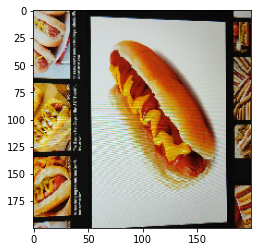

In [10]:
plt.imshow(a.reshape(200, 200, 3))

In [11]:
model.predict(a.reshape(1, 200, 200, 3))

array([[0.4837626]], dtype=float32)

In [70]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

img = img_to_array(load_img('./IMG_20210725_215537.jpg',target_size=(200, 200)))
img.shape

(200, 200, 3)

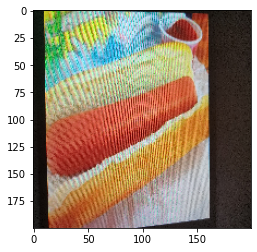

In [71]:
plt.imshow(img.astype('float32')/255)

In [72]:
model.predict(np.array([img]))

array([[0.30748314]], dtype=float32)

In [30]:
import tensorflow as tf

In [34]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmply9fgb47/assets


In [36]:
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)